# Titanic with Deep Learning    

## Setup

In [3]:
os.makedirs(savepath, exist_ok=True)

In [4]:
print("PyTorch Version: ",torch.__version__)

print("CUDA is available" if torch.cuda.is_available() else "CUDA is not available")
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

PyTorch Version:  2.2.1+cu121
CUDA is available
NVIDIA GeForce RTX 4070 Laptop GPU


In [5]:
data = pd.read_csv(csv_path)
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
class NN(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, dropout=0.0):
        super(NN, self).__init__()
        self.blocks = nn.ModuleList()

        self.in_layer = nn.Linear(in_dim, hidden_dims[0])
        for i in range(1, len(hidden_dims)):
            self.blocks.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            if dropout > 0:
                self.blocks.append(nn.Dropout(dropout))
        self.out_layer = nn.Linear(hidden_dims[-1], out_dim)
        
        # self._init_weights()
    
    def _init_weights(self):
        for layer in self.blocks:
            if isinstance(layer, nn.Linear):
                nn.init.normal(layer.weight, std=0.01)
                nn.init.constant_(layer.bias, 0)
        nn.init.normal(self.out_layer.weight, std=0.01)
        nn.init.constant_(self.out_layer.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.in_layer(x))
        for layer in self.blocks:
            x = F.relu(layer(x))
        x = self.out_layer(x)
        return torch.sigmoid(x)



In [8]:
from tqdm import tqdm


def train(model: nn.Module, dataloader_train: DataLoader, dataloader_val: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module, n_epochs: int, val_freq: int):
    train_stats = {"epoch": [], "loss": []}
    val_stats = {"epoch": [], "acc": [], "loss": []}
    model.train()
    for epoch in range(n_epochs):
        with tqdm(enumerate(dataloader_train, 0), total=len(dataloader_train), desc=f"Epoch {epoch+1}/{n_epochs}", unit="batch") as pbar:

            running_loss = 0.0
            for i, data in pbar:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            running_loss /= len(dataloader_train)
            train_stats["epoch"].append(epoch)
            train_stats["loss"].append(running_loss)
            # print(f"[Epoch {epoch+1}/{n_epochs}] Loss: {running_loss:.3f}")

            if epoch % val_freq == 0:
                val_loss = 0.0
                model.eval()
                running_acc = 0
                with torch.no_grad():
                    for data in dataloader_val:
                        inputs, labels = data
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)

                        loss = criterion(outputs.squeeze(), labels)
                        val_loss += loss.item()
                        print(outputs)
                        print(labels)
                        acc = (outputs.squeeze().round() == labels).sum()
                        running_acc += acc
                
                running_acc = running_acc.to(torch.float32).mean().item()
                val_loss /= len(dataloader_val)
                print(f"Accuracy: {acc:.2f}%")
                val_stats["epoch"].append(epoch)
                val_stats["acc"].append(running_acc)
                val_stats["loss"].append(val_loss)

    return model, train_stats, val_stats

In [9]:
# Data
dataset_train = TitanicDataset(csv_path, train=True, columns=columns)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TitanicDataset(csv_path, train=False, columns=columns)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

display(dataset_train.data.shape, dataset_val.data.shape)

(712, 11)

(143, 11)

In [10]:
in_dim = dataset_train.data.shape[1] - 1 # exclude the target column
hidden_dims = [3]
out_dim = 1
dropout = 0.1
val_freq = 1

models = [ 
    NN(in_dim, [3], out_dim, dropout=0),
    NN(in_dim, [3, 6, 12, 6, 3], out_dim, dropout=0),
    NN(in_dim, [20,40,80,40,20], out_dim, dropout=0),
    NN(in_dim, [20,40,80,120,160], out_dim, dropout=0),
    NN(in_dim, [20,40,80,40,20], out_dim, dropout=0.5),
    NN(in_dim, [3], out_dim, dropout=0.8),


]
overall_train_stats = []
overall_val_stats = []
for model in models:
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.BCELoss()
    trained_model, train_stats, val_stats = train(model, dataloader_train, dataloader_val, optimizer, criterion, n_epochs, val_freq)
    overall_train_stats.append(train_stats)
    overall_val_stats.append(val_stats)



Epoch 1/100:  27%|██▋       | 12/45 [00:00<00:00, 109.12batch/s]

Epoch 1/100: 100%|██████████| 45/45 [00:00<00:00, 214.30batch/s]


tensor([[0.4935],
        [0.5251],
        [0.5307],
        [0.4908],
        [0.5136],
        [0.4854],
        [0.4864],
        [0.4901],
        [0.5660],
        [0.5025],
        [0.5406],
        [0.5770],
        [0.4718],
        [0.4742],
        [0.4856],
        [0.4800]])
tensor([1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.5232],
        [0.4872],
        [0.4519],
        [0.5742],
        [0.4922],
        [0.4797],
        [0.5267],
        [0.4784],
        [0.4809],
        [0.4859],
        [0.4911],
        [0.4723],
        [0.5264],
        [0.5716],
        [0.4837],
        [0.5168]])
tensor([1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.4611],
        [0.4951],
        [0.4814],
        [0.4615],
        [0.5030],
        [0.4924],
        [0.5301],
        [0.4823],
        [0.4887],
        [0.5026],
        [0.4898],
        [0.4940],
        [0.4644],
        [0.5282],
        [0.4592],
      

Epoch 2/100: 100%|██████████| 45/45 [00:00<00:00, 409.09batch/s]

tensor([[0.4868],
        [0.4533],
        [0.5223],
        [0.4528],
        [0.4648],
        [0.4765],
        [0.4584],
        [0.4932],
        [0.4596],
        [0.4265],
        [0.5153],
        [0.5257],
        [0.4612],
        [0.4674],
        [0.4605],
        [0.5139]])


tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.4720],
        [0.4377],
        [0.4695],
        [0.4480],
        [0.4410],
        [0.4331],
        [0.4757],
        [0.4547],
        [0.4552],
        [0.5243],
        [0.5197],
        [0.4658],
        [0.5123],
        [0.5604],
        [0.4624],
        [0.5142]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.4492],
        [0.5155],
        [0.5651],
        [0.5222],
        [0.4448],
        [0.4621],
        [0.4700],
        [0.4522],
        [0.4545],
        [0.4596],
        [0.4385],
        [0.4588],
        [0.4884],
        [0.5181],
        [0.4509],
        [0.4725]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.5243],
        [0.4813],
        [0.4555],
        [0.4954],
        [0.4411],
        [0.4590],
        [0.4477],
        [0.5539],
        [0.5060],
        [0.4533],
        [0.4551],
    

Epoch 3/100: 100%|██████████| 45/45 [00:00<00:00, 409.13batch/s]


tensor([[0.4833],
        [0.5126],
        [0.4240],
        [0.5151],
        [0.4317],
        [0.4348],
        [0.4314],
        [0.4442],
        [0.4262],
        [0.4230],
        [0.4257],
        [0.4175],
        [0.4298],
        [0.4469],
        [0.4373],
        [0.5356]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.4322],
        [0.4261],
        [0.4271],
        [0.4349],
        [0.5374],
        [0.4336],
        [0.5377],
        [0.4303],
        [0.4447],
        [0.5704],
        [0.5207],
        [0.4308],
        [0.4650],
        [0.4829],
        [0.4245],
        [0.4940]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0.])
tensor([[0.4233],
        [0.4119],
        [0.4785],
        [0.4310],
        [0.4296],
        [0.5417],
        [0.4919],
        [0.5198],
        [0.4154],
        [0.4183],
        [0.4211],
        [0.4335],
        [0.4832],
        [0.4388],
        [0.4247],
      

Epoch 4/100: 100%|██████████| 45/45 [00:00<00:00, 500.04batch/s]


tensor([[0.4960],
        [0.4104],
        [0.4988],
        [0.4100],
        [0.5162],
        [0.5011],
        [0.5668],
        [0.4098],
        [0.5689],
        [0.4112],
        [0.4129],
        [0.3999],
        [0.5267],
        [0.4089],
        [0.4732],
        [0.4916]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.4063],
        [0.4998],
        [0.4049],
        [0.4106],
        [0.5796],
        [0.4190],
        [0.4131],
        [0.4218],
        [0.4187],
        [0.4108],
        [0.4111],
        [0.5150],
        [0.5597],
        [0.5193],
        [0.5611],
        [0.4102]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.4861],
        [0.4087],
        [0.4803],
        [0.5142],
        [0.4960],
        [0.4094],
        [0.4907],
        [0.4087],
        [0.4087],
        [0.4102],
        [0.4043],
        [0.5639],
        [0.4105],
        [0.4000],
        [0.4119],
      

Epoch 5/100: 100%|██████████| 45/45 [00:00<00:00, 449.92batch/s]


tensor([[0.5287],
        [0.3925],
        [0.3925],
        [0.3921],
        [0.3908],
        [0.5486],
        [0.3932],
        [0.3926],
        [0.3932],
        [0.5105],
        [0.5235],
        [0.5238],
        [0.5061],
        [0.3933],
        [0.3924],
        [0.3925]])
tensor([1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.3953],
        [0.4973],
        [0.3934],
        [0.6184],
        [0.3866],
        [0.6001],
        [0.3933],
        [0.3931],
        [0.3932],
        [0.3937],
        [0.5126],
        [0.5334],
        [0.3932],
        [0.3854],
        [0.3867],
        [0.5296]])
tensor([0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.3931],
        [0.3932],
        [0.3917],
        [0.5168],
        [0.6138],
        [0.3937],
        [0.5175],
        [0.3932],
        [0.5136],
        [0.6007],
        [0.3884],
        [0.3934],
        [0.3919],
        [0.6181],
        [0.3926],
      

Epoch 6/100: 100%|██████████| 45/45 [00:00<00:00, 300.01batch/s]


tensor([[0.6324],
        [0.6439],
        [0.3731],
        [0.3756],
        [0.3730],
        [0.5258],
        [0.5360],
        [0.3757],
        [0.5206],
        [0.3778],
        [0.3747],
        [0.3731],
        [0.5365],
        [0.3781],
        [0.3775],
        [0.5406]])
tensor([1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.3781],
        [0.5365],
        [0.3762],
        [0.5656],
        [0.6225],
        [0.5261],
        [0.3731],
        [0.3765],
        [0.5212],
        [0.3767],
        [0.3772],
        [0.5430],
        [0.5763],
        [0.3787],
        [0.3787],
        [0.3738]])
tensor([0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.3780],
        [0.3761],
        [0.5426],
        [0.6253],
        [0.3741],
        [0.3766],
        [0.5419],
        [0.5395],
        [0.5371],
        [0.5324],
        [0.3727],
        [0.5343],
        [0.3777],
        [0.5192],
        [0.5837],
      

Epoch 7/100: 100%|██████████| 45/45 [00:00<00:00, 409.07batch/s]


tensor([[0.5454],
        [0.5395],
        [0.3537],
        [0.6544],
        [0.5567],
        [0.3578],
        [0.5590],
        [0.3578],
        [0.3589],
        [0.3564],
        [0.5582],
        [0.3520],
        [0.5554],
        [0.3537],
        [0.3635],
        [0.5593]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.6329],
        [0.3606],
        [0.3593],
        [0.5447],
        [0.7264],
        [0.5271],
        [0.5609],
        [0.5557],
        [0.5356],
        [0.6118],
        [0.3603],
        [0.5582],
        [0.3600],
        [0.3555],
        [0.3588],
        [0.5528]])
tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.3529],
        [0.5524],
        [0.3600],
        [0.6876],
        [0.3605],
        [0.3625],
        [0.3635],
        [0.3554],
        [0.5538],
        [0.5390],
        [0.5415],
        [0.3582],
        [0.5560],
        [0.5373],
        [0.6062],
      

Epoch 8/100: 100%|██████████| 45/45 [00:00<00:00, 500.03batch/s]


tensor([[0.3464],
        [0.7567],
        [0.3386],
        [0.6801],
        [0.5672],
        [0.3404],
        [0.3350],
        [0.3551],
        [0.3616],
        [0.3421],
        [0.3434],
        [0.3432],
        [0.3365],
        [0.3473],
        [0.3358],
        [0.7170]])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.3354],
        [0.3493],
        [0.5541],
        [0.3433],
        [0.3417],
        [0.3391],
        [0.5741],
        [0.3408],
        [0.5467],
        [0.7064],
        [0.5579],
        [0.3477],
        [0.3393],
        [0.3434],
        [0.3557],
        [0.3442]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.3497],
        [0.3414],
        [0.3369],
        [0.3443],
        [0.5374],
        [0.6187],
        [0.6571],
        [0.3441],
        [0.5684],
        [0.3487],
        [0.5245],
        [0.6865],
        [0.3437],
        [0.3493],
        [0.5947],
      

Epoch 9/100: 100%|██████████| 45/45 [00:00<00:00, 374.08batch/s]


tensor([[0.3243],
        [0.3303],
        [0.7147],
        [0.5578],
        [0.5762],
        [0.5509],
        [0.3319],
        [0.3307],
        [0.3344],
        [0.3409],
        [0.3230],
        [0.5929],
        [0.3150],
        [0.5794],
        [0.3264],
        [0.5775]])
tensor([0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.3271],
        [0.5713],
        [0.7517],
        [0.3210],
        [0.3179],
        [0.6661],
        [0.3255],
        [0.3311],
        [0.3219],
        [0.3264],
        [0.5702],
        [0.3203],
        [0.3348],
        [0.3343],
        [0.6014],
        [0.3098]])
tensor([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.])
tensor([[0.3289],
        [0.3366],
        [0.3291],
        [0.3189],
        [0.5638],
        [0.7690],
        [0.3271],
        [0.6962],
        [0.3505],
        [0.8224],
        [0.3139],
        [0.5120],
        [0.8194],
        [0.3357],
        [0.3366],
      

Epoch 10/100: 100%|██████████| 45/45 [00:00<00:00, 1458.25batch/s]


tensor([[0.3012],
        [0.3044],
        [0.7295],
        [0.3072],
        [0.5004],
        [0.2962],
        [0.3079],
        [0.6059],
        [0.3074],
        [0.3067],
        [0.3203],
        [0.3054],
        [0.6173],
        [0.3183],
        [0.5854],
        [0.3192]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.3159],
        [0.8196],
        [0.3083],
        [0.2977],
        [0.3088],
        [0.3107],
        [0.4924],
        [0.3098],
        [0.3161],
        [0.6793],
        [0.3212],
        [0.7817],
        [0.3592],
        [0.6648],
        [0.3314],
        [0.2901]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0.])
tensor([[0.6564],
        [0.3001],
        [0.5744],
        [0.3033],
        [0.2978],
        [0.3527],
        [0.3207],
        [0.6500],
        [0.3616],
        [0.3098],
        [0.6202],
        [0.3229],
        [0.5474],
        [0.3111],
        [0.6148],
      

Epoch 11/100: 100%|██████████| 45/45 [00:00<00:00, 2195.43batch/s]


tensor([[0.5600],
        [0.5919],
        [0.8146],
        [0.7699],
        [0.2793],
        [0.2924],
        [0.3040],
        [0.8256],
        [0.2900],
        [0.8189],
        [0.2889],
        [0.8828],
        [0.7587],
        [0.2916],
        [0.5826],
        [0.8055]])
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.])
tensor([[0.2957],
        [0.6011],
        [0.3013],
        [0.2951],
        [0.4753],
        [0.5852],
        [0.5480],
        [0.5532],
        [0.7192],
        [0.2763],
        [0.3092],
        [0.4813],
        [0.6175],
        [0.2934],
        [0.2977],
        [0.2947]])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.2876],
        [0.6905],
        [0.3010],
        [0.3194],
        [0.2781],
        [0.2850],
        [0.6776],
        [0.2916],
        [0.5425],
        [0.2931],
        [0.5913],
        [0.5935],
        [0.2888],
        [0.2992],
        [0.6823],
      

Epoch 12/100: 100%|██████████| 45/45 [00:00<00:00, 1645.13batch/s]


tensor([[0.6080],
        [0.8945],
        [0.3126],
        [0.8320],
        [0.2947],
        [0.2875],
        [0.8351],
        [0.6816],
        [0.2727],
        [0.7144],
        [0.2777],
        [0.2840],
        [0.4566],
        [0.8228],
        [0.2493],
        [0.2863]])
tensor([0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.2611],
        [0.2795],
        [0.2637],
        [0.2616],
        [0.7127],
        [0.2812],
        [0.5564],
        [0.5952],
        [0.2828],
        [0.5927],
        [0.2744],
        [0.2955],
        [0.2873],
        [0.2750],
        [0.2694],
        [0.2670]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.2879],
        [0.5484],
        [0.2816],
        [0.3368],
        [0.6096],
        [0.2829],
        [0.7957],
        [0.3002],
        [0.2744],
        [0.5620],
        [0.6457],
        [0.8145],
        [0.5910],
        [0.2756],
        [0.2720],
      

Epoch 13/100: 100%|██████████| 45/45 [00:00<00:00, 1932.15batch/s]


tensor([[0.2630],
        [0.6638],
        [0.2723],
        [0.2587],
        [0.2750],
        [0.2629],
        [0.7149],
        [0.2629],
        [0.6692],
        [0.2779],
        [0.2625],
        [0.3393],
        [0.2602],
        [0.2692],
        [0.2687],
        [0.2485]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.6636],
        [0.3033],
        [0.8639],
        [0.8577],
        [0.7840],
        [0.5895],
        [0.2797],
        [0.8130],
        [0.2616],
        [0.5389],
        [0.5308],
        [0.2326],
        [0.2832],
        [0.5747],
        [0.6473],
        [0.8456]])
tensor([1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1.])
tensor([[0.2524],
        [0.8284],
        [0.2593],
        [0.6130],
        [0.2439],
        [0.2818],
        [0.7345],
        [0.2602],
        [0.7508],
        [0.7664],
        [0.2543],
        [0.2425],
        [0.8476],
        [0.5365],
        [0.3330],
      

Epoch 14/100: 100%|██████████| 45/45 [00:00<00:00, 1853.48batch/s]


tensor([[0.2507],
        [0.8314],
        [0.2442],
        [0.5152],
        [0.2457],
        [0.2461],
        [0.6679],
        [0.2627],
        [0.2929],
        [0.2464],
        [0.2486],
        [0.6366],
        [0.6002],
        [0.2647],
        [0.2318],
        [0.5953]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.5475],
        [0.2372],
        [0.8550],
        [0.2401],
        [0.2312],
        [0.2153],
        [0.2766],
        [0.6527],
        [0.2374],
        [0.2794],
        [0.2686],
        [0.6473],
        [0.7805],
        [0.6740],
        [0.3179],
        [0.2486]])
tensor([1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.2141],
        [0.4149],
        [0.5964],
        [0.2450],
        [0.2481],
        [0.8688],
        [0.2283],
        [0.2590],
        [0.9239],
        [0.2262],
        [0.2180],
        [0.2485],
        [0.2629],
        [0.9164],
        [0.2553],
      

Epoch 15/100: 100%|██████████| 45/45 [00:00<00:00, 1725.61batch/s]


tensor([[0.1999],
        [0.2476],
        [0.2307],
        [0.7380],
        [0.6594],
        [0.8691],
        [0.2137],
        [0.2622],
        [0.2731],
        [0.2115],
        [0.5335],
        [0.2374],
        [0.2330],
        [0.2561],
        [0.5935],
        [0.2293]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.2212],
        [0.2535],
        [0.5149],
        [0.7524],
        [0.4019],
        [0.3472],
        [0.2523],
        [0.2701],
        [0.2144],
        [0.2332],
        [0.6068],
        [0.5998],
        [0.2279],
        [0.5032],
        [0.3160],
        [0.2694]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.2351],
        [0.8476],
        [0.3326],
        [0.2478],
        [0.2691],
        [0.5964],
        [0.5598],
        [0.2119],
        [0.2028],
        [0.8648],
        [0.2257],
        [0.6268],
        [0.2314],
        [0.2236],
        [0.8601],
      

Epoch 16/100: 100%|██████████| 45/45 [00:00<00:00, 2115.32batch/s]


tensor([[0.6641],
        [0.2262],
        [0.6569],
        [0.9412],
        [0.8909],
        [0.2294],
        [0.2272],
        [0.6821],
        [0.2434],
        [0.2493],
        [0.2028],
        [0.8685],
        [0.2135],
        [0.7936],
        [0.7429],
        [0.4077]])
tensor([1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.2224],
        [0.2796],
        [0.4953],
        [0.2247],
        [0.2995],
        [0.8013],
        [0.5339],
        [0.6018],
        [0.5937],
        [0.1854],
        [0.5122],
        [0.5534],
        [0.9291],
        [0.6083],
        [0.7723],
        [0.2568]])
tensor([0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.])
tensor([[0.2130],
        [0.6173],
        [0.2421],
        [0.3839],
        [0.3151],
        [0.2313],
        [0.2235],
        [0.8853],
        [0.2007],
        [0.2073],
        [0.1990],
        [0.2239],
        [0.2241],
        [0.6478],
        [0.3827],
      

Epoch 17/100: 100%|██████████| 45/45 [00:00<00:00, 1842.26batch/s]


tensor([[0.8137],
        [0.2255],
        [0.8832],
        [0.9350],
        [0.8775],
        [0.8195],
        [0.2273],
        [0.3160],
        [0.1968],
        [0.8963],
        [0.1722],
        [0.1990],
        [0.2100],
        [0.2126],
        [0.2212],
        [0.6693]])
tensor([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.8075],
        [0.2427],
        [0.2173],
        [0.2080],
        [0.1854],
        [0.2147],
        [0.2590],
        [0.2041],
        [0.2310],
        [0.2121],
        [0.2074],
        [0.2127],
        [0.1879],
        [0.2049],
        [0.6499],
        [0.2125]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.1887],
        [0.6146],
        [0.2331],
        [0.2016],
        [0.7615],
        [0.2648],
        [0.6302],
        [0.6500],
        [0.2169],
        [0.2535],
        [0.2319],
        [0.8790],
        [0.5429],
        [0.2083],
        [0.2151],
      

Epoch 18/100: 100%|██████████| 45/45 [00:00<00:00, 1756.26batch/s]


tensor([[0.3145],
        [0.5132],
        [0.2225],
        [0.2015],
        [0.2043],
        [0.5672],
        [0.1612],
        [0.1989],
        [0.5077],
        [0.2011],
        [0.9098],
        [0.2185],
        [0.6956],
        [0.1878],
        [0.8247],
        [0.2160]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.8966],
        [0.2038],
        [0.6873],
        [0.2057],
        [0.5007],
        [0.4809],
        [0.9502],
        [0.8211],
        [0.5885],
        [0.1950],
        [0.2168],
        [0.1873],
        [0.6907],
        [0.9393],
        [0.1879],
        [0.3308]])
tensor([1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.1653],
        [0.6242],
        [0.2043],
        [0.1972],
        [0.4941],
        [0.6730],
        [0.2136],
        [0.1902],
        [0.8884],
        [0.1970],
        [0.2343],
        [0.2662],
        [0.3840],
        [0.1769],
        [0.3433],
      

Epoch 19/100: 100%|██████████| 45/45 [00:00<00:00, 1190.41batch/s]


tensor([[0.1978],
        [0.5568],
        [0.4916],
        [0.1716],
        [0.1873],
        [0.1917],
        [0.2510],
        [0.1922],
        [0.6885],
        [0.1830],
        [0.8260],
        [0.2096],
        [0.1886],
        [0.1895],
        [0.4998],
        [0.2073]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.2612],
        [0.4818],
        [0.6909],
        [0.8943],
        [0.1777],
        [0.6302],
        [0.1702],
        [0.1945],
        [0.2443],
        [0.9073],
        [0.1734],
        [0.9442],
        [0.1626],
        [0.1923],
        [0.2039],
        [0.6905]])
tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.])
tensor([[0.1965],
        [0.5735],
        [0.1780],
        [0.5142],
        [0.2489],
        [0.6293],
        [0.8322],
        [0.1489],
        [0.1905],
        [0.1905],
        [0.7692],
        [0.2124],
        [0.2113],
        [0.1546],
        [0.8787],
      

Epoch 20/100: 100%|██████████| 45/45 [00:00<00:00, 1580.71batch/s]


tensor([[0.9117],
        [0.3090],
        [0.1828],
        [0.1527],
        [0.2090],
        [0.1783],
        [0.8973],
        [0.5686],
        [0.3042],
        [0.2491],
        [0.2013],
        [0.1863],
        [0.8695],
        [0.2929],
        [0.9033],
        [0.9459]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.2330],
        [0.8388],
        [0.3548],
        [0.1603],
        [0.1926],
        [0.6776],
        [0.1815],
        [0.3194],
        [0.6201],
        [0.1795],
        [0.1815],
        [0.1867],
        [0.3233],
        [0.1923],
        [0.2090],
        [0.2058]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.6939],
        [0.1956],
        [0.6148],
        [0.2141],
        [0.1658],
        [0.1637],
        [0.1396],
        [0.2411],
        [0.1628],
        [0.8427],
        [0.1802],
        [0.5823],
        [0.1555],
        [0.2045],
        [0.8890],
      

Epoch 21/100: 100%|██████████| 45/45 [00:00<00:00, 1917.58batch/s]


tensor([[0.3231],
        [0.8990],
        [0.4695],
        [0.8560],
        [0.1697],
        [0.2028],
        [0.4753],
        [0.1726],
        [0.9120],
        [0.8518],
        [0.2742],
        [0.9235],
        [0.2449],
        [0.6249],
        [0.2384],
        [0.1480]])
tensor([0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([[0.8567],
        [0.1519],
        [0.3375],
        [0.3568],
        [0.6830],
        [0.7193],
        [0.1796],
        [0.7038],
        [0.2509],
        [0.1455],
        [0.7243],
        [0.2256],
        [0.7579],
        [0.8932],
        [0.9584],
        [0.1886]])
tensor([1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.1624],
        [0.3240],
        [0.2011],
        [0.6527],
        [0.4362],
        [0.1694],
        [0.1864],
        [0.1677],
        [0.1934],
        [0.6505],
        [0.1382],
        [0.1905],
        [0.1760],
        [0.1315],
        [0.1602],
      

Epoch 22/100: 100%|██████████| 45/45 [00:00<00:00, 1543.02batch/s]


tensor([[0.1593],
        [0.2967],
        [0.1805],
        [0.1944],
        [0.9206],
        [0.4744],
        [0.1583],
        [0.1536],
        [0.1675],
        [0.7338],
        [0.1656],
        [0.1408],
        [0.2444],
        [0.1663],
        [0.5606],
        [0.1372]])
tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.2535],
        [0.2369],
        [0.6547],
        [0.6537],
        [0.7475],
        [0.1725],
        [0.5626],
        [0.2114],
        [0.2398],
        [0.7163],
        [0.9197],
        [0.3273],
        [0.5331],
        [0.1666],
        [0.1936],
        [0.6696]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.9280],
        [0.1830],
        [0.3186],
        [0.2458],
        [0.3773],
        [0.1250],
        [0.9199],
        [0.6940],
        [0.1810],
        [0.1645],
        [0.9514],
        [0.4720],
        [0.6633],
        [0.8671],
        [0.1965],
      

Epoch 23/100: 100%|██████████| 45/45 [00:00<00:00, 1768.84batch/s]


tensor([[0.5567],
        [0.3777],
        [0.2006],
        [0.2202],
        [0.5743],
        [0.1754],
        [0.1864],
        [0.2405],
        [0.8750],
        [0.6807],
        [0.2793],
        [0.9522],
        [0.9227],
        [0.1581],
        [0.1834],
        [0.4162]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.1753],
        [0.9537],
        [0.8759],
        [0.2374],
        [0.2212],
        [0.9040],
        [0.7396],
        [0.4649],
        [0.2352],
        [0.1526],
        [0.4222],
        [0.1946],
        [0.1565],
        [0.5467],
        [0.1615],
        [0.1865]])
tensor([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.6769],
        [0.1334],
        [0.5593],
        [0.3370],
        [0.9005],
        [0.1332],
        [0.1637],
        [0.1757],
        [0.9267],
        [0.3154],
        [0.1495],
        [0.7005],
        [0.6714],
        [0.4619],
        [0.6318],
      

Epoch 24/100: 100%|██████████| 45/45 [00:00<00:00, 1510.00batch/s]


tensor([[0.1400],
        [0.1827],
        [0.6282],
        [0.1678],
        [0.7067],
        [0.5122],
        [0.1607],
        [0.3950],
        [0.2459],
        [0.1356],
        [0.1695],
        [0.1275],
        [0.1505],
        [0.3210],
        [0.6836],
        [0.1556]])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.5551],
        [0.2421],
        [0.1927],
        [0.1703],
        [0.1689],
        [0.5505],
        [0.1532],
        [0.9076],
        [0.1309],
        [0.7047],
        [0.1184],
        [0.8798],
        [0.1516],
        [0.3385],
        [0.1112],
        [0.8626]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.2169],
        [0.9624],
        [0.3279],
        [0.2331],
        [0.8772],
        [0.2029],
        [0.1266],
        [0.1818],
        [0.5349],
        [0.8866],
        [0.1233],
        [0.2455],
        [0.4028],
        [0.1577],
        [0.1484],
      

Epoch 25/100: 100%|██████████| 45/45 [00:00<00:00, 1901.62batch/s]


tensor([[0.3944],
        [0.1567],
        [0.3208],
        [0.1412],
        [0.2155],
        [0.1176],
        [0.9079],
        [0.1292],
        [0.1483],
        [0.1076],
        [0.4398],
        [0.1454],
        [0.1458],
        [0.1433],
        [0.2203],
        [0.9631]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.1641],
        [0.3910],
        [0.7048],
        [0.4657],
        [0.6792],
        [0.1854],
        [0.1822],
        [0.1346],
        [0.1943],
        [0.1372],
        [0.7420],
        [0.1413],
        [0.5658],
        [0.1483],
        [0.1980],
        [0.3106]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.8832],
        [0.1471],
        [0.5415],
        [0.1531],
        [0.1494],
        [0.1523],
        [0.3304],
        [0.1880],
        [0.1530],
        [0.1667],
        [0.9529],
        [0.2421],
        [0.7347],
        [0.9004],
        [0.8958],
      

Epoch 26/100: 100%|██████████| 45/45 [00:00<00:00, 1499.91batch/s]


tensor([[0.5206],
        [0.7058],
        [0.2607],
        [0.9536],
        [0.5648],
        [0.2797],
        [0.7656],
        [0.4896],
        [0.1161],
        [0.1165],
        [0.1416],
        [0.2405],
        [0.1530],
        [0.1468],
        [0.5980],
        [0.1468]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.2330],
        [0.1515],
        [0.1491],
        [0.1881],
        [0.2325],
        [0.1328],
        [0.1030],
        [0.1819],
        [0.1335],
        [0.1430],
        [0.3305],
        [0.7429],
        [0.1537],
        [0.7650],
        [0.1175],
        [0.7420]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.2139],
        [0.1627],
        [0.5341],
        [0.1454],
        [0.9120],
        [0.8802],
        [0.1710],
        [0.6649],
        [0.2009],
        [0.1754],
        [0.1856],
        [0.1839],
        [0.3421],
        [0.5421],
        [0.3869],
      

Epoch 27/100: 100%|██████████| 45/45 [00:00<00:00, 1650.81batch/s]


tensor([[0.1075],
        [0.1389],
        [0.3550],
        [0.1191],
        [0.1850],
        [0.7192],
        [0.1455],
        [0.2622],
        [0.2326],
        [0.1372],
        [0.2123],
        [0.1905],
        [0.1110],
        [0.9595],
        [0.2996],
        [0.1520]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.1322],
        [0.9014],
        [0.1410],
        [0.1820],
        [0.9247],
        [0.3166],
        [0.7045],
        [0.9007],
        [0.1084],
        [0.1494],
        [0.4282],
        [0.1486],
        [0.4817],
        [0.2125],
        [0.1080],
        [0.1042]])
tensor([0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.1402],
        [0.9099],
        [0.2419],
        [0.1750],
        [0.1576],
        [0.9298],
        [0.1734],
        [0.0985],
        [0.3667],
        [0.1156],
        [0.9184],
        [0.1480],
        [0.1274],
        [0.9101],
        [0.1375],
      

Epoch 28/100: 100%|██████████| 45/45 [00:00<00:00, 2076.89batch/s]


tensor([[0.8977],
        [0.1555],
        [0.1368],
        [0.1728],
        [0.2430],
        [0.1464],
        [0.2361],
        [0.1810],
        [0.7206],
        [0.5376],
        [0.5325],
        [0.1801],
        [0.1340],
        [0.1244],
        [0.1067],
        [0.8960]])
tensor([1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.1544],
        [0.1253],
        [0.3287],
        [0.6994],
        [0.3298],
        [0.4249],
        [0.1384],
        [0.7757],
        [0.6555],
        [0.1469],
        [0.5268],
        [0.1449],
        [0.5206],
        [0.3153],
        [0.1163],
        [0.3764]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.9436],
        [0.5102],
        [0.1542],
        [0.2417],
        [0.9413],
        [0.1157],
        [0.1414],
        [0.1148],
        [0.1658],
        [0.2422],
        [0.1932],
        [0.3749],
        [0.1080],
        [0.9221],
        [0.7365],
      

Epoch 29/100: 100%|██████████| 45/45 [00:00<00:00, 2741.06batch/s]


tensor([[0.1184],
        [0.3321],
        [0.3173],
        [0.9573],
        [0.6497],
        [0.0910],
        [0.3857],
        [0.7432],
        [0.1279],
        [0.0890],
        [0.1347],
        [0.2824],
        [0.2431],
        [0.1871],
        [0.3055],
        [0.4486]])
tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.1351],
        [0.1842],
        [0.1706],
        [0.1217],
        [0.3457],
        [0.7407],
        [0.7382],
        [0.1337],
        [0.1309],
        [0.2340],
        [0.9456],
        [0.5602],
        [0.0965],
        [0.2427],
        [0.5108],
        [0.1429]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.7493],
        [0.1636],
        [0.1687],
        [0.1742],
        [0.6261],
        [0.1209],
        [0.1727],
        [0.7028],
        [0.9008],
        [0.1305],
        [0.1525],
        [0.5172],
        [0.1121],
        [0.7206],
        [0.9507],
      

Epoch 30/100: 100%|██████████| 45/45 [00:00<00:00, 1917.76batch/s]


tensor([[0.1718],
        [0.1502],
        [0.9246],
        [0.1679],
        [0.7657],
        [0.9338],
        [0.1363],
        [0.1299],
        [0.2101],
        [0.5080],
        [0.1864],
        [0.2584],
        [0.1418],
        [0.7328],
        [0.4039],
        [0.1314]])
tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1706],
        [0.1744],
        [0.3337],
        [0.3192],
        [0.2519],
        [0.1520],
        [0.9139],
        [0.2953],
        [0.1494],
        [0.2442],
        [0.4463],
        [0.1179],
        [0.1293],
        [0.5145],
        [0.1280],
        [0.3996]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.1408],
        [0.9226],
        [0.9523],
        [0.1023],
        [0.3349],
        [0.2110],
        [0.1670],
        [0.1850],
        [0.3773],
        [0.1654],
        [0.2784],
        [0.1821],
        [0.1690],
        [0.1252],
        [0.0925],
      

Epoch 31/100: 100%|██████████| 45/45 [00:00<00:00, 2249.47batch/s]


tensor([[0.1785],
        [0.1127],
        [0.2357],
        [0.7688],
        [0.9622],
        [0.1952],
        [0.1277],
        [0.1873],
        [0.4876],
        [0.1000],
        [0.1331],
        [0.4335],
        [0.1611],
        [0.9115],
        [0.6385],
        [0.3884]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.])
tensor([[0.2949],
        [0.1052],
        [0.9166],
        [0.2423],
        [0.1822],
        [0.4984],
        [0.1167],
        [0.0823],
        [0.7341],
        [0.1847],
        [0.2424],
        [0.1868],
        [0.1361],
        [0.4989],
        [0.1187],
        [0.1702]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.1362],
        [0.2515],
        [0.3123],
        [0.1463],
        [0.1409],
        [0.9540],
        [0.1121],
        [0.9439],
        [0.1291],
        [0.3365],
        [0.1132],
        [0.2108],
        [0.1753],
        [0.9046],
        [0.2599],
      

Epoch 32/100: 100%|██████████| 45/45 [00:00<00:00, 1660.73batch/s]


tensor([[0.7482],
        [0.2482],
        [0.2077],
        [0.3891],
        [0.0815],
        [0.9428],
        [0.1471],
        [0.1338],
        [0.6845],
        [0.4773],
        [0.1602],
        [0.1782],
        [0.3515],
        [0.1090],
        [0.1105],
        [0.2341]])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.2593],
        [0.1137],
        [0.3359],
        [0.2325],
        [0.9643],
        [0.0895],
        [0.1687],
        [0.9513],
        [0.1712],
        [0.9155],
        [0.1317],
        [0.1848],
        [0.1441],
        [0.1351],
        [0.9318],
        [0.1489]])
tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.1950],
        [0.5152],
        [0.3374],
        [0.1740],
        [0.1003],
        [0.2785],
        [0.2909],
        [0.9077],
        [0.9573],
        [0.1160],
        [0.1699],
        [0.8394],
        [0.7844],
        [0.7281],
        [0.1293],
      

Epoch 33/100: 100%|██████████| 45/45 [00:00<00:00, 3292.29batch/s]

tensor([[0.1447],
        [0.9239],
        [0.1332],
        [0.1230],
        [0.2544],
        [0.3449],
        [0.5051],
        [0.0940],
        [0.1648],
        [0.8438],
        [0.0869],
        [0.9547],
        [0.2907],
        [0.1332],
        [0.5197],
        [0.7217]])


tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.1085],
        [0.1385],
        [0.9154],
        [0.9462],
        [0.2836],
        [0.1900],
        [0.0986],
        [0.9091],
        [0.3327],
        [0.1644],
        [0.6440],
        [0.1299],
        [0.1326],
        [0.1241],
        [0.1194],
        [0.9307]])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.7361],
        [0.1316],
        [0.2429],
        [0.1055],
        [0.1832],
        [0.7393],
        [0.0767],
        [0.9487],
        [0.0898],
        [0.1511],
        [0.3883],
        [0.6850],
        [0.1281],
        [0.4906],
        [0.2876],
        [0.4295]])
tensor([1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.1649],
        [0.1226],
        [0.2608],
        [0.1724],
        [0.1359],
        [0.1871],
        [0.1373],
        [0.1664],
        [0.9103],
        [0.1793],
        [0.2639],
     

Epoch 34/100: 100%|██████████| 45/45 [00:00<00:00, 1936.15batch/s]


tensor([[0.2431],
        [0.1436],
        [0.9699],
        [0.1234],
        [0.5104],
        [0.7913],
        [0.3378],
        [0.6389],
        [0.1777],
        [0.0947],
        [0.7221],
        [0.5157],
        [0.1778],
        [0.1330],
        [0.7804],
        [0.1328]])
tensor([1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.5083],
        [0.9113],
        [0.0885],
        [0.1837],
        [0.1732],
        [0.1310],
        [0.5611],
        [0.0961],
        [0.4767],
        [0.7374],
        [0.1185],
        [0.0881],
        [0.0793],
        [0.3148],
        [0.1958],
        [0.1442]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.])
tensor([[0.7893],
        [0.1111],
        [0.7654],
        [0.1176],
        [0.2433],
        [0.8453],
        [0.1668],
        [0.9318],
        [0.3834],
        [0.1586],
        [0.3510],
        [0.1100],
        [0.2104],
        [0.1644],
        [0.1317],
      

Epoch 35/100: 100%|██████████| 45/45 [00:00<00:00, 1899.80batch/s]


tensor([[0.2677],
        [0.3872],
        [0.1323],
        [0.7870],
        [0.9102],
        [0.1376],
        [0.4064],
        [0.9092],
        [0.1136],
        [0.0856],
        [0.9709],
        [0.2076],
        [0.0709],
        [0.7882],
        [0.7564],
        [0.2479]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.9396],
        [0.1416],
        [0.1164],
        [0.1766],
        [0.1678],
        [0.2830],
        [0.2557],
        [0.0814],
        [0.1258],
        [0.6632],
        [0.3395],
        [0.1315],
        [0.1147],
        [0.7238],
        [0.1915],
        [0.0855]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.7889],
        [0.7308],
        [0.1189],
        [0.5125],
        [0.9655],
        [0.1772],
        [0.1337],
        [0.0929],
        [0.1301],
        [0.9606],
        [0.1076],
        [0.1314],
        [0.1088],
        [0.2267],
        [0.4782],
      

Epoch 36/100: 100%|██████████| 45/45 [00:00<00:00, 1499.97batch/s]


tensor([[0.3397],
        [0.7194],
        [0.1778],
        [0.3398],
        [0.1728],
        [0.7568],
        [0.7710],
        [0.3198],
        [0.4973],
        [0.1632],
        [0.1420],
        [0.1275],
        [0.9407],
        [0.1035],
        [0.8457],
        [0.1359]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.1416],
        [0.1314],
        [0.9653],
        [0.0900],
        [0.2296],
        [0.2432],
        [0.9277],
        [0.9301],
        [0.3190],
        [0.9420],
        [0.1680],
        [0.2428],
        [0.1846],
        [0.3547],
        [0.1428],
        [0.1209]])
tensor([1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.1245],
        [0.1606],
        [0.2400],
        [0.1289],
        [0.1311],
        [0.9119],
        [0.2585],
        [0.4747],
        [0.9544],
        [0.0837],
        [0.1895],
        [0.3265],
        [0.2107],
        [0.1169],
        [0.1926],
      

Epoch 37/100: 100%|██████████| 45/45 [00:00<00:00, 1703.28batch/s]


tensor([[0.3906],
        [0.9631],
        [0.3378],
        [0.1786],
        [0.2482],
        [0.0677],
        [0.1684],
        [0.1415],
        [0.2804],
        [0.1312],
        [0.5574],
        [0.9165],
        [0.3174],
        [0.0875],
        [0.2413],
        [0.1311]])
tensor([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.1188],
        [0.1259],
        [0.9660],
        [0.6267],
        [0.7955],
        [0.2439],
        [0.2488],
        [0.0956],
        [0.0700],
        [0.1659],
        [0.1313],
        [0.7609],
        [0.0886],
        [0.1656],
        [0.9520],
        [0.1360]])
tensor([0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.1257],
        [0.1242],
        [0.4536],
        [0.3188],
        [0.4876],
        [0.1852],
        [0.1740],
        [0.1025],
        [0.8476],
        [0.1658],
        [0.1499],
        [0.2711],
        [0.9651],
        [0.2469],
        [0.2529],
      

Epoch 38/100: 100%|██████████| 45/45 [00:00<00:00, 3220.17batch/s]


tensor([[0.0684],
        [0.1604],
        [0.2123],
        [0.1209],
        [0.1091],
        [0.1736],
        [0.9636],
        [0.2321],
        [0.0863],
        [0.1388],
        [0.1137],
        [0.3159],
        [0.9141],
        [0.1183],
        [0.9466],
        [0.1951]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.0761],
        [0.1228],
        [0.1271],
        [0.8069],
        [0.1335],
        [0.8497],
        [0.1297],
        [0.1406],
        [0.2733],
        [0.9536],
        [0.3183],
        [0.1583],
        [0.7302],
        [0.7715],
        [0.8016],
        [0.1045]])
tensor([0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0.])
tensor([[0.3532],
        [0.1410],
        [0.0878],
        [0.9762],
        [0.2492],
        [0.2258],
        [0.1142],
        [0.2011],
        [0.4693],
        [0.2110],
        [0.2242],
        [0.9133],
        [0.9334],
        [0.9664],
        [0.1226],
      

Epoch 39/100: 100%|██████████| 45/45 [00:00<00:00, 1869.55batch/s]


tensor([[0.7982],
        [0.0672],
        [0.9507],
        [0.1870],
        [0.1506],
        [0.1689],
        [0.1383],
        [0.6597],
        [0.1184],
        [0.9645],
        [0.0747],
        [0.1691],
        [0.3189],
        [0.9177],
        [0.7437],
        [0.1313]])
tensor([1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.1220],
        [0.1303],
        [0.1206],
        [0.3161],
        [0.3770],
        [0.2178],
        [0.2491],
        [0.1406],
        [0.1660],
        [0.3899],
        [0.1037],
        [0.2508],
        [0.1137],
        [0.4836],
        [0.1297],
        [0.9552]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.3391],
        [0.1781],
        [0.1589],
        [0.0805],
        [0.0858],
        [0.1012],
        [0.9149],
        [0.3858],
        [0.0840],
        [0.1313],
        [0.6219],
        [0.4596],
        [0.9566],
        [0.9338],
        [0.1603],
      

Epoch 40/100: 100%|██████████| 45/45 [00:00<00:00, 2249.39batch/s]


tensor([[0.0903],
        [0.1313],
        [0.3568],
        [0.5949],
        [0.0738],
        [0.0858],
        [0.4675],
        [0.9231],
        [0.2362],
        [0.2467],
        [0.1747],
        [0.6597],
        [0.0847],
        [0.3413],
        [0.0828],
        [0.9651]])
tensor([0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.8056],
        [0.1176],
        [0.3415],
        [0.0989],
        [0.9785],
        [0.4984],
        [0.9163],
        [0.9670],
        [0.1311],
        [0.8525],
        [0.7882],
        [0.1806],
        [0.3084],
        [0.9541],
        [0.1132],
        [0.2134]])
tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.4407],
        [0.4553],
        [0.3913],
        [0.9188],
        [0.1670],
        [0.4930],
        [0.1180],
        [0.1605],
        [0.1063],
        [0.7292],
        [0.4163],
        [0.2091],
        [0.1400],
        [0.2375],
        [0.1666],
      

Epoch 41/100: 100%|██████████| 45/45 [00:00<00:00, 2275.17batch/s]


tensor([[0.0722],
        [0.9677],
        [0.1305],
        [0.7648],
        [0.3771],
        [0.1690],
        [0.2392],
        [0.7473],
        [0.1225],
        [0.1744],
        [0.2461],
        [0.2455],
        [0.7320],
        [0.5951],
        [0.1664],
        [0.1569]])
tensor([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.1579],
        [0.2211],
        [0.9158],
        [0.1391],
        [0.2395],
        [0.4149],
        [0.1303],
        [0.9649],
        [0.1986],
        [0.6611],
        [0.1170],
        [0.0764],
        [0.9662],
        [0.1165],
        [0.0832],
        [0.9245]])
tensor([1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.1047],
        [0.0808],
        [0.9457],
        [0.1376],
        [0.3422],
        [0.2528],
        [0.1365],
        [0.3061],
        [0.8552],
        [0.2052],
        [0.9554],
        [0.4941],
        [0.3923],
        [0.3223],
        [0.1805],
      

Epoch 42/100: 100%|██████████| 45/45 [00:00<00:00, 2720.20batch/s]


tensor([[0.1210],
        [0.1257],
        [0.0705],
        [0.9411],
        [0.1996],
        [0.4821],
        [0.1034],
        [0.2135],
        [0.2596],
        [0.7587],
        [0.9563],
        [0.2467],
        [0.9194],
        [0.7348],
        [0.4964],
        [0.1748]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.])
tensor([[0.8569],
        [0.9594],
        [0.2694],
        [0.7866],
        [0.9214],
        [0.5649],
        [0.8138],
        [0.0761],
        [0.1450],
        [0.9371],
        [0.8033],
        [0.2879],
        [0.1657],
        [0.5328],
        [0.1894],
        [0.9340]])
tensor([1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.4157],
        [0.1574],
        [0.0587],
        [0.8273],
        [0.1097],
        [0.1171],
        [0.2197],
        [0.4406],
        [0.0791],
        [0.9681],
        [0.1165],
        [0.2519],
        [0.5018],
        [0.1958],
        [0.1084],
      

Epoch 43/100: 100%|██████████| 45/45 [00:00<00:00, 1816.69batch/s]


tensor([[0.2179],
        [0.1286],
        [0.1257],
        [0.2006],
        [0.1285],
        [0.3580],
        [0.0753],
        [0.6613],
        [0.1968],
        [0.1305],
        [0.1261],
        [0.3358],
        [0.3169],
        [0.9435],
        [0.3776],
        [0.1384]])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.8338],
        [0.9682],
        [0.3859],
        [0.3067],
        [0.0590],
        [0.8099],
        [0.1432],
        [0.3845],
        [0.0805],
        [0.1110],
        [0.1360],
        [0.0593],
        [0.4868],
        [0.0821],
        [0.9348],
        [0.9499]])
tensor([1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.2134],
        [0.9385],
        [0.9472],
        [0.4642],
        [0.8122],
        [0.3764],
        [0.2430],
        [0.1257],
        [0.2529],
        [0.8584],
        [0.1002],
        [0.7733],
        [0.1160],
        [0.1176],
        [0.4176],
      

Epoch 44/100: 100%|██████████| 45/45 [00:00<00:00, 2047.07batch/s]


tensor([[0.2136],
        [0.0856],
        [0.9211],
        [0.1630],
        [0.4311],
        [0.2446],
        [0.3516],
        [0.1378],
        [0.7411],
        [0.0578],
        [0.6538],
        [0.8555],
        [0.8038],
        [0.0714],
        [0.1154],
        [0.1006]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.9435],
        [0.3833],
        [0.3359],
        [0.1058],
        [0.1298],
        [0.0793],
        [0.5313],
        [0.1693],
        [0.1252],
        [0.1169],
        [0.1365],
        [0.7693],
        [0.3163],
        [0.9166],
        [0.9342],
        [0.1735]])
tensor([1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.])
tensor([[0.1281],
        [0.5917],
        [0.2623],
        [0.1358],
        [0.8288],
        [0.7339],
        [0.9366],
        [0.1520],
        [0.1101],
        [0.7541],
        [0.1343],
        [0.7639],
        [0.3503],
        [0.2138],
        [0.1150],
      

Epoch 45/100: 100%|██████████| 45/45 [00:00<00:00, 2388.01batch/s]


tensor([[0.3735],
        [0.0670],
        [0.0674],
        [0.1002],
        [0.0718],
        [0.3016],
        [0.1595],
        [0.9188],
        [0.1988],
        [0.2643],
        [0.1284],
        [0.9388],
        [0.1363],
        [0.1390],
        [0.0943],
        [0.3093]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.1065],
        [0.9606],
        [0.4175],
        [0.3360],
        [0.9270],
        [0.3866],
        [0.2210],
        [0.1713],
        [0.9210],
        [0.1633],
        [0.0557],
        [0.1572],
        [0.5397],
        [0.9685],
        [0.4588],
        [0.7377]])
tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.])
tensor([[0.1382],
        [0.2548],
        [0.1336],
        [0.0849],
        [0.1337],
        [0.9491],
        [0.8136],
        [0.1486],
        [0.5721],
        [0.5039],
        [0.1305],
        [0.0698],
        [0.0786],
        [0.1581],
        [0.8352],
      

Epoch 46/100: 100%|██████████| 45/45 [00:00<00:00, 3587.94batch/s]


tensor([[0.3910],
        [0.0814],
        [0.1367],
        [0.0783],
        [0.3428],
        [0.3558],
        [0.7480],
        [0.1380],
        [0.2047],
        [0.0999],
        [0.0949],
        [0.1638],
        [0.4975],
        [0.9255],
        [0.7724],
        [0.0662]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.8161],
        [0.9501],
        [0.2430],
        [0.1386],
        [0.4605],
        [0.2640],
        [0.9695],
        [0.2488],
        [0.0677],
        [0.5440],
        [0.9407],
        [0.1664],
        [0.1306],
        [0.1307],
        [0.8239],
        [0.9476]])
tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.0732],
        [0.9589],
        [0.3404],
        [0.1486],
        [0.0667],
        [0.6555],
        [0.9247],
        [0.0710],
        [0.2403],
        [0.1359],
        [0.1835],
        [0.3858],
        [0.2559],
        [0.1063],
        [0.0536],
      

Epoch 47/100: 100%|██████████| 45/45 [00:00<00:00, 2633.88batch/s]


tensor([[0.7712],
        [0.2651],
        [0.2058],
        [0.1143],
        [0.0511],
        [0.1354],
        [0.0653],
        [0.1598],
        [0.1769],
        [0.0974],
        [0.6477],
        [0.1381],
        [0.3885],
        [0.0896],
        [0.3121],
        [0.9235]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.1055],
        [0.8367],
        [0.4549],
        [0.5860],
        [0.8124],
        [0.1304],
        [0.1174],
        [0.1302],
        [0.0771],
        [0.0648],
        [0.4216],
        [0.2631],
        [0.3570],
        [0.8416],
        [0.9468],
        [0.7442]])
tensor([0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.2346],
        [0.2443],
        [0.0939],
        [0.0973],
        [0.2132],
        [0.2488],
        [0.1328],
        [0.1707],
        [0.8130],
        [0.1665],
        [0.1252],
        [0.2482],
        [0.2873],
        [0.3387],
        [0.1148],
      

Epoch 48/100: 100%|██████████| 45/45 [00:00<00:00, 2244.68batch/s]


tensor([[0.2153],
        [0.5347],
        [0.8110],
        [0.1334],
        [0.4134],
        [0.0692],
        [0.8366],
        [0.0767],
        [0.3184],
        [0.7417],
        [0.2016],
        [0.9645],
        [0.9259],
        [0.1721],
        [0.0937],
        [0.2072]])
tensor([1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.2574],
        [0.2566],
        [0.1288],
        [0.2161],
        [0.0643],
        [0.1759],
        [0.9586],
        [0.1176],
        [0.1213],
        [0.0778],
        [0.2146],
        [0.8586],
        [0.1665],
        [0.8115],
        [0.2490],
        [0.1091]])
tensor([1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.])
tensor([[0.4860],
        [0.2504],
        [0.0829],
        [0.4805],
        [0.3956],
        [0.9244],
        [0.1570],
        [0.7708],
        [0.0706],
        [0.5815],
        [0.0989],
        [0.1227],
        [0.3990],
        [0.3896],
        [0.3329],
      

Epoch 49/100: 100%|██████████| 45/45 [00:00<00:00, 1776.98batch/s]


tensor([[0.1174],
        [0.2291],
        [0.1288],
        [0.2837],
        [0.1255],
        [0.4899],
        [0.1222],
        [0.1255],
        [0.7343],
        [0.3161],
        [0.0753],
        [0.1246],
        [0.1963],
        [0.0931],
        [0.0683],
        [0.1309]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.0698],
        [0.1088],
        [0.1016],
        [0.1590],
        [0.1571],
        [0.3582],
        [0.7980],
        [0.0984],
        [0.2015],
        [0.2126],
        [0.3862],
        [0.0967],
        [0.9647],
        [0.9274],
        [0.4008],
        [0.5623]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.8152],
        [0.3350],
        [0.8458],
        [0.9493],
        [0.2507],
        [0.1490],
        [0.8146],
        [0.6094],
        [0.4533],
        [0.4504],
        [0.2166],
        [0.9427],
        [0.4202],
        [0.1226],
        [0.8257],
      

Epoch 50/100: 100%|██████████| 45/45 [00:00<00:00, 2760.02batch/s]


tensor([[0.1303],
        [0.3294],
        [0.2102],
        [0.0810],
        [0.9864],
        [0.0472],
        [0.2502],
        [0.1135],
        [0.3179],
        [0.6038],
        [0.0599],
        [0.2449],
        [0.0741],
        [0.1284],
        [0.1156],
        [0.9618]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.4143],
        [0.9406],
        [0.1594],
        [0.1974],
        [0.9700],
        [0.1231],
        [0.8194],
        [0.1250],
        [0.3453],
        [0.4464],
        [0.4851],
        [0.0685],
        [0.2503],
        [0.9494],
        [0.1781],
        [0.1669]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.8131],
        [0.2525],
        [0.8136],
        [0.2156],
        [0.1307],
        [0.2183],
        [0.5403],
        [0.9278],
        [0.1206],
        [0.1168],
        [0.2715],
        [0.9595],
        [0.4509],
        [0.2044],
        [0.1194],
      

Epoch 51/100: 100%|██████████| 45/45 [00:00<00:00, 1913.19batch/s]


tensor([[0.9499],
        [0.1308],
        [0.0464],
        [0.2735],
        [0.6474],
        [0.0939],
        [0.0996],
        [0.1288],
        [0.0854],
        [0.3959],
        [0.8144],
        [0.1573],
        [0.4480],
        [0.9870],
        [0.0974],
        [0.0587]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.])
tensor([[0.1378],
        [0.8439],
        [0.1942],
        [0.8135],
        [0.1137],
        [0.5446],
        [0.1224],
        [0.2637],
        [0.1869],
        [0.1254],
        [0.9704],
        [0.1676],
        [0.0920],
        [0.4133],
        [0.0621],
        [0.0807]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.8486],
        [0.5803],
        [0.9648],
        [0.9267],
        [0.9260],
        [0.9508],
        [0.7586],
        [0.1377],
        [0.1171],
        [0.2785],
        [0.2100],
        [0.9649],
        [0.1212],
        [0.2497],
        [0.3953],
      

Epoch 52/100: 100%|██████████| 45/45 [00:00<00:00, 1344.00batch/s]


tensor([[0.3888],
        [0.3067],
        [0.9438],
        [0.8097],
        [0.2192],
        [0.9698],
        [0.0617],
        [0.9439],
        [0.4725],
        [0.2506],
        [0.1882],
        [0.3982],
        [0.1296],
        [0.4412],
        [0.2486],
        [0.0806]])
tensor([1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.0847],
        [0.8421],
        [0.9511],
        [0.1388],
        [0.1319],
        [0.1995],
        [0.7438],
        [0.1580],
        [0.1411],
        [0.0958],
        [0.4781],
        [0.7765],
        [0.3451],
        [0.9598],
        [0.2705],
        [0.9259]])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.])
tensor([[0.3431],
        [0.0741],
        [0.2124],
        [0.7922],
        [0.1176],
        [0.1385],
        [0.7684],
        [0.8127],
        [0.1611],
        [0.9258],
        [0.2718],
        [0.7280],
        [0.1582],
        [0.1084],
        [0.3218],
      

Epoch 53/100: 100%|██████████| 45/45 [00:00<00:00, 1920.51batch/s]


tensor([[0.4377],
        [0.2420],
        [0.9433],
        [0.7766],
        [0.5718],
        [0.0746],
        [0.0744],
        [0.1805],
        [0.1493],
        [0.9693],
        [0.2185],
        [0.0818],
        [0.0928],
        [0.1297],
        [0.9513],
        [0.1082]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.9324],
        [0.6335],
        [0.9491],
        [0.0651],
        [0.3850],
        [0.8099],
        [0.8196],
        [0.1321],
        [0.2019],
        [0.3189],
        [0.6363],
        [0.3966],
        [0.1320],
        [0.1203],
        [0.1043],
        [0.9702]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.7669],
        [0.0439],
        [0.1722],
        [0.1141],
        [0.5367],
        [0.1163],
        [0.3481],
        [0.1036],
        [0.1313],
        [0.8112],
        [0.2151],
        [0.7922],
        [0.9518],
        [0.9641],
        [0.1386],
      

Epoch 54/100: 100%|██████████| 45/45 [00:00<00:00, 1348.93batch/s]


tensor([[0.2736],
        [0.0895],
        [0.0825],
        [0.1602],
        [0.1379],
        [0.3940],
        [0.1034],
        [0.2526],
        [0.1237],
        [0.0945],
        [0.9433],
        [0.8117],
        [0.2167],
        [0.2259],
        [0.9264],
        [0.1649]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.4741],
        [0.1310],
        [0.6378],
        [0.0915],
        [0.9520],
        [0.1214],
        [0.1723],
        [0.1167],
        [0.1881],
        [0.1798],
        [0.2671],
        [0.3829],
        [0.1222],
        [0.0731],
        [0.9434],
        [0.0647]])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.5421],
        [0.1830],
        [0.3456],
        [0.1289],
        [0.6303],
        [0.0660],
        [0.1461],
        [0.8137],
        [0.2081],
        [0.0907],
        [0.9324],
        [0.1573],
        [0.0601],
        [0.9514],
        [0.2171],
      

Epoch 55/100: 100%|██████████| 45/45 [00:00<00:00, 1910.11batch/s]


tensor([[0.2239],
        [0.1305],
        [0.1329],
        [0.0804],
        [0.5701],
        [0.0539],
        [0.0718],
        [0.9704],
        [0.8156],
        [0.8588],
        [0.9271],
        [0.1420],
        [0.2102],
        [0.2439],
        [0.2653],
        [0.1740]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.1079],
        [0.5537],
        [0.1326],
        [0.1897],
        [0.0646],
        [0.9654],
        [0.3403],
        [0.3372],
        [0.0632],
        [0.9513],
        [0.9436],
        [0.0984],
        [0.0659],
        [0.6367],
        [0.3847],
        [0.1175]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.1461],
        [0.7979],
        [0.8263],
        [0.8142],
        [0.1812],
        [0.2804],
        [0.3296],
        [0.0913],
        [0.9525],
        [0.1433],
        [0.3180],
        [0.9273],
        [0.4763],
        [0.2527],
        [0.8136],
      

Epoch 56/100: 100%|██████████| 45/45 [00:00<00:00, 1953.56batch/s]


tensor([[0.0624],
        [0.2666],
        [0.2549],
        [0.1577],
        [0.9538],
        [0.1213],
        [0.8529],
        [0.8163],
        [0.7814],
        [0.0907],
        [0.8190],
        [0.0967],
        [0.6357],
        [0.3299],
        [0.1611],
        [0.0962]])
tensor([0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.1388],
        [0.1321],
        [0.7475],
        [0.8169],
        [0.0652],
        [0.3823],
        [0.6380],
        [0.8484],
        [0.1322],
        [0.1298],
        [0.2507],
        [0.2669],
        [0.2824],
        [0.2439],
        [0.1660],
        [0.0419]])
tensor([1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.9709],
        [0.1322],
        [0.1172],
        [0.1899],
        [0.1529],
        [0.1455],
        [0.2060],
        [0.1302],
        [0.3186],
        [0.1324],
        [0.3208],
        [0.1262],
        [0.1141],
        [0.9442],
        [0.1212],
      

Epoch 57/100: 100%|██████████| 45/45 [00:00<00:00, 2686.02batch/s]


tensor([[0.2498],
        [0.0399],
        [0.7841],
        [0.1253],
        [0.1224],
        [0.1312],
        [0.1318],
        [0.9614],
        [0.0802],
        [0.0958],
        [0.2666],
        [0.1815],
        [0.1441],
        [0.1294],
        [0.1029],
        [0.1316]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.2062],
        [0.0613],
        [0.9361],
        [0.4022],
        [0.1208],
        [0.8006],
        [0.9453],
        [0.3818],
        [0.0712],
        [0.1655],
        [0.3881],
        [0.1294],
        [0.8261],
        [0.1130],
        [0.7500],
        [0.1738]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.3102],
        [0.1166],
        [0.1257],
        [0.1737],
        [0.0434],
        [0.0886],
        [0.3290],
        [0.1416],
        [0.8184],
        [0.2300],
        [0.5747],
        [0.1203],
        [0.6367],
        [0.0721],
        [0.0711],
      

Epoch 58/100: 100%|██████████| 45/45 [00:00<00:00, 1714.62batch/s]


tensor([[0.9350],
        [0.4750],
        [0.1500],
        [0.0499],
        [0.0707],
        [0.9640],
        [0.1398],
        [0.6391],
        [0.9544],
        [0.1325],
        [0.8539],
        [0.7650],
        [0.9895],
        [0.9469],
        [0.7538],
        [0.1170]])
tensor([1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.])
tensor([[0.1229],
        [0.8208],
        [0.1437],
        [0.8051],
        [0.1743],
        [0.8642],
        [0.3099],
        [0.2555],
        [0.3477],
        [0.1293],
        [0.2695],
        [0.1821],
        [0.2727],
        [0.3408],
        [0.1262],
        [0.0896]])
tensor([0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.2414],
        [0.0777],
        [0.3805],
        [0.0798],
        [0.2048],
        [0.1612],
        [0.3949],
        [0.8213],
        [0.9468],
        [0.4568],
        [0.2247],
        [0.9718],
        [0.0630],
        [0.9558],
        [0.8583],
      

Epoch 59/100: 100%|██████████| 45/45 [00:00<00:00, 1899.25batch/s]


tensor([[0.0414],
        [0.2689],
        [0.3784],
        [0.2546],
        [0.1305],
        [0.1689],
        [0.3932],
        [0.9457],
        [0.7614],
        [0.2305],
        [0.9301],
        [0.1198],
        [0.3838],
        [0.8297],
        [0.0889],
        [0.7303]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.])
tensor([[0.0478],
        [0.9893],
        [0.4336],
        [0.8514],
        [0.9667],
        [0.0947],
        [0.2683],
        [0.8181],
        [0.9547],
        [0.1125],
        [0.1203],
        [0.0928],
        [0.9534],
        [0.1166],
        [0.0888],
        [0.2571]])
tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.0765],
        [0.2338],
        [0.8160],
        [0.1130],
        [0.0574],
        [0.1409],
        [0.8255],
        [0.0948],
        [0.9301],
        [0.9632],
        [0.9453],
        [0.1313],
        [0.0391],
        [0.0768],
        [0.3185],
      

Epoch 60/100: 100%|██████████| 45/45 [00:00<00:00, 1857.90batch/s]


tensor([[0.9552],
        [0.8178],
        [0.3115],
        [0.1201],
        [0.3613],
        [0.0385],
        [0.0682],
        [0.1604],
        [0.0756],
        [0.1317],
        [0.1186],
        [0.2593],
        [0.0876],
        [0.2179],
        [0.1189],
        [0.2739]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.3834],
        [0.0941],
        [0.0777],
        [0.1315],
        [0.2417],
        [0.9300],
        [0.2891],
        [0.0923],
        [0.1017],
        [0.1301],
        [0.3387],
        [0.3346],
        [0.2477],
        [0.2131],
        [0.8562],
        [0.6319]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.1489],
        [0.3180],
        [0.2316],
        [0.7493],
        [0.8179],
        [0.1315],
        [0.3957],
        [0.2701],
        [0.7617],
        [0.9642],
        [0.0693],
        [0.9368],
        [0.2315],
        [0.6320],
        [0.1290],
      

Epoch 61/100: 100%|██████████| 45/45 [00:00<00:00, 2748.68batch/s]


tensor([[0.3315],
        [0.2228],
        [0.0459],
        [0.2114],
        [0.2660],
        [0.3628],
        [0.0702],
        [0.1619],
        [0.0947],
        [0.0696],
        [0.0927],
        [0.0622],
        [0.2080],
        [0.8250],
        [0.3380],
        [0.1244]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.1065],
        [0.6280],
        [0.8148],
        [0.5455],
        [0.2572],
        [0.9491],
        [0.9643],
        [0.0881],
        [0.9559],
        [0.1227],
        [0.0743],
        [0.0587],
        [0.8562],
        [0.1726],
        [0.2194],
        [0.7290]])
tensor([0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.9458],
        [0.2754],
        [0.9705],
        [0.2241],
        [0.1323],
        [0.2705],
        [0.0887],
        [0.0918],
        [0.3401],
        [0.3780],
        [0.1676],
        [0.0404],
        [0.2515],
        [0.7963],
        [0.8519],
      

Epoch 62/100: 100%|██████████| 45/45 [00:00<00:00, 1697.90batch/s]


tensor([[0.7538],
        [0.0775],
        [0.9310],
        [0.0701],
        [0.2597],
        [0.0560],
        [0.1245],
        [0.2236],
        [0.8597],
        [0.9484],
        [0.1403],
        [0.0696],
        [0.0880],
        [0.3125],
        [0.9325],
        [0.1306]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.0942],
        [0.3145],
        [0.2570],
        [0.1371],
        [0.9473],
        [0.6265],
        [0.9471],
        [0.1026],
        [0.2317],
        [0.0915],
        [0.1333],
        [0.9556],
        [0.5461],
        [0.0400],
        [0.2771],
        [0.3730]])
tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.])
tensor([[0.3880],
        [0.1709],
        [0.9374],
        [0.2937],
        [0.2602],
        [0.7952],
        [0.2742],
        [0.1844],
        [0.4497],
        [0.1332],
        [0.9900],
        [0.1436],
        [0.2666],
        [0.1312],
        [0.0613],
      

Epoch 63/100: 100%|██████████| 45/45 [00:00<00:00, 2105.50batch/s]


tensor([[0.1269],
        [0.1441],
        [0.3953],
        [0.0872],
        [0.0759],
        [0.1404],
        [0.4489],
        [0.3892],
        [0.1335],
        [0.1946],
        [0.1237],
        [0.1278],
        [0.4736],
        [0.1337],
        [0.1309],
        [0.2224]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.8313],
        [0.0618],
        [0.2239],
        [0.1332],
        [0.1202],
        [0.2592],
        [0.0885],
        [0.2578],
        [0.1769],
        [0.0922],
        [0.1138],
        [0.9682],
        [0.8228],
        [0.1253],
        [0.9906],
        [0.0680]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.1737],
        [0.1269],
        [0.4419],
        [0.0770],
        [0.0559],
        [0.1157],
        [0.1215],
        [0.2181],
        [0.8150],
        [0.0554],
        [0.2790],
        [0.3501],
        [0.3261],
        [0.1626],
        [0.9646],
      

Epoch 64/100: 100%|██████████| 45/45 [00:00<00:00, 2273.14batch/s]


tensor([[0.0372],
        [0.9406],
        [0.0674],
        [0.3430],
        [0.1849],
        [0.1306],
        [0.1064],
        [0.4398],
        [0.2178],
        [0.0868],
        [0.2982],
        [0.0897],
        [0.9386],
        [0.0603],
        [0.1020],
        [0.9363]])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.9479],
        [0.1332],
        [0.8219],
        [0.2694],
        [0.0881],
        [0.2799],
        [0.0430],
        [0.1710],
        [0.7894],
        [0.4455],
        [0.1154],
        [0.2027],
        [0.1405],
        [0.2084],
        [0.7757],
        [0.4701]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.3108],
        [0.0764],
        [0.2293],
        [0.7324],
        [0.2214],
        [0.2580],
        [0.0754],
        [0.1946],
        [0.9558],
        [0.8330],
        [0.9336],
        [0.1266],
        [0.1288],
        [0.9721],
        [0.9680],
      

Epoch 65/100: 100%|██████████| 45/45 [00:00<00:00, 1833.26batch/s]


tensor([[0.0412],
        [0.1287],
        [0.2230],
        [0.1287],
        [0.8318],
        [0.1440],
        [0.1624],
        [0.2138],
        [0.9555],
        [0.4443],
        [0.2597],
        [0.0920],
        [0.9720],
        [0.9356],
        [0.1198],
        [0.5996]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.4631],
        [0.0866],
        [0.8224],
        [0.1674],
        [0.1704],
        [0.0566],
        [0.2663],
        [0.0874],
        [0.3915],
        [0.2476],
        [0.9712],
        [0.9489],
        [0.0365],
        [0.1325],
        [0.3095],
        [0.7853]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.3359],
        [0.1393],
        [0.9645],
        [0.2337],
        [0.1212],
        [0.0552],
        [0.4311],
        [0.6225],
        [0.2077],
        [0.0345],
        [0.1408],
        [0.1156],
        [0.1851],
        [0.2228],
        [0.7868],
      

Epoch 66/100: 100%|██████████| 45/45 [00:00<00:00, 2906.25batch/s]


tensor([[0.0683],
        [0.9559],
        [0.1630],
        [0.8286],
        [0.9716],
        [0.6255],
        [0.1653],
        [0.1159],
        [0.8589],
        [0.9661],
        [0.0401],
        [0.3924],
        [0.7770],
        [0.1343],
        [0.9648],
        [0.5520]])
tensor([0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.])
tensor([[0.2236],
        [0.1591],
        [0.3135],
        [0.1219],
        [0.3362],
        [0.9369],
        [0.1375],
        [0.2221],
        [0.2267],
        [0.6353],
        [0.1245],
        [0.1717],
        [0.1684],
        [0.1269],
        [0.0385],
        [0.8235]])
tensor([0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.5708],
        [0.4349],
        [0.8241],
        [0.8624],
        [0.0862],
        [0.2344],
        [0.1023],
        [0.7334],
        [0.7880],
        [0.4718],
        [0.0599],
        [0.1725],
        [0.1134],
        [0.0746],
        [0.1860],
      

Epoch 67/100: 100%|██████████| 45/45 [00:00<00:00, 1971.48batch/s]


tensor([[0.2229],
        [0.3138],
        [0.0942],
        [0.1175],
        [0.9333],
        [0.0896],
        [0.2248],
        [0.3765],
        [0.1345],
        [0.1299],
        [0.0542],
        [0.9501],
        [0.1966],
        [0.1276],
        [0.9558],
        [0.1160]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.2481],
        [0.0661],
        [0.8320],
        [0.4678],
        [0.3314],
        [0.1342],
        [0.4331],
        [0.8627],
        [0.4618],
        [0.9470],
        [0.1187],
        [0.9405],
        [0.1345],
        [0.2590],
        [0.2519],
        [0.1780]])
tensor([0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.1421],
        [0.2241],
        [0.5972],
        [0.3356],
        [0.9371],
        [0.1720],
        [0.0688],
        [0.0751],
        [0.4427],
        [0.1347],
        [0.1686],
        [0.0604],
        [0.0857],
        [0.3364],
        [0.7540],
      

Epoch 68/100: 100%|██████████| 45/45 [00:00<00:00, 1976.44batch/s]


tensor([[0.1232],
        [0.4450],
        [0.4210],
        [0.1744],
        [0.1288],
        [0.1360],
        [0.7715],
        [0.8657],
        [0.2854],
        [0.2110],
        [0.1678],
        [0.1434],
        [0.5992],
        [0.0543],
        [0.1145],
        [0.0928]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.9649],
        [0.1288],
        [0.9724],
        [0.8310],
        [0.1358],
        [0.9482],
        [0.0670],
        [0.7563],
        [0.3337],
        [0.4703],
        [0.2674],
        [0.1218],
        [0.8247],
        [0.8631],
        [0.9651],
        [0.5683]])
tensor([1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.])
tensor([[0.0895],
        [0.0548],
        [0.9668],
        [0.6234],
        [0.0922],
        [0.9518],
        [0.9511],
        [0.1794],
        [0.2235],
        [0.0691],
        [0.0334],
        [0.1331],
        [0.1355],
        [0.1611],
        [0.3143],
      

Epoch 69/100: 100%|██████████| 45/45 [00:00<00:00, 2114.44batch/s]


tensor([[0.1155],
        [0.1295],
        [0.2000],
        [0.3162],
        [0.2511],
        [0.4100],
        [0.1365],
        [0.2539],
        [0.1175],
        [0.2700],
        [0.5600],
        [0.1362],
        [0.2256],
        [0.9646],
        [0.0746],
        [0.0547]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.1238],
        [0.4552],
        [0.1618],
        [0.2155],
        [0.2118],
        [0.3381],
        [0.1365],
        [0.1300],
        [0.1259],
        [0.0887],
        [0.3085],
        [0.9581],
        [0.4613],
        [0.2031],
        [0.1253],
        [0.2591]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.8317],
        [0.8598],
        [0.9916],
        [0.0755],
        [0.0689],
        [0.3313],
        [0.1686],
        [0.0326],
        [0.2280],
        [0.1164],
        [0.8628],
        [0.5921],
        [0.1367],
        [0.9407],
        [0.0372],
      

Epoch 70/100: 100%|██████████| 45/45 [00:00<00:00, 2636.67batch/s]


tensor([[0.1262],
        [0.7835],
        [0.1757],
        [0.2881],
        [0.0932],
        [0.2701],
        [0.1153],
        [0.3067],
        [0.4096],
        [0.0929],
        [0.4362],
        [0.9337],
        [0.1329],
        [0.0889],
        [0.9489],
        [0.1371]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.1490],
        [0.5465],
        [0.2129],
        [0.2266],
        [0.0365],
        [0.5933],
        [0.0668],
        [0.5608],
        [0.2038],
        [0.7678],
        [0.9647],
        [0.1696],
        [0.1416],
        [0.2153],
        [0.9716],
        [0.1371]])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.])
tensor([[0.3728],
        [0.0597],
        [0.1037],
        [0.1242],
        [0.1166],
        [0.2268],
        [0.8223],
        [0.3829],
        [0.1300],
        [0.9412],
        [0.9666],
        [0.3637],
        [0.5402],
        [0.1908],
        [0.2015],
      

Epoch 71/100: 100%|██████████| 45/45 [00:00<00:00, 2045.49batch/s]


tensor([[0.7291],
        [0.1170],
        [0.1465],
        [0.1749],
        [0.3907],
        [0.2126],
        [0.1320],
        [0.0374],
        [0.0806],
        [0.3400],
        [0.8104],
        [0.2716],
        [0.1187],
        [0.3669],
        [0.1615],
        [0.9691]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.2747],
        [0.2001],
        [0.1705],
        [0.0327],
        [0.3694],
        [0.3985],
        [0.9606],
        [0.9343],
        [0.1365],
        [0.2485],
        [0.2899],
        [0.3532],
        [0.1073],
        [0.9575],
        [0.1805],
        [0.1740]])
tensor([0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.2640],
        [0.0847],
        [0.2482],
        [0.8325],
        [0.0745],
        [0.9723],
        [0.0922],
        [0.9650],
        [0.1363],
        [0.8227],
        [0.5945],
        [0.0368],
        [0.1999],
        [0.8233],
        [0.4571],
      

Epoch 72/100: 100%|██████████| 45/45 [00:00<00:00, 1877.82batch/s]


tensor([[0.7959],
        [0.3177],
        [0.1991],
        [0.9501],
        [0.3669],
        [0.7759],
        [0.1278],
        [0.0739],
        [0.5703],
        [0.2731],
        [0.1979],
        [0.9502],
        [0.1355],
        [0.1228],
        [0.4680],
        [0.3969]])
tensor([1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.9551],
        [0.0525],
        [0.9615],
        [0.1793],
        [0.1164],
        [0.9403],
        [0.1228],
        [0.4420],
        [0.3326],
        [0.1622],
        [0.9730],
        [0.1748],
        [0.7775],
        [0.0532],
        [0.9637],
        [0.1693]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0.])
tensor([[0.1222],
        [0.3977],
        [0.0327],
        [0.4618],
        [0.3110],
        [0.2269],
        [0.1639],
        [0.1358],
        [0.3656],
        [0.1358],
        [0.3129],
        [0.6316],
        [0.1286],
        [0.0636],
        [0.2833],
      

Epoch 73/100: 100%|██████████| 45/45 [00:00<00:00, 1793.27batch/s]


tensor([[0.1887],
        [0.9511],
        [0.1797],
        [0.0372],
        [0.0855],
        [0.1254],
        [0.8194],
        [0.3680],
        [0.1743],
        [0.2293],
        [0.9699],
        [0.1213],
        [0.6218],
        [0.2748],
        [0.1358],
        [0.1277]])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.2417],
        [0.1641],
        [0.3082],
        [0.1696],
        [0.1628],
        [0.4408],
        [0.1065],
        [0.1319],
        [0.2937],
        [0.7995],
        [0.0718],
        [0.0528],
        [0.8691],
        [0.6005],
        [0.9620],
        [0.1018]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.1246],
        [0.2522],
        [0.0521],
        [0.1360],
        [0.1312],
        [0.2253],
        [0.1174],
        [0.3993],
        [0.9645],
        [0.0359],
        [0.9658],
        [0.0933],
        [0.2930],
        [0.0868],
        [0.9418],
      

Epoch 74/100: 100%|██████████| 45/45 [00:00<00:00, 1505.28batch/s]


tensor([[0.1801],
        [0.3512],
        [0.1145],
        [0.1892],
        [0.2472],
        [0.9571],
        [0.0635],
        [0.9463],
        [0.4368],
        [0.8249],
        [0.9428],
        [0.1361],
        [0.4347],
        [0.1166],
        [0.2141],
        [0.7963]])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.3183],
        [0.0737],
        [0.9931],
        [0.1281],
        [0.5958],
        [0.0577],
        [0.0669],
        [0.1246],
        [0.3737],
        [0.1484],
        [0.9381],
        [0.1645],
        [0.1361],
        [0.7953],
        [0.3737],
        [0.0526]])
tensor([0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.1457],
        [0.6301],
        [0.0338],
        [0.3227],
        [0.3433],
        [0.9731],
        [0.2730],
        [0.1020],
        [0.2712],
        [0.3005],
        [0.2274],
        [0.0778],
        [0.2953],
        [0.8163],
        [0.2444],
      

Epoch 75/100: 100%|██████████| 45/45 [00:00<00:00, 1647.78batch/s]


tensor([[0.3208],
        [0.1151],
        [0.5896],
        [0.8218],
        [0.2410],
        [0.2772],
        [0.0657],
        [0.9613],
        [0.1450],
        [0.2452],
        [0.7271],
        [0.4116],
        [0.9724],
        [0.9538],
        [0.7937],
        [0.2678]])
tensor([0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.])
tensor([[0.9673],
        [0.1194],
        [0.9609],
        [0.1226],
        [0.1892],
        [0.0827],
        [0.2279],
        [0.2115],
        [0.3426],
        [0.9651],
        [0.8341],
        [0.0356],
        [0.1699],
        [0.2962],
        [0.8633],
        [0.1484]])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.1063],
        [0.4565],
        [0.0909],
        [0.5604],
        [0.0730],
        [0.0627],
        [0.1211],
        [0.1177],
        [0.0893],
        [0.1276],
        [0.2280],
        [0.7904],
        [0.2947],
        [0.0864],
        [0.8109],
      

Epoch 76/100: 100%|██████████| 45/45 [00:00<00:00, 1959.22batch/s]


tensor([[0.6141],
        [0.8230],
        [0.1894],
        [0.2413],
        [0.9672],
        [0.1331],
        [0.7711],
        [0.1737],
        [0.0850],
        [0.0519],
        [0.9653],
        [0.0656],
        [0.7919],
        [0.1644],
        [0.9648],
        [0.0639]])
tensor([1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.2438],
        [0.9604],
        [0.1197],
        [0.9498],
        [0.0353],
        [0.7943],
        [0.7575],
        [0.4338],
        [0.9931],
        [0.3226],
        [0.1700],
        [0.1301],
        [0.2961],
        [0.2988],
        [0.0864],
        [0.1286]])
tensor([0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.9361],
        [0.1601],
        [0.1360],
        [0.0573],
        [0.1326],
        [0.9494],
        [0.1227],
        [0.6247],
        [0.1220],
        [0.1177],
        [0.9561],
        [0.2660],
        [0.3772],
        [0.1453],
        [0.0306],
      

Epoch 77/100: 100%|██████████| 45/45 [00:00<00:00, 1506.29batch/s]


tensor([[0.3694],
        [0.0655],
        [0.0636],
        [0.1742],
        [0.9486],
        [0.6221],
        [0.0569],
        [0.9402],
        [0.9684],
        [0.0657],
        [0.0301],
        [0.0569],
        [0.4001],
        [0.4077],
        [0.8647],
        [0.1249]])
tensor([1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.9522],
        [0.5528],
        [0.0625],
        [0.0850],
        [0.7882],
        [0.1147],
        [0.3566],
        [0.1301],
        [0.1135],
        [0.1212],
        [0.1899],
        [0.2444],
        [0.2287],
        [0.9423],
        [0.1749],
        [0.6060]])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.1805],
        [0.2804],
        [0.7918],
        [0.1247],
        [0.2682],
        [0.1132],
        [0.1525],
        [0.1227],
        [0.8686],
        [0.8314],
        [0.2376],
        [0.0863],
        [0.3561],
        [0.2619],
        [0.1015],
      

Epoch 78/100: 100%|██████████| 45/45 [00:00<00:00, 1685.35batch/s]


tensor([[0.1139],
        [0.0828],
        [0.1654],
        [0.9538],
        [0.9657],
        [0.8699],
        [0.1233],
        [0.5579],
        [0.2447],
        [0.8332],
        [0.1019],
        [0.9361],
        [0.1748],
        [0.0894],
        [0.1292],
        [0.1217]])
tensor([0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.0932],
        [0.0324],
        [0.2945],
        [0.9425],
        [0.3412],
        [0.1535],
        [0.9672],
        [0.1760],
        [0.9454],
        [0.2826],
        [0.2382],
        [0.2153],
        [0.1338],
        [0.0636],
        [0.1367],
        [0.1462]])
tensor([0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.3744],
        [0.2445],
        [0.8229],
        [0.9617],
        [0.1183],
        [0.3832],
        [0.7562],
        [0.0658],
        [0.6264],
        [0.0731],
        [0.3734],
        [0.0570],
        [0.3374],
        [0.8148],
        [0.3174],
      

Epoch 79/100: 100%|██████████| 45/45 [00:00<00:00, 2231.83batch/s]


tensor([[0.1429],
        [0.1378],
        [0.1178],
        [0.1262],
        [0.3185],
        [0.5771],
        [0.9626],
        [0.5962],
        [0.0892],
        [0.1752],
        [0.3027],
        [0.9727],
        [0.0661],
        [0.8363],
        [0.6205],
        [0.3386]])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.])
tensor([[0.0622],
        [0.9374],
        [0.1161],
        [0.2426],
        [0.0857],
        [0.0688],
        [0.7969],
        [0.0639],
        [0.9590],
        [0.2788],
        [0.1380],
        [0.1510],
        [0.2710],
        [0.0870],
        [0.0302],
        [0.4064]])
tensor([1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.4644],
        [0.1777],
        [0.4389],
        [0.1474],
        [0.1182],
        [0.3924],
        [0.1025],
        [0.8278],
        [0.1154],
        [0.0351],
        [0.1910],
        [0.0877],
        [0.1573],
        [0.1302],
        [0.2445],
      

Epoch 80/100: 100%|██████████| 45/45 [00:00<00:00, 2873.60batch/s]


tensor([[0.6297],
        [0.1173],
        [0.9462],
        [0.3157],
        [0.2334],
        [0.3904],
        [0.7318],
        [0.1070],
        [0.9507],
        [0.1655],
        [0.3792],
        [0.5719],
        [0.1021],
        [0.0875],
        [0.1302],
        [0.1376]])
tensor([1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.2714],
        [0.8646],
        [0.1477],
        [0.2428],
        [0.1941],
        [0.4547],
        [0.8733],
        [0.7611],
        [0.0324],
        [0.2456],
        [0.8345],
        [0.8186],
        [0.2150],
        [0.4344],
        [0.0680],
        [0.8695]])
tensor([0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.0566],
        [0.1299],
        [0.0729],
        [0.2864],
        [0.1150],
        [0.2158],
        [0.9468],
        [0.9621],
        [0.1206],
        [0.3169],
        [0.1750],
        [0.9371],
        [0.5621],
        [0.1759],
        [0.9645],
      

Epoch 81/100: 100%|██████████| 45/45 [00:00<00:00, 1820.62batch/s]


tensor([[0.9378],
        [0.1483],
        [0.1665],
        [0.0343],
        [0.2628],
        [0.2767],
        [0.1632],
        [0.9554],
        [0.7899],
        [0.9508],
        [0.1152],
        [0.1079],
        [0.4023],
        [0.1832],
        [0.0873],
        [0.3420]])
tensor([1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.7570],
        [0.3774],
        [0.1674],
        [0.1773],
        [0.8683],
        [0.1294],
        [0.1382],
        [0.2173],
        [0.2049],
        [0.8632],
        [0.9465],
        [0.9644],
        [0.1731],
        [0.9468],
        [0.1355],
        [0.2940]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.])
tensor([[0.9621],
        [0.0864],
        [0.1312],
        [0.4081],
        [0.1961],
        [0.3604],
        [0.0319],
        [0.1191],
        [0.9447],
        [0.0832],
        [0.4290],
        [0.1248],
        [0.0920],
        [0.9937],
        [0.0657],
      

Epoch 82/100: 100%|██████████| 45/45 [00:00<00:00, 2485.50batch/s]


tensor([[0.8700],
        [0.1378],
        [0.1656],
        [0.3683],
        [0.9450],
        [0.9720],
        [0.1302],
        [0.7876],
        [0.8639],
        [0.0866],
        [0.2441],
        [0.8662],
        [0.2001],
        [0.0633],
        [0.0712],
        [0.1152]])
tensor([1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.3907],
        [0.3595],
        [0.9675],
        [0.2895],
        [0.4229],
        [0.1375],
        [0.2312],
        [0.1478],
        [0.2477],
        [0.1052],
        [0.1380],
        [0.2339],
        [0.1146],
        [0.8214],
        [0.1761],
        [0.9622]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.0285],
        [0.0559],
        [0.1301],
        [0.4242],
        [0.5843],
        [0.1182],
        [0.8302],
        [0.2373],
        [0.1665],
        [0.3568],
        [0.1284],
        [0.1348],
        [0.3197],
        [0.3354],
        [0.9557],
      

Epoch 83/100: 100%|██████████| 45/45 [00:00<00:00, 1958.00batch/s]


tensor([[0.8302],
        [0.5659],
        [0.1450],
        [0.4263],
        [0.3392],
        [0.0864],
        [0.2412],
        [0.0495],
        [0.9377],
        [0.1173],
        [0.5507],
        [0.3948],
        [0.0932],
        [0.1479],
        [0.0851],
        [0.3146]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.9649],
        [0.7725],
        [0.1349],
        [0.2625],
        [0.2458],
        [0.3801],
        [0.0726],
        [0.0651],
        [0.1489],
        [0.2341],
        [0.2021],
        [0.1344],
        [0.1379],
        [0.9470],
        [0.3591],
        [0.0884]])
tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.9505],
        [0.2623],
        [0.1302],
        [0.3407],
        [0.1261],
        [0.2493],
        [0.0818],
        [0.7732],
        [0.2915],
        [0.8686],
        [0.2947],
        [0.0339],
        [0.0507],
        [0.0644],
        [0.1819],
      

Epoch 84/100: 100%|██████████| 45/45 [00:00<00:00, 1919.30batch/s]


tensor([[0.3810],
        [0.1921],
        [0.3822],
        [0.1679],
        [0.0292],
        [0.3944],
        [0.1219],
        [0.1167],
        [0.0619],
        [0.0808],
        [0.0338],
        [0.3151],
        [0.1652],
        [0.3515],
        [0.3074],
        [0.7705]])
tensor([1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.0290],
        [0.2297],
        [0.9697],
        [0.2354],
        [0.9675],
        [0.9519],
        [0.0857],
        [0.9651],
        [0.0683],
        [0.0488],
        [0.0904],
        [0.3397],
        [0.1297],
        [0.3175],
        [0.1775],
        [0.2045]])
tensor([0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.1269],
        [0.8224],
        [0.5686],
        [0.1233],
        [0.2737],
        [0.3562],
        [0.9493],
        [0.9376],
        [0.1587],
        [0.9476],
        [0.4440],
        [0.1374],
        [0.9748],
        [0.1749],
        [0.1344],
      

Epoch 85/100: 100%|██████████| 45/45 [00:00<00:00, 1896.37batch/s]


tensor([[0.3157],
        [0.1748],
        [0.1373],
        [0.8315],
        [0.0548],
        [0.3107],
        [0.1137],
        [0.5887],
        [0.3344],
        [0.1476],
        [0.9683],
        [0.2365],
        [0.7733],
        [0.3667],
        [0.1317],
        [0.0617]])
tensor([0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.9628],
        [0.2446],
        [0.8630],
        [0.1233],
        [0.9939],
        [0.2948],
        [0.1296],
        [0.0337],
        [0.0505],
        [0.1370],
        [0.2338],
        [0.2735],
        [0.1235],
        [0.3198],
        [0.2690],
        [0.1182]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.2334],
        [0.9560],
        [0.1763],
        [0.5516],
        [0.1807],
        [0.3084],
        [0.7899],
        [0.2944],
        [0.6262],
        [0.7295],
        [0.1373],
        [0.2033],
        [0.0870],
        [0.0671],
        [0.9505],
      

Epoch 86/100: 100%|██████████| 45/45 [00:00<00:00, 1741.68batch/s]


tensor([[0.1295],
        [0.0503],
        [0.9687],
        [0.3530],
        [0.0854],
        [0.0805],
        [0.8759],
        [0.2936],
        [0.3934],
        [0.0545],
        [0.1220],
        [0.0614],
        [0.1683],
        [0.0287],
        [0.2347],
        [0.9494]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.0554],
        [0.4186],
        [0.2467],
        [0.0601],
        [0.9635],
        [0.8257],
        [0.9652],
        [0.9388],
        [0.0668],
        [0.1342],
        [0.2943],
        [0.1808],
        [0.1369],
        [0.5689],
        [0.9480],
        [0.8263]])
tensor([0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.3578],
        [0.9592],
        [0.9569],
        [0.8130],
        [0.2621],
        [0.1062],
        [0.1143],
        [0.1149],
        [0.1233],
        [0.7916],
        [0.9675],
        [0.1588],
        [0.6088],
        [0.1217],
        [0.2679],
      

Epoch 87/100: 100%|██████████| 45/45 [00:00<00:00, 2755.95batch/s]


tensor([[0.2996],
        [0.1168],
        [0.2391],
        [0.0856],
        [0.7388],
        [0.9523],
        [0.5600],
        [0.8366],
        [0.2092],
        [0.9605],
        [0.3115],
        [0.1743],
        [0.1065],
        [0.0663],
        [0.1519],
        [0.9663]])
tensor([1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.1139],
        [0.1299],
        [0.3087],
        [0.3653],
        [0.8805],
        [0.9757],
        [0.0290],
        [0.9504],
        [0.1377],
        [0.3046],
        [0.9653],
        [0.9390],
        [0.1539],
        [0.1220],
        [0.2357],
        [0.0637]])
tensor([0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.2629],
        [0.7860],
        [0.2647],
        [0.9945],
        [0.9481],
        [0.6370],
        [0.0903],
        [0.8322],
        [0.1374],
        [0.4035],
        [0.3626],
        [0.8767],
        [0.9712],
        [0.0925],
        [0.3250],
      

Epoch 88/100: 100%|██████████| 45/45 [00:00<00:00, 2629.03batch/s]


tensor([[0.5587],
        [0.4008],
        [0.0338],
        [0.1197],
        [0.0847],
        [0.3984],
        [0.0908],
        [0.0639],
        [0.2360],
        [0.0870],
        [0.1387],
        [0.0289],
        [0.0720],
        [0.9526],
        [0.1389],
        [0.9393]])
tensor([1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.0860],
        [0.1779],
        [0.1146],
        [0.2373],
        [0.3815],
        [0.2378],
        [0.9497],
        [0.3783],
        [0.1531],
        [0.9686],
        [0.4385],
        [0.1658],
        [0.3571],
        [0.0930],
        [0.9700],
        [0.1071]])
tensor([0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.0665],
        [0.9651],
        [0.0545],
        [0.0499],
        [0.6164],
        [0.7657],
        [0.1564],
        [0.0677],
        [0.1154],
        [0.9665],
        [0.1266],
        [0.1715],
        [0.8327],
        [0.7945],
        [0.1159],
      

Epoch 89/100: 100%|██████████| 45/45 [00:00<00:00, 1948.22batch/s]


tensor([[0.4577],
        [0.0634],
        [0.1320],
        [0.1305],
        [0.3203],
        [0.1531],
        [0.1491],
        [0.1172],
        [0.9680],
        [0.0670],
        [0.2472],
        [0.2044],
        [0.4364],
        [0.1136],
        [0.8356],
        [0.1657]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.1387],
        [0.1016],
        [0.0550],
        [0.0493],
        [0.8233],
        [0.6001],
        [0.2355],
        [0.0287],
        [0.3609],
        [0.6148],
        [0.1914],
        [0.9658],
        [0.3795],
        [0.1067],
        [0.9656],
        [0.3379]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.])
tensor([[0.0638],
        [0.0651],
        [0.1305],
        [0.1513],
        [0.6384],
        [0.0660],
        [0.0474],
        [0.9947],
        [0.1290],
        [0.0797],
        [0.0903],
        [0.3309],
        [0.9714],
        [0.4201],
        [0.1266],
      

Epoch 90/100: 100%|██████████| 45/45 [00:00<00:00, 1922.50batch/s]


tensor([[0.1160],
        [0.4395],
        [0.9675],
        [0.8354],
        [0.0544],
        [0.0288],
        [0.0922],
        [0.0711],
        [0.2434],
        [0.7890],
        [0.5545],
        [0.0609],
        [0.1308],
        [0.7821],
        [0.1651],
        [0.3648]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.1728],
        [0.1498],
        [0.5942],
        [0.5987],
        [0.8778],
        [0.1710],
        [0.2042],
        [0.7928],
        [0.4024],
        [0.0647],
        [0.4612],
        [0.3050],
        [0.0311],
        [0.0786],
        [0.9947],
        [0.1143]])
tensor([1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.9681],
        [0.2132],
        [0.8075],
        [0.1550],
        [0.2233],
        [0.9588],
        [0.3022],
        [0.9514],
        [0.1189],
        [0.9663],
        [0.0633],
        [0.0281],
        [0.1066],
        [0.0337],
        [0.1751],
      

Epoch 91/100: 100%|██████████| 45/45 [00:00<00:00, 2238.74batch/s]


tensor([[0.1984],
        [0.4296],
        [0.3239],
        [0.1734],
        [0.3079],
        [0.0886],
        [0.0287],
        [0.2088],
        [0.2742],
        [0.1153],
        [0.1539],
        [0.9704],
        [0.3097],
        [0.0835],
        [0.0484],
        [0.2742]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.0897],
        [0.1224],
        [0.1407],
        [0.1568],
        [0.1755],
        [0.0579],
        [0.2285],
        [0.1147],
        [0.1285],
        [0.2565],
        [0.1130],
        [0.0919],
        [0.2374],
        [0.1011],
        [0.1170],
        [0.0336]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.3954],
        [0.2940],
        [0.1159],
        [0.1197],
        [0.0649],
        [0.7609],
        [0.7765],
        [0.3763],
        [0.0278],
        [0.2431],
        [0.1830],
        [0.3504],
        [0.0849],
        [0.0638],
        [0.3646],
      

Epoch 92/100: 100%|██████████| 45/45 [00:00<00:00, 1695.90batch/s]


tensor([[0.0536],
        [0.2228],
        [0.3912],
        [0.0645],
        [0.4218],
        [0.5829],
        [0.7869],
        [0.3123],
        [0.0479],
        [0.1305],
        [0.0847],
        [0.1132],
        [0.1009],
        [0.9492],
        [0.1418],
        [0.1387]])
tensor([0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.1305],
        [0.8250],
        [0.1793],
        [0.9494],
        [0.9687],
        [0.0626],
        [0.0485],
        [0.7713],
        [0.7271],
        [0.1138],
        [0.9471],
        [0.1714],
        [0.9698],
        [0.3408],
        [0.9361],
        [0.7931]])
tensor([0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.])
tensor([[0.3179],
        [0.1389],
        [0.9660],
        [0.9647],
        [0.1146],
        [0.1752],
        [0.8154],
        [0.1919],
        [0.1516],
        [0.1819],
        [0.1408],
        [0.6216],
        [0.1165],
        [0.2395],
        [0.3777],
      

Epoch 93/100: 100%|██████████| 45/45 [00:00<00:00, 2672.44batch/s]


tensor([[0.8743],
        [0.4206],
        [0.0625],
        [0.2205],
        [0.8253],
        [0.0570],
        [0.1146],
        [0.8148],
        [0.3649],
        [0.1412],
        [0.8782],
        [0.9644],
        [0.0524],
        [0.1404],
        [0.1385],
        [0.1252]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.2750],
        [0.1241],
        [0.0888],
        [0.2895],
        [0.1169],
        [0.1714],
        [0.1224],
        [0.0477],
        [0.1200],
        [0.1906],
        [0.3167],
        [0.9491],
        [0.9743],
        [0.1504],
        [0.1306],
        [0.3745]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.3148],
        [0.9584],
        [0.8246],
        [0.1357],
        [0.3813],
        [0.0618],
        [0.9474],
        [0.3673],
        [0.0623],
        [0.1233],
        [0.0306],
        [0.1186],
        [0.1577],
        [0.3411],
        [0.9640],
      

Epoch 94/100: 100%|██████████| 45/45 [00:00<00:00, 1920.68batch/s]


tensor([[0.7800],
        [0.0280],
        [0.1153],
        [0.7279],
        [0.8613],
        [0.3311],
        [0.0916],
        [0.4002],
        [0.3780],
        [0.4475],
        [0.7717],
        [0.3864],
        [0.2646],
        [0.1395],
        [0.9697],
        [0.1101]])
tensor([1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.3441],
        [0.8261],
        [0.9353],
        [0.2787],
        [0.8786],
        [0.0884],
        [0.9643],
        [0.1393],
        [0.3688],
        [0.0779],
        [0.1387],
        [0.1244],
        [0.1389],
        [0.7546],
        [0.0623],
        [0.0844]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.1266],
        [0.9644],
        [0.0613],
        [0.2065],
        [0.3828],
        [0.0847],
        [0.1062],
        [0.1010],
        [0.0453],
        [0.1757],
        [0.1614],
        [0.1227],
        [0.1832],
        [0.9477],
        [0.8254],
      

Epoch 95/100: 100%|██████████| 45/45 [00:00<00:00, 1941.23batch/s]


tensor([[0.2440],
        [0.1283],
        [0.9651],
        [0.9504],
        [0.5311],
        [0.9945],
        [0.3855],
        [0.9643],
        [0.8257],
        [0.4205],
        [0.1834],
        [0.2244],
        [0.0846],
        [0.9366],
        [0.1242],
        [0.1151]])
tensor([0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.9646],
        [0.0326],
        [0.3846],
        [0.2815],
        [0.1753],
        [0.1475],
        [0.9610],
        [0.5796],
        [0.0875],
        [0.1367],
        [0.1371],
        [0.0620],
        [0.4370],
        [0.2620],
        [0.8072],
        [0.4439]])
tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.0299],
        [0.1097],
        [0.0778],
        [0.2575],
        [0.1263],
        [0.3821],
        [0.1256],
        [0.1390],
        [0.1259],
        [0.2475],
        [0.9675],
        [0.0698],
        [0.2066],
        [0.1771],
        [0.1667],
      

Epoch 96/100: 100%|██████████| 45/45 [00:00<00:00, 1494.76batch/s]


tensor([[0.1243],
        [0.7863],
        [0.3953],
        [0.1792],
        [0.2157],
        [0.2421],
        [0.0598],
        [0.0624],
        [0.4404],
        [0.9513],
        [0.3242],
        [0.1261],
        [0.1479],
        [0.9416],
        [0.1156],
        [0.1776]])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1328],
        [0.2868],
        [0.9751],
        [0.3291],
        [0.9669],
        [0.0853],
        [0.0609],
        [0.0641],
        [0.1413],
        [0.8807],
        [0.4039],
        [0.1642],
        [0.1994],
        [0.9619],
        [0.1858],
        [0.7732]])
tensor([0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.])
tensor([[0.5988],
        [0.2842],
        [0.1272],
        [0.1022],
        [0.2494],
        [0.1415],
        [0.5320],
        [0.1283],
        [0.9488],
        [0.9495],
        [0.0784],
        [0.1076],
        [0.9649],
        [0.0573],
        [0.4473],
      

Epoch 97/100: 100%|██████████| 45/45 [00:00<00:00, 1536.63batch/s]


tensor([[0.0520],
        [0.1797],
        [0.0484],
        [0.2106],
        [0.0622],
        [0.2456],
        [0.0785],
        [0.0855],
        [0.1334],
        [0.1334],
        [0.0592],
        [0.5486],
        [0.9477],
        [0.0905],
        [0.1269],
        [0.1107]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.9946],
        [0.3155],
        [0.9378],
        [0.1170],
        [0.1697],
        [0.8293],
        [0.2588],
        [0.1419],
        [0.1025],
        [0.0300],
        [0.0607],
        [0.3401],
        [0.3998],
        [0.9591],
        [0.9598],
        [0.1803]])
tensor([1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.9724],
        [0.1379],
        [0.4218],
        [0.0928],
        [0.7848],
        [0.1248],
        [0.3669],
        [0.9681],
        [0.3917],
        [0.1416],
        [0.3546],
        [0.9703],
        [0.2866],
        [0.1209],
        [0.2653],
      

Epoch 98/100: 100%|██████████| 45/45 [00:00<00:00, 1670.30batch/s]


tensor([[0.0302],
        [0.0620],
        [0.2722],
        [0.9654],
        [0.9695],
        [0.9650],
        [0.0563],
        [0.4434],
        [0.0632],
        [0.8803],
        [0.5305],
        [0.3610],
        [0.5997],
        [0.9750],
        [0.1468],
        [0.8841]])
tensor([0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.])
tensor([[0.1177],
        [0.7312],
        [0.9423],
        [0.0775],
        [0.0530],
        [0.1335],
        [0.2884],
        [0.3585],
        [0.7592],
        [0.0478],
        [0.1422],
        [0.8289],
        [0.1160],
        [0.0837],
        [0.1247],
        [0.5516]])
tensor([0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.1335],
        [0.1864],
        [0.3884],
        [0.1798],
        [0.2834],
        [0.2472],
        [0.2566],
        [0.0703],
        [0.9624],
        [0.7749],
        [0.9474],
        [0.2104],
        [0.1819],
        [0.1166],
        [0.2483],
      

Epoch 99/100: 100%|██████████| 45/45 [00:00<00:00, 1928.22batch/s]


tensor([[0.0837],
        [0.0302],
        [0.2393],
        [0.0619],
        [0.2101],
        [0.9651],
        [0.1444],
        [0.1152],
        [0.5329],
        [0.9590],
        [0.2475],
        [0.0625],
        [0.4104],
        [0.1428],
        [0.0617],
        [0.1338]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.3218],
        [0.2787],
        [0.1426],
        [0.1210],
        [0.0513],
        [0.1291],
        [0.1606],
        [0.6280],
        [0.6018],
        [0.7336],
        [0.7942],
        [0.2196],
        [0.1096],
        [0.2552],
        [0.1426],
        [0.3375]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.8658],
        [0.1269],
        [0.3940],
        [0.4554],
        [0.4484],
        [0.0849],
        [0.3869],
        [0.0474],
        [0.8320],
        [0.1225],
        [0.2861],
        [0.9948],
        [0.5581],
        [0.0279],
        [0.4023],
      

Epoch 100/100: 100%|██████████| 45/45 [00:00<00:00, 1723.67batch/s]


tensor([[0.9676],
        [0.2472],
        [0.2496],
        [0.0331],
        [0.9504],
        [0.7946],
        [0.1209],
        [0.9492],
        [0.1093],
        [0.5584],
        [0.9433],
        [0.2799],
        [0.0585],
        [0.0765],
        [0.1608],
        [0.3246]])
tensor([1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.0617],
        [0.9657],
        [0.1605],
        [0.1152],
        [0.0259],
        [0.4245],
        [0.2569],
        [0.6000],
        [0.7339],
        [0.8884],
        [0.4095],
        [0.2922],
        [0.9645],
        [0.4027],
        [0.8845],
        [0.3759]])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.])
tensor([[0.8652],
        [0.3715],
        [0.1806],
        [0.1166],
        [0.1243],
        [0.1076],
        [0.8321],
        [0.9701],
        [0.1422],
        [0.2379],
        [0.2267],
        [0.0553],
        [0.1425],
        [0.4550],
        [0.2770],
      

Epoch 1/100: 100%|██████████| 45/45 [00:00<00:00, 1897.91batch/s]


tensor([[0.4262],
        [0.4261],
        [0.4267],
        [0.4267],
        [0.4266],
        [0.4267],
        [0.4259],
        [0.4267],
        [0.4259],
        [0.4262],
        [0.4267],
        [0.4262],
        [0.4267],
        [0.4267],
        [0.4267],
        [0.4267]])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.4266],
        [0.4268],
        [0.4267],
        [0.4267],
        [0.4257],
        [0.4267],
        [0.4267],
        [0.4264],
        [0.4266],
        [0.4246],
        [0.4270],
        [0.4264],
        [0.4267],
        [0.4262],
        [0.4240],
        [0.4288]])
tensor([0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.4263],
        [0.4267],
        [0.4266],
        [0.4262],
        [0.4262],
        [0.4269],
        [0.4267],
        [0.4256],
        [0.4249],
        [0.4267],
        [0.4259],
        [0.4267],
        [0.4267],
        [0.4267],
        [0.4256],
      

Epoch 2/100: 100%|██████████| 45/45 [00:00<00:00, 1136.89batch/s]


tensor([[0.4136],
        [0.4129],
        [0.4117],
        [0.4164],
        [0.4141],
        [0.4143],
        [0.4135],
        [0.4144],
        [0.4144],
        [0.4144],
        [0.4144],
        [0.4139],
        [0.4129],
        [0.4144],
        [0.4144],
        [0.4135]])
tensor([0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.4142],
        [0.4144],
        [0.4144],
        [0.4138],
        [0.4144],
        [0.4144],
        [0.4136],
        [0.4144],
        [0.4146],
        [0.4139],
        [0.4123],
        [0.4144],
        [0.4143],
        [0.4144],
        [0.4144],
        [0.4145]])
tensor([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.4138],
        [0.4140],
        [0.4144],
        [0.4144],
        [0.4144],
        [0.4144],
        [0.4142],
        [0.4144],
        [0.4142],
        [0.4144],
        [0.4143],
        [0.4144],
        [0.4144],
        [0.4139],
        [0.4144],
      

Epoch 3/100: 100%|██████████| 45/45 [00:00<00:00, 1889.44batch/s]


tensor([[0.4073],
        [0.4073],
        [0.4061],
        [0.4073],
        [0.4068],
        [0.4074],
        [0.4073],
        [0.4073],
        [0.4067],
        [0.4065],
        [0.4073],
        [0.4073],
        [0.4070],
        [0.4067],
        [0.4073],
        [0.4077]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.])
tensor([[0.4063],
        [0.4066],
        [0.4072],
        [0.4067],
        [0.4073],
        [0.4045],
        [0.4073],
        [0.4067],
        [0.4073],
        [0.4064],
        [0.4052],
        [0.4063],
        [0.4073],
        [0.4067],
        [0.4073],
        [0.4071]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.])
tensor([[0.4068],
        [0.4073],
        [0.4071],
        [0.4063],
        [0.4073],
        [0.4073],
        [0.4073],
        [0.4073],
        [0.4068],
        [0.4073],
        [0.4069],
        [0.4060],
        [0.4069],
        [0.4073],
        [0.4070],
      

Epoch 4/100: 100%|██████████| 45/45 [00:00<00:00, 1349.10batch/s]


tensor([[0.3991],
        [0.3993],
        [0.3988],
        [0.3999],
        [0.4002],
        [0.3998],
        [0.3998],
        [0.3998],
        [0.3998],
        [0.3982],
        [0.3990],
        [0.4016],
        [0.3998],
        [0.3998],
        [0.3993],
        [0.3998]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.3998],
        [0.3990],
        [0.3998],
        [0.3998],
        [0.3998],
        [0.3991],
        [0.3998],
        [0.3998],
        [0.3987],
        [0.3998],
        [0.3991],
        [0.3998],
        [0.3998],
        [0.3998],
        [0.4000],
        [0.3998]])
tensor([1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1.])
tensor([[0.3982],
        [0.3990],
        [0.3987],
        [0.3998],
        [0.3998],
        [0.3995],
        [0.3999],
        [0.3969],
        [0.3998],
        [0.3998],
        [0.3998],
        [0.3995],
        [0.3998],
        [0.3998],
        [0.3985],
      

Epoch 5/100: 100%|██████████| 45/45 [00:00<00:00, 1973.05batch/s]


tensor([[0.3945],
        [0.3945],
        [0.3938],
        [0.3945],
        [0.3945],
        [0.3941],
        [0.3945],
        [0.3929],
        [0.3945],
        [0.3945],
        [0.3945],
        [0.3939],
        [0.3942],
        [0.3937],
        [0.3945],
        [0.3927]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.3946],
        [0.3945],
        [0.3945],
        [0.3945],
        [0.3940],
        [0.3925],
        [0.3938],
        [0.3945],
        [0.3945],
        [0.3933],
        [0.3945],
        [0.3939],
        [0.3947],
        [0.3935],
        [0.3945],
        [0.3945]])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.])
tensor([[0.3940],
        [0.3927],
        [0.3941],
        [0.3945],
        [0.3945],
        [0.3947],
        [0.3945],
        [0.3945],
        [0.3945],
        [0.3945],
        [0.3945],
        [0.3945],
        [0.3931],
        [0.3945],
        [0.3945],
      

Epoch 6/100: 100%|██████████| 45/45 [00:00<00:00, 1286.85batch/s]


tensor([[0.3904],
        [0.3903],
        [0.3911],
        [0.3911],
        [0.3907],
        [0.3888],
        [0.3911],
        [0.3900],
        [0.3911],
        [0.3911],
        [0.3906],
        [0.3911],
        [0.3911],
        [0.3911],
        [0.3911],
        [0.3907]])
tensor([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.3911],
        [0.3894],
        [0.3907],
        [0.3905],
        [0.3911],
        [0.3906],
        [0.3909],
        [0.3911],
        [0.3928],
        [0.3911],
        [0.3899],
        [0.3903],
        [0.3911],
        [0.3903],
        [0.3911],
        [0.3911]])
tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.3911],
        [0.3911],
        [0.3904],
        [0.3911],
        [0.3911],
        [0.3901],
        [0.3911],
        [0.3909],
        [0.3907],
        [0.3901],
        [0.3912],
        [0.3911],
        [0.3908],
        [0.3901],
        [0.3911],
      

Epoch 7/100: 100%|██████████| 45/45 [00:00<00:00, 1355.59batch/s]


tensor([[0.3887],
        [0.3881],
        [0.3880],
        [0.3875],
        [0.3887],
        [0.3888],
        [0.3877],
        [0.3871],
        [0.3881],
        [0.3887],
        [0.3887],
        [0.3884],
        [0.3887],
        [0.3867],
        [0.3887],
        [0.3887]])
tensor([1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.])
tensor([[0.3887],
        [0.3887],
        [0.3886],
        [0.3887],
        [0.3875],
        [0.3876],
        [0.3887],
        [0.3887],
        [0.3877],
        [0.3882],
        [0.3887],
        [0.3875],
        [0.3887],
        [0.3880],
        [0.3887],
        [0.3888]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.3876],
        [0.3864],
        [0.3882],
        [0.3880],
        [0.3887],
        [0.3865],
        [0.3887],
        [0.3887],
        [0.3882],
        [0.3887],
        [0.3883],
        [0.3874],
        [0.3887],
        [0.3887],
        [0.3891],
      

Epoch 8/100: 100%|██████████| 45/45 [00:00<00:00, 1190.29batch/s]


tensor([[0.3877],
        [0.3885],
        [0.3885],
        [0.3886],
        [0.3885],
        [0.3885],
        [0.3885],
        [0.3885],
        [0.3882],
        [0.3885],
        [0.3885],
        [0.3877],
        [0.3877],
        [0.3881],
        [0.3885],
        [0.3874]])
tensor([0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.3885],
        [0.3878],
        [0.3871],
        [0.3879],
        [0.3885],
        [0.3872],
        [0.3885],
        [0.3885],
        [0.3875],
        [0.3885],
        [0.3868],
        [0.3872],
        [0.3867],
        [0.3885],
        [0.3885],
        [0.3885]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.3882],
        [0.3885],
        [0.3880],
        [0.3888],
        [0.3878],
        [0.3873],
        [0.3885],
        [0.3885],
        [0.3885],
        [0.3885],
        [0.3885],
        [0.3876],
        [0.3879],
        [0.3885],
        [0.3885],
      

Epoch 9/100: 100%|██████████| 45/45 [00:00<00:00, 1357.90batch/s]


tensor([[0.3872],
        [0.3867],
        [0.3872],
        [0.3859],
        [0.3872],
        [0.3872],
        [0.3852],
        [0.3867],
        [0.3872],
        [0.3868],
        [0.3840],
        [0.3872],
        [0.3873],
        [0.3865],
        [0.3865],
        [0.3855]])
tensor([1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.3872],
        [0.3872],
        [0.3872],
        [0.3854],
        [0.3848],
        [0.3872],
        [0.3868],
        [0.3861],
        [0.3872],
        [0.3866],
        [0.3872],
        [0.3864],
        [0.3876],
        [0.3872],
        [0.3862],
        [0.3863]])
tensor([1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.3858],
        [0.3872],
        [0.3872],
        [0.3872],
        [0.3872],
        [0.3872],
        [0.3872],
        [0.3872],
        [0.3872],
        [0.3872],
        [0.3872],
        [0.3850],
        [0.3872],
        [0.3869],
        [0.3873],
      

Epoch 10/100: 100%|██████████| 45/45 [00:00<00:00, 991.72batch/s]


tensor([[0.3858],
        [0.3868],
        [0.3868],
        [0.3868],
        [0.3860],
        [0.3863],
        [0.3868],
        [0.3854],
        [0.3868],
        [0.3854],
        [0.3868],
        [0.3856],
        [0.3867],
        [0.3868],
        [0.3868],
        [0.3861]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.3868],
        [0.3860],
        [0.3852],
        [0.3868],
        [0.3868],
        [0.3857],
        [0.3868],
        [0.3866],
        [0.3860],
        [0.3859],
        [0.3868],
        [0.3868],
        [0.3863],
        [0.3868],
        [0.3868],
        [0.3855]])
tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.3859],
        [0.3858],
        [0.3868],
        [0.3844],
        [0.3868],
        [0.3868],
        [0.3847],
        [0.3868],
        [0.3852],
        [0.3868],
        [0.3868],
        [0.3849],
        [0.3854],
        [0.3872],
        [0.3858],
      

Epoch 11/100: 100%|██████████| 45/45 [00:00<00:00, 1319.01batch/s]


tensor([[0.3863],
        [0.3861],
        [0.3863],
        [0.3850],
        [0.3856],
        [0.3838],
        [0.3857],
        [0.3863],
        [0.3863],
        [0.3847],
        [0.3849],
        [0.3863],
        [0.3863],
        [0.3849],
        [0.3863],
        [0.3863]])
tensor([1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.3829],
        [0.3863],
        [0.3863],
        [0.3857],
        [0.3843],
        [0.3854],
        [0.3863],
        [0.3863],
        [0.3851],
        [0.3849],
        [0.3863],
        [0.3863],
        [0.3863],
        [0.3863],
        [0.3856],
        [0.3838]])
tensor([0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.3855],
        [0.3863],
        [0.3854],
        [0.3863],
        [0.3854],
        [0.3862],
        [0.3853],
        [0.3856],
        [0.3863],
        [0.3848],
        [0.3856],
        [0.3863],
        [0.3848],
        [0.3863],
        [0.3863],
      

Epoch 12/100: 100%|██████████| 45/45 [00:00<00:00, 2007.27batch/s]


tensor([[0.3858],
        [0.3858],
        [0.3858],
        [0.3858],
        [0.3858],
        [0.3858],
        [0.3858],
        [0.3850],
        [0.3858],
        [0.3858],
        [0.3858],
        [0.3843],
        [0.3847],
        [0.3858],
        [0.3858],
        [0.3858]])
tensor([0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1.])
tensor([[0.3858],
        [0.3858],
        [0.3858],
        [0.3847],
        [0.3858],
        [0.3858],
        [0.3823],
        [0.3835],
        [0.3852],
        [0.3846],
        [0.3858],
        [0.3858],
        [0.3843],
        [0.3858],
        [0.3837],
        [0.3858]])
tensor([1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.3839],
        [0.3832],
        [0.3844],
        [0.3850],
        [0.3862],
        [0.3853],
        [0.3849],
        [0.3858],
        [0.3851],
        [0.3858],
        [0.3853],
        [0.3842],
        [0.3858],
        [0.3858],
        [0.3857],
      

Epoch 13/100: 100%|██████████| 45/45 [00:00<00:00, 1488.56batch/s]


tensor([[0.3850],
        [0.3850],
        [0.3850],
        [0.3850],
        [0.3850],
        [0.3846],
        [0.3850],
        [0.3850],
        [0.3832],
        [0.3850],
        [0.3823],
        [0.3850],
        [0.3814],
        [0.3831],
        [0.3850],
        [0.3834]])
tensor([1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.3850],
        [0.3850],
        [0.3834],
        [0.3840],
        [0.3850],
        [0.3850],
        [0.3833],
        [0.3850],
        [0.3850],
        [0.3844],
        [0.3841],
        [0.3833],
        [0.3840],
        [0.3849],
        [0.3850],
        [0.3864]])
tensor([1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.3831],
        [0.3834],
        [0.3827],
        [0.3835],
        [0.3838],
        [0.3843],
        [0.3844],
        [0.3850],
        [0.3828],
        [0.3850],
        [0.3850],
        [0.3841],
        [0.3850],
        [0.3835],
        [0.3836],
      

Epoch 14/100: 100%|██████████| 45/45 [00:00<00:00, 1364.19batch/s]


tensor([[0.3841],
        [0.3841],
        [0.3824],
        [0.3832],
        [0.3837],
        [0.3841],
        [0.3827],
        [0.3841],
        [0.3841],
        [0.3831],
        [0.3841],
        [0.3813],
        [0.3804],
        [0.3841],
        [0.3841],
        [0.3841]])
tensor([0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.3819],
        [0.3841],
        [0.3825],
        [0.3841],
        [0.3841],
        [0.3828],
        [0.3841],
        [0.3832],
        [0.3813],
        [0.3829],
        [0.3841],
        [0.3841],
        [0.3841],
        [0.3837],
        [0.3841],
        [0.3841]])
tensor([1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.])
tensor([[0.3822],
        [0.3832],
        [0.3827],
        [0.3824],
        [0.3841],
        [0.3825],
        [0.3841],
        [0.3841],
        [0.3818],
        [0.3833],
        [0.3844],
        [0.3841],
        [0.3822],
        [0.3828],
        [0.3831],
      

Epoch 15/100: 100%|██████████| 45/45 [00:00<00:00, 1341.10batch/s]


tensor([[0.3841],
        [0.3841],
        [0.3841],
        [0.3841],
        [0.3841],
        [0.3813],
        [0.3841],
        [0.3841],
        [0.3817],
        [0.3841],
        [0.3829],
        [0.3841],
        [0.3839],
        [0.3841],
        [0.3831],
        [0.3841]])
tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.3841],
        [0.3841],
        [0.3823],
        [0.3841],
        [0.3837],
        [0.3831],
        [0.3841],
        [0.3832],
        [0.3841],
        [0.3819],
        [0.3834],
        [0.3841],
        [0.3854],
        [0.3841],
        [0.3841],
        [0.3818]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.3823],
        [0.3841],
        [0.3830],
        [0.3841],
        [0.3830],
        [0.3825],
        [0.3841],
        [0.3841],
        [0.3820],
        [0.3840],
        [0.3841],
        [0.3841],
        [0.3814],
        [0.3841],
        [0.3818],
      

Epoch 16/100: 100%|██████████| 45/45 [00:00<00:00, 1499.01batch/s]


tensor([[0.3811],
        [0.3816],
        [0.3818],
        [0.3811],
        [0.3811],
        [0.3830],
        [0.3820],
        [0.3819],
        [0.3830],
        [0.3817],
        [0.3829],
        [0.3830],
        [0.3791],
        [0.3805],
        [0.3830],
        [0.3828]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.3811],
        [0.3830],
        [0.3819],
        [0.3800],
        [0.3819],
        [0.3830],
        [0.3800],
        [0.3807],
        [0.3830],
        [0.3799],
        [0.3823],
        [0.3829],
        [0.3830],
        [0.3830],
        [0.3830],
        [0.3806]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.3807],
        [0.3818],
        [0.3830],
        [0.3830],
        [0.3830],
        [0.3813],
        [0.3815],
        [0.3830],
        [0.3815],
        [0.3829],
        [0.3830],
        [0.3842],
        [0.3830],
        [0.3830],
        [0.3808],
      

Epoch 17/100: 100%|██████████| 45/45 [00:00<00:00, 1424.27batch/s]


tensor([[0.3831],
        [0.3827],
        [0.3821],
        [0.3831],
        [0.3808],
        [0.3816],
        [0.3831],
        [0.3810],
        [0.3812],
        [0.3831],
        [0.3824],
        [0.3822],
        [0.3831],
        [0.3812],
        [0.3823],
        [0.3831]])
tensor([1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.3831],
        [0.3831],
        [0.3831],
        [0.3830],
        [0.3799],
        [0.3815],
        [0.3831],
        [0.3806],
        [0.3831],
        [0.3831],
        [0.3831],
        [0.3816],
        [0.3816],
        [0.3831],
        [0.3810],
        [0.3831]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.3825],
        [0.3831],
        [0.3810],
        [0.3801],
        [0.3831],
        [0.3831],
        [0.3831],
        [0.3831],
        [0.3831],
        [0.3831],
        [0.3819],
        [0.3826],
        [0.3821],
        [0.3831],
        [0.3816],
      

Epoch 18/100: 100%|██████████| 45/45 [00:00<00:00, 1490.84batch/s]


tensor([[0.3829],
        [0.3802],
        [0.3815],
        [0.3822],
        [0.3814],
        [0.3802],
        [0.3829],
        [0.3829],
        [0.3829],
        [0.3808],
        [0.3829],
        [0.3829],
        [0.3815],
        [0.3804],
        [0.3810],
        [0.3809]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.3812],
        [0.3829],
        [0.3829],
        [0.3808],
        [0.3829],
        [0.3809],
        [0.3829],
        [0.3829],
        [0.3828],
        [0.3810],
        [0.3812],
        [0.3805],
        [0.3828],
        [0.3829],
        [0.3829],
        [0.3812]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.3798],
        [0.3816],
        [0.3829],
        [0.3829],
        [0.3829],
        [0.3808],
        [0.3827],
        [0.3808],
        [0.3816],
        [0.3829],
        [0.3829],
        [0.3787],
        [0.3829],
        [0.3829],
        [0.3829],
      

Epoch 19/100: 100%|██████████| 45/45 [00:00<00:00, 1528.56batch/s]


tensor([[0.3839],
        [0.3839],
        [0.3839],
        [0.3839],
        [0.3811],
        [0.3830],
        [0.3839],
        [0.3835],
        [0.3839],
        [0.3815],
        [0.3832],
        [0.3839],
        [0.3839],
        [0.3823],
        [0.3839],
        [0.3806]])
tensor([1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.3831],
        [0.3838],
        [0.3839],
        [0.3839],
        [0.3842],
        [0.3822],
        [0.3839],
        [0.3813],
        [0.3819],
        [0.3817],
        [0.3822],
        [0.3805],
        [0.3839],
        [0.3817],
        [0.3838],
        [0.3839]])
tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.3811],
        [0.3839],
        [0.3839],
        [0.3812],
        [0.3828],
        [0.3817],
        [0.3839],
        [0.3822],
        [0.3821],
        [0.3825],
        [0.3828],
        [0.3815],
        [0.3823],
        [0.3839],
        [0.3839],
      

Epoch 20/100: 100%|██████████| 45/45 [00:00<00:00, 1083.18batch/s]


tensor([[0.3845],
        [0.3845],
        [0.3828],
        [0.3845],
        [0.3835],
        [0.3845],
        [0.3845],
        [0.3845],
        [0.3837],
        [0.3845],
        [0.3815],
        [0.3845],
        [0.3845],
        [0.3830],
        [0.3845],
        [0.3845]])
tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.])
tensor([[0.3824],
        [0.3822],
        [0.3845],
        [0.3832],
        [0.3827],
        [0.3845],
        [0.3821],
        [0.3829],
        [0.3827],
        [0.3822],
        [0.3831],
        [0.3812],
        [0.3845],
        [0.3800],
        [0.3845],
        [0.3829]])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.3845],
        [0.3817],
        [0.3810],
        [0.3845],
        [0.3830],
        [0.3829],
        [0.3845],
        [0.3845],
        [0.3845],
        [0.3845],
        [0.3840],
        [0.3845],
        [0.3811],
        [0.3845],
        [0.3845],
      

Epoch 21/100: 100%|██████████| 45/45 [00:00<00:00, 1686.11batch/s]


tensor([[0.3833],
        [0.3836],
        [0.3830],
        [0.3833],
        [0.3833],
        [0.3833],
        [0.3833],
        [0.3833],
        [0.3833],
        [0.3833],
        [0.3833],
        [0.3833],
        [0.3833],
        [0.3801],
        [0.3813],
        [0.3831]])
tensor([1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.3810],
        [0.3813],
        [0.3807],
        [0.3833],
        [0.3809],
        [0.3833],
        [0.3814],
        [0.3833],
        [0.3828],
        [0.3817],
        [0.3833],
        [0.3802],
        [0.3833],
        [0.3833],
        [0.3824],
        [0.3819]])
tensor([1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.3814],
        [0.3833],
        [0.3833],
        [0.3821],
        [0.3833],
        [0.3831],
        [0.3797],
        [0.3833],
        [0.3804],
        [0.3833],
        [0.3833],
        [0.3816],
        [0.3833],
        [0.3796],
        [0.3805],
      

Epoch 22/100: 100%|██████████| 45/45 [00:00<00:00, 1920.45batch/s]


tensor([[0.3808],
        [0.3833],
        [0.3806],
        [0.3833],
        [0.3833],
        [0.3816],
        [0.3809],
        [0.3806],
        [0.3804],
        [0.3833],
        [0.3805],
        [0.3833],
        [0.3833],
        [0.3833],
        [0.3815],
        [0.3833]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.3807],
        [0.3813],
        [0.3833],
        [0.3833],
        [0.3833],
        [0.3833],
        [0.3833],
        [0.3833],
        [0.3814],
        [0.3836],
        [0.3832],
        [0.3811],
        [0.3811],
        [0.3833],
        [0.3810],
        [0.3833]])
tensor([0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.3795],
        [0.3833],
        [0.3785],
        [0.3833],
        [0.3816],
        [0.3833],
        [0.3800],
        [0.3833],
        [0.3822],
        [0.3808],
        [0.3806],
        [0.3814],
        [0.3833],
        [0.3802],
        [0.3833],
      

Epoch 23/100: 100%|██████████| 45/45 [00:00<00:00, 1310.01batch/s]


tensor([[0.3839],
        [0.3800],
        [0.3812],
        [0.3839],
        [0.3804],
        [0.3839],
        [0.3814],
        [0.3839],
        [0.3839],
        [0.3811],
        [0.3839],
        [0.3820],
        [0.3839],
        [0.3789],
        [0.3820],
        [0.3815]])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.3839],
        [0.3838],
        [0.3839],
        [0.3839],
        [0.3815],
        [0.3820],
        [0.3839],
        [0.3809],
        [0.3839],
        [0.3813],
        [0.3839],
        [0.3837],
        [0.3839],
        [0.3807],
        [0.3806],
        [0.3839]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.3836],
        [0.3835],
        [0.3847],
        [0.3842],
        [0.3839],
        [0.3816],
        [0.3839],
        [0.3829],
        [0.3821],
        [0.3839],
        [0.3839],
        [0.3815],
        [0.3839],
        [0.3839],
        [0.3839],
      

Epoch 24/100: 100%|██████████| 45/45 [00:00<00:00, 1559.77batch/s]


tensor([[0.3824],
        [0.3837],
        [0.3816],
        [0.3810],
        [0.3837],
        [0.3837],
        [0.3807],
        [0.3837],
        [0.3837],
        [0.3837],
        [0.3837],
        [0.3837],
        [0.3808],
        [0.3837],
        [0.3837],
        [0.3799]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.3802],
        [0.3837],
        [0.3794],
        [0.3837],
        [0.3837],
        [0.3837],
        [0.3800],
        [0.3837],
        [0.3837],
        [0.3837],
        [0.3837],
        [0.3837],
        [0.3810],
        [0.3837],
        [0.3811],
        [0.3813]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1.])
tensor([[0.3835],
        [0.3837],
        [0.3793],
        [0.3785],
        [0.3837],
        [0.3834],
        [0.3837],
        [0.3837],
        [0.3837],
        [0.3817],
        [0.3837],
        [0.3814],
        [0.3837],
        [0.3837],
        [0.3818],
      

Epoch 25/100: 100%|██████████| 45/45 [00:00<00:00, 1533.06batch/s]


tensor([[0.3827],
        [0.3842],
        [0.3842],
        [0.3845],
        [0.3805],
        [0.3842],
        [0.3827],
        [0.3842],
        [0.3799],
        [0.3817],
        [0.3834],
        [0.3842],
        [0.3842],
        [0.3842],
        [0.3804],
        [0.3812]])
tensor([1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.3842],
        [0.3842],
        [0.3842],
        [0.3842],
        [0.3820],
        [0.3842],
        [0.3818],
        [0.3842],
        [0.3850],
        [0.3842],
        [0.3842],
        [0.3809],
        [0.3814],
        [0.3819],
        [0.3813],
        [0.3806]])
tensor([1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.3842],
        [0.3842],
        [0.3842],
        [0.3801],
        [0.3815],
        [0.3815],
        [0.3813],
        [0.3821],
        [0.3810],
        [0.3815],
        [0.3840],
        [0.3842],
        [0.3797],
        [0.3842],
        [0.3842],
      

Epoch 26/100: 100%|██████████| 45/45 [00:00<00:00, 1862.28batch/s]


tensor([[0.3847],
        [0.3818],
        [0.3808],
        [0.3817],
        [0.3847],
        [0.3822],
        [0.3847],
        [0.3847],
        [0.3816],
        [0.3813],
        [0.3849],
        [0.3847],
        [0.3847],
        [0.3847],
        [0.3815],
        [0.3847]])
tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.])
tensor([[0.3825],
        [0.3808],
        [0.3847],
        [0.3817],
        [0.3815],
        [0.3847],
        [0.3824],
        [0.3838],
        [0.3836],
        [0.3847],
        [0.3831],
        [0.3822],
        [0.3847],
        [0.3847],
        [0.3847],
        [0.3842]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.3847],
        [0.3811],
        [0.3847],
        [0.3817],
        [0.3805],
        [0.3847],
        [0.3822],
        [0.3847],
        [0.3790],
        [0.3847],
        [0.3847],
        [0.3847],
        [0.3847],
        [0.3847],
        [0.3830],
      

Epoch 27/100: 100%|██████████| 45/45 [00:00<00:00, 1650.00batch/s]


tensor([[0.3817],
        [0.3853],
        [0.3855],
        [0.3834],
        [0.3814],
        [0.3859],
        [0.3808],
        [0.3823],
        [0.3854],
        [0.3859],
        [0.3830],
        [0.3859],
        [0.3853],
        [0.3859],
        [0.3857],
        [0.3826]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.3859],
        [0.3820],
        [0.3859],
        [0.3810],
        [0.3859],
        [0.3859],
        [0.3828],
        [0.3829],
        [0.3832],
        [0.3826],
        [0.3859],
        [0.3859],
        [0.3840],
        [0.3859],
        [0.3859],
        [0.3825]])
tensor([1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0.])
tensor([[0.3834],
        [0.3859],
        [0.3859],
        [0.3841],
        [0.3859],
        [0.3817],
        [0.3820],
        [0.3827],
        [0.3828],
        [0.3816],
        [0.3859],
        [0.3859],
        [0.3859],
        [0.3825],
        [0.3830],
      

Epoch 28/100: 100%|██████████| 45/45 [00:00<00:00, 1369.77batch/s]


tensor([[0.3867],
        [0.3867],
        [0.3867],
        [0.3861],
        [0.3832],
        [0.3856],
        [0.3867],
        [0.3867],
        [0.3830],
        [0.3816],
        [0.3867],
        [0.3825],
        [0.3867],
        [0.3843],
        [0.3830],
        [0.3833]])
tensor([1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.3867],
        [0.3818],
        [0.3864],
        [0.3834],
        [0.3826],
        [0.3867],
        [0.3867],
        [0.3867],
        [0.3867],
        [0.3867],
        [0.3836],
        [0.3851],
        [0.3826],
        [0.3867],
        [0.3823],
        [0.3841]])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.3867],
        [0.3841],
        [0.3829],
        [0.3870],
        [0.3860],
        [0.3867],
        [0.3867],
        [0.3823],
        [0.3825],
        [0.3834],
        [0.3865],
        [0.3861],
        [0.3867],
        [0.3848],
        [0.3867],
      

Epoch 29/100: 100%|██████████| 45/45 [00:00<00:00, 1126.02batch/s]


tensor([[0.3799],
        [0.3856],
        [0.3856],
        [0.3856],
        [0.3856],
        [0.3828],
        [0.3856],
        [0.3853],
        [0.3821],
        [0.3825],
        [0.3856],
        [0.3856],
        [0.3848],
        [0.3856],
        [0.3856],
        [0.3856]])
tensor([0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.])
tensor([[0.3856],
        [0.3856],
        [0.3812],
        [0.3844],
        [0.3856],
        [0.3856],
        [0.3856],
        [0.3856],
        [0.3804],
        [0.3856],
        [0.3856],
        [0.3806],
        [0.3856],
        [0.3804],
        [0.3856],
        [0.3818]])
tensor([1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.])
tensor([[0.3856],
        [0.3856],
        [0.3856],
        [0.3812],
        [0.3856],
        [0.3830],
        [0.3825],
        [0.3819],
        [0.3850],
        [0.3816],
        [0.3836],
        [0.3856],
        [0.3802],
        [0.3856],
        [0.3856],
      

Epoch 30/100: 100%|██████████| 45/45 [00:00<00:00, 1222.60batch/s]


tensor([[0.3855],
        [0.3855],
        [0.3855],
        [0.3855],
        [0.3799],
        [0.3796],
        [0.3814],
        [0.3855],
        [0.3855],
        [0.3842],
        [0.3802],
        [0.3855],
        [0.3855],
        [0.3848],
        [0.3801],
        [0.3847]])
tensor([1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.3832],
        [0.3855],
        [0.3803],
        [0.3855],
        [0.3855],
        [0.3855],
        [0.3821],
        [0.3821],
        [0.3835],
        [0.3855],
        [0.3855],
        [0.3855],
        [0.3797],
        [0.3855],
        [0.3851],
        [0.3824]])
tensor([0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.3848],
        [0.3857],
        [0.3855],
        [0.3855],
        [0.3855],
        [0.3820],
        [0.3855],
        [0.3855],
        [0.3800],
        [0.3855],
        [0.3855],
        [0.3810],
        [0.3855],
        [0.3816],
        [0.3855],
      

Epoch 31/100: 100%|██████████| 45/45 [00:00<00:00, 1486.17batch/s]


tensor([[0.3852],
        [0.3803],
        [0.3842],
        [0.3852],
        [0.3852],
        [0.3852],
        [0.3852],
        [0.3797],
        [0.3790],
        [0.3792],
        [0.3811],
        [0.3821],
        [0.3847],
        [0.3828],
        [0.3852],
        [0.3802]])
tensor([1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.3852],
        [0.3852],
        [0.3801],
        [0.3845],
        [0.3852],
        [0.3852],
        [0.3791],
        [0.3809],
        [0.3852],
        [0.3852],
        [0.3809],
        [0.3852],
        [0.3803],
        [0.3852],
        [0.3808],
        [0.3852]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.3852],
        [0.3847],
        [0.3805],
        [0.3852],
        [0.3852],
        [0.3808],
        [0.3794],
        [0.3852],
        [0.3811],
        [0.3793],
        [0.3852],
        [0.3818],
        [0.3852],
        [0.3852],
        [0.3794],
      

Epoch 32/100: 100%|██████████| 45/45 [00:00<00:00, 1133.97batch/s]


tensor([[0.3846],
        [0.3846],
        [0.3846],
        [0.3846],
        [0.3847],
        [0.3835],
        [0.3846],
        [0.3780],
        [0.3784],
        [0.3846],
        [0.3802],
        [0.3846],
        [0.3803],
        [0.3846],
        [0.3846],
        [0.3846]])
tensor([1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1.])
tensor([[0.3785],
        [0.3792],
        [0.3846],
        [0.3846],
        [0.3778],
        [0.3781],
        [0.3846],
        [0.3802],
        [0.3805],
        [0.3846],
        [0.3803],
        [0.3846],
        [0.3846],
        [0.3846],
        [0.3783],
        [0.3846]])
tensor([0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1.])
tensor([[0.3846],
        [0.3846],
        [0.3798],
        [0.3823],
        [0.3798],
        [0.3845],
        [0.3841],
        [0.3838],
        [0.3846],
        [0.3848],
        [0.3846],
        [0.3846],
        [0.3846],
        [0.3809],
        [0.3797],
      

Epoch 33/100: 100%|██████████| 45/45 [00:00<00:00, 1325.51batch/s]


tensor([[0.3848],
        [0.3850],
        [0.3802],
        [0.3850],
        [0.3848],
        [0.3850],
        [0.3823],
        [0.3806],
        [0.3850],
        [0.3809],
        [0.3850],
        [0.3850],
        [0.3798],
        [0.3850],
        [0.3850],
        [0.3785]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.3801],
        [0.3844],
        [0.3788],
        [0.3797],
        [0.3850],
        [0.3782],
        [0.3779],
        [0.3850],
        [0.3811],
        [0.3850],
        [0.3845],
        [0.3802],
        [0.3850],
        [0.3850],
        [0.3850],
        [0.3821]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.3850],
        [0.3850],
        [0.3838],
        [0.3793],
        [0.3800],
        [0.3850],
        [0.3850],
        [0.3850],
        [0.3850],
        [0.3850],
        [0.3850],
        [0.3790],
        [0.3850],
        [0.3802],
        [0.3850],
      

Epoch 34/100: 100%|██████████| 45/45 [00:00<00:00, 1041.48batch/s]


tensor([[0.3809],
        [0.3791],
        [0.3860],
        [0.3794],
        [0.3860],
        [0.3860],
        [0.3787],
        [0.3860],
        [0.3860],
        [0.3798],
        [0.3860],
        [0.3859],
        [0.3805],
        [0.3831],
        [0.3809],
        [0.3848]])
tensor([0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.3860],
        [0.3860],
        [0.3860],
        [0.3860],
        [0.3860],
        [0.3805],
        [0.3860],
        [0.3790],
        [0.3811],
        [0.3808],
        [0.3819],
        [0.3793],
        [0.3801],
        [0.3860],
        [0.3860],
        [0.3785]])
tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.3784],
        [0.3860],
        [0.3797],
        [0.3860],
        [0.3831],
        [0.3822],
        [0.3858],
        [0.3860],
        [0.3860],
        [0.3847],
        [0.3854],
        [0.3815],
        [0.3860],
        [0.3809],
        [0.3860],
      

Epoch 35/100: 100%|██████████| 45/45 [00:00<00:00, 1509.99batch/s]


tensor([[0.3805],
        [0.3813],
        [0.3860],
        [0.3842],
        [0.3870],
        [0.3870],
        [0.3870],
        [0.3870],
        [0.3870],
        [0.3801],
        [0.3861],
        [0.3812],
        [0.3870],
        [0.3867],
        [0.3817],
        [0.3860]])
tensor([0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.3835],
        [0.3870],
        [0.3803],
        [0.3799],
        [0.3870],
        [0.3821],
        [0.3870],
        [0.3870],
        [0.3810],
        [0.3870],
        [0.3807],
        [0.3802],
        [0.3870],
        [0.3870],
        [0.3870],
        [0.3817]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.3870],
        [0.3815],
        [0.3870],
        [0.3870],
        [0.3799],
        [0.3817],
        [0.3814],
        [0.3870],
        [0.3870],
        [0.3870],
        [0.3829],
        [0.3827],
        [0.3811],
        [0.3870],
        [0.3817],
      

Epoch 36/100: 100%|██████████| 45/45 [00:00<00:00, 1948.66batch/s]


tensor([[0.3873],
        [0.3873],
        [0.3815],
        [0.3807],
        [0.3873],
        [0.3873],
        [0.3873],
        [0.3873],
        [0.3799],
        [0.3788],
        [0.3794],
        [0.3873],
        [0.3812],
        [0.3862],
        [0.3873],
        [0.3798]])
tensor([1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.3868],
        [0.3799],
        [0.3873],
        [0.3827],
        [0.3822],
        [0.3786],
        [0.3873],
        [0.3815],
        [0.3873],
        [0.3873],
        [0.3873],
        [0.3855],
        [0.3805],
        [0.3873],
        [0.3873],
        [0.3873]])
tensor([0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.])
tensor([[0.3792],
        [0.3868],
        [0.3838],
        [0.3873],
        [0.3791],
        [0.3795],
        [0.3873],
        [0.3799],
        [0.3819],
        [0.3873],
        [0.3873],
        [0.3873],
        [0.3873],
        [0.3873],
        [0.3873],
      

Epoch 37/100: 100%|██████████| 45/45 [00:00<00:00, 1542.24batch/s]


tensor([[0.3874],
        [0.3805],
        [0.3874],
        [0.3874],
        [0.3789],
        [0.3874],
        [0.3874],
        [0.3867],
        [0.3874],
        [0.3853],
        [0.3806],
        [0.3874],
        [0.3874],
        [0.3788],
        [0.3874],
        [0.3874]])
tensor([1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.3874],
        [0.3858],
        [0.3813],
        [0.3788],
        [0.3864],
        [0.3874],
        [0.3840],
        [0.3802],
        [0.3874],
        [0.3784],
        [0.3874],
        [0.3810],
        [0.3866],
        [0.3874],
        [0.3817],
        [0.3794]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.3874],
        [0.3778],
        [0.3826],
        [0.3780],
        [0.3800],
        [0.3804],
        [0.3785],
        [0.3809],
        [0.3860],
        [0.3787],
        [0.3874],
        [0.3810],
        [0.3874],
        [0.3874],
        [0.3874],
      

Epoch 38/100: 100%|██████████| 45/45 [00:00<00:00, 1203.95batch/s]


tensor([[0.3878],
        [0.3878],
        [0.3826],
        [0.3878],
        [0.3878],
        [0.3878],
        [0.3878],
        [0.3789],
        [0.3878],
        [0.3866],
        [0.3878],
        [0.3878],
        [0.3801],
        [0.3777],
        [0.3807],
        [0.3800]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.3830],
        [0.3833],
        [0.3804],
        [0.3796],
        [0.3878],
        [0.3878],
        [0.3878],
        [0.3869],
        [0.3811],
        [0.3878],
        [0.3791],
        [0.3802],
        [0.3878],
        [0.3869],
        [0.3809],
        [0.3878]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1.])
tensor([[0.3878],
        [0.3782],
        [0.3878],
        [0.3878],
        [0.3800],
        [0.3878],
        [0.3798],
        [0.3878],
        [0.3837],
        [0.3796],
        [0.3782],
        [0.3787],
        [0.3820],
        [0.3802],
        [0.3868],
      

Epoch 39/100: 100%|██████████| 45/45 [00:00<00:00, 1344.57batch/s]


tensor([[0.3828],
        [0.3878],
        [0.3792],
        [0.3878],
        [0.3789],
        [0.3866],
        [0.3775],
        [0.3878],
        [0.3813],
        [0.3878],
        [0.3878],
        [0.3878],
        [0.3878],
        [0.3785],
        [0.3777],
        [0.3878]])
tensor([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.3878],
        [0.3878],
        [0.3799],
        [0.3796],
        [0.3857],
        [0.3878],
        [0.3803],
        [0.3878],
        [0.3878],
        [0.3797],
        [0.3867],
        [0.3878],
        [0.3778],
        [0.3787],
        [0.3878],
        [0.3878]])
tensor([0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.3792],
        [0.3878],
        [0.3778],
        [0.3799],
        [0.3869],
        [0.3833],
        [0.3793],
        [0.3860],
        [0.3796],
        [0.3793],
        [0.3878],
        [0.3780],
        [0.3773],
        [0.3878],
        [0.3878],
      

Epoch 40/100: 100%|██████████| 45/45 [00:00<00:00, 1505.18batch/s]


tensor([[0.3785],
        [0.3800],
        [0.3893],
        [0.3893],
        [0.3893],
        [0.3893],
        [0.3893],
        [0.3805],
        [0.3893],
        [0.3878],
        [0.3893],
        [0.3879],
        [0.3805],
        [0.3893],
        [0.3776],
        [0.3893]])
tensor([0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1.])
tensor([[0.3784],
        [0.3784],
        [0.3893],
        [0.3819],
        [0.3893],
        [0.3893],
        [0.3834],
        [0.3893],
        [0.3787],
        [0.3893],
        [0.3806],
        [0.3882],
        [0.3805],
        [0.3806],
        [0.3893],
        [0.3893]])
tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.3885],
        [0.3893],
        [0.3842],
        [0.3808],
        [0.3893],
        [0.3783],
        [0.3864],
        [0.3893],
        [0.3831],
        [0.3799],
        [0.3893],
        [0.3893],
        [0.3780],
        [0.3893],
        [0.3893],
      

Epoch 41/100: 100%|██████████| 45/45 [00:00<00:00, 1934.23batch/s]


tensor([[0.3895],
        [0.3792],
        [0.3895],
        [0.3777],
        [0.3789],
        [0.3895],
        [0.3826],
        [0.3838],
        [0.3895],
        [0.3808],
        [0.3769],
        [0.3895],
        [0.3774],
        [0.3895],
        [0.3773],
        [0.3895]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.3786],
        [0.3829],
        [0.3895],
        [0.3796],
        [0.3895],
        [0.3886],
        [0.3792],
        [0.3895],
        [0.3790],
        [0.3895],
        [0.3770],
        [0.3895],
        [0.3777],
        [0.3895],
        [0.3797],
        [0.3866]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.3784],
        [0.3781],
        [0.3773],
        [0.3895],
        [0.3792],
        [0.3895],
        [0.3895],
        [0.3895],
        [0.3797],
        [0.3795],
        [0.3797],
        [0.3859],
        [0.3895],
        [0.3895],
        [0.3783],
      

Epoch 42/100: 100%|██████████| 45/45 [00:00<00:00, 1496.17batch/s]


tensor([[0.3862],
        [0.3882],
        [0.3747],
        [0.3763],
        [0.3768],
        [0.3882],
        [0.3882],
        [0.3882],
        [0.3750],
        [0.3868],
        [0.3771],
        [0.3869],
        [0.3753],
        [0.3840],
        [0.3750],
        [0.3882]])
tensor([1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.3749],
        [0.3765],
        [0.3751],
        [0.3882],
        [0.3780],
        [0.3756],
        [0.3775],
        [0.3882],
        [0.3756],
        [0.3882],
        [0.3882],
        [0.3850],
        [0.3805],
        [0.3882],
        [0.3767],
        [0.3869]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.3882],
        [0.3882],
        [0.3882],
        [0.3810],
        [0.3882],
        [0.3807],
        [0.3882],
        [0.3781],
        [0.3762],
        [0.3767],
        [0.3882],
        [0.3882],
        [0.3882],
        [0.3882],
        [0.3882],
      

Epoch 43/100: 100%|██████████| 45/45 [00:00<00:00, 1676.93batch/s]


tensor([[0.3736],
        [0.3886],
        [0.3886],
        [0.3886],
        [0.3886],
        [0.3754],
        [0.3826],
        [0.3886],
        [0.3886],
        [0.3886],
        [0.3753],
        [0.3862],
        [0.3886],
        [0.3883],
        [0.3871],
        [0.3755]])
tensor([0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.3886],
        [0.3858],
        [0.3851],
        [0.3843],
        [0.3739],
        [0.3762],
        [0.3886],
        [0.3886],
        [0.3886],
        [0.3784],
        [0.3886],
        [0.3837],
        [0.3766],
        [0.3752],
        [0.3886],
        [0.3751]])
tensor([1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.3761],
        [0.3737],
        [0.3886],
        [0.3767],
        [0.3742],
        [0.3798],
        [0.3886],
        [0.3850],
        [0.3747],
        [0.3886],
        [0.3886],
        [0.3886],
        [0.3745],
        [0.3886],
        [0.3757],
      

Epoch 44/100: 100%|██████████| 45/45 [00:00<00:00, 1330.95batch/s]


tensor([[0.3732],
        [0.3820],
        [0.3887],
        [0.3883],
        [0.3740],
        [0.3795],
        [0.3846],
        [0.3887],
        [0.3862],
        [0.3761],
        [0.3887],
        [0.3887],
        [0.3732],
        [0.3887],
        [0.3865],
        [0.3741]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.3887],
        [0.3806],
        [0.3887],
        [0.3737],
        [0.3746],
        [0.3746],
        [0.3887],
        [0.3887],
        [0.3808],
        [0.3730],
        [0.3887],
        [0.3887],
        [0.3887],
        [0.3887],
        [0.3887],
        [0.3749]])
tensor([1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.3887],
        [0.3849],
        [0.3743],
        [0.3887],
        [0.3746],
        [0.3887],
        [0.3887],
        [0.3738],
        [0.3887],
        [0.3887],
        [0.3734],
        [0.3746],
        [0.3750],
        [0.3887],
        [0.3727],
      

Epoch 45/100: 100%|██████████| 45/45 [00:00<00:00, 1516.94batch/s]


tensor([[0.3893],
        [0.3886],
        [0.3893],
        [0.3893],
        [0.3728],
        [0.3723],
        [0.3886],
        [0.3741],
        [0.3893],
        [0.3893],
        [0.3863],
        [0.3808],
        [0.3743],
        [0.3893],
        [0.3805],
        [0.3720]])
tensor([1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.3725],
        [0.3728],
        [0.3738],
        [0.3712],
        [0.3751],
        [0.3893],
        [0.3720],
        [0.3893],
        [0.3837],
        [0.3713],
        [0.3740],
        [0.3893],
        [0.3893],
        [0.3785],
        [0.3724],
        [0.3763]])
tensor([0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.3893],
        [0.3719],
        [0.3860],
        [0.3893],
        [0.3734],
        [0.3845],
        [0.3818],
        [0.3893],
        [0.3893],
        [0.3725],
        [0.3745],
        [0.3854],
        [0.3716],
        [0.3893],
        [0.3893],
      

Epoch 46/100: 100%|██████████| 45/45 [00:00<00:00, 1339.49batch/s]


tensor([[0.3720],
        [0.3918],
        [0.3735],
        [0.3727],
        [0.3886],
        [0.3918],
        [0.3918],
        [0.3753],
        [0.3797],
        [0.3862],
        [0.3718],
        [0.3767],
        [0.3918],
        [0.3735],
        [0.3728],
        [0.3918]])
tensor([0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.3724],
        [0.3730],
        [0.3918],
        [0.3720],
        [0.3918],
        [0.3743],
        [0.3918],
        [0.3879],
        [0.3760],
        [0.3735],
        [0.3751],
        [0.3918],
        [0.3918],
        [0.3918],
        [0.3724],
        [0.3891]])
tensor([0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.3733],
        [0.3718],
        [0.3918],
        [0.3729],
        [0.3918],
        [0.3918],
        [0.3794],
        [0.3918],
        [0.3901],
        [0.3918],
        [0.3722],
        [0.3724],
        [0.3887],
        [0.3918],
        [0.3918],
      

Epoch 47/100: 100%|██████████| 45/45 [00:00<00:00, 1327.90batch/s]


tensor([[0.3710],
        [0.3701],
        [0.3718],
        [0.3701],
        [0.3921],
        [0.3710],
        [0.3874],
        [0.3855],
        [0.3921],
        [0.3712],
        [0.3921],
        [0.3921],
        [0.3921],
        [0.3707],
        [0.3921],
        [0.3921]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.3779],
        [0.3696],
        [0.3707],
        [0.3921],
        [0.3921],
        [0.3705],
        [0.3921],
        [0.3921],
        [0.3700],
        [0.3921],
        [0.3866],
        [0.3703],
        [0.3861],
        [0.3703],
        [0.3921],
        [0.3921]])
tensor([0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.3713],
        [0.3921],
        [0.3704],
        [0.3921],
        [0.3701],
        [0.3899],
        [0.3921],
        [0.3823],
        [0.3921],
        [0.3710],
        [0.3921],
        [0.3921],
        [0.3894],
        [0.3711],
        [0.3702],
      

Epoch 48/100: 100%|██████████| 45/45 [00:00<00:00, 1670.83batch/s]


tensor([[0.3942],
        [0.3702],
        [0.3691],
        [0.3942],
        [0.3879],
        [0.3704],
        [0.3942],
        [0.3694],
        [0.3689],
        [0.3684],
        [0.3697],
        [0.3695],
        [0.3899],
        [0.3942],
        [0.3942],
        [0.3876]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.3942],
        [0.3701],
        [0.3942],
        [0.3924],
        [0.3710],
        [0.3701],
        [0.3730],
        [0.3942],
        [0.3942],
        [0.3942],
        [0.3942],
        [0.3831],
        [0.3942],
        [0.3942],
        [0.3703],
        [0.3942]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.3942],
        [0.3688],
        [0.3942],
        [0.3706],
        [0.3902],
        [0.3942],
        [0.3921],
        [0.3696],
        [0.3942],
        [0.3942],
        [0.3918],
        [0.3810],
        [0.3710],
        [0.3942],
        [0.3704],
      

Epoch 49/100: 100%|██████████| 45/45 [00:00<00:00, 1321.39batch/s]


tensor([[0.3748],
        [0.3943],
        [0.3943],
        [0.3943],
        [0.3943],
        [0.3672],
        [0.3653],
        [0.3943],
        [0.3669],
        [0.3943],
        [0.3667],
        [0.3674],
        [0.3943],
        [0.3665],
        [0.3654],
        [0.3943]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.3943],
        [0.3943],
        [0.3943],
        [0.3943],
        [0.3668],
        [0.3743],
        [0.3804],
        [0.3916],
        [0.3706],
        [0.3943],
        [0.3943],
        [0.3656],
        [0.3943],
        [0.3667],
        [0.3943],
        [0.3672]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.3943],
        [0.3661],
        [0.3943],
        [0.3943],
        [0.3918],
        [0.3660],
        [0.3943],
        [0.3670],
        [0.3670],
        [0.3671],
        [0.3671],
        [0.3654],
        [0.3923],
        [0.3672],
        [0.3654],
      

Epoch 50/100: 100%|██████████| 45/45 [00:00<00:00, 1351.25batch/s]


tensor([[0.3955],
        [0.3955],
        [0.3619],
        [0.3955],
        [0.3955],
        [0.3930],
        [0.3955],
        [0.3955],
        [0.3639],
        [0.3955],
        [0.3955],
        [0.3925],
        [0.3955],
        [0.3623],
        [0.3955],
        [0.3955]])
tensor([1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.3644],
        [0.3638],
        [0.3642],
        [0.3955],
        [0.3955],
        [0.3955],
        [0.3621],
        [0.3631],
        [0.3886],
        [0.3894],
        [0.3638],
        [0.3623],
        [0.3724],
        [0.3924],
        [0.3639],
        [0.3640]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.3679],
        [0.3629],
        [0.3955],
        [0.3627],
        [0.3955],
        [0.3645],
        [0.3654],
        [0.3955],
        [0.3637],
        [0.3955],
        [0.3955],
        [0.3837],
        [0.3894],
        [0.3783],
        [0.3923],
      

Epoch 51/100: 100%|██████████| 45/45 [00:00<00:00, 1885.98batch/s]


tensor([[0.3639],
        [0.4000],
        [0.3632],
        [0.3811],
        [0.3626],
        [0.4000],
        [0.3628],
        [0.4000],
        [0.3606],
        [0.4000],
        [0.3629],
        [0.4000],
        [0.4000],
        [0.4000],
        [0.3629],
        [0.4000]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.4000],
        [0.3620],
        [0.4000],
        [0.4000],
        [0.3631],
        [0.4000],
        [0.3609],
        [0.3632],
        [0.3630],
        [0.3620],
        [0.3875],
        [0.4000],
        [0.4000],
        [0.4000],
        [0.4000],
        [0.3630]])
tensor([1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.])
tensor([[0.3623],
        [0.3720],
        [0.3631],
        [0.3607],
        [0.4000],
        [0.3642],
        [0.3630],
        [0.4000],
        [0.3617],
        [0.4000],
        [0.3606],
        [0.3961],
        [0.4000],
        [0.4000],
        [0.3613],
      

Epoch 52/100: 100%|██████████| 45/45 [00:00<00:00, 1035.41batch/s]


tensor([[0.3576],
        [0.3978],
        [0.3593],
        [0.4032],
        [0.3595],
        [0.3590],
        [0.4032],
        [0.3581],
        [0.3565],
        [0.3579],
        [0.3589],
        [0.3595],
        [0.3563],
        [0.3596],
        [0.3567],
        [0.4032]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.3576],
        [0.3642],
        [0.4028],
        [0.3940],
        [0.4032],
        [0.3996],
        [0.4032],
        [0.4032],
        [0.4032],
        [0.3959],
        [0.3852],
        [0.3934],
        [0.3563],
        [0.4032],
        [0.4032],
        [0.3725]])
tensor([0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.4032],
        [0.3984],
        [0.3587],
        [0.4032],
        [0.3689],
        [0.4032],
        [0.3588],
        [0.3598],
        [0.4032],
        [0.3603],
        [0.3569],
        [0.3595],
        [0.3576],
        [0.3593],
        [0.4032],
      

Epoch 53/100: 100%|██████████| 45/45 [00:00<00:00, 1215.18batch/s]


tensor([[0.3528],
        [0.4069],
        [0.3854],
        [0.3599],
        [0.3556],
        [0.3549],
        [0.4069],
        [0.4069],
        [0.4069],
        [0.4069],
        [0.3539],
        [0.3540],
        [0.4069],
        [0.3531],
        [0.3775],
        [0.4069]])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.3546],
        [0.3542],
        [0.3537],
        [0.3793],
        [0.4069],
        [0.3510],
        [0.3538],
        [0.3541],
        [0.3903],
        [0.3651],
        [0.3512],
        [0.4069],
        [0.3940],
        [0.3523],
        [0.4069],
        [0.4069]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.4069],
        [0.4069],
        [0.4069],
        [0.3544],
        [0.3839],
        [0.3633],
        [0.3520],
        [0.4069],
        [0.4069],
        [0.3535],
        [0.4069],
        [0.3515],
        [0.4069],
        [0.4069],
        [0.4069],
      

Epoch 54/100: 100%|██████████| 45/45 [00:00<00:00, 1354.72batch/s]


tensor([[0.3460],
        [0.4137],
        [0.3459],
        [0.3667],
        [0.4137],
        [0.4137],
        [0.3482],
        [0.4029],
        [0.4137],
        [0.3484],
        [0.3479],
        [0.4137],
        [0.3478],
        [0.4137],
        [0.3925],
        [0.3469]])
tensor([0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0.])
tensor([[0.3766],
        [0.3589],
        [0.4137],
        [0.3485],
        [0.3503],
        [0.3462],
        [0.3490],
        [0.3461],
        [0.4137],
        [0.3481],
        [0.4137],
        [0.3494],
        [0.3473],
        [0.3842],
        [0.4137],
        [0.3967]])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.3918],
        [0.3483],
        [0.3483],
        [0.3486],
        [0.3486],
        [0.3466],
        [0.3463],
        [0.3458],
        [0.3844],
        [0.4137],
        [0.4137],
        [0.4063],
        [0.3482],
        [0.4137],
        [0.4137],
      

Epoch 55/100: 100%|██████████| 45/45 [00:00<00:00, 1363.53batch/s]


tensor([[0.3507],
        [0.4194],
        [0.3789],
        [0.3970],
        [0.3382],
        [0.4194],
        [0.4194],
        [0.3377],
        [0.3400],
        [0.3393],
        [0.3604],
        [0.4194],
        [0.4194],
        [0.4095],
        [0.3411],
        [0.4194]])
tensor([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.3390],
        [0.3918],
        [0.4194],
        [0.4194],
        [0.4194],
        [0.3384],
        [0.4194],
        [0.3537],
        [0.3799],
        [0.3404],
        [0.3390],
        [0.3413],
        [0.4194],
        [0.4194],
        [0.3390],
        [0.3379]])
tensor([0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.3395],
        [0.3387],
        [0.4194],
        [0.3393],
        [0.3380],
        [0.3415],
        [0.3378],
        [0.3381],
        [0.4194],
        [0.3391],
        [0.4194],
        [0.4194],
        [0.4149],
        [0.3389],
        [0.4194],
      

Epoch 56/100: 100%|██████████| 45/45 [00:00<00:00, 1677.41batch/s]


tensor([[0.4276],
        [0.3293],
        [0.3294],
        [0.3294],
        [0.4276],
        [0.3973],
        [0.3292],
        [0.3289],
        [0.3293],
        [0.4145],
        [0.4276],
        [0.4229],
        [0.4077],
        [0.3836],
        [0.3295],
        [0.3293]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.4276],
        [0.4276],
        [0.4276],
        [0.3278],
        [0.3394],
        [0.4276],
        [0.3277],
        [0.4276],
        [0.3775],
        [0.4276],
        [0.3296],
        [0.3294],
        [0.3361],
        [0.4080],
        [0.4276],
        [0.3288]])
tensor([1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.3287],
        [0.3529],
        [0.4276],
        [0.3279],
        [0.4276],
        [0.4276],
        [0.4276],
        [0.4276],
        [0.3293],
        [0.4276],
        [0.3287],
        [0.4276],
        [0.3288],
        [0.3449],
        [0.3291],
      

Epoch 57/100: 100%|██████████| 45/45 [00:00<00:00, 1342.19batch/s]


tensor([[0.3934],
        [0.3185],
        [0.3738],
        [0.3199],
        [0.3255],
        [0.3181],
        [0.4406],
        [0.3188],
        [0.4228],
        [0.3162],
        [0.3178],
        [0.3177],
        [0.3938],
        [0.4406],
        [0.4406],
        [0.4406]])
tensor([1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.3365],
        [0.4141],
        [0.4406],
        [0.3168],
        [0.3184],
        [0.4406],
        [0.3550],
        [0.4406],
        [0.4406],
        [0.3195],
        [0.3253],
        [0.3162],
        [0.4406],
        [0.3184],
        [0.4358],
        [0.4406]])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1.])
tensor([[0.4003],
        [0.4406],
        [0.4406],
        [0.3187],
        [0.4406],
        [0.3186],
        [0.4406],
        [0.4374],
        [0.4406],
        [0.4406],
        [0.3177],
        [0.3175],
        [0.3192],
        [0.4406],
        [0.4406],
      

Epoch 58/100: 100%|██████████| 45/45 [00:00<00:00, 1503.41batch/s]


tensor([[0.2997],
        [0.2999],
        [0.4476],
        [0.2968],
        [0.3000],
        [0.3532],
        [0.4476],
        [0.2993],
        [0.4476],
        [0.2994],
        [0.4476],
        [0.4476],
        [0.4476],
        [0.4476],
        [0.3657],
        [0.2986]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.4476],
        [0.4476],
        [0.4476],
        [0.2996],
        [0.4476],
        [0.2968],
        [0.4476],
        [0.2982],
        [0.4476],
        [0.3471],
        [0.2978],
        [0.4476],
        [0.2998],
        [0.3060],
        [0.4134],
        [0.4476]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.])
tensor([[0.3006],
        [0.2997],
        [0.4476],
        [0.4476],
        [0.4463],
        [0.4476],
        [0.2976],
        [0.4476],
        [0.4476],
        [0.4476],
        [0.4012],
        [0.2999],
        [0.2983],
        [0.4476],
        [0.2971],
      

Epoch 59/100: 100%|██████████| 45/45 [00:00<00:00, 876.73batch/s]


tensor([[0.4552],
        [0.2777],
        [0.2763],
        [0.3323],
        [0.2784],
        [0.3308],
        [0.4552],
        [0.4531],
        [0.4258],
        [0.4111],
        [0.2788],
        [0.2793],
        [0.4552],
        [0.4552],
        [0.3548],
        [0.4552]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.4552],
        [0.2756],
        [0.4552],
        [0.4552],
        [0.2769],
        [0.4552],
        [0.2771],
        [0.2784],
        [0.2776],
        [0.4552],
        [0.2898],
        [0.2783],
        [0.2766],
        [0.2780],
        [0.4552],
        [0.2799]])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.4552],
        [0.4552],
        [0.3211],
        [0.4552],
        [0.2751],
        [0.4290],
        [0.3284],
        [0.4552],
        [0.4552],
        [0.4552],
        [0.2782],
        [0.2776],
        [0.2784],
        [0.3837],
        [0.4552],
      

Epoch 60/100: 100%|██████████| 45/45 [00:00<00:00, 1230.75batch/s]


tensor([[0.4634],
        [0.4634],
        [0.4634],
        [0.3470],
        [0.2531],
        [0.3021],
        [0.4634],
        [0.3918],
        [0.4634],
        [0.2521],
        [0.4293],
        [0.2499],
        [0.4634],
        [0.2546],
        [0.4634],
        [0.3300]])
tensor([0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.2550],
        [0.4634],
        [0.3416],
        [0.4634],
        [0.4634],
        [0.4634],
        [0.4634],
        [0.2537],
        [0.2552],
        [0.4634],
        [0.4634],
        [0.4634],
        [0.4634],
        [0.4634],
        [0.4634],
        [0.2547]])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.])
tensor([[0.4634],
        [0.4634],
        [0.4634],
        [0.4634],
        [0.4634],
        [0.3187],
        [0.2512],
        [0.2494],
        [0.2947],
        [0.2557],
        [0.4634],
        [0.2676],
        [0.2521],
        [0.2569],
        [0.4634],
      

Epoch 61/100: 100%|██████████| 45/45 [00:00<00:00, 1481.75batch/s]


tensor([[0.2779],
        [0.3870],
        [0.4773],
        [0.4773],
        [0.4768],
        [0.2290],
        [0.4773],
        [0.2324],
        [0.4773],
        [0.2355],
        [0.2316],
        [0.4773],
        [0.4773],
        [0.2811],
        [0.2317],
        [0.2314]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.2293],
        [0.4773],
        [0.3305],
        [0.4773],
        [0.3994],
        [0.2313],
        [0.2291],
        [0.3106],
        [0.2308],
        [0.2348],
        [0.3294],
        [0.2327],
        [0.4773],
        [0.2291],
        [0.2309],
        [0.2253]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.2302],
        [0.4773],
        [0.2328],
        [0.2282],
        [0.2332],
        [0.4352],
        [0.4773],
        [0.4773],
        [0.4773],
        [0.2987],
        [0.2313],
        [0.2287],
        [0.2399],
        [0.4773],
        [0.4773],
      

Epoch 62/100: 100%|██████████| 45/45 [00:00<00:00, 1727.85batch/s]


tensor([[0.3060],
        [0.2132],
        [0.2091],
        [0.2116],
        [0.4929],
        [0.3806],
        [0.4929],
        [0.2135],
        [0.2071],
        [0.4929],
        [0.2087],
        [0.4929],
        [0.4929],
        [0.2529],
        [0.2094],
        [0.4929]])
tensor([0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1.])
tensor([[0.2115],
        [0.4929],
        [0.2095],
        [0.4929],
        [0.2107],
        [0.2076],
        [0.2161],
        [0.2129],
        [0.2088],
        [0.2876],
        [0.4929],
        [0.2129],
        [0.4929],
        [0.2916],
        [0.2133],
        [0.2104]])
tensor([1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.4929],
        [0.4928],
        [0.2047],
        [0.4929],
        [0.4929],
        [0.2113],
        [0.4929],
        [0.4929],
        [0.4788],
        [0.4929],
        [0.2118],
        [0.4929],
        [0.4929],
        [0.2112],
        [0.4929],
      

Epoch 63/100: 100%|██████████| 45/45 [00:00<00:00, 1354.80batch/s]


tensor([[0.1938],
        [0.1897],
        [0.5110],
        [0.5110],
        [0.5110],
        [0.5110],
        [0.5110],
        [0.2697],
        [0.5110],
        [0.2375],
        [0.5110],
        [0.1962],
        [0.5110],
        [0.2220],
        [0.1886],
        [0.5110]])
tensor([0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.1912],
        [0.1832],
        [0.1936],
        [0.1830],
        [0.1927],
        [0.1883],
        [0.1973],
        [0.5110],
        [0.1943],
        [0.5110],
        [0.4286],
        [0.1893],
        [0.2751],
        [0.1888],
        [0.5110],
        [0.5109]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.1952],
        [0.5110],
        [0.1877],
        [0.5110],
        [0.5110],
        [0.5110],
        [0.5110],
        [0.1903],
        [0.1946],
        [0.5110],
        [0.5110],
        [0.5110],
        [0.1959],
        [0.1918],
        [0.5110],
      

Epoch 64/100: 100%|██████████| 45/45 [00:00<00:00, 1668.72batch/s]


tensor([[0.1726],
        [0.1754],
        [0.1771],
        [0.5314],
        [0.1741],
        [0.2352],
        [0.5314],
        [0.4517],
        [0.5314],
        [0.5314],
        [0.1806],
        [0.2053],
        [0.5314],
        [0.1754],
        [0.5314],
        [0.5140]])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.1762],
        [0.4114],
        [0.5314],
        [0.5314],
        [0.5314],
        [0.2580],
        [0.5314],
        [0.1766],
        [0.1679],
        [0.2582],
        [0.5314],
        [0.5314],
        [0.5314],
        [0.1799],
        [0.5314],
        [0.5314]])
tensor([0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1.])
tensor([[0.5314],
        [0.5314],
        [0.1764],
        [0.5314],
        [0.5314],
        [0.1777],
        [0.1795],
        [0.1695],
        [0.1728],
        [0.5314],
        [0.1752],
        [0.1821],
        [0.1710],
        [0.2227],
        [0.1805],
      

Epoch 65/100: 100%|██████████| 45/45 [00:00<00:00, 1341.47batch/s]


tensor([[0.1599],
        [0.1710],
        [0.1780],
        [0.5538],
        [0.4181],
        [0.1629],
        [0.5538],
        [0.5538],
        [0.1705],
        [0.5538],
        [0.5538],
        [0.2289],
        [0.4607],
        [0.1644],
        [0.1585],
        [0.1696]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.1674],
        [0.5538],
        [0.5538],
        [0.2340],
        [0.4889],
        [0.1686],
        [0.1782],
        [0.5538],
        [0.1612],
        [0.5538],
        [0.2164],
        [0.1620],
        [0.1839],
        [0.5538],
        [0.5537],
        [0.5538]])
tensor([0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.1749],
        [0.5538],
        [0.5538],
        [0.1678],
        [0.5538],
        [0.1662],
        [0.4643],
        [0.1607],
        [0.1686],
        [0.1757],
        [0.1831],
        [0.5538],
        [0.5538],
        [0.1686],
        [0.2572],
      

Epoch 66/100: 100%|██████████| 45/45 [00:00<00:00, 1499.74batch/s]


tensor([[0.5739],
        [0.5739],
        [0.4616],
        [0.2028],
        [0.5739],
        [0.5739],
        [0.1576],
        [0.1423],
        [0.5739],
        [0.5739],
        [0.1569],
        [0.1540],
        [0.1505],
        [0.5739],
        [0.5640],
        [0.1486]])
tensor([1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.5739],
        [0.1526],
        [0.2412],
        [0.1581],
        [0.1634],
        [0.5739],
        [0.1827],
        [0.1538],
        [0.5739],
        [0.1668],
        [0.1528],
        [0.3395],
        [0.5739],
        [0.2929],
        [0.5739],
        [0.1589]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.])
tensor([[0.1939],
        [0.1442],
        [0.5739],
        [0.5739],
        [0.1587],
        [0.5739],
        [0.3220],
        [0.1501],
        [0.1566],
        [0.5739],
        [0.5739],
        [0.1462],
        [0.1493],
        [0.1511],
        [0.1531],
      

Epoch 67/100: 100%|██████████| 45/45 [00:00<00:00, 1923.56batch/s]


tensor([[0.5939],
        [0.1473],
        [0.5939],
        [0.5939],
        [0.5939],
        [0.1482],
        [0.5939],
        [0.5939],
        [0.1803],
        [0.5939],
        [0.1427],
        [0.5939],
        [0.1475],
        [0.5939],
        [0.1349],
        [0.1483]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1389],
        [0.5939],
        [0.5939],
        [0.1451],
        [0.1428],
        [0.1353],
        [0.5939],
        [0.2288],
        [0.2377],
        [0.1464],
        [0.1400],
        [0.1480],
        [0.3468],
        [0.5939],
        [0.5939],
        [0.1425]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.1876],
        [0.5255],
        [0.5939],
        [0.1424],
        [0.1944],
        [0.1467],
        [0.1374],
        [0.1444],
        [0.1333],
        [0.5939],
        [0.1377],
        [0.1437],
        [0.5939],
        [0.1378],
        [0.1394],
      

Epoch 68/100: 100%|██████████| 45/45 [00:00<00:00, 1360.07batch/s]


tensor([[0.6133],
        [0.1299],
        [0.1516],
        [0.1436],
        [0.6133],
        [0.1353],
        [0.1299],
        [0.1852],
        [0.3648],
        [0.4973],
        [0.6133],
        [0.6133],
        [0.1925],
        [0.6133],
        [0.5487],
        [0.1312]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.])
tensor([[0.6133],
        [0.6133],
        [0.1811],
        [0.6133],
        [0.1385],
        [0.6133],
        [0.6133],
        [0.6133],
        [0.6133],
        [0.1332],
        [0.1287],
        [0.5008],
        [0.3458],
        [0.2272],
        [0.6133],
        [0.1337]])
tensor([1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.6133],
        [0.1423],
        [0.1374],
        [0.6133],
        [0.1356],
        [0.6133],
        [0.6133],
        [0.6133],
        [0.1321],
        [0.1410],
        [0.6133],
        [0.1310],
        [0.4765],
        [0.1350],
        [0.6133],
      

Epoch 69/100: 100%|██████████| 45/45 [00:00<00:00, 885.10batch/s]


tensor([[0.1878],
        [0.1220],
        [0.1296],
        [0.6305],
        [0.6305],
        [0.6305],
        [0.1259],
        [0.6305],
        [0.1662],
        [0.6305],
        [0.1368],
        [0.6305],
        [0.1288],
        [0.6305],
        [0.6305],
        [0.1306]])
tensor([0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.])
tensor([[0.1268],
        [0.1320],
        [0.6305],
        [0.6305],
        [0.6305],
        [0.6305],
        [0.6305],
        [0.1278],
        [0.1375],
        [0.6305],
        [0.1306],
        [0.6305],
        [0.4904],
        [0.1387],
        [0.5508],
        [0.1228]])
tensor([0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.1289],
        [0.6305],
        [0.1666],
        [0.1226],
        [0.1320],
        [0.1260],
        [0.2238],
        [0.6305],
        [0.1289],
        [0.1141],
        [0.1376],
        [0.6305],
        [0.1356],
        [0.1427],
        [0.3404],
      

Epoch 70/100: 100%|██████████| 45/45 [00:00<00:00, 1529.38batch/s]


tensor([[0.1214],
        [0.1174],
        [0.1171],
        [0.6449],
        [0.6451],
        [0.1081],
        [0.1228],
        [0.6451],
        [0.6451],
        [0.6451],
        [0.1925],
        [0.1166],
        [0.6451],
        [0.1216],
        [0.6451],
        [0.1340]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.1236],
        [0.6451],
        [0.1301],
        [0.6451],
        [0.1194],
        [0.1269],
        [0.6451],
        [0.6451],
        [0.1849],
        [0.1229],
        [0.6451],
        [0.5640],
        [0.1333],
        [0.6451],
        [0.6451],
        [0.3492]])
tensor([0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.])
tensor([[0.6451],
        [0.4906],
        [0.2060],
        [0.6451],
        [0.1527],
        [0.1244],
        [0.6451],
        [0.1409],
        [0.1103],
        [0.6451],
        [0.1327],
        [0.6099],
        [0.6451],
        [0.1170],
        [0.1227],
      

Epoch 71/100: 100%|██████████| 45/45 [00:00<00:00, 1508.71batch/s]


tensor([[0.6193],
        [0.1748],
        [0.6615],
        [0.1458],
        [0.1125],
        [0.1355],
        [0.1400],
        [0.6619],
        [0.6619],
        [0.1356],
        [0.6619],
        [0.1245],
        [0.1356],
        [0.6619],
        [0.6619],
        [0.1204]])
tensor([1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.6619],
        [0.1314],
        [0.1843],
        [0.6619],
        [0.1252],
        [0.1478],
        [0.6619],
        [0.1286],
        [0.1169],
        [0.1224],
        [0.2027],
        [0.2440],
        [0.1106],
        [0.1530],
        [0.6619],
        [0.1339]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.1122],
        [0.1321],
        [0.6619],
        [0.6619],
        [0.6619],
        [0.1333],
        [0.6619],
        [0.1222],
        [0.1263],
        [0.1814],
        [0.1356],
        [0.1247],
        [0.1310],
        [0.6619],
        [0.6619],
      

Epoch 72/100: 100%|██████████| 45/45 [00:00<00:00, 1352.02batch/s]


tensor([[0.5870],
        [0.6718],
        [0.1150],
        [0.6718],
        [0.6540],
        [0.6718],
        [0.6718],
        [0.1185],
        [0.1379],
        [0.6718],
        [0.1988],
        [0.1802],
        [0.1197],
        [0.1193],
        [0.1973],
        [0.6718]])
tensor([1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.6718],
        [0.1455],
        [0.1251],
        [0.6718],
        [0.6718],
        [0.6718],
        [0.1137],
        [0.6718],
        [0.1109],
        [0.6716],
        [0.1038],
        [0.1229],
        [0.6718],
        [0.6718],
        [0.6718],
        [0.1319]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.6718],
        [0.1259],
        [0.6718],
        [0.6718],
        [0.1260],
        [0.1290],
        [0.1221],
        [0.6718],
        [0.1202],
        [0.6718],
        [0.4022],
        [0.6718],
        [0.1588],
        [0.1224],
        [0.1239],
      

Epoch 73/100: 100%|██████████| 45/45 [00:00<00:00, 1519.14batch/s]


tensor([[0.6809],
        [0.1397],
        [0.1110],
        [0.5767],
        [0.6809],
        [0.1048],
        [0.1533],
        [0.1086],
        [0.6809],
        [0.1173],
        [0.1090],
        [0.1008],
        [0.1227],
        [0.6489],
        [0.1166],
        [0.1180]])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.6809],
        [0.1553],
        [0.6809],
        [0.0989],
        [0.1327],
        [0.1101],
        [0.1197],
        [0.6809],
        [0.1135],
        [0.1750],
        [0.1152],
        [0.6809],
        [0.2308],
        [0.6809],
        [0.6809],
        [0.1230]])
tensor([1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.])
tensor([[0.1197],
        [0.4875],
        [0.3586],
        [0.1166],
        [0.6809],
        [0.1131],
        [0.1572],
        [0.1169],
        [0.6809],
        [0.6809],
        [0.1151],
        [0.5925],
        [0.6809],
        [0.6809],
        [0.1332],
      

Epoch 74/100: 100%|██████████| 45/45 [00:00<00:00, 1183.85batch/s]


tensor([[0.0968],
        [0.1141],
        [0.1388],
        [0.6903],
        [0.5082],
        [0.0967],
        [0.1183],
        [0.1068],
        [0.6903],
        [0.6903],
        [0.6903],
        [0.1070],
        [0.1084],
        [0.1001],
        [0.6903],
        [0.1072]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.2035],
        [0.1145],
        [0.6903],
        [0.6903],
        [0.1540],
        [0.1136],
        [0.6903],
        [0.6903],
        [0.1135],
        [0.4045],
        [0.6903],
        [0.6903],
        [0.3986],
        [0.6903],
        [0.6903],
        [0.6903]])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.])
tensor([[0.6903],
        [0.6903],
        [0.6903],
        [0.6903],
        [0.6903],
        [0.6903],
        [0.1222],
        [0.1163],
        [0.1058],
        [0.0985],
        [0.1445],
        [0.1025],
        [0.6903],
        [0.1220],
        [0.1110],
      

Epoch 75/100: 100%|██████████| 45/45 [00:00<00:00, 1519.70batch/s]


tensor([[0.1063],
        [0.1285],
        [0.1952],
        [0.1498],
        [0.7005],
        [0.1499],
        [0.1177],
        [0.1215],
        [0.7005],
        [0.1126],
        [0.7005],
        [0.5859],
        [0.1135],
        [0.7005],
        [0.1080],
        [0.7005]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.1096],
        [0.7005],
        [0.2396],
        [0.7005],
        [0.1092],
        [0.0988],
        [0.7005],
        [0.1360],
        [0.7005],
        [0.1289],
        [0.7005],
        [0.7005],
        [0.1200],
        [0.4798],
        [0.1590],
        [0.1226]])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.7005],
        [0.7005],
        [0.1813],
        [0.1352],
        [0.1205],
        [0.1403],
        [0.7005],
        [0.1196],
        [0.7005],
        [0.2115],
        [0.7005],
        [0.7002],
        [0.1006],
        [0.7005],
        [0.1008],
      

Epoch 76/100: 100%|██████████| 45/45 [00:00<00:00, 1294.74batch/s]


tensor([[0.7078],
        [0.1292],
        [0.1329],
        [0.6245],
        [0.7078],
        [0.7078],
        [0.7078],
        [0.1199],
        [0.7078],
        [0.1329],
        [0.7078],
        [0.7078],
        [0.1254],
        [0.1600],
        [0.7078],
        [0.3883]])
tensor([1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.1399],
        [0.1212],
        [0.4613],
        [0.7078],
        [0.7078],
        [0.7078],
        [0.1139],
        [0.1574],
        [0.1218],
        [0.1183],
        [0.1510],
        [0.7078],
        [0.5093],
        [0.1102],
        [0.7078],
        [0.1330]])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.7078],
        [0.1314],
        [0.7078],
        [0.1381],
        [0.1266],
        [0.1108],
        [0.1567],
        [0.1294],
        [0.1178],
        [0.1776],
        [0.7078],
        [0.7078],
        [0.7078],
        [0.7078],
        [0.6725],
      

Epoch 77/100: 100%|██████████| 45/45 [00:00<00:00, 1438.92batch/s]


tensor([[0.6984],
        [0.1121],
        [0.1700],
        [0.1092],
        [0.6984],
        [0.1980],
        [0.6984],
        [0.6984],
        [0.6984],
        [0.1003],
        [0.0924],
        [0.6984],
        [0.0989],
        [0.6984],
        [0.1054],
        [0.1151]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.1084],
        [0.1195],
        [0.6984],
        [0.1336],
        [0.5063],
        [0.0999],
        [0.4367],
        [0.0933],
        [0.1161],
        [0.1088],
        [0.6984],
        [0.0905],
        [0.1009],
        [0.6984],
        [0.6984],
        [0.6984]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.1534],
        [0.6984],
        [0.0905],
        [0.6984],
        [0.1076],
        [0.1032],
        [0.1032],
        [0.6984],
        [0.1338],
        [0.1120],
        [0.6948],
        [0.6984],
        [0.1015],
        [0.0997],
        [0.6984],
      

Epoch 78/100: 100%|██████████| 45/45 [00:00<00:00, 1494.88batch/s]


tensor([[0.6907],
        [0.7143],
        [0.7143],
        [0.7143],
        [0.7143],
        [0.1053],
        [0.1301],
        [0.1191],
        [0.7143],
        [0.6413],
        [0.5917],
        [0.1146],
        [0.1225],
        [0.5717],
        [0.0984],
        [0.1073]])
tensor([0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.1030],
        [0.5470],
        [0.7143],
        [0.7124],
        [0.7143],
        [0.7143],
        [0.7143],
        [0.7143],
        [0.1850],
        [0.7143],
        [0.1325],
        [0.7143],
        [0.7143],
        [0.7143],
        [0.1007],
        [0.1187]])
tensor([0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.1205],
        [0.0932],
        [0.1679],
        [0.1169],
        [0.1064],
        [0.1166],
        [0.7143],
        [0.7143],
        [0.1224],
        [0.7143],
        [0.7143],
        [0.1385],
        [0.0939],
        [0.1059],
        [0.1175],
      

Epoch 79/100: 100%|██████████| 45/45 [00:00<00:00, 1483.40batch/s]


tensor([[0.6242],
        [0.0883],
        [0.7153],
        [0.7154],
        [0.1093],
        [0.1069],
        [0.0958],
        [0.1020],
        [0.1192],
        [0.5730],
        [0.0974],
        [0.7154],
        [0.7154],
        [0.1574],
        [0.7154],
        [0.1146]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.1445],
        [0.7141],
        [0.1093],
        [0.7154],
        [0.1194],
        [0.1494],
        [0.7154],
        [0.7154],
        [0.1333],
        [0.0903],
        [0.1195],
        [0.0919],
        [0.7154],
        [0.7141],
        [0.7154],
        [0.5890]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.1108],
        [0.7154],
        [0.0921],
        [0.7154],
        [0.7154],
        [0.1001],
        [0.0980],
        [0.1092],
        [0.7154],
        [0.0994],
        [0.7154],
        [0.7154],
        [0.7154],
        [0.1524],
        [0.1006],
      

Epoch 80/100: 100%|██████████| 45/45 [00:00<00:00, 1235.91batch/s]


tensor([[0.0977],
        [0.7250],
        [0.1619],
        [0.7250],
        [0.7250],
        [0.7250],
        [0.7250],
        [0.7250],
        [0.0936],
        [0.1254],
        [0.7235],
        [0.2436],
        [0.7250],
        [0.7250],
        [0.7250],
        [0.1177]])
tensor([0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.7250],
        [0.1408],
        [0.7250],
        [0.1442],
        [0.0917],
        [0.7250],
        [0.1554],
        [0.1094],
        [0.7250],
        [0.1354],
        [0.1291],
        [0.7250],
        [0.1213],
        [0.1100],
        [0.7250],
        [0.6932]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.1579],
        [0.0949],
        [0.1048],
        [0.2375],
        [0.7250],
        [0.1240],
        [0.7250],
        [0.1320],
        [0.1228],
        [0.1426],
        [0.1626],
        [0.0926],
        [0.1320],
        [0.0951],
        [0.1208],
      

Epoch 81/100: 100%|██████████| 45/45 [00:00<00:00, 1406.40batch/s]


tensor([[0.5938],
        [0.7223],
        [0.7200],
        [0.1012],
        [0.0991],
        [0.1922],
        [0.4629],
        [0.7223],
        [0.1055],
        [0.1200],
        [0.0878],
        [0.7223],
        [0.7223],
        [0.3892],
        [0.1097],
        [0.0889]])
tensor([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.1855],
        [0.1127],
        [0.1013],
        [0.7223],
        [0.0843],
        [0.7223],
        [0.1301],
        [0.1250],
        [0.6867],
        [0.4119],
        [0.0911],
        [0.1080],
        [0.7148],
        [0.5362],
        [0.6975],
        [0.7223]])
tensor([0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.2287],
        [0.7223],
        [0.1391],
        [0.7223],
        [0.7223],
        [0.1315],
        [0.5814],
        [0.7223],
        [0.7223],
        [0.1126],
        [0.7223],
        [0.7223],
        [0.1096],
        [0.0932],
        [0.0821],
      

Epoch 82/100: 100%|██████████| 45/45 [00:00<00:00, 1749.13batch/s]


tensor([[0.0881],
        [0.7280],
        [0.7280],
        [0.7280],
        [0.1100],
        [0.1174],
        [0.1002],
        [0.7280],
        [0.2137],
        [0.7280],
        [0.0959],
        [0.7280],
        [0.4822],
        [0.0980],
        [0.1225],
        [0.7280]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.4127],
        [0.0823],
        [0.7280],
        [0.1075],
        [0.7280],
        [0.7235],
        [0.7280],
        [0.1420],
        [0.7280],
        [0.5851],
        [0.1222],
        [0.1025],
        [0.7093],
        [0.0958],
        [0.1224],
        [0.0910]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1133],
        [0.7280],
        [0.7280],
        [0.0916],
        [0.7280],
        [0.7267],
        [0.1212],
        [0.1296],
        [0.2050],
        [0.1306],
        [0.0869],
        [0.1265],
        [0.2518],
        [0.7007],
        [0.1803],
      

Epoch 83/100: 100%|██████████| 45/45 [00:00<00:00, 1122.71batch/s]


tensor([[0.1344],
        [0.0833],
        [0.6449],
        [0.1098],
        [0.6919],
        [0.6919],
        [0.6919],
        [0.6919],
        [0.6761],
        [0.0769],
        [0.0967],
        [0.6919],
        [0.6919],
        [0.0970],
        [0.1348],
        [0.6919]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.6919],
        [0.6919],
        [0.6919],
        [0.1287],
        [0.6919],
        [0.3583],
        [0.0835],
        [0.6919],
        [0.6919],
        [0.6919],
        [0.1138],
        [0.1061],
        [0.0987],
        [0.6199],
        [0.0777],
        [0.6919]])
tensor([1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.6919],
        [0.6919],
        [0.6919],
        [0.6919],
        [0.0935],
        [0.1080],
        [0.6919],
        [0.6919],
        [0.1007],
        [0.1016],
        [0.1404],
        [0.0876],
        [0.6919],
        [0.6919],
        [0.4357],
      

Epoch 84/100: 100%|██████████| 45/45 [00:00<00:00, 1364.21batch/s]


tensor([[0.7179],
        [0.4516],
        [0.3527],
        [0.7179],
        [0.6825],
        [0.0935],
        [0.1163],
        [0.7179],
        [0.0996],
        [0.7179],
        [0.7179],
        [0.0926],
        [0.7179],
        [0.7179],
        [0.1935],
        [0.7179]])
tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.0874],
        [0.7179],
        [0.0906],
        [0.6626],
        [0.7179],
        [0.7179],
        [0.7179],
        [0.7179],
        [0.0803],
        [0.1520],
        [0.7179],
        [0.7179],
        [0.5884],
        [0.0786],
        [0.1596],
        [0.7179]])
tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.1369],
        [0.7179],
        [0.0947],
        [0.0863],
        [0.1102],
        [0.1070],
        [0.7179],
        [0.6945],
        [0.7179],
        [0.1070],
        [0.1001],
        [0.0974],
        [0.1401],
        [0.1093],
        [0.1193],
      

Epoch 85/100: 100%|██████████| 45/45 [00:00<00:00, 1097.85batch/s]


tensor([[0.1581],
        [0.0954],
        [0.1158],
        [0.0877],
        [0.6982],
        [0.1578],
        [0.7374],
        [0.1404],
        [0.7374],
        [0.5320],
        [0.1385],
        [0.7374],
        [0.1141],
        [0.1227],
        [0.0948],
        [0.7374]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.7374],
        [0.1685],
        [0.7374],
        [0.0872],
        [0.7374],
        [0.1055],
        [0.6913],
        [0.7374],
        [0.1665],
        [0.7374],
        [0.1688],
        [0.7374],
        [0.1295],
        [0.0879],
        [0.7374],
        [0.7357]])
tensor([1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.7097],
        [0.7374],
        [0.1581],
        [0.1452],
        [0.1211],
        [0.7374],
        [0.0987],
        [0.4648],
        [0.7374],
        [0.7374],
        [0.0868],
        [0.0980],
        [0.1896],
        [0.1206],
        [0.0912],
      

Epoch 86/100: 100%|██████████| 45/45 [00:00<00:00, 1295.98batch/s]


tensor([[0.1479],
        [0.7364],
        [0.0972],
        [0.0840],
        [0.1319],
        [0.7364],
        [0.1191],
        [0.7364],
        [0.7364],
        [0.5764],
        [0.1398],
        [0.1251],
        [0.1251],
        [0.1865],
        [0.1306],
        [0.7364]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.7364],
        [0.7364],
        [0.7364],
        [0.1057],
        [0.1290],
        [0.1308],
        [0.7364],
        [0.6969],
        [0.7364],
        [0.7364],
        [0.0943],
        [0.1124],
        [0.1549],
        [0.7364],
        [0.1745],
        [0.6959]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.7364],
        [0.0938],
        [0.7364],
        [0.5719],
        [0.7364],
        [0.6889],
        [0.0820],
        [0.7364],
        [0.0855],
        [0.7364],
        [0.1375],
        [0.7364],
        [0.7364],
        [0.7364],
        [0.7364],
      

Epoch 87/100: 100%|██████████| 45/45 [00:00<00:00, 1440.41batch/s]


tensor([[0.7376],
        [0.7376],
        [0.5571],
        [0.7376],
        [0.0963],
        [0.6701],
        [0.4699],
        [0.1034],
        [0.1219],
        [0.7376],
        [0.7376],
        [0.7376],
        [0.1421],
        [0.6920],
        [0.7376],
        [0.4516]])
tensor([1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.1737],
        [0.7376],
        [0.0822],
        [0.1260],
        [0.1514],
        [0.5813],
        [0.1276],
        [0.1333],
        [0.7376],
        [0.1132],
        [0.7376],
        [0.0857],
        [0.7376],
        [0.1180],
        [0.7376],
        [0.7376]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.1138],
        [0.7376],
        [0.7376],
        [0.7376],
        [0.7078],
        [0.1164],
        [0.7376],
        [0.7376],
        [0.0855],
        [0.0970],
        [0.7376],
        [0.1160],
        [0.2268],
        [0.0872],
        [0.1961],
      

Epoch 88/100: 100%|██████████| 45/45 [00:00<00:00, 2240.28batch/s]


tensor([[0.6917],
        [0.1001],
        [0.1125],
        [0.6917],
        [0.6917],
        [0.0854],
        [0.0982],
        [0.4022],
        [0.1499],
        [0.6917],
        [0.0812],
        [0.6917],
        [0.6917],
        [0.0956],
        [0.1091],
        [0.0714]])
tensor([1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.6917],
        [0.6917],
        [0.1014],
        [0.6917],
        [0.0808],
        [0.6917],
        [0.6917],
        [0.6917],
        [0.6917],
        [0.6206],
        [0.0921],
        [0.6917],
        [0.1002],
        [0.0770],
        [0.6917],
        [0.0833]])
tensor([1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.0711],
        [0.0975],
        [0.5917],
        [0.6505],
        [0.1262],
        [0.6917],
        [0.0738],
        [0.1004],
        [0.6917],
        [0.6917],
        [0.6917],
        [0.0883],
        [0.1190],
        [0.4844],
        [0.0796],
      

Epoch 89/100: 100%|██████████| 45/45 [00:00<00:00, 1342.84batch/s]


tensor([[0.7313],
        [0.5342],
        [0.3979],
        [0.1026],
        [0.1321],
        [0.7313],
        [0.7313],
        [0.7313],
        [0.3306],
        [0.4388],
        [0.7313],
        [0.0770],
        [0.7313],
        [0.1216],
        [0.1008],
        [0.0996]])
tensor([0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.1829],
        [0.1710],
        [0.7313],
        [0.6852],
        [0.1081],
        [0.7313],
        [0.1194],
        [0.7313],
        [0.7313],
        [0.1248],
        [0.7313],
        [0.1308],
        [0.0897],
        [0.7313],
        [0.1118],
        [0.7313]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.7313],
        [0.7313],
        [0.1151],
        [0.7313],
        [0.7313],
        [0.7313],
        [0.1308],
        [0.0982],
        [0.1651],
        [0.1046],
        [0.1349],
        [0.4317],
        [0.5174],
        [0.7313],
        [0.7313],
      

Epoch 90/100: 100%|██████████| 45/45 [00:00<00:00, 2242.62batch/s]


tensor([[0.0794],
        [0.0922],
        [0.1059],
        [0.7411],
        [0.1100],
        [0.7411],
        [0.0841],
        [0.7411],
        [0.7411],
        [0.1138],
        [0.7411],
        [0.1122],
        [0.1296],
        [0.7411],
        [0.7411],
        [0.1582]])
tensor([0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.1081],
        [0.7411],
        [0.7411],
        [0.6366],
        [0.0906],
        [0.1192],
        [0.0830],
        [0.2437],
        [0.1205],
        [0.7343],
        [0.1610],
        [0.1292],
        [0.7411],
        [0.7411],
        [0.7411],
        [0.1456]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.])
tensor([[0.0776],
        [0.1183],
        [0.1269],
        [0.7411],
        [0.0778],
        [0.0871],
        [0.1777],
        [0.0796],
        [0.7411],
        [0.7411],
        [0.7411],
        [0.7411],
        [0.4368],
        [0.1235],
        [0.7411],
      

Epoch 91/100: 100%|██████████| 45/45 [00:00<00:00, 758.25batch/s]


tensor([[0.0973],
        [0.7474],
        [0.1067],
        [0.7474],
        [0.1265],
        [0.7196],
        [0.7474],
        [0.0869],
        [0.7474],
        [0.1425],
        [0.2179],
        [0.7474],
        [0.1496],
        [0.7474],
        [0.7474],
        [0.7474]])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.7474],
        [0.6472],
        [0.7474],
        [0.7474],
        [0.1628],
        [0.6487],
        [0.6653],
        [0.3798],
        [0.7474],
        [0.1370],
        [0.1458],
        [0.1372],
        [0.1446],
        [0.7474],
        [0.7474],
        [0.7474]])
tensor([1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.])
tensor([[0.1220],
        [0.1328],
        [0.1157],
        [0.7474],
        [0.7474],
        [0.4096],
        [0.1702],
        [0.7474],
        [0.7474],
        [0.1519],
        [0.7474],
        [0.7474],
        [0.0928],
        [0.1363],
        [0.1002],
      

Epoch 92/100: 100%|██████████| 45/45 [00:00<00:00, 2546.53batch/s]


tensor([[0.1263],
        [0.1002],
        [0.5675],
        [0.1126],
        [0.1207],
        [0.0967],
        [0.1142],
        [0.0831],
        [0.1114],
        [0.1057],
        [0.7258],
        [0.7364],
        [0.1205],
        [0.7364],
        [0.1536],
        [0.7364]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.0743],
        [0.0890],
        [0.7364],
        [0.7364],
        [0.1563],
        [0.7364],
        [0.5727],
        [0.1280],
        [0.7364],
        [0.7364],
        [0.0986],
        [0.1240],
        [0.1466],
        [0.7364],
        [0.7364],
        [0.1505]])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.7364],
        [0.7364],
        [0.7364],
        [0.1158],
        [0.1066],
        [0.7364],
        [0.7364],
        [0.0747],
        [0.7364],
        [0.0736],
        [0.7364],
        [0.2363],
        [0.4268],
        [0.2303],
        [0.0912],
      

Epoch 93/100: 100%|██████████| 45/45 [00:00<00:00, 1230.47batch/s]


tensor([[0.7394],
        [0.1481],
        [0.0933],
        [0.1153],
        [0.1391],
        [0.4372],
        [0.1527],
        [0.7394],
        [0.3211],
        [0.7394],
        [0.1487],
        [0.0872],
        [0.7394],
        [0.1274],
        [0.1067],
        [0.7394]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.0957],
        [0.0730],
        [0.7394],
        [0.7394],
        [0.7394],
        [0.1137],
        [0.1459],
        [0.1808],
        [0.1209],
        [0.7394],
        [0.7394],
        [0.0729],
        [0.7394],
        [0.6888],
        [0.1331],
        [0.7394]])
tensor([0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.])
tensor([[0.1367],
        [0.7394],
        [0.6693],
        [0.7394],
        [0.7394],
        [0.0969],
        [0.7394],
        [0.4431],
        [0.7394],
        [0.7394],
        [0.7394],
        [0.0743],
        [0.7394],
        [0.0899],
        [0.5606],
      

Epoch 94/100: 100%|██████████| 45/45 [00:00<00:00, 2511.39batch/s]


tensor([[0.1147],
        [0.7411],
        [0.1488],
        [0.0752],
        [0.1277],
        [0.1800],
        [0.7411],
        [0.4663],
        [0.1298],
        [0.7411],
        [0.1208],
        [0.6404],
        [0.4773],
        [0.0934],
        [0.7411],
        [0.5614]])
tensor([1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.])
tensor([[0.7411],
        [0.0717],
        [0.7411],
        [0.1743],
        [0.1294],
        [0.1190],
        [0.1297],
        [0.1191],
        [0.0715],
        [0.7411],
        [0.0716],
        [0.0731],
        [0.3217],
        [0.7386],
        [0.1531],
        [0.7411]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.1799],
        [0.7411],
        [0.0736],
        [0.1023],
        [0.1342],
        [0.7411],
        [0.1238],
        [0.2443],
        [0.1388],
        [0.7247],
        [0.1140],
        [0.7411],
        [0.7018],
        [0.1059],
        [0.1590],
      

Epoch 95/100: 100%|██████████| 45/45 [00:00<00:00, 1351.91batch/s]


tensor([[0.0900],
        [0.1151],
        [0.1830],
        [0.7443],
        [0.7443],
        [0.0752],
        [0.1179],
        [0.7443],
        [0.1178],
        [0.0707],
        [0.1389],
        [0.1505],
        [0.1728],
        [0.7443],
        [0.0723],
        [0.1210]])
tensor([0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.0780],
        [0.7252],
        [0.7443],
        [0.0781],
        [0.5197],
        [0.4283],
        [0.6063],
        [0.1114],
        [0.2446],
        [0.7443],
        [0.7443],
        [0.4559],
        [0.7443],
        [0.0853],
        [0.7319],
        [0.7443]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.])
tensor([[0.0907],
        [0.7443],
        [0.1210],
        [0.7443],
        [0.6346],
        [0.7443],
        [0.1974],
        [0.0675],
        [0.1268],
        [0.0925],
        [0.7443],
        [0.1885],
        [0.7443],
        [0.1852],
        [0.1271],
      

Epoch 96/100: 100%|██████████| 45/45 [00:00<00:00, 1327.02batch/s]


tensor([[0.2141],
        [0.6554],
        [0.7540],
        [0.1165],
        [0.0837],
        [0.1586],
        [0.0924],
        [0.2831],
        [0.1073],
        [0.7540],
        [0.7540],
        [0.1464],
        [0.7540],
        [0.1557],
        [0.7540],
        [0.1690]])
tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.])
tensor([[0.7341],
        [0.7540],
        [0.1227],
        [0.1358],
        [0.0767],
        [0.1413],
        [0.7540],
        [0.7540],
        [0.1378],
        [0.7540],
        [0.5377],
        [0.4666],
        [0.7540],
        [0.6581],
        [0.0707],
        [0.7168]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.])
tensor([[0.0797],
        [0.1128],
        [0.7540],
        [0.7540],
        [0.1460],
        [0.1891],
        [0.1692],
        [0.1300],
        [0.1480],
        [0.1023],
        [0.1743],
        [0.7540],
        [0.0973],
        [0.1185],
        [0.6994],
      

Epoch 97/100: 100%|██████████| 45/45 [00:00<00:00, 2879.87batch/s]


tensor([[0.7558],
        [0.6314],
        [0.1556],
        [0.0771],
        [0.2024],
        [0.7558],
        [0.1343],
        [0.6528],
        [0.1096],
        [0.7558],
        [0.1648],
        [0.1324],
        [0.7465],
        [0.1137],
        [0.5451],
        [0.1790]])
tensor([1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.7558],
        [0.1301],
        [0.0974],
        [0.1589],
        [0.3792],
        [0.7558],
        [0.7558],
        [0.7558],
        [0.7558],
        [0.7558],
        [0.0775],
        [0.5606],
        [0.0969],
        [0.1377],
        [0.7558],
        [0.7558]])
tensor([0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.3948],
        [0.1294],
        [0.1442],
        [0.7558],
        [0.7558],
        [0.6135],
        [0.1234],
        [0.1440],
        [0.6882],
        [0.7558],
        [0.1599],
        [0.5271],
        [0.1443],
        [0.1297],
        [0.7558],
      

Epoch 98/100: 100%|██████████| 45/45 [00:00<00:00, 1377.09batch/s]


tensor([[0.7624],
        [0.1845],
        [0.2984],
        [0.1401],
        [0.5452],
        [0.5872],
        [0.1245],
        [0.0716],
        [0.5558],
        [0.1698],
        [0.2334],
        [0.7624],
        [0.1333],
        [0.2729],
        [0.1428],
        [0.7624]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.1819],
        [0.7065],
        [0.7624],
        [0.7624],
        [0.0891],
        [0.0961],
        [0.7092],
        [0.6554],
        [0.1405],
        [0.4686],
        [0.1401],
        [0.1223],
        [0.1216],
        [0.7624],
        [0.7624],
        [0.5754]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.6880],
        [0.1288],
        [0.1069],
        [0.7624],
        [0.7411],
        [0.1590],
        [0.0949],
        [0.0862],
        [0.0798],
        [0.1247],
        [0.2357],
        [0.3109],
        [0.0772],
        [0.1650],
        [0.1696],
      

Epoch 99/100: 100%|██████████| 45/45 [00:00<00:00, 1022.06batch/s]


tensor([[0.4021],
        [0.1664],
        [0.1313],
        [0.7687],
        [0.2041],
        [0.7687],
        [0.0765],
        [0.6284],
        [0.1134],
        [0.0767],
        [0.1242],
        [0.0984],
        [0.7687],
        [0.1588],
        [0.6270],
        [0.1290]])
tensor([1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.0917],
        [0.7687],
        [0.4969],
        [0.2024],
        [0.4509],
        [0.1310],
        [0.7687],
        [0.7687],
        [0.1213],
        [0.0601],
        [0.4812],
        [0.2057],
        [0.1190],
        [0.0554],
        [0.5530],
        [0.7687]])
tensor([0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.1021],
        [0.7549],
        [0.7687],
        [0.0778],
        [0.1659],
        [0.7687],
        [0.1402],
        [0.0659],
        [0.7687],
        [0.1520],
        [0.7032],
        [0.7687],
        [0.1139],
        [0.4159],
        [0.1190],
      

Epoch 100/100: 100%|██████████| 45/45 [00:00<00:00, 1341.81batch/s]


tensor([[0.7834],
        [0.1644],
        [0.1363],
        [0.7834],
        [0.6766],
        [0.1604],
        [0.6133],
        [0.3754],
        [0.0957],
        [0.0804],
        [0.3730],
        [0.2465],
        [0.0582],
        [0.0935],
        [0.7834],
        [0.7834]])
tensor([1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.1137],
        [0.0735],
        [0.5197],
        [0.1407],
        [0.1258],
        [0.0937],
        [0.1281],
        [0.1102],
        [0.0917],
        [0.7834],
        [0.7834],
        [0.0590],
        [0.0661],
        [0.7834],
        [0.7834],
        [0.6061]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.])
tensor([[0.2325],
        [0.1962],
        [0.7834],
        [0.6933],
        [0.2768],
        [0.1442],
        [0.7834],
        [0.1279],
        [0.1674],
        [0.2756],
        [0.1472],
        [0.3853],
        [0.5190],
        [0.7834],
        [0.3797],
      

Epoch 1/100: 100%|██████████| 45/45 [00:00<00:00, 1317.57batch/s]


tensor([[0.5031],
        [0.5048],
        [0.5023],
        [0.5033],
        [0.5034],
        [0.5040],
        [0.5043],
        [0.5029],
        [0.5041],
        [0.5016],
        [0.5008],
        [0.5010],
        [0.5039],
        [0.5033],
        [0.5008],
        [0.5038]])
tensor([1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.5034],
        [0.5017],
        [0.5033],
        [0.5033],
        [0.5036],
        [0.5036],
        [0.5011],
        [0.5013],
        [0.5049],
        [0.5041],
        [0.5033],
        [0.5033],
        [0.5032],
        [0.5034],
        [0.5016],
        [0.5002]])
tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1.])
tensor([[0.5034],
        [0.5034],
        [0.5037],
        [0.5029],
        [0.5037],
        [0.5039],
        [0.5024],
        [0.5036],
        [0.5034],
        [0.5038],
        [0.5037],
        [0.5046],
        [0.5027],
        [0.5035],
        [0.5013],
      

Epoch 2/100: 100%|██████████| 45/45 [00:00<00:00, 1256.10batch/s]


tensor([[0.4721],
        [0.4721],
        [0.4716],
        [0.4721],
        [0.4719],
        [0.4734],
        [0.4730],
        [0.4721],
        [0.4715],
        [0.4721],
        [0.4720],
        [0.4720],
        [0.4725],
        [0.4726],
        [0.4728],
        [0.4722]])
tensor([1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.4708],
        [0.4724],
        [0.4722],
        [0.4725],
        [0.4712],
        [0.4708],
        [0.4716],
        [0.4721],
        [0.4708],
        [0.4731],
        [0.4723],
        [0.4710],
        [0.4711],
        [0.4729],
        [0.4716],
        [0.4711]])
tensor([1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.4722],
        [0.4729],
        [0.4717],
        [0.4711],
        [0.4722],
        [0.4721],
        [0.4730],
        [0.4730],
        [0.4720],
        [0.4725],
        [0.4722],
        [0.4728],
        [0.4711],
        [0.4722],
        [0.4725],
      

Epoch 3/100: 100%|██████████| 45/45 [00:00<00:00, 1416.60batch/s]


tensor([[0.4479],
        [0.4485],
        [0.4477],
        [0.4489],
        [0.4488],
        [0.4483],
        [0.4488],
        [0.4494],
        [0.4486],
        [0.4493],
        [0.4487],
        [0.4482],
        [0.4484],
        [0.4490],
        [0.4486],
        [0.4485]])
tensor([1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.4491],
        [0.4494],
        [0.4485],
        [0.4497],
        [0.4487],
        [0.4485],
        [0.4493],
        [0.4484],
        [0.4488],
        [0.4489],
        [0.4481],
        [0.4489],
        [0.4479],
        [0.4474],
        [0.4492],
        [0.4488]])
tensor([0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.4498],
        [0.4493],
        [0.4477],
        [0.4488],
        [0.4488],
        [0.4468],
        [0.4493],
        [0.4490],
        [0.4497],
        [0.4495],
        [0.4485],
        [0.4487],
        [0.4478],
        [0.4474],
        [0.4490],
      

Epoch 4/100: 100%|██████████| 45/45 [00:00<00:00, 1307.48batch/s]


tensor([[0.4314],
        [0.4315],
        [0.4317],
        [0.4322],
        [0.4314],
        [0.4327],
        [0.4315],
        [0.4322],
        [0.4321],
        [0.4315],
        [0.4315],
        [0.4320],
        [0.4319],
        [0.4303],
        [0.4315],
        [0.4324]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.])
tensor([[0.4324],
        [0.4322],
        [0.4317],
        [0.4321],
        [0.4319],
        [0.4319],
        [0.4316],
        [0.4313],
        [0.4320],
        [0.4313],
        [0.4323],
        [0.4327],
        [0.4304],
        [0.4316],
        [0.4322],
        [0.4316]])
tensor([1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.4319],
        [0.4317],
        [0.4311],
        [0.4308],
        [0.4311],
        [0.4318],
        [0.4302],
        [0.4321],
        [0.4319],
        [0.4317],
        [0.4318],
        [0.4316],
        [0.4312],
        [0.4315],
        [0.4318],
      

Epoch 5/100: 100%|██████████| 45/45 [00:00<00:00, 1307.42batch/s]


tensor([[0.4205],
        [0.4166],
        [0.4202],
        [0.4194],
        [0.4193],
        [0.4199],
        [0.4190],
        [0.4178],
        [0.4191],
        [0.4190],
        [0.4183],
        [0.4190],
        [0.4207],
        [0.4189],
        [0.4190],
        [0.4190]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.4176],
        [0.4176],
        [0.4190],
        [0.4196],
        [0.4206],
        [0.4181],
        [0.4182],
        [0.4184],
        [0.4197],
        [0.4201],
        [0.4196],
        [0.4210],
        [0.4198],
        [0.4191],
        [0.4177],
        [0.4190]])
tensor([0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0.])
tensor([[0.4191],
        [0.4190],
        [0.4190],
        [0.4197],
        [0.4190],
        [0.4186],
        [0.4188],
        [0.4196],
        [0.4184],
        [0.4198],
        [0.4189],
        [0.4197],
        [0.4206],
        [0.4199],
        [0.4192],
      

Epoch 6/100: 100%|██████████| 45/45 [00:00<00:00, 1297.00batch/s]


tensor([[0.4113],
        [0.4109],
        [0.4109],
        [0.4103],
        [0.4101],
        [0.4112],
        [0.4098],
        [0.4112],
        [0.4115],
        [0.4099],
        [0.4103],
        [0.4105],
        [0.4102],
        [0.4103],
        [0.4107],
        [0.4104]])
tensor([1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.4101],
        [0.4096],
        [0.4125],
        [0.4120],
        [0.4111],
        [0.4102],
        [0.4106],
        [0.4090],
        [0.4102],
        [0.4092],
        [0.4097],
        [0.4110],
        [0.4101],
        [0.4101],
        [0.4114],
        [0.4104]])
tensor([0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.4108],
        [0.4103],
        [0.4109],
        [0.4111],
        [0.4102],
        [0.4110],
        [0.4114],
        [0.4113],
        [0.4101],
        [0.4100],
        [0.4109],
        [0.4105],
        [0.4104],
        [0.4087],
        [0.4105],
      

Epoch 7/100: 100%|██████████| 45/45 [00:00<00:00, 1332.99batch/s]


tensor([[0.4055],
        [0.4017],
        [0.4041],
        [0.4031],
        [0.4042],
        [0.4043],
        [0.4042],
        [0.4038],
        [0.4053],
        [0.4035],
        [0.4038],
        [0.4051],
        [0.4050],
        [0.4024],
        [0.4045],
        [0.4036]])
tensor([1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.])
tensor([[0.4029],
        [0.4037],
        [0.4046],
        [0.4033],
        [0.4050],
        [0.4042],
        [0.4039],
        [0.4028],
        [0.4048],
        [0.4030],
        [0.4031],
        [0.4037],
        [0.4053],
        [0.4048],
        [0.4053],
        [0.4035]])
tensor([1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.4031],
        [0.4032],
        [0.4031],
        [0.4031],
        [0.4035],
        [0.4028],
        [0.4038],
        [0.4056],
        [0.4053],
        [0.4033],
        [0.4037],
        [0.4033],
        [0.4031],
        [0.4046],
        [0.4046],
      

Epoch 8/100: 100%|██████████| 45/45 [00:00<00:00, 902.04batch/s]


tensor([[0.3983],
        [0.3988],
        [0.3992],
        [0.3959],
        [0.3980],
        [0.3997],
        [0.3981],
        [0.3983],
        [0.3992],
        [0.3996],
        [0.3979],
        [0.4004],
        [0.3985],
        [0.4010],
        [0.4000],
        [0.3980]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.3984],
        [0.3967],
        [0.3987],
        [0.3974],
        [0.3982],
        [0.3988],
        [0.3982],
        [0.3991],
        [0.3991],
        [0.3980],
        [0.3984],
        [0.3990],
        [0.3997],
        [0.3993],
        [0.4008],
        [0.3979]])
tensor([0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.4005],
        [0.3980],
        [0.3980],
        [0.3996],
        [0.3974],
        [0.3980],
        [0.3991],
        [0.3991],
        [0.3987],
        [0.3998],
        [0.3979],
        [0.4005],
        [0.3973],
        [0.3981],
        [0.3990],
      

Epoch 9/100: 100%|██████████| 45/45 [00:00<00:00, 1264.82batch/s]


tensor([[0.3956],
        [0.3956],
        [0.3939],
        [0.3948],
        [0.3931],
        [0.3974],
        [0.3942],
        [0.3942],
        [0.3958],
        [0.3964],
        [0.3972],
        [0.3947],
        [0.3955],
        [0.3947],
        [0.3942],
        [0.3953]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.])
tensor([[0.3946],
        [0.3969],
        [0.3951],
        [0.3946],
        [0.3943],
        [0.3956],
        [0.3966],
        [0.3944],
        [0.3972],
        [0.3949],
        [0.3945],
        [0.3946],
        [0.3942],
        [0.3945],
        [0.3950],
        [0.3958]])
tensor([0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.3953],
        [0.3955],
        [0.3964],
        [0.3975],
        [0.3949],
        [0.3963],
        [0.3953],
        [0.3964],
        [0.3943],
        [0.3943],
        [0.3960],
        [0.3968],
        [0.3967],
        [0.3974],
        [0.3942],
      

Epoch 10/100: 100%|██████████| 45/45 [00:00<00:00, 1390.81batch/s]


tensor([[0.3906],
        [0.3905],
        [0.3901],
        [0.3942],
        [0.3903],
        [0.3882],
        [0.3909],
        [0.3918],
        [0.3915],
        [0.3900],
        [0.3939],
        [0.3901],
        [0.3927],
        [0.3908],
        [0.3922],
        [0.3904]])
tensor([0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.])
tensor([[0.3914],
        [0.3935],
        [0.3901],
        [0.3897],
        [0.3903],
        [0.3900],
        [0.3904],
        [0.3916],
        [0.3911],
        [0.3908],
        [0.3911],
        [0.3930],
        [0.3917],
        [0.3918],
        [0.3916],
        [0.3935]])
tensor([0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.3907],
        [0.3916],
        [0.3886],
        [0.3908],
        [0.3908],
        [0.3922],
        [0.3922],
        [0.3927],
        [0.3919],
        [0.3916],
        [0.3903],
        [0.3916],
        [0.3919],
        [0.3922],
        [0.3939],
      

Epoch 11/100: 100%|██████████| 45/45 [00:00<00:00, 1354.11batch/s]


tensor([[0.3898],
        [0.3886],
        [0.3894],
        [0.3893],
        [0.3888],
        [0.3881],
        [0.3923],
        [0.3878],
        [0.3893],
        [0.3915],
        [0.3886],
        [0.3902],
        [0.3923],
        [0.3895],
        [0.3903],
        [0.3928]])
tensor([0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.3920],
        [0.3888],
        [0.3903],
        [0.3908],
        [0.3926],
        [0.3886],
        [0.3883],
        [0.3864],
        [0.3900],
        [0.3877],
        [0.3919],
        [0.3885],
        [0.3887],
        [0.3883],
        [0.3903],
        [0.3876]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.3909],
        [0.3886],
        [0.3889],
        [0.3868],
        [0.3897],
        [0.3877],
        [0.3907],
        [0.3917],
        [0.3875],
        [0.3889],
        [0.3880],
        [0.3877],
        [0.3898],
        [0.3928],
        [0.3882],
      

Epoch 12/100: 100%|██████████| 45/45 [00:00<00:00, 1319.65batch/s]


tensor([[0.3911],
        [0.3854],
        [0.3861],
        [0.3873],
        [0.3872],
        [0.3871],
        [0.3892],
        [0.3879],
        [0.3867],
        [0.3881],
        [0.3879],
        [0.3866],
        [0.3901],
        [0.3862],
        [0.3891],
        [0.3871]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.3899],
        [0.3864],
        [0.3877],
        [0.3890],
        [0.3867],
        [0.3884],
        [0.3860],
        [0.3876],
        [0.3869],
        [0.3879],
        [0.3885],
        [0.3909],
        [0.3891],
        [0.3881],
        [0.3876],
        [0.3907]])
tensor([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.3921],
        [0.3862],
        [0.3886],
        [0.3859],
        [0.3861],
        [0.3921],
        [0.3872],
        [0.3874],
        [0.3853],
        [0.3915],
        [0.3874],
        [0.3882],
        [0.3873],
        [0.3916],
        [0.3862],
      

Epoch 13/100: 100%|██████████| 45/45 [00:00<00:00, 1358.80batch/s]


tensor([[0.3854],
        [0.3873],
        [0.3840],
        [0.3906],
        [0.3833],
        [0.3826],
        [0.3879],
        [0.3865],
        [0.3873],
        [0.3871],
        [0.3854],
        [0.3872],
        [0.3902],
        [0.3906],
        [0.3872],
        [0.3854]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0.])
tensor([[0.3889],
        [0.3883],
        [0.3895],
        [0.3861],
        [0.3873],
        [0.3846],
        [0.3886],
        [0.3834],
        [0.3889],
        [0.3842],
        [0.3885],
        [0.3873],
        [0.3871],
        [0.3860],
        [0.3866],
        [0.3852]])
tensor([1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.3850],
        [0.3833],
        [0.3849],
        [0.3840],
        [0.3908],
        [0.3882],
        [0.3858],
        [0.3839],
        [0.3870],
        [0.3899],
        [0.3859],
        [0.3851],
        [0.3840],
        [0.3839],
        [0.3839],
      

Epoch 14/100: 100%|██████████| 45/45 [00:00<00:00, 1310.06batch/s]


tensor([[0.3892],
        [0.3834],
        [0.3880],
        [0.3834],
        [0.3834],
        [0.3835],
        [0.3834],
        [0.3831],
        [0.3870],
        [0.3904],
        [0.3841],
        [0.3874],
        [0.3905],
        [0.3913],
        [0.3852],
        [0.3866]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.])
tensor([[0.3830],
        [0.3913],
        [0.3834],
        [0.3834],
        [0.3880],
        [0.3854],
        [0.3841],
        [0.3918],
        [0.3834],
        [0.3890],
        [0.3873],
        [0.3901],
        [0.3857],
        [0.3862],
        [0.3842],
        [0.3845]])
tensor([0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.3832],
        [0.3866],
        [0.3824],
        [0.3910],
        [0.3847],
        [0.3839],
        [0.3848],
        [0.3874],
        [0.3874],
        [0.3834],
        [0.3869],
        [0.3871],
        [0.3822],
        [0.3863],
        [0.3835],
      

Epoch 15/100: 100%|██████████| 45/45 [00:00<00:00, 1337.60batch/s]


tensor([[0.3875],
        [0.3910],
        [0.3837],
        [0.3817],
        [0.3817],
        [0.3900],
        [0.3860],
        [0.3837],
        [0.3844],
        [0.3823],
        [0.3851],
        [0.3821],
        [0.3887],
        [0.3906],
        [0.3822],
        [0.3861]])
tensor([0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.3818],
        [0.3901],
        [0.3816],
        [0.3817],
        [0.3858],
        [0.3862],
        [0.3875],
        [0.3878],
        [0.3890],
        [0.3903],
        [0.3832],
        [0.3805],
        [0.3879],
        [0.3817],
        [0.3816],
        [0.3841]])
tensor([0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.3831],
        [0.3865],
        [0.3844],
        [0.3863],
        [0.3855],
        [0.3817],
        [0.3867],
        [0.3858],
        [0.3861],
        [0.3823],
        [0.3818],
        [0.3885],
        [0.3858],
        [0.3864],
        [0.3864],
      

Epoch 16/100: 100%|██████████| 45/45 [00:00<00:00, 1267.31batch/s]


tensor([[0.3887],
        [0.3840],
        [0.3870],
        [0.3856],
        [0.3854],
        [0.3842],
        [0.3925],
        [0.3870],
        [0.3862],
        [0.3845],
        [0.3889],
        [0.3930],
        [0.3835],
        [0.3888],
        [0.3825],
        [0.3816]])
tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.3847],
        [0.3819],
        [0.3908],
        [0.3849],
        [0.3873],
        [0.3913],
        [0.3825],
        [0.3845],
        [0.3909],
        [0.3815],
        [0.3921],
        [0.3820],
        [0.3864],
        [0.3921],
        [0.3817],
        [0.3912]])
tensor([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.3874],
        [0.3850],
        [0.3906],
        [0.3843],
        [0.3815],
        [0.3916],
        [0.3844],
        [0.3839],
        [0.3894],
        [0.3877],
        [0.3837],
        [0.3910],
        [0.3851],
        [0.3831],
        [0.3826],
      

Epoch 17/100: 100%|██████████| 45/45 [00:00<00:00, 915.95batch/s]


tensor([[0.3874],
        [0.3845],
        [0.3928],
        [0.3852],
        [0.3946],
        [0.3852],
        [0.3953],
        [0.3847],
        [0.3819],
        [0.3941],
        [0.3839],
        [0.3934],
        [0.3820],
        [0.3853],
        [0.3854],
        [0.3881]])
tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1.])
tensor([[0.3904],
        [0.3930],
        [0.3899],
        [0.3845],
        [0.3897],
        [0.3826],
        [0.3828],
        [0.3893],
        [0.3847],
        [0.3853],
        [0.3820],
        [0.3818],
        [0.3815],
        [0.3901],
        [0.3817],
        [0.3837]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.3836],
        [0.3928],
        [0.3816],
        [0.3849],
        [0.3900],
        [0.3938],
        [0.3887],
        [0.3882],
        [0.3945],
        [0.3876],
        [0.3878],
        [0.3877],
        [0.3818],
        [0.3857],
        [0.3899],
      

Epoch 18/100: 100%|██████████| 45/45 [00:00<00:00, 1358.67batch/s]


tensor([[0.3834],
        [0.3838],
        [0.3944],
        [0.3921],
        [0.3949],
        [0.3953],
        [0.3812],
        [0.3844],
        [0.3801],
        [0.3817],
        [0.3946],
        [0.3821],
        [0.3896],
        [0.3857],
        [0.3869],
        [0.3957]])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.3820],
        [0.3894],
        [0.3797],
        [0.3911],
        [0.3894],
        [0.3894],
        [0.3801],
        [0.3821],
        [0.3798],
        [0.3940],
        [0.3902],
        [0.3812],
        [0.3824],
        [0.3829],
        [0.3812],
        [0.3883]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.])
tensor([[0.3803],
        [0.3805],
        [0.3867],
        [0.3932],
        [0.3890],
        [0.3918],
        [0.3831],
        [0.3809],
        [0.3931],
        [0.3856],
        [0.3853],
        [0.3801],
        [0.3868],
        [0.3882],
        [0.3811],
      

Epoch 19/100: 100%|██████████| 45/45 [00:00<00:00, 1500.30batch/s]


tensor([[0.3961],
        [0.3887],
        [0.3834],
        [0.3775],
        [0.3847],
        [0.3840],
        [0.3779],
        [0.3788],
        [0.3932],
        [0.3886],
        [0.3812],
        [0.3837],
        [0.3897],
        [0.3795],
        [0.3928],
        [0.3813]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.3854],
        [0.3819],
        [0.3944],
        [0.3843],
        [0.3815],
        [0.3775],
        [0.3790],
        [0.3776],
        [0.3775],
        [0.3796],
        [0.3795],
        [0.3762],
        [0.3780],
        [0.3775],
        [0.3893],
        [0.3929]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.3797],
        [0.3785],
        [0.3825],
        [0.3879],
        [0.3796],
        [0.3925],
        [0.3777],
        [0.3908],
        [0.3773],
        [0.3858],
        [0.3775],
        [0.3775],
        [0.3873],
        [0.3787],
        [0.3853],
      

Epoch 20/100: 100%|██████████| 45/45 [00:00<00:00, 1389.68batch/s]


tensor([[0.3784],
        [0.3824],
        [0.3773],
        [0.3860],
        [0.3846],
        [0.3921],
        [0.3886],
        [0.3757],
        [0.3782],
        [0.3978],
        [0.3837],
        [0.3807],
        [0.3771],
        [0.3770],
        [0.3755],
        [0.3888]])
tensor([0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.3958],
        [0.3800],
        [0.3757],
        [0.3827],
        [0.3941],
        [0.3801],
        [0.3878],
        [0.3816],
        [0.3880],
        [0.3757],
        [0.3902],
        [0.3782],
        [0.3761],
        [0.3823],
        [0.3962],
        [0.3939]])
tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.3768],
        [0.3758],
        [0.3950],
        [0.3928],
        [0.3805],
        [0.3822],
        [0.3854],
        [0.3857],
        [0.3762],
        [0.3789],
        [0.3890],
        [0.3840],
        [0.3788],
        [0.3808],
        [0.3866],
      

Epoch 21/100: 100%|██████████| 45/45 [00:00<00:00, 1293.25batch/s]


tensor([[0.3806],
        [0.3748],
        [0.3856],
        [0.3787],
        [0.3736],
        [0.3999],
        [0.3763],
        [0.3839],
        [0.3735],
        [0.3943],
        [0.3959],
        [0.3847],
        [0.3803],
        [0.3846],
        [0.3882],
        [0.3736]])
tensor([1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.3748],
        [0.3768],
        [0.3851],
        [0.3974],
        [0.3817],
        [0.3752],
        [0.3803],
        [0.3733],
        [0.3783],
        [0.3856],
        [0.3880],
        [0.3891],
        [0.3792],
        [0.3721],
        [0.3731],
        [0.3784]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.3848],
        [0.3895],
        [0.3979],
        [0.3844],
        [0.3733],
        [0.3887],
        [0.3759],
        [0.3837],
        [0.3948],
        [0.3767],
        [0.3889],
        [0.3876],
        [0.3772],
        [0.3822],
        [0.3831],
      

Epoch 22/100: 100%|██████████| 45/45 [00:00<00:00, 1285.49batch/s]


tensor([[0.3851],
        [0.3755],
        [0.3757],
        [0.3868],
        [0.4017],
        [0.3977],
        [0.3996],
        [0.3722],
        [0.3917],
        [0.3726],
        [0.3780],
        [0.3930],
        [0.3994],
        [0.3766],
        [0.3757],
        [0.3722]])
tensor([0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.3972],
        [0.3982],
        [0.3993],
        [0.3734],
        [0.4000],
        [0.3718],
        [0.4038],
        [0.3861],
        [0.4038],
        [0.3864],
        [0.3911],
        [0.3723],
        [0.3911],
        [0.3900],
        [0.3822],
        [0.3809]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.3735],
        [0.3722],
        [0.3744],
        [0.3923],
        [0.3841],
        [0.4026],
        [0.3913],
        [0.3860],
        [0.3764],
        [0.3814],
        [0.3779],
        [0.3838],
        [0.3737],
        [0.3743],
        [0.3721],
      

Epoch 23/100: 100%|██████████| 45/45 [00:00<00:00, 1189.14batch/s]


tensor([[0.4005],
        [0.4028],
        [0.3946],
        [0.3931],
        [0.3926],
        [0.3790],
        [0.3761],
        [0.3763],
        [0.3999],
        [0.3788],
        [0.3767],
        [0.3692],
        [0.4034],
        [0.3837],
        [0.4017],
        [0.3842]])
tensor([1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.3760],
        [0.3913],
        [0.3973],
        [0.3798],
        [0.3929],
        [0.3746],
        [0.3825],
        [0.3905],
        [0.3964],
        [0.4029],
        [0.3949],
        [0.3712],
        [0.3840],
        [0.3774],
        [0.3914],
        [0.3697]])
tensor([0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.3803],
        [0.3859],
        [0.3996],
        [0.4042],
        [0.3867],
        [0.3894],
        [0.3835],
        [0.3697],
        [0.3900],
        [0.3744],
        [0.3761],
        [0.4019],
        [0.4053],
        [0.3860],
        [0.3842],
      

Epoch 24/100: 100%|██████████| 45/45 [00:00<00:00, 972.07batch/s]


tensor([[0.3677],
        [0.3803],
        [0.3856],
        [0.3669],
        [0.3673],
        [0.3682],
        [0.3921],
        [0.3739],
        [0.4039],
        [0.3851],
        [0.3897],
        [0.3796],
        [0.3666],
        [0.3716],
        [0.3722],
        [0.3962]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.4091],
        [0.3657],
        [0.3744],
        [0.3768],
        [0.3874],
        [0.3793],
        [0.4092],
        [0.3860],
        [0.3951],
        [0.3965],
        [0.3972],
        [0.4081],
        [0.3667],
        [0.3664],
        [0.3751],
        [0.3837]])
tensor([1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.3716],
        [0.4082],
        [0.3668],
        [0.3717],
        [0.4063],
        [0.3664],
        [0.3716],
        [0.3778],
        [0.3918],
        [0.3777],
        [0.3750],
        [0.3859],
        [0.3669],
        [0.4075],
        [0.3924],
      

Epoch 25/100: 100%|██████████| 45/45 [00:00<00:00, 1336.41batch/s]


tensor([[0.3871],
        [0.3624],
        [0.3840],
        [0.3816],
        [0.3996],
        [0.3879],
        [0.3669],
        [0.3887],
        [0.3854],
        [0.3914],
        [0.3783],
        [0.3630],
        [0.4010],
        [0.3863],
        [0.3726],
        [0.3979]])
tensor([0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.3638],
        [0.3754],
        [0.4121],
        [0.3952],
        [0.3944],
        [0.3630],
        [0.3868],
        [0.4083],
        [0.4039],
        [0.3958],
        [0.3723],
        [0.3629],
        [0.3627],
        [0.3721],
        [0.3623],
        [0.4053]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.3979],
        [0.3773],
        [0.3750],
        [0.3641],
        [0.3756],
        [0.3983],
        [0.4158],
        [0.3993],
        [0.3641],
        [0.4216],
        [0.3665],
        [0.4133],
        [0.3643],
        [0.4094],
        [0.3755],
      

Epoch 26/100: 100%|██████████| 45/45 [00:00<00:00, 1321.50batch/s]


tensor([[0.3576],
        [0.3606],
        [0.3628],
        [0.4071],
        [0.3902],
        [0.4010],
        [0.3706],
        [0.3632],
        [0.3729],
        [0.3642],
        [0.3559],
        [0.4166],
        [0.4005],
        [0.3744],
        [0.4081],
        [0.4242]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.])
tensor([[0.3576],
        [0.3690],
        [0.3689],
        [0.4237],
        [0.4305],
        [0.3562],
        [0.3599],
        [0.3566],
        [0.3930],
        [0.3708],
        [0.3576],
        [0.3616],
        [0.3561],
        [0.3884],
        [0.3644],
        [0.4010]])
tensor([0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.3624],
        [0.4111],
        [0.4144],
        [0.4319],
        [0.3628],
        [0.3565],
        [0.3975],
        [0.3870],
        [0.4242],
        [0.3617],
        [0.3811],
        [0.3642],
        [0.3575],
        [0.3562],
        [0.3988],
      

Epoch 27/100: 100%|██████████| 45/45 [00:00<00:00, 1314.84batch/s]


tensor([[0.3910],
        [0.3625],
        [0.3827],
        [0.3572],
        [0.4169],
        [0.3687],
        [0.4293],
        [0.4252],
        [0.4069],
        [0.3719],
        [0.3484],
        [0.3490],
        [0.3503],
        [0.4075],
        [0.4258],
        [0.3599]])
tensor([0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.4013],
        [0.3489],
        [0.4325],
        [0.3891],
        [0.3727],
        [0.3646],
        [0.3867],
        [0.4069],
        [0.3486],
        [0.3489],
        [0.3487],
        [0.4312],
        [0.4108],
        [0.3746],
        [0.3501],
        [0.3641]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.3644],
        [0.3486],
        [0.4358],
        [0.3487],
        [0.3624],
        [0.3664],
        [0.3502],
        [0.4220],
        [0.4093],
        [0.3484],
        [0.3653],
        [0.4372],
        [0.4097],
        [0.4440],
        [0.3586],
      

Epoch 28/100: 100%|██████████| 45/45 [00:00<00:00, 1434.91batch/s]


tensor([[0.3592],
        [0.3795],
        [0.3577],
        [0.4526],
        [0.3369],
        [0.4158],
        [0.3524],
        [0.4477],
        [0.3676],
        [0.4137],
        [0.4084],
        [0.3374],
        [0.4126],
        [0.3766],
        [0.3368],
        [0.4577]])
tensor([0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.3380],
        [0.3661],
        [0.4443],
        [0.3641],
        [0.4455],
        [0.4379],
        [0.4507],
        [0.3404],
        [0.3382],
        [0.3447],
        [0.3454],
        [0.3613],
        [0.4051],
        [0.4515],
        [0.3380],
        [0.3893]])
tensor([0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.4176],
        [0.3379],
        [0.3765],
        [0.4279],
        [0.3378],
        [0.3923],
        [0.3660],
        [0.3569],
        [0.3370],
        [0.3365],
        [0.4430],
        [0.3367],
        [0.3365],
        [0.3953],
        [0.3749],
      

Epoch 29/100: 100%|██████████| 45/45 [00:00<00:00, 1193.79batch/s]


tensor([[0.3299],
        [0.3226],
        [0.3217],
        [0.4274],
        [0.3241],
        [0.4632],
        [0.3390],
        [0.4094],
        [0.3386],
        [0.4677],
        [0.3563],
        [0.3643],
        [0.4676],
        [0.4620],
        [0.3260],
        [0.3567]])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0.])
tensor([[0.3518],
        [0.4599],
        [0.4172],
        [0.4155],
        [0.3447],
        [0.3211],
        [0.3286],
        [0.4687],
        [0.3249],
        [0.4369],
        [0.4651],
        [0.3525],
        [0.4522],
        [0.3225],
        [0.4067],
        [0.3892]])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.3387],
        [0.3276],
        [0.3229],
        [0.4022],
        [0.4528],
        [0.4207],
        [0.3433],
        [0.3342],
        [0.3209],
        [0.3772],
        [0.3883],
        [0.3869],
        [0.3528],
        [0.3442],
        [0.4217],
      

Epoch 30/100: 100%|██████████| 45/45 [00:00<00:00, 1495.50batch/s]


tensor([[0.3027],
        [0.3896],
        [0.4677],
        [0.3070],
        [0.3738],
        [0.3086],
        [0.3249],
        [0.4361],
        [0.3063],
        [0.4870],
        [0.3396],
        [0.4868],
        [0.4286],
        [0.4401],
        [0.3013],
        [0.3075]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.3044],
        [0.3010],
        [0.3189],
        [0.3014],
        [0.3074],
        [0.3123],
        [0.3025],
        [0.3121],
        [0.3264],
        [0.4856],
        [0.3988],
        [0.3024],
        [0.4936],
        [0.3356],
        [0.4040],
        [0.4864]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1.])
tensor([[0.4722],
        [0.4465],
        [0.3013],
        [0.3234],
        [0.4425],
        [0.3018],
        [0.3061],
        [0.3881],
        [0.4335],
        [0.3327],
        [0.4297],
        [0.3149],
        [0.3197],
        [0.3857],
        [0.4852],
      

Epoch 31/100: 100%|██████████| 45/45 [00:00<00:00, 1352.56batch/s]


tensor([[0.5267],
        [0.3707],
        [0.2909],
        [0.5149],
        [0.4408],
        [0.5135],
        [0.5152],
        [0.4181],
        [0.2816],
        [0.4440],
        [0.5161],
        [0.2808],
        [0.4474],
        [0.2837],
        [0.3621],
        [0.3084]])
tensor([1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.5114],
        [0.2861],
        [0.3383],
        [0.4516],
        [0.4517],
        [0.2880],
        [0.4764],
        [0.2804],
        [0.4419],
        [0.5050],
        [0.3972],
        [0.2865],
        [0.4945],
        [0.2811],
        [0.2942],
        [0.4930]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.2874],
        [0.3729],
        [0.5174],
        [0.4716],
        [0.2802],
        [0.3089],
        [0.3411],
        [0.3160],
        [0.4690],
        [0.5006],
        [0.2876],
        [0.4864],
        [0.4529],
        [0.2847],
        [0.3110],
      

Epoch 32/100: 100%|██████████| 45/45 [00:00<00:00, 1284.79batch/s]


tensor([[0.2657],
        [0.2576],
        [0.2570],
        [0.2911],
        [0.4730],
        [0.5587],
        [0.2980],
        [0.3684],
        [0.5435],
        [0.2796],
        [0.3239],
        [0.5145],
        [0.2588],
        [0.5366],
        [0.2640],
        [0.3536]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.2837],
        [0.2636],
        [0.5435],
        [0.4647],
        [0.5563],
        [0.5691],
        [0.2792],
        [0.3171],
        [0.2638],
        [0.3128],
        [0.5684],
        [0.3829],
        [0.2829],
        [0.2581],
        [0.2917],
        [0.4857]])
tensor([0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.5028],
        [0.3066],
        [0.4720],
        [0.4360],
        [0.2574],
        [0.2803],
        [0.5127],
        [0.5101],
        [0.2870],
        [0.5227],
        [0.4138],
        [0.2609],
        [0.5419],
        [0.5378],
        [0.4117],
      

Epoch 33/100: 100%|██████████| 45/45 [00:00<00:00, 925.49batch/s]


tensor([[0.5883],
        [0.2307],
        [0.2381],
        [0.2854],
        [0.5907],
        [0.5876],
        [0.5639],
        [0.2423],
        [0.2360],
        [0.4781],
        [0.5890],
        [0.3804],
        [0.3384],
        [0.2316],
        [0.5083],
        [0.2496]])
tensor([1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.6060],
        [0.2875],
        [0.2319],
        [0.6015],
        [0.2371],
        [0.2365],
        [0.5141],
        [0.2321],
        [0.5551],
        [0.4444],
        [0.3104],
        [0.2921],
        [0.5907],
        [0.2594],
        [0.2369],
        [0.2348]])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.])
tensor([[0.2436],
        [0.4978],
        [0.6073],
        [0.4415],
        [0.2295],
        [0.2616],
        [0.5030],
        [0.5671],
        [0.6132],
        [0.2551],
        [0.6141],
        [0.2319],
        [0.2313],
        [0.4984],
        [0.2300],
      

Epoch 34/100: 100%|██████████| 45/45 [00:00<00:00, 924.26batch/s]


tensor([[0.6426],
        [0.2118],
        [0.2136],
        [0.2291],
        [0.2449],
        [0.4840],
        [0.6288],
        [0.5808],
        [0.2046],
        [0.3195],
        [0.2276],
        [0.5961],
        [0.2063],
        [0.2628],
        [0.3827],
        [0.6759]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1.])
tensor([[0.6595],
        [0.6817],
        [0.6415],
        [0.5112],
        [0.6786],
        [0.2064],
        [0.5372],
        [0.2125],
        [0.2045],
        [0.2692],
        [0.3352],
        [0.3904],
        [0.4559],
        [0.6397],
        [0.5431],
        [0.2360]])
tensor([1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.6395],
        [0.5157],
        [0.4451],
        [0.6269],
        [0.5980],
        [0.2112],
        [0.6789],
        [0.3640],
        [0.6926],
        [0.2356],
        [0.2045],
        [0.2057],
        [0.2123],
        [0.2050],
        [0.2125],
      

Epoch 35/100: 100%|██████████| 45/45 [00:00<00:00, 1319.98batch/s]


tensor([[0.1925],
        [0.6885],
        [0.5260],
        [0.5657],
        [0.1821],
        [0.1798],
        [0.2036],
        [0.6887],
        [0.6968],
        [0.6871],
        [0.4345],
        [0.1881],
        [0.6723],
        [0.7163],
        [0.3601],
        [0.1792]])
tensor([0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.6260],
        [0.1950],
        [0.2428],
        [0.5687],
        [0.2562],
        [0.4414],
        [0.5161],
        [0.1835],
        [0.7364],
        [0.1787],
        [0.7648],
        [0.7411],
        [0.1834],
        [0.7439],
        [0.2209],
        [0.1795]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.1796],
        [0.2010],
        [0.1795],
        [0.7146],
        [0.6862],
        [0.1792],
        [0.1671],
        [0.1958],
        [0.4349],
        [0.1833],
        [0.6964],
        [0.4374],
        [0.6309],
        [0.1867],
        [0.5691],
      

Epoch 36/100: 100%|██████████| 45/45 [00:00<00:00, 925.65batch/s]


tensor([[0.1567],
        [0.5365],
        [0.1710],
        [0.2414],
        [0.2331],
        [0.5977],
        [0.4046],
        [0.1557],
        [0.1447],
        [0.1565],
        [0.7891],
        [0.4365],
        [0.1568],
        [0.1721],
        [0.1565],
        [0.1647]])
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.1644],
        [0.1641],
        [0.7270],
        [0.5570],
        [0.4863],
        [0.5585],
        [0.1636],
        [0.2092],
        [0.2129],
        [0.1565],
        [0.8035],
        [0.1582],
        [0.6888],
        [0.2087],
        [0.5593],
        [0.1666]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.2888],
        [0.2275],
        [0.1765],
        [0.1487],
        [0.3679],
        [0.7503],
        [0.1592],
        [0.6736],
        [0.5348],
        [0.1643],
        [0.1665],
        [0.7900],
        [0.8137],
        [0.2254],
        [0.7654],
      

Epoch 37/100: 100%|██████████| 45/45 [00:00<00:00, 1730.80batch/s]


tensor([[0.8338],
        [0.1442],
        [0.2855],
        [0.1550],
        [0.1591],
        [0.1442],
        [0.4480],
        [0.5519],
        [0.1452],
        [0.8045],
        [0.6615],
        [0.8189],
        [0.1628],
        [0.5753],
        [0.8167],
        [0.7355]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.])
tensor([[0.3986],
        [0.2643],
        [0.1339],
        [0.8338],
        [0.6299],
        [0.1525],
        [0.7468],
        [0.7688],
        [0.7039],
        [0.1690],
        [0.1443],
        [0.8480],
        [0.2014],
        [0.4049],
        [0.1504],
        [0.1460]])
tensor([1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.3655],
        [0.1458],
        [0.1552],
        [0.1442],
        [0.8173],
        [0.5567],
        [0.1449],
        [0.1541],
        [0.2070],
        [0.3474],
        [0.8023],
        [0.2009],
        [0.6541],
        [0.1447],
        [0.5684],
      

Epoch 38/100: 100%|██████████| 45/45 [00:00<00:00, 2281.41batch/s]


tensor([[0.8544],
        [0.1379],
        [0.7432],
        [0.4823],
        [0.4173],
        [0.8487],
        [0.7793],
        [0.5653],
        [0.2449],
        [0.1387],
        [0.1381],
        [0.6537],
        [0.2286],
        [0.1378],
        [0.7726],
        [0.8373]])
tensor([1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.4800],
        [0.1379],
        [0.1476],
        [0.2216],
        [0.1471],
        [0.5595],
        [0.1466],
        [0.1550],
        [0.1366],
        [0.8022],
        [0.3814],
        [0.1977],
        [0.4054],
        [0.8691],
        [0.2449],
        [0.1500]])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.8298],
        [0.1377],
        [0.1472],
        [0.8843],
        [0.1378],
        [0.2094],
        [0.5599],
        [0.5608],
        [0.1386],
        [0.1482],
        [0.8697],
        [0.7804],
        [0.6985],
        [0.1835],
        [0.3158],
      

Epoch 39/100: 100%|██████████| 45/45 [00:00<00:00, 1432.84batch/s]


tensor([[0.7682],
        [0.8731],
        [0.5635],
        [0.1309],
        [0.8530],
        [0.4769],
        [0.5728],
        [0.1308],
        [0.1141],
        [0.2463],
        [0.8180],
        [0.8847],
        [0.1425],
        [0.9065],
        [0.4646],
        [0.8962]])
tensor([1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1.])
tensor([[0.2107],
        [0.8275],
        [0.8682],
        [0.8033],
        [0.1407],
        [0.8795],
        [0.1307],
        [0.5708],
        [0.3109],
        [0.1155],
        [0.2117],
        [0.1411],
        [0.7089],
        [0.3090],
        [0.5667],
        [0.9011]])
tensor([0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.1313],
        [0.1307],
        [0.7622],
        [0.9066],
        [0.8114],
        [0.8634],
        [0.1186],
        [0.4415],
        [0.5850],
        [0.1370],
        [0.8780],
        [0.8369],
        [0.1317],
        [0.4742],
        [0.1308],
      

Epoch 40/100: 100%|██████████| 45/45 [00:00<00:00, 2295.17batch/s]


tensor([[0.1213],
        [0.2028],
        [0.5290],
        [0.1221],
        [0.1196],
        [0.8201],
        [0.1221],
        [0.9032],
        [0.2293],
        [0.3727],
        [0.1307],
        [0.1218],
        [0.8199],
        [0.7124],
        [0.7160],
        [0.1042]])
tensor([0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.1779],
        [0.7344],
        [0.1223],
        [0.2221],
        [0.7742],
        [0.8422],
        [0.1633],
        [0.7047],
        [0.1284],
        [0.1288],
        [0.8763],
        [0.3257],
        [0.0977],
        [0.8761],
        [0.9017],
        [0.7638]])
tensor([0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1.])
tensor([[0.1205],
        [0.9041],
        [0.1294],
        [0.8783],
        [0.8723],
        [0.1212],
        [0.6167],
        [0.1900],
        [0.4104],
        [0.1404],
        [0.1194],
        [0.1604],
        [0.1209],
        [0.1256],
        [0.1217],
      

Epoch 41/100: 100%|██████████| 45/45 [00:00<00:00, 1434.68batch/s]


tensor([[0.1538],
        [0.3673],
        [0.1792],
        [0.4296],
        [0.1012],
        [0.2151],
        [0.8775],
        [0.1176],
        [0.1204],
        [0.8935],
        [0.4873],
        [0.9219],
        [0.8349],
        [0.4996],
        [0.1170],
        [0.3777]])
tensor([0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.])
tensor([[0.8908],
        [0.3453],
        [0.3867],
        [0.1186],
        [0.4864],
        [0.5342],
        [0.1254],
        [0.1209],
        [0.3868],
        [0.7912],
        [0.1191],
        [0.1328],
        [0.1205],
        [0.1242],
        [0.1160],
        [0.8910]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.4861],
        [0.8907],
        [0.9161],
        [0.1163],
        [0.9177],
        [0.8915],
        [0.1803],
        [0.2222],
        [0.2071],
        [0.1204],
        [0.1688],
        [0.1324],
        [0.5352],
        [0.6787],
        [0.8942],
      

Epoch 42/100: 100%|██████████| 45/45 [00:00<00:00, 1345.97batch/s]


tensor([[0.1348],
        [0.8482],
        [0.7953],
        [0.1152],
        [0.4145],
        [0.3005],
        [0.1452],
        [0.4681],
        [0.1249],
        [0.1156],
        [0.2939],
        [0.8917],
        [0.1498],
        [0.1168],
        [0.1636],
        [0.4847]])
tensor([0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.7808],
        [0.0948],
        [0.3731],
        [0.8943],
        [0.7745],
        [0.9205],
        [0.1146],
        [0.1649],
        [0.8693],
        [0.1155],
        [0.2143],
        [0.6403],
        [0.3512],
        [0.3722],
        [0.1137],
        [0.1163]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.1111],
        [0.4775],
        [0.1169],
        [0.9285],
        [0.8093],
        [0.4786],
        [0.5025],
        [0.9028],
        [0.2731],
        [0.2196],
        [0.1130],
        [0.8966],
        [0.8975],
        [0.1129],
        [0.2891],
      

Epoch 43/100: 100%|██████████| 45/45 [00:00<00:00, 885.71batch/s]


tensor([[0.1859],
        [0.9164],
        [0.6692],
        [0.3117],
        [0.3964],
        [0.8838],
        [0.9426],
        [0.1961],
        [0.4988],
        [0.3857],
        [0.1215],
        [0.8451],
        [0.8528],
        [0.7487],
        [0.8717],
        [0.1166]])
tensor([0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.])
tensor([[0.1237],
        [0.1603],
        [0.1240],
        [0.8716],
        [0.3683],
        [0.5686],
        [0.3703],
        [0.4704],
        [0.2102],
        [0.9131],
        [0.1262],
        [0.1233],
        [0.1210],
        [0.9078],
        [0.1191],
        [0.1238]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.2086],
        [0.1236],
        [0.7485],
        [0.9155],
        [0.1190],
        [0.2658],
        [0.1736],
        [0.1179],
        [0.1260],
        [0.1223],
        [0.1349],
        [0.1238],
        [0.1290],
        [0.7171],
        [0.1195],
      

Epoch 44/100: 100%|██████████| 45/45 [00:00<00:00, 1378.11batch/s]


tensor([[0.3366],
        [0.4219],
        [0.9051],
        [0.4284],
        [0.1472],
        [0.7845],
        [0.1187],
        [0.1105],
        [0.1098],
        [0.1161],
        [0.8191],
        [0.0890],
        [0.1250],
        [0.4507],
        [0.1399],
        [0.1129]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.1078],
        [0.1465],
        [0.8611],
        [0.9381],
        [0.1121],
        [0.1150],
        [0.9198],
        [0.9036],
        [0.1113],
        [0.1161],
        [0.1128],
        [0.1261],
        [0.9269],
        [0.1319],
        [0.1480],
        [0.4329]])
tensor([0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.1688],
        [0.7079],
        [0.2359],
        [0.4282],
        [0.1276],
        [0.6839],
        [0.9385],
        [0.3592],
        [0.1160],
        [0.8324],
        [0.1077],
        [0.1161],
        [0.8936],
        [0.7848],
        [0.3347],
      

Epoch 45/100: 100%|██████████| 45/45 [00:00<00:00, 1292.01batch/s]


tensor([[0.1140],
        [0.7000],
        [0.7845],
        [0.1119],
        [0.4752],
        [0.2822],
        [0.9455],
        [0.9150],
        [0.6867],
        [0.1371],
        [0.1216],
        [0.1408],
        [0.0771],
        [0.8251],
        [0.1230],
        [0.2430]])
tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.4355],
        [0.1127],
        [0.1132],
        [0.1243],
        [0.8981],
        [0.2326],
        [0.1589],
        [0.1026],
        [0.4479],
        [0.1066],
        [0.4269],
        [0.9428],
        [0.1088],
        [0.1086],
        [0.1116],
        [0.1145]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.1144],
        [0.8872],
        [0.1108],
        [0.1115],
        [0.9254],
        [0.4200],
        [0.2525],
        [0.8986],
        [0.9427],
        [0.1102],
        [0.1042],
        [0.2072],
        [0.2534],
        [0.1659],
        [0.9039],
      

Epoch 46/100: 100%|██████████| 45/45 [00:00<00:00, 1265.71batch/s]


tensor([[0.3363],
        [0.0842],
        [0.1214],
        [0.9179],
        [0.1132],
        [0.2645],
        [0.1089],
        [0.1677],
        [0.9439],
        [0.4773],
        [0.1096],
        [0.9379],
        [0.1067],
        [0.5040],
        [0.9109],
        [0.1147]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.1949],
        [0.2798],
        [0.2118],
        [0.3952],
        [0.1124],
        [0.9045],
        [0.9504],
        [0.9209],
        [0.4639],
        [0.4254],
        [0.1137],
        [0.1042],
        [0.1091],
        [0.1127],
        [0.1145],
        [0.6347]])
tensor([0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.3953],
        [0.9317],
        [0.8406],
        [0.2920],
        [0.2129],
        [0.1384],
        [0.1584],
        [0.8031],
        [0.1592],
        [0.1077],
        [0.1247],
        [0.3316],
        [0.9314],
        [0.8074],
        [0.1081],
      

Epoch 47/100: 100%|██████████| 45/45 [00:00<00:00, 1354.64batch/s]


tensor([[0.3467],
        [0.2277],
        [0.3776],
        [0.9450],
        [0.1042],
        [0.9515],
        [0.1039],
        [0.1069],
        [0.8380],
        [0.8575],
        [0.1006],
        [0.1066],
        [0.1036],
        [0.3809],
        [0.3927],
        [0.1919]])
tensor([0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.9127],
        [0.8848],
        [0.0753],
        [0.9077],
        [0.9518],
        [0.1000],
        [0.4644],
        [0.1028],
        [0.9365],
        [0.1909],
        [0.1134],
        [0.1149],
        [0.6542],
        [0.6596],
        [0.3933],
        [0.1029]])
tensor([1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.1528],
        [0.7833],
        [0.1074],
        [0.1011],
        [0.1163],
        [0.1197],
        [0.9075],
        [0.1493],
        [0.1662],
        [0.9453],
        [0.0992],
        [0.3757],
        [0.1355],
        [0.2611],
        [0.1099],
      

Epoch 48/100: 100%|██████████| 45/45 [00:00<00:00, 896.95batch/s]


tensor([[0.9623],
        [0.1143],
        [0.1156],
        [0.1153],
        [0.1125],
        [0.5175],
        [0.4704],
        [0.1043],
        [0.1696],
        [0.1107],
        [0.1084],
        [0.3551],
        [0.1126],
        [0.8757],
        [0.1170],
        [0.8967]])
tensor([1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.9406],
        [0.1220],
        [0.9594],
        [0.1660],
        [0.9498],
        [0.1155],
        [0.4797],
        [0.5086],
        [0.9367],
        [0.1067],
        [0.0824],
        [0.0852],
        [0.0815],
        [0.9428],
        [0.1155],
        [0.1092]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.9622],
        [0.5729],
        [0.1494],
        [0.1067],
        [0.1250],
        [0.3149],
        [0.1100],
        [0.9338],
        [0.1332],
        [0.2359],
        [0.1091],
        [0.4477],
        [0.1135],
        [0.1753],
        [0.1137],
      

Epoch 49/100: 100%|██████████| 45/45 [00:00<00:00, 1843.61batch/s]


tensor([[0.9392],
        [0.3082],
        [0.1070],
        [0.3656],
        [0.1079],
        [0.1637],
        [0.3699],
        [0.2384],
        [0.9050],
        [0.0905],
        [0.0960],
        [0.9225],
        [0.2606],
        [0.8670],
        [0.8510],
        [0.8472]])
tensor([1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.])
tensor([[0.1948],
        [0.3330],
        [0.0954],
        [0.1096],
        [0.1298],
        [0.1324],
        [0.8837],
        [0.1121],
        [0.1064],
        [0.1431],
        [0.7799],
        [0.1001],
        [0.8058],
        [0.6864],
        [0.9516],
        [0.9127]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.0624],
        [0.1004],
        [0.1041],
        [0.0910],
        [0.0986],
        [0.0907],
        [0.1075],
        [0.1319],
        [0.1058],
        [0.2292],
        [0.2027],
        [0.1029],
        [0.0729],
        [0.9212],
        [0.3481],
      

Epoch 50/100: 100%|██████████| 45/45 [00:00<00:00, 2317.95batch/s]


tensor([[0.9232],
        [0.9490],
        [0.1071],
        [0.2518],
        [0.4601],
        [0.8492],
        [0.1185],
        [0.9650],
        [0.4159],
        [0.9128],
        [0.8518],
        [0.1037],
        [0.1168],
        [0.3475],
        [0.1352],
        [0.9260]])
tensor([1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.8986],
        [0.1157],
        [0.1104],
        [0.0768],
        [0.4640],
        [0.1040],
        [0.9269],
        [0.9539],
        [0.2033],
        [0.9044],
        [0.1485],
        [0.0992],
        [0.9393],
        [0.1137],
        [0.3053],
        [0.1577]])
tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.1034],
        [0.3857],
        [0.1127],
        [0.8224],
        [0.3911],
        [0.9354],
        [0.1056],
        [0.9395],
        [0.3761],
        [0.1890],
        [0.4712],
        [0.1080],
        [0.0982],
        [0.9395],
        [0.4112],
      

Epoch 51/100: 100%|██████████| 45/45 [00:00<00:00, 1498.57batch/s]


tensor([[0.1009],
        [0.1009],
        [0.0613],
        [0.1588],
        [0.9122],
        [0.1044],
        [0.9366],
        [0.1100],
        [0.1061],
        [0.9384],
        [0.6083],
        [0.1064],
        [0.1093],
        [0.2860],
        [0.9513],
        [0.3482]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.1111],
        [0.9236],
        [0.1020],
        [0.1108],
        [0.0947],
        [0.1157],
        [0.7709],
        [0.3247],
        [0.1114],
        [0.7897],
        [0.1093],
        [0.1089],
        [0.9348],
        [0.0699],
        [0.8987],
        [0.3695]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.8704],
        [0.1019],
        [0.1115],
        [0.9557],
        [0.1297],
        [0.1017],
        [0.0941],
        [0.1082],
        [0.1580],
        [0.0956],
        [0.4046],
        [0.9230],
        [0.0854],
        [0.2623],
        [0.1209],
      

Epoch 52/100: 100%|██████████| 45/45 [00:00<00:00, 1143.41batch/s]


tensor([[0.7921],
        [0.1010],
        [0.3217],
        [0.8011],
        [0.1021],
        [0.9340],
        [0.1090],
        [0.9527],
        [0.3062],
        [0.1042],
        [0.1126],
        [0.0874],
        [0.3440],
        [0.0965],
        [0.7130],
        [0.1350]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.1441],
        [0.3361],
        [0.1741],
        [0.3764],
        [0.4204],
        [0.2683],
        [0.8101],
        [0.4054],
        [0.9353],
        [0.3206],
        [0.3656],
        [0.9431],
        [0.3718],
        [0.9599],
        [0.0964],
        [0.1047]])
tensor([0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.1104],
        [0.8841],
        [0.1002],
        [0.8655],
        [0.0926],
        [0.1688],
        [0.9426],
        [0.2162],
        [0.1029],
        [0.1036],
        [0.1050],
        [0.9345],
        [0.3379],
        [0.1115],
        [0.1975],
      

Epoch 53/100: 100%|██████████| 45/45 [00:00<00:00, 1466.33batch/s]


tensor([[0.6809],
        [0.1068],
        [0.1087],
        [0.1115],
        [0.3010],
        [0.0994],
        [0.8324],
        [0.9095],
        [0.1145],
        [0.0996],
        [0.1031],
        [0.9256],
        [0.3277],
        [0.9335],
        [0.3043],
        [0.0985]])
tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.8693],
        [0.8997],
        [0.0724],
        [0.1583],
        [0.1083],
        [0.8866],
        [0.2583],
        [0.3321],
        [0.1402],
        [0.1119],
        [0.1371],
        [0.1824],
        [0.1067],
        [0.9525],
        [0.1036],
        [0.8889]])
tensor([1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.4555],
        [0.9538],
        [0.9616],
        [0.1082],
        [0.7949],
        [0.1054],
        [0.1008],
        [0.1262],
        [0.1786],
        [0.5808],
        [0.0980],
        [0.7723],
        [0.1523],
        [0.3075],
        [0.2643],
      

Epoch 54/100: 100%|██████████| 45/45 [00:00<00:00, 1030.77batch/s]


tensor([[0.3257],
        [0.4847],
        [0.0960],
        [0.9236],
        [0.8922],
        [0.1019],
        [0.9585],
        [0.4086],
        [0.1001],
        [0.0807],
        [0.0832],
        [0.1056],
        [0.9434],
        [0.1107],
        [0.9529],
        [0.1991]])
tensor([0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.1333],
        [0.1074],
        [0.6096],
        [0.3334],
        [0.1058],
        [0.1016],
        [0.9582],
        [0.1077],
        [0.1972],
        [0.8894],
        [0.8259],
        [0.1251],
        [0.9309],
        [0.7261],
        [0.1023],
        [0.8033]])
tensor([0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.1073],
        [0.2503],
        [0.6465],
        [0.2367],
        [0.1409],
        [0.9130],
        [0.1671],
        [0.9441],
        [0.1027],
        [0.9005],
        [0.0964],
        [0.9005],
        [0.9492],
        [0.0979],
        [0.1108],
      

Epoch 55/100: 100%|██████████| 45/45 [00:00<00:00, 1269.13batch/s]


tensor([[0.4316],
        [0.9735],
        [0.1086],
        [0.1147],
        [0.1052],
        [0.9218],
        [0.1176],
        [0.9078],
        [0.1182],
        [0.1063],
        [0.1960],
        [0.9235],
        [0.4493],
        [0.2103],
        [0.7207],
        [0.9640]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.9676],
        [0.9498],
        [0.6850],
        [0.3830],
        [0.5885],
        [0.9673],
        [0.9601],
        [0.1111],
        [0.1119],
        [0.0707],
        [0.2878],
        [0.2214],
        [0.1001],
        [0.2396],
        [0.9534],
        [0.2897]])
tensor([1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.1848],
        [0.9399],
        [0.0902],
        [0.1083],
        [0.2983],
        [0.1184],
        [0.1028],
        [0.1668],
        [0.0973],
        [0.4247],
        [0.1063],
        [0.1116],
        [0.9236],
        [0.0767],
        [0.9711],
      

Epoch 56/100: 100%|██████████| 45/45 [00:00<00:00, 1408.13batch/s]


tensor([[0.1237],
        [0.3203],
        [0.1827],
        [0.3572],
        [0.8835],
        [0.3379],
        [0.9608],
        [0.3311],
        [0.9554],
        [0.1107],
        [0.8410],
        [0.0999],
        [0.0956],
        [0.1006],
        [0.1132],
        [0.1065]])
tensor([0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.9597],
        [0.1465],
        [0.8369],
        [0.4298],
        [0.2869],
        [0.9659],
        [0.1311],
        [0.1082],
        [0.3248],
        [0.3516],
        [0.1370],
        [0.0945],
        [0.1464],
        [0.9643],
        [0.9312],
        [0.1004]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.3526],
        [0.8525],
        [0.1795],
        [0.1589],
        [0.1921],
        [0.2355],
        [0.9348],
        [0.1020],
        [0.0803],
        [0.9415],
        [0.1105],
        [0.0751],
        [0.2735],
        [0.9205],
        [0.9680],
      

Epoch 57/100: 100%|██████████| 45/45 [00:00<00:00, 2316.44batch/s]


tensor([[0.9479],
        [0.8941],
        [0.1004],
        [0.2007],
        [0.8147],
        [0.9460],
        [0.1052],
        [0.1205],
        [0.0988],
        [0.8740],
        [0.0629],
        [0.3206],
        [0.8854],
        [0.1029],
        [0.9363],
        [0.3045]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.])
tensor([[0.4096],
        [0.1074],
        [0.4258],
        [0.9591],
        [0.0993],
        [0.0523],
        [0.1925],
        [0.3075],
        [0.9616],
        [0.3142],
        [0.1128],
        [0.1097],
        [0.1131],
        [0.1477],
        [0.1991],
        [0.9402]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.0919],
        [0.1087],
        [0.1005],
        [0.1107],
        [0.1094],
        [0.2348],
        [0.1382],
        [0.0766],
        [0.8576],
        [0.2397],
        [0.3034],
        [0.3525],
        [0.0626],
        [0.0749],
        [0.4835],
      

Epoch 58/100: 100%|██████████| 45/45 [00:00<00:00, 1324.16batch/s]


tensor([[0.9303],
        [0.0959],
        [0.3838],
        [0.2495],
        [0.1931],
        [0.8760],
        [0.1180],
        [0.9584],
        [0.9547],
        [0.9647],
        [0.1121],
        [0.7784],
        [0.9410],
        [0.2743],
        [0.3800],
        [0.1020]])
tensor([1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.])
tensor([[0.4756],
        [0.1197],
        [0.0910],
        [0.1134],
        [0.8975],
        [0.1599],
        [0.1168],
        [0.9695],
        [0.1287],
        [0.1051],
        [0.1064],
        [0.0984],
        [0.9107],
        [0.9146],
        [0.9196],
        [0.1023]])
tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.4321],
        [0.1168],
        [0.1138],
        [0.1950],
        [0.1166],
        [0.1140],
        [0.9526],
        [0.2001],
        [0.9004],
        [0.9647],
        [0.1370],
        [0.0888],
        [0.1297],
        [0.9660],
        [0.9344],
      

Epoch 59/100: 100%|██████████| 45/45 [00:00<00:00, 1275.34batch/s]


tensor([[0.2712],
        [0.1130],
        [0.0986],
        [0.6114],
        [0.9271],
        [0.9659],
        [0.1078],
        [0.2053],
        [0.0748],
        [0.9109],
        [0.1016],
        [0.5547],
        [0.1168],
        [0.9691],
        [0.0968],
        [0.1082]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.9684],
        [0.1088],
        [0.9303],
        [0.6074],
        [0.9285],
        [0.5153],
        [0.4289],
        [0.1201],
        [0.1091],
        [0.1201],
        [0.1193],
        [0.1082],
        [0.1227],
        [0.2480],
        [0.1183],
        [0.8292]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.4588],
        [0.8825],
        [0.2794],
        [0.0985],
        [0.1071],
        [0.9697],
        [0.8878],
        [0.2423],
        [0.9019],
        [0.3099],
        [0.0976],
        [0.9543],
        [0.0884],
        [0.1183],
        [0.1103],
      

Epoch 60/100: 100%|██████████| 45/45 [00:00<00:00, 1378.90batch/s]


tensor([[0.6302],
        [0.9676],
        [0.0992],
        [0.8241],
        [0.1110],
        [0.1100],
        [0.1192],
        [0.3044],
        [0.1159],
        [0.1176],
        [0.9584],
        [0.7198],
        [0.7717],
        [0.0592],
        [0.9590],
        [0.1056]])
tensor([1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.])
tensor([[0.7852],
        [0.5790],
        [0.9685],
        [0.1127],
        [0.9454],
        [0.4437],
        [0.5102],
        [0.1281],
        [0.0991],
        [0.8811],
        [0.2013],
        [0.1168],
        [0.0868],
        [0.1623],
        [0.4487],
        [0.9048]])
tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.3321],
        [0.8864],
        [0.3759],
        [0.1886],
        [0.9090],
        [0.9247],
        [0.1245],
        [0.4423],
        [0.1200],
        [0.0749],
        [0.4541],
        [0.1178],
        [0.2504],
        [0.1182],
        [0.1210],
      

Epoch 61/100: 100%|██████████| 45/45 [00:00<00:00, 1057.85batch/s]


tensor([[0.3112],
        [0.0707],
        [0.1117],
        [0.1132],
        [0.1085],
        [0.1000],
        [0.3370],
        [0.1125],
        [0.2821],
        [0.6659],
        [0.4518],
        [0.1302],
        [0.9640],
        [0.9420],
        [0.9693],
        [0.2396]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.2202],
        [0.1126],
        [0.1143],
        [0.1064],
        [0.1506],
        [0.1561],
        [0.1103],
        [0.1137],
        [0.3785],
        [0.1818],
        [0.3819],
        [0.2714],
        [0.1159],
        [0.5761],
        [0.9049],
        [0.3199]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.1054],
        [0.1032],
        [0.1132],
        [0.1099],
        [0.8599],
        [0.1084],
        [0.4550],
        [0.1017],
        [0.9427],
        [0.1094],
        [0.3121],
        [0.1945],
        [0.0896],
        [0.7066],
        [0.8840],
      

Epoch 62/100: 100%|██████████| 45/45 [00:00<00:00, 2245.69batch/s]


tensor([[0.1791],
        [0.1096],
        [0.1078],
        [0.9326],
        [0.1076],
        [0.9600],
        [0.0934],
        [0.1018],
        [0.1096],
        [0.0564],
        [0.3263],
        [0.1170],
        [0.2244],
        [0.8417],
        [0.1005],
        [0.0535]])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.1022],
        [0.2322],
        [0.1266],
        [0.1009],
        [0.1626],
        [0.1006],
        [0.1030],
        [0.1677],
        [0.0849],
        [0.1030],
        [0.0632],
        [0.1027],
        [0.9347],
        [0.0571],
        [0.2515],
        [0.1366]])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.7274],
        [0.9305],
        [0.1030],
        [0.7143],
        [0.8931],
        [0.2768],
        [0.7788],
        [0.0974],
        [0.9046],
        [0.1356],
        [0.0952],
        [0.0938],
        [0.1046],
        [0.8031],
        [0.2222],
      

Epoch 63/100: 100%|██████████| 45/45 [00:00<00:00, 1414.14batch/s]


tensor([[0.2165],
        [0.1197],
        [0.5877],
        [0.9553],
        [0.1133],
        [0.1048],
        [0.2075],
        [0.2108],
        [0.9435],
        [0.1212],
        [0.2677],
        [0.1176],
        [0.9740],
        [0.3855],
        [0.1149],
        [0.1134]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.8830],
        [0.9544],
        [0.2565],
        [0.0645],
        [0.7583],
        [0.1100],
        [0.1141],
        [0.1014],
        [0.2871],
        [0.0797],
        [0.8994],
        [0.9640],
        [0.4415],
        [0.1071],
        [0.1673],
        [0.0696]])
tensor([1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.])
tensor([[0.9628],
        [0.0946],
        [0.5235],
        [0.1176],
        [0.6724],
        [0.9180],
        [0.9705],
        [0.0931],
        [0.1175],
        [0.1231],
        [0.9712],
        [0.9660],
        [0.1157],
        [0.9217],
        [0.0784],
      

Epoch 64/100: 100%|██████████| 45/45 [00:00<00:00, 1271.69batch/s]


tensor([[0.0929],
        [0.1313],
        [0.1028],
        [0.1077],
        [0.1097],
        [0.3448],
        [0.5019],
        [0.0913],
        [0.1013],
        [0.8962],
        [0.1869],
        [0.1113],
        [0.9217],
        [0.2526],
        [0.0748],
        [0.1121]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.7364],
        [0.0982],
        [0.0642],
        [0.1069],
        [0.0947],
        [0.3826],
        [0.2314],
        [0.2212],
        [0.1189],
        [0.0705],
        [0.1143],
        [0.2297],
        [0.1590],
        [0.9099],
        [0.2084],
        [0.1142]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.9601],
        [0.2566],
        [0.0964],
        [0.1092],
        [0.8272],
        [0.1111],
        [0.9387],
        [0.3698],
        [0.1143],
        [0.3449],
        [0.8356],
        [0.8520],
        [0.9689],
        [0.1134],
        [0.1021],
      

Epoch 65/100: 100%|██████████| 45/45 [00:00<00:00, 1390.35batch/s]


tensor([[0.1064],
        [0.1016],
        [0.9455],
        [0.3991],
        [0.9720],
        [0.1159],
        [0.1177],
        [0.3441],
        [0.1053],
        [0.8907],
        [0.0504],
        [0.6287],
        [0.0962],
        [0.3520],
        [0.1123],
        [0.9357]])
tensor([0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.2390],
        [0.9518],
        [0.9134],
        [0.1134],
        [0.3525],
        [0.1283],
        [0.1146],
        [0.2598],
        [0.1251],
        [0.2990],
        [0.1169],
        [0.9556],
        [0.0901],
        [0.1693],
        [0.0990],
        [0.9451]])
tensor([1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.9685],
        [0.1709],
        [0.1641],
        [0.9114],
        [0.7844],
        [0.1210],
        [0.8993],
        [0.2540],
        [0.1234],
        [0.2196],
        [0.9624],
        [0.1785],
        [0.1030],
        [0.1526],
        [0.2851],
      

Epoch 66/100: 100%|██████████| 45/45 [00:00<00:00, 1294.44batch/s]


tensor([[0.1755],
        [0.1025],
        [0.2296],
        [0.9357],
        [0.9623],
        [0.1138],
        [0.8951],
        [0.1012],
        [0.7868],
        [0.7122],
        [0.1085],
        [0.0579],
        [0.9306],
        [0.1130],
        [0.1117],
        [0.2869]])
tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.1551],
        [0.1318],
        [0.0968],
        [0.1866],
        [0.2657],
        [0.9059],
        [0.1079],
        [0.1138],
        [0.8664],
        [0.3472],
        [0.2852],
        [0.1105],
        [0.1169],
        [0.2130],
        [0.9678],
        [0.1099]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.6598],
        [0.1007],
        [0.8621],
        [0.3248],
        [0.9468],
        [0.3218],
        [0.9611],
        [0.9607],
        [0.1086],
        [0.1767],
        [0.1127],
        [0.0922],
        [0.8923],
        [0.9570],
        [0.3297],
      

Epoch 67/100: 100%|██████████| 45/45 [00:00<00:00, 1149.80batch/s]


tensor([[0.1163],
        [0.1198],
        [0.8233],
        [0.1555],
        [0.9435],
        [0.7612],
        [0.1218],
        [0.6565],
        [0.9454],
        [0.0634],
        [0.1044],
        [0.9107],
        [0.0680],
        [0.5379],
        [0.1022],
        [0.9197]])
tensor([0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.3481],
        [0.0925],
        [0.1032],
        [0.0860],
        [0.1335],
        [0.1093],
        [0.1379],
        [0.1252],
        [0.1937],
        [0.1107],
        [0.9462],
        [0.0588],
        [0.9130],
        [0.1070],
        [0.1037],
        [0.1153]])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.9699],
        [0.1021],
        [0.3945],
        [0.2142],
        [0.9720],
        [0.9616],
        [0.1026],
        [0.1928],
        [0.1356],
        [0.8964],
        [0.1025],
        [0.3144],
        [0.9378],
        [0.3475],
        [0.5864],
      

Epoch 68/100: 100%|██████████| 45/45 [00:00<00:00, 1264.39batch/s]


tensor([[0.3262],
        [0.0929],
        [0.3637],
        [0.4016],
        [0.5109],
        [0.0914],
        [0.1001],
        [0.1440],
        [0.1035],
        [0.3191],
        [0.1029],
        [0.0941],
        [0.9534],
        [0.1093],
        [0.1451],
        [0.0988]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.6301],
        [0.9004],
        [0.0476],
        [0.3229],
        [0.9679],
        [0.9697],
        [0.1277],
        [0.9087],
        [0.1148],
        [0.9569],
        [0.2310],
        [0.0861],
        [0.9251],
        [0.4385],
        [0.9692],
        [0.1055]])
tensor([1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.3463],
        [0.0734],
        [0.3718],
        [0.2342],
        [0.2440],
        [0.3656],
        [0.0921],
        [0.9033],
        [0.8297],
        [0.0954],
        [0.9435],
        [0.3500],
        [0.0595],
        [0.1132],
        [0.1121],
      

Epoch 69/100: 100%|██████████| 45/45 [00:00<00:00, 1450.77batch/s]


tensor([[0.0938],
        [0.0988],
        [0.9493],
        [0.5053],
        [0.1023],
        [0.0861],
        [0.0984],
        [0.9040],
        [0.9588],
        [0.9148],
        [0.9055],
        [0.0908],
        [0.7642],
        [0.1797],
        [0.9536],
        [0.0608]])
tensor([0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.])
tensor([[0.1510],
        [0.0936],
        [0.3408],
        [0.0927],
        [0.9457],
        [0.5914],
        [0.2283],
        [0.9408],
        [0.9587],
        [0.9676],
        [0.4426],
        [0.0675],
        [0.1253],
        [0.1758],
        [0.4362],
        [0.3595]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.0920],
        [0.9199],
        [0.1089],
        [0.9629],
        [0.9691],
        [0.2025],
        [0.1152],
        [0.1049],
        [0.2110],
        [0.7780],
        [0.0995],
        [0.2472],
        [0.1977],
        [0.9748],
        [0.9174],
      

Epoch 70/100: 100%|██████████| 45/45 [00:00<00:00, 1524.72batch/s]


tensor([[0.1614],
        [0.1145],
        [0.1534],
        [0.2318],
        [0.1861],
        [0.3022],
        [0.9680],
        [0.7290],
        [0.3194],
        [0.2044],
        [0.7862],
        [0.0982],
        [0.1145],
        [0.9677],
        [0.9672],
        [0.9455]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.])
tensor([[0.9038],
        [0.7668],
        [0.1117],
        [0.1167],
        [0.0569],
        [0.0591],
        [0.2585],
        [0.1017],
        [0.9657],
        [0.0565],
        [0.1283],
        [0.0959],
        [0.0978],
        [0.7783],
        [0.1164],
        [0.3492]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.1128],
        [0.1168],
        [0.9570],
        [0.1085],
        [0.9153],
        [0.5853],
        [0.0648],
        [0.1109],
        [0.0447],
        [0.0988],
        [0.9508],
        [0.3872],
        [0.1116],
        [0.1126],
        [0.8774],
      

Epoch 71/100: 100%|██████████| 45/45 [00:00<00:00, 2183.90batch/s]


tensor([[0.1129],
        [0.9036],
        [0.1025],
        [0.1414],
        [0.8820],
        [0.1072],
        [0.0915],
        [0.3747],
        [0.1927],
        [0.3440],
        [0.1161],
        [0.5949],
        [0.1139],
        [0.0974],
        [0.8351],
        [0.4119]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.9723],
        [0.9679],
        [0.1137],
        [0.3331],
        [0.1161],
        [0.1152],
        [0.1017],
        [0.2319],
        [0.1007],
        [0.9656],
        [0.1100],
        [0.8050],
        [0.3087],
        [0.0887],
        [0.1398],
        [0.9434]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.5643],
        [0.1072],
        [0.0646],
        [0.1071],
        [0.9480],
        [0.4033],
        [0.2353],
        [0.3843],
        [0.9190],
        [0.2858],
        [0.2590],
        [0.8132],
        [0.1162],
        [0.5188],
        [0.2132],
      

Epoch 72/100: 100%|██████████| 45/45 [00:00<00:00, 1263.45batch/s]


tensor([[0.1695],
        [0.1179],
        [0.9699],
        [0.2417],
        [0.2425],
        [0.9476],
        [0.3338],
        [0.4106],
        [0.7481],
        [0.0910],
        [0.9621],
        [0.1110],
        [0.7922],
        [0.1119],
        [0.0929],
        [0.1165]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.9592],
        [0.9453],
        [0.9600],
        [0.1726],
        [0.9521],
        [0.1055],
        [0.0977],
        [0.0542],
        [0.9041],
        [0.3789],
        [0.8488],
        [0.1123],
        [0.1166],
        [0.1165],
        [0.1015],
        [0.1017]])
tensor([1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.1510],
        [0.9708],
        [0.1125],
        [0.1092],
        [0.9125],
        [0.0577],
        [0.9702],
        [0.1445],
        [0.1264],
        [0.2876],
        [0.1133],
        [0.3284],
        [0.1102],
        [0.8022],
        [0.3533],
      

Epoch 73/100: 100%|██████████| 45/45 [00:00<00:00, 1437.74batch/s]


tensor([[0.1157],
        [0.3289],
        [0.9463],
        [0.2730],
        [0.9487],
        [0.1095],
        [0.7984],
        [0.0895],
        [0.9613],
        [0.9245],
        [0.9445],
        [0.4082],
        [0.1128],
        [0.1089],
        [0.9610],
        [0.1170]])
tensor([0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.1778],
        [0.8019],
        [0.1015],
        [0.7685],
        [0.1160],
        [0.0903],
        [0.9577],
        [0.0894],
        [0.9105],
        [0.7515],
        [0.9468],
        [0.2692],
        [0.0407],
        [0.2012],
        [0.1073],
        [0.2107]])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.3929],
        [0.1825],
        [0.0915],
        [0.7439],
        [0.1170],
        [0.7100],
        [0.1835],
        [0.1203],
        [0.0921],
        [0.1088],
        [0.2046],
        [0.1090],
        [0.2093],
        [0.2990],
        [0.1148],
      

Epoch 74/100: 100%|██████████| 45/45 [00:00<00:00, 1346.29batch/s]


tensor([[0.2302],
        [0.7792],
        [0.9699],
        [0.9430],
        [0.5415],
        [0.0993],
        [0.1040],
        [0.1065],
        [0.1036],
        [0.1056],
        [0.1044],
        [0.1426],
        [0.6113],
        [0.4222],
        [0.8961],
        [0.0998]])
tensor([0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.])
tensor([[0.9715],
        [0.1102],
        [0.9586],
        [0.0544],
        [0.2604],
        [0.1082],
        [0.1896],
        [0.7163],
        [0.9608],
        [0.1191],
        [0.9707],
        [0.8494],
        [0.3275],
        [0.2622],
        [0.0603],
        [0.3123]])
tensor([1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.1029],
        [0.9087],
        [0.9154],
        [0.9427],
        [0.7922],
        [0.9628],
        [0.1178],
        [0.9069],
        [0.9712],
        [0.2317],
        [0.2164],
        [0.9556],
        [0.4092],
        [0.2591],
        [0.2125],
      

Epoch 75/100: 100%|██████████| 45/45 [00:00<00:00, 1307.35batch/s]


tensor([[0.9378],
        [0.1840],
        [0.9028],
        [0.9353],
        [0.0952],
        [0.8933],
        [0.0773],
        [0.0969],
        [0.1021],
        [0.2420],
        [0.1104],
        [0.7347],
        [0.5105],
        [0.1028],
        [0.0992],
        [0.1433]])
tensor([1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.9310],
        [0.1023],
        [0.1311],
        [0.9503],
        [0.0925],
        [0.1031],
        [0.2408],
        [0.2531],
        [0.9463],
        [0.1458],
        [0.9446],
        [0.2194],
        [0.3962],
        [0.0970],
        [0.2730],
        [0.9630]])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.8170],
        [0.0569],
        [0.1503],
        [0.0996],
        [0.0843],
        [0.1124],
        [0.1064],
        [0.0479],
        [0.1035],
        [0.1147],
        [0.1154],
        [0.1112],
        [0.1124],
        [0.5662],
        [0.9034],
      

Epoch 76/100: 100%|██████████| 45/45 [00:00<00:00, 1425.99batch/s]


tensor([[0.9083],
        [0.1608],
        [0.9475],
        [0.1591],
        [0.1126],
        [0.0467],
        [0.9543],
        [0.0956],
        [0.1104],
        [0.2429],
        [0.3684],
        [0.1148],
        [0.1488],
        [0.1103],
        [0.6830],
        [0.0871]])
tensor([1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.0535],
        [0.2180],
        [0.0559],
        [0.8994],
        [0.0829],
        [0.0852],
        [0.1026],
        [0.3996],
        [0.0824],
        [0.1588],
        [0.0939],
        [0.1516],
        [0.1097],
        [0.8722],
        [0.9400],
        [0.1045]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.])
tensor([[0.1048],
        [0.1307],
        [0.2492],
        [0.0977],
        [0.7495],
        [0.1132],
        [0.1055],
        [0.1064],
        [0.2474],
        [0.0821],
        [0.9607],
        [0.9196],
        [0.9648],
        [0.1085],
        [0.1024],
      

Epoch 77/100: 100%|██████████| 45/45 [00:00<00:00, 1338.80batch/s]


tensor([[0.1340],
        [0.2841],
        [0.1217],
        [0.8599],
        [0.1170],
        [0.3794],
        [0.9333],
        [0.1984],
        [0.9004],
        [0.3229],
        [0.3635],
        [0.9028],
        [0.9251],
        [0.1039],
        [0.1255],
        [0.2163]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.9518],
        [0.1229],
        [0.8090],
        [0.1203],
        [0.9306],
        [0.1170],
        [0.9754],
        [0.1216],
        [0.0430],
        [0.9599],
        [0.1159],
        [0.1203],
        [0.1240],
        [0.0586],
        [0.1021],
        [0.3520]])
tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.9363],
        [0.6542],
        [0.2790],
        [0.0696],
        [0.3982],
        [0.1859],
        [0.3680],
        [0.9175],
        [0.1129],
        [0.0968],
        [0.1149],
        [0.8227],
        [0.9748],
        [0.9212],
        [0.9672],
      

Epoch 78/100: 100%|██████████| 45/45 [00:00<00:00, 1272.01batch/s]


tensor([[0.9570],
        [0.1282],
        [0.1226],
        [0.2901],
        [0.9588],
        [0.4506],
        [0.9709],
        [0.1066],
        [0.9356],
        [0.3243],
        [0.9680],
        [0.0883],
        [0.1209],
        [0.1071],
        [0.1308],
        [0.4712]])
tensor([1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.1128],
        [0.9582],
        [0.2243],
        [0.6801],
        [0.5117],
        [0.1213],
        [0.1168],
        [0.9796],
        [0.2911],
        [0.8586],
        [0.9223],
        [0.0932],
        [0.0440],
        [0.8958],
        [0.2138],
        [0.8013]])
tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.6419],
        [0.8568],
        [0.4912],
        [0.1213],
        [0.5244],
        [0.3552],
        [0.0949],
        [0.1112],
        [0.2893],
        [0.1134],
        [0.1074],
        [0.1024],
        [0.9331],
        [0.9342],
        [0.1154],
      

Epoch 79/100: 100%|██████████| 45/45 [00:00<00:00, 1398.31batch/s]


tensor([[0.9585],
        [0.3646],
        [0.9687],
        [0.1054],
        [0.1165],
        [0.1206],
        [0.0588],
        [0.3470],
        [0.1053],
        [0.4358],
        [0.4123],
        [0.0995],
        [0.1141],
        [0.0903],
        [0.9044],
        [0.0961]])
tensor([1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.9027],
        [0.9167],
        [0.1128],
        [0.1121],
        [0.0968],
        [0.3201],
        [0.3640],
        [0.0944],
        [0.0976],
        [0.1507],
        [0.1110],
        [0.5832],
        [0.0921],
        [0.1681],
        [0.1073],
        [0.1910]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.2316],
        [0.0953],
        [0.9563],
        [0.0497],
        [0.0906],
        [0.1685],
        [0.1070],
        [0.9729],
        [0.3608],
        [0.2557],
        [0.1439],
        [0.1199],
        [0.9479],
        [0.1008],
        [0.1742],
      

Epoch 80/100: 100%|██████████| 45/45 [00:00<00:00, 1348.79batch/s]


tensor([[0.6697],
        [0.9550],
        [0.1233],
        [0.1059],
        [0.9697],
        [0.9442],
        [0.8864],
        [0.1305],
        [0.9002],
        [0.2718],
        [0.1501],
        [0.1073],
        [0.0740],
        [0.1955],
        [0.0873],
        [0.0497]])
tensor([1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.0810],
        [0.1084],
        [0.0939],
        [0.1411],
        [0.0892],
        [0.1058],
        [0.2072],
        [0.0974],
        [0.0866],
        [0.2376],
        [0.1104],
        [0.0523],
        [0.2591],
        [0.0508],
        [0.8734],
        [0.2619]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.])
tensor([[0.1011],
        [0.1628],
        [0.3645],
        [0.6362],
        [0.1063],
        [0.1038],
        [0.1053],
        [0.7507],
        [0.2378],
        [0.1113],
        [0.1016],
        [0.9119],
        [0.8193],
        [0.1034],
        [0.2390],
      

Epoch 81/100: 100%|██████████| 45/45 [00:00<00:00, 1296.96batch/s]


tensor([[0.0815],
        [0.3695],
        [0.1359],
        [0.1199],
        [0.0968],
        [0.2100],
        [0.1096],
        [0.2360],
        [0.1132],
        [0.1024],
        [0.0884],
        [0.1581],
        [0.2429],
        [0.9427],
        [0.4218],
        [0.1062]])
tensor([1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.1114],
        [0.1174],
        [0.7795],
        [0.1478],
        [0.0403],
        [0.3159],
        [0.0965],
        [0.1212],
        [0.0944],
        [0.9649],
        [0.9079],
        [0.1039],
        [0.1149],
        [0.9362],
        [0.1169],
        [0.1251]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.1019],
        [0.3180],
        [0.3673],
        [0.1550],
        [0.0958],
        [0.9250],
        [0.2038],
        [0.9506],
        [0.0882],
        [0.1125],
        [0.9442],
        [0.9436],
        [0.1645],
        [0.3427],
        [0.9204],
      

Epoch 82/100: 100%|██████████| 45/45 [00:00<00:00, 1534.45batch/s]


tensor([[0.2443],
        [0.8907],
        [0.9347],
        [0.8356],
        [0.1305],
        [0.1119],
        [0.0944],
        [0.1100],
        [0.0515],
        [0.1069],
        [0.6620],
        [0.1091],
        [0.1036],
        [0.0888],
        [0.3107],
        [0.1014]])
tensor([1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.1037],
        [0.9405],
        [0.0912],
        [0.1065],
        [0.9659],
        [0.9242],
        [0.1046],
        [0.0832],
        [0.9557],
        [0.9590],
        [0.0817],
        [0.0952],
        [0.9430],
        [0.4393],
        [0.0744],
        [0.1004]])
tensor([1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.1802],
        [0.8894],
        [0.9142],
        [0.8888],
        [0.1018],
        [0.1351],
        [0.0933],
        [0.0978],
        [0.2149],
        [0.1062],
        [0.4047],
        [0.1685],
        [0.1110],
        [0.1002],
        [0.1119],
      

Epoch 83/100: 100%|██████████| 45/45 [00:00<00:00, 1248.22batch/s]


tensor([[0.1078],
        [0.7315],
        [0.0948],
        [0.9643],
        [0.1000],
        [0.9215],
        [0.1189],
        [0.7369],
        [0.0477],
        [0.0846],
        [0.1613],
        [0.9382],
        [0.1088],
        [0.1014],
        [0.9701],
        [0.9437]])
tensor([1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.9584],
        [0.0552],
        [0.1195],
        [0.1131],
        [0.0882],
        [0.0839],
        [0.4995],
        [0.9022],
        [0.1684],
        [0.9154],
        [0.8614],
        [0.1106],
        [0.6864],
        [0.1121],
        [0.1073],
        [0.1160]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.1160],
        [0.1089],
        [0.9374],
        [0.3293],
        [0.9184],
        [0.1199],
        [0.1069],
        [0.9681],
        [0.1057],
        [0.9433],
        [0.9045],
        [0.9636],
        [0.1227],
        [0.0968],
        [0.4123],
      

Epoch 84/100: 100%|██████████| 45/45 [00:00<00:00, 1402.16batch/s]


tensor([[0.9051],
        [0.9193],
        [0.0563],
        [0.7298],
        [0.1017],
        [0.1104],
        [0.1034],
        [0.1165],
        [0.0485],
        [0.2078],
        [0.1145],
        [0.1668],
        [0.1213],
        [0.0972],
        [0.1104],
        [0.9089]])
tensor([0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.2136],
        [0.0524],
        [0.1081],
        [0.5825],
        [0.1027],
        [0.2794],
        [0.8686],
        [0.0333],
        [0.9362],
        [0.9590],
        [0.1037],
        [0.0847],
        [0.1003],
        [0.1208],
        [0.1128],
        [0.1400]])
tensor([1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.1166],
        [0.1166],
        [0.0853],
        [0.1126],
        [0.0868],
        [0.7702],
        [0.2515],
        [0.1308],
        [0.1620],
        [0.1699],
        [0.1208],
        [0.1397],
        [0.9418],
        [0.0925],
        [0.4734],
      

Epoch 85/100: 100%|██████████| 45/45 [00:00<00:00, 2162.26batch/s]


tensor([[0.3165],
        [0.0874],
        [0.1138],
        [0.0898],
        [0.1030],
        [0.3420],
        [0.1557],
        [0.1088],
        [0.2350],
        [0.1201],
        [0.1114],
        [0.4631],
        [0.1163],
        [0.1121],
        [0.9386],
        [0.3376]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.1074],
        [0.1138],
        [0.1093],
        [0.0880],
        [0.0940],
        [0.0430],
        [0.0763],
        [0.1173],
        [0.2282],
        [0.1178],
        [0.8256],
        [0.1173],
        [0.1698],
        [0.9591],
        [0.7593],
        [0.1146]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.9097],
        [0.0503],
        [0.2998],
        [0.2238],
        [0.9612],
        [0.2221],
        [0.2003],
        [0.1116],
        [0.1156],
        [0.2412],
        [0.1173],
        [0.1066],
        [0.5666],
        [0.7470],
        [0.6365],
      

Epoch 86/100: 100%|██████████| 45/45 [00:00<00:00, 1191.67batch/s]


tensor([[0.9426],
        [0.1119],
        [0.1005],
        [0.1048],
        [0.1096],
        [0.1157],
        [0.0908],
        [0.7744],
        [0.1247],
        [0.3136],
        [0.1013],
        [0.1285],
        [0.1519],
        [0.8877],
        [0.7220],
        [0.1993]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.])
tensor([[0.9371],
        [0.1066],
        [0.9582],
        [0.2355],
        [0.9573],
        [0.9650],
        [0.3453],
        [0.1047],
        [0.0920],
        [0.8147],
        [0.1041],
        [0.0960],
        [0.1031],
        [0.0792],
        [0.9452],
        [0.1015]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.9274],
        [0.9746],
        [0.0563],
        [0.1004],
        [0.1147],
        [0.2478],
        [0.0821],
        [0.2303],
        [0.0754],
        [0.8133],
        [0.0950],
        [0.2809],
        [0.1248],
        [0.1096],
        [0.0839],
      

Epoch 87/100: 100%|██████████| 45/45 [00:00<00:00, 1438.46batch/s]


tensor([[0.2985],
        [0.9666],
        [0.2434],
        [0.9438],
        [0.7399],
        [0.4943],
        [0.1173],
        [0.1830],
        [0.2829],
        [0.9453],
        [0.1122],
        [0.0786],
        [0.1041],
        [0.1104],
        [0.1128],
        [0.1039]])
tensor([0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.3180],
        [0.1154],
        [0.9241],
        [0.1636],
        [0.9346],
        [0.9723],
        [0.0985],
        [0.0498],
        [0.9088],
        [0.3393],
        [0.0892],
        [0.1171],
        [0.2851],
        [0.3507],
        [0.8883],
        [0.0848]])
tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.])
tensor([[0.9392],
        [0.1111],
        [0.0961],
        [0.9154],
        [0.2381],
        [0.1061],
        [0.1049],
        [0.1085],
        [0.1181],
        [0.8622],
        [0.1607],
        [0.9069],
        [0.9649],
        [0.7108],
        [0.1231],
      

Epoch 88/100: 100%|██████████| 45/45 [00:00<00:00, 854.53batch/s]


tensor([[0.1148],
        [0.8206],
        [0.1649],
        [0.2325],
        [0.1112],
        [0.1234],
        [0.0904],
        [0.3561],
        [0.9362],
        [0.4217],
        [0.9628],
        [0.9342],
        [0.4996],
        [0.1218],
        [0.2079],
        [0.8387]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.2491],
        [0.1204],
        [0.4017],
        [0.1248],
        [0.9311],
        [0.4374],
        [0.4069],
        [0.1168],
        [0.9178],
        [0.3047],
        [0.9570],
        [0.3850],
        [0.1261],
        [0.9300],
        [0.1057],
        [0.2434]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.9798],
        [0.1086],
        [0.1252],
        [0.1066],
        [0.1193],
        [0.0567],
        [0.4536],
        [0.2494],
        [0.8518],
        [0.8895],
        [0.0968],
        [0.1010],
        [0.7626],
        [0.9755],
        [0.1203],
      

Epoch 89/100: 100%|██████████| 45/45 [00:00<00:00, 2039.55batch/s]


tensor([[0.3736],
        [0.1793],
        [0.0889],
        [0.1061],
        [0.9690],
        [0.1245],
        [0.9651],
        [0.1542],
        [0.2772],
        [0.7834],
        [0.1206],
        [0.0794],
        [0.1081],
        [0.7957],
        [0.0998],
        [0.5226]])
tensor([1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.4497],
        [0.0547],
        [0.0467],
        [0.9413],
        [0.1102],
        [0.1095],
        [0.1261],
        [0.1142],
        [0.9650],
        [0.9162],
        [0.3784],
        [0.9667],
        [0.1187],
        [0.1142],
        [0.0523],
        [0.9214]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.1433],
        [0.0901],
        [0.9225],
        [0.0864],
        [0.6395],
        [0.9315],
        [0.1984],
        [0.1053],
        [0.6392],
        [0.0947],
        [0.3219],
        [0.3285],
        [0.1200],
        [0.0959],
        [0.9370],
      

Epoch 90/100: 100%|██████████| 45/45 [00:00<00:00, 953.09batch/s]


tensor([[0.1210],
        [0.1505],
        [0.9520],
        [0.1245],
        [0.0943],
        [0.9513],
        [0.1002],
        [0.9230],
        [0.2406],
        [0.1210],
        [0.9236],
        [0.1158],
        [0.9183],
        [0.1346],
        [0.2274],
        [0.1004]])
tensor([0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.9703],
        [0.1068],
        [0.1153],
        [0.1113],
        [0.1211],
        [0.2651],
        [0.3027],
        [0.0464],
        [0.1231],
        [0.2571],
        [0.9534],
        [0.2387],
        [0.8825],
        [0.1177],
        [0.9781],
        [0.1132]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.])
tensor([[0.1095],
        [0.1025],
        [0.1280],
        [0.0904],
        [0.2216],
        [0.1170],
        [0.9767],
        [0.1407],
        [0.1020],
        [0.5075],
        [0.1144],
        [0.0879],
        [0.9700],
        [0.9710],
        [0.9530],
      

Epoch 91/100: 100%|██████████| 45/45 [00:00<00:00, 2097.41batch/s]


tensor([[0.0974],
        [0.9226],
        [0.1089],
        [0.6785],
        [0.2859],
        [0.8043],
        [0.1131],
        [0.9618],
        [0.1645],
        [0.6481],
        [0.1109],
        [0.1148],
        [0.6567],
        [0.1412],
        [0.9652],
        [0.0445]])
tensor([1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.1062],
        [0.1865],
        [0.2098],
        [0.1171],
        [0.9579],
        [0.0938],
        [0.0843],
        [0.1896],
        [0.0837],
        [0.7548],
        [0.4318],
        [0.1245],
        [0.2776],
        [0.9594],
        [0.1171],
        [0.1542]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.1139],
        [0.1159],
        [0.1545],
        [0.1035],
        [0.0766],
        [0.9313],
        [0.0313],
        [0.1077],
        [0.1167],
        [0.1388],
        [0.9620],
        [0.1148],
        [0.1042],
        [0.0823],
        [0.2105],
      

Epoch 92/100: 100%|██████████| 45/45 [00:00<00:00, 1323.89batch/s]


tensor([[0.1082],
        [0.9706],
        [0.1008],
        [0.3078],
        [0.5061],
        [0.1025],
        [0.1033],
        [0.0829],
        [0.9268],
        [0.0804],
        [0.0498],
        [0.1151],
        [0.1121],
        [0.1160],
        [0.2379],
        [0.1141]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.1135],
        [0.1094],
        [0.8050],
        [0.9509],
        [0.1539],
        [0.1299],
        [0.0997],
        [0.1155],
        [0.0855],
        [0.9180],
        [0.9642],
        [0.9279],
        [0.0456],
        [0.8347],
        [0.1184],
        [0.9751]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.2024],
        [0.1170],
        [0.9333],
        [0.1736],
        [0.9605],
        [0.9669],
        [0.1964],
        [0.0918],
        [0.3977],
        [0.3640],
        [0.1197],
        [0.8799],
        [0.0576],
        [0.1236],
        [0.0843],
      

Epoch 93/100: 100%|██████████| 45/45 [00:00<00:00, 1262.22batch/s]


tensor([[0.9143],
        [0.3187],
        [0.7360],
        [0.1072],
        [0.1996],
        [0.7689],
        [0.1145],
        [0.3255],
        [0.0989],
        [0.7200],
        [0.1110],
        [0.0881],
        [0.9648],
        [0.9743],
        [0.1129],
        [0.6593]])
tensor([0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.0958],
        [0.0834],
        [0.0918],
        [0.1129],
        [0.3162],
        [0.1019],
        [0.9064],
        [0.2307],
        [0.0862],
        [0.9062],
        [0.1945],
        [0.1017],
        [0.0828],
        [0.1166],
        [0.3616],
        [0.1731]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.1103],
        [0.0507],
        [0.4562],
        [0.6465],
        [0.3743],
        [0.9145],
        [0.9432],
        [0.1720],
        [0.9446],
        [0.9680],
        [0.1219],
        [0.9593],
        [0.0901],
        [0.0522],
        [0.9469],
      

Epoch 94/100: 100%|██████████| 45/45 [00:00<00:00, 1476.93batch/s]


tensor([[0.2877],
        [0.1086],
        [0.0864],
        [0.0442],
        [0.1019],
        [0.1126],
        [0.1105],
        [0.9359],
        [0.3075],
        [0.0763],
        [0.1143],
        [0.0865],
        [0.0952],
        [0.0411],
        [0.9572],
        [0.0410]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.8063],
        [0.1961],
        [0.1118],
        [0.9602],
        [0.1166],
        [0.0991],
        [0.9443],
        [0.2016],
        [0.7224],
        [0.9626],
        [0.1155],
        [0.0902],
        [0.1074],
        [0.4510],
        [0.1242],
        [0.0839]])
tensor([1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.1247],
        [0.9640],
        [0.8905],
        [0.8988],
        [0.1083],
        [0.9014],
        [0.1341],
        [0.3468],
        [0.1030],
        [0.1168],
        [0.1039],
        [0.8458],
        [0.2632],
        [0.3413],
        [0.6403],
      

Epoch 95/100: 100%|██████████| 45/45 [00:00<00:00, 1241.47batch/s]


tensor([[0.1147],
        [0.1152],
        [0.8465],
        [0.1053],
        [0.0867],
        [0.1269],
        [0.1789],
        [0.2846],
        [0.1062],
        [0.0894],
        [0.8698],
        [0.2356],
        [0.1063],
        [0.0535],
        [0.8352],
        [0.1050]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.9282],
        [0.4239],
        [0.1481],
        [0.1746],
        [0.1105],
        [0.0446],
        [0.9776],
        [0.9738],
        [0.0455],
        [0.1129],
        [0.0872],
        [0.1568],
        [0.9635],
        [0.3847],
        [0.1139],
        [0.1004]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.9638],
        [0.9229],
        [0.4575],
        [0.0959],
        [0.0941],
        [0.5967],
        [0.1161],
        [0.2389],
        [0.0798],
        [0.0988],
        [0.1624],
        [0.2667],
        [0.1206],
        [0.1194],
        [0.9706],
      

Epoch 96/100: 100%|██████████| 45/45 [00:00<00:00, 1485.01batch/s]


tensor([[0.3990],
        [0.1368],
        [0.2782],
        [0.3975],
        [0.9750],
        [0.0456],
        [0.0470],
        [0.8589],
        [0.1095],
        [0.5550],
        [0.9569],
        [0.1177],
        [0.4821],
        [0.9005],
        [0.3639],
        [0.3345]])
tensor([1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1.])
tensor([[0.4886],
        [0.6923],
        [0.3076],
        [0.0448],
        [0.3643],
        [0.0939],
        [0.9250],
        [0.1136],
        [0.0877],
        [0.1076],
        [0.8437],
        [0.1970],
        [0.1187],
        [0.9648],
        [0.9584],
        [0.0967]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.1861],
        [0.9734],
        [0.9523],
        [0.2927],
        [0.2180],
        [0.8171],
        [0.0946],
        [0.9282],
        [0.1587],
        [0.0587],
        [0.0912],
        [0.1114],
        [0.1214],
        [0.1357],
        [0.0887],
      

Epoch 97/100: 100%|██████████| 45/45 [00:00<00:00, 1248.10batch/s]


tensor([[0.1055],
        [0.0911],
        [0.1486],
        [0.1117],
        [0.9123],
        [0.1173],
        [0.5611],
        [0.1117],
        [0.1048],
        [0.5849],
        [0.0858],
        [0.0993],
        [0.0874],
        [0.8271],
        [0.9651],
        [0.0981]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.1033],
        [0.9578],
        [0.1371],
        [0.4134],
        [0.9549],
        [0.1454],
        [0.0805],
        [0.0396],
        [0.1012],
        [0.1056],
        [0.8971],
        [0.2392],
        [0.9129],
        [0.0392],
        [0.9381],
        [0.1139]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.])
tensor([[0.0879],
        [0.1188],
        [0.9214],
        [0.0839],
        [0.0938],
        [0.6011],
        [0.0830],
        [0.9101],
        [0.2695],
        [0.1091],
        [0.0964],
        [0.1108],
        [0.9081],
        [0.8214],
        [0.8656],
      

Epoch 98/100: 100%|██████████| 45/45 [00:00<00:00, 908.91batch/s]


tensor([[0.1018],
        [0.0477],
        [0.1728],
        [0.1020],
        [0.7235],
        [0.1008],
        [0.1030],
        [0.1806],
        [0.9681],
        [0.3116],
        [0.1297],
        [0.1037],
        [0.1819],
        [0.2188],
        [0.1048],
        [0.5621]])
tensor([0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.4378],
        [0.9308],
        [0.8864],
        [0.9751],
        [0.0981],
        [0.2115],
        [0.9580],
        [0.9559],
        [0.9372],
        [0.0888],
        [0.0889],
        [0.9429],
        [0.3789],
        [0.9573],
        [0.9775],
        [0.1569]])
tensor([1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.0467],
        [0.2612],
        [0.9258],
        [0.9702],
        [0.0817],
        [0.1214],
        [0.0952],
        [0.5034],
        [0.9735],
        [0.0966],
        [0.1017],
        [0.3235],
        [0.3614],
        [0.1120],
        [0.1065],
      

Epoch 99/100: 100%|██████████| 45/45 [00:00<00:00, 1371.85batch/s]


tensor([[0.9757],
        [0.1398],
        [0.1656],
        [0.0957],
        [0.0875],
        [0.1038],
        [0.9423],
        [0.2902],
        [0.0952],
        [0.2134],
        [0.1134],
        [0.2572],
        [0.1366],
        [0.9413],
        [0.0559],
        [0.9115]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.8468],
        [0.0404],
        [0.0898],
        [0.2840],
        [0.1105],
        [0.0870],
        [0.9716],
        [0.1135],
        [0.1009],
        [0.1153],
        [0.1197],
        [0.6748],
        [0.3212],
        [0.9782],
        [0.0953],
        [0.0981]])
tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.])
tensor([[0.2832],
        [0.0294],
        [0.1185],
        [0.9110],
        [0.9466],
        [0.8213],
        [0.9682],
        [0.6970],
        [0.1014],
        [0.1161],
        [0.0813],
        [0.9250],
        [0.9608],
        [0.2579],
        [0.0480],
      

Epoch 100/100: 100%|██████████| 45/45 [00:00<00:00, 1297.78batch/s]


tensor([[0.1249],
        [0.6953],
        [0.9381],
        [0.9166],
        [0.9191],
        [0.9406],
        [0.1781],
        [0.0423],
        [0.1219],
        [0.0921],
        [0.1091],
        [0.1130],
        [0.1036],
        [0.1235],
        [0.7583],
        [0.2770]])
tensor([0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.0993],
        [0.3045],
        [0.9771],
        [0.1093],
        [0.0928],
        [0.1250],
        [0.1186],
        [0.5976],
        [0.0484],
        [0.1147],
        [0.1050],
        [0.4163],
        [0.9809],
        [0.0950],
        [0.1692],
        [0.9754]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.1001],
        [0.2999],
        [0.1300],
        [0.5411],
        [0.9661],
        [0.9625],
        [0.1180],
        [0.1219],
        [0.1084],
        [0.0908],
        [0.1158],
        [0.0602],
        [0.8265],
        [0.1048],
        [0.1844],
      

Epoch 1/100: 100%|██████████| 45/45 [00:00<00:00, 683.05batch/s]


tensor([[0.4746],
        [0.4748],
        [0.4700],
        [0.4706],
        [0.4742],
        [0.4726],
        [0.4708],
        [0.4719],
        [0.4734],
        [0.4698],
        [0.4740],
        [0.4705],
        [0.4718],
        [0.4726],
        [0.4706],
        [0.4698]])
tensor([1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.4696],
        [0.4731],
        [0.4727],
        [0.4719],
        [0.4737],
        [0.4687],
        [0.4723],
        [0.4719],
        [0.4699],
        [0.4708],
        [0.4692],
        [0.4727],
        [0.4693],
        [0.4709],
        [0.4723],
        [0.4747]])
tensor([0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.4715],
        [0.4710],
        [0.4702],
        [0.4700],
        [0.4711],
        [0.4711],
        [0.4697],
        [0.4698],
        [0.4709],
        [0.4700],
        [0.4740],
        [0.4702],
        [0.4699],
        [0.4730],
        [0.4702],
      

Epoch 2/100: 100%|██████████| 45/45 [00:00<00:00, 674.54batch/s]


tensor([[0.4435],
        [0.4434],
        [0.4456],
        [0.4463],
        [0.4451],
        [0.4464],
        [0.4485],
        [0.4440],
        [0.4417],
        [0.4433],
        [0.4434],
        [0.4433],
        [0.4450],
        [0.4464],
        [0.4431],
        [0.4459]])
tensor([0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.4432],
        [0.4500],
        [0.4476],
        [0.4463],
        [0.4453],
        [0.4423],
        [0.4487],
        [0.4430],
        [0.4433],
        [0.4480],
        [0.4435],
        [0.4440],
        [0.4434],
        [0.4438],
        [0.4439],
        [0.4475]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.4437],
        [0.4434],
        [0.4435],
        [0.4474],
        [0.4437],
        [0.4434],
        [0.4447],
        [0.4452],
        [0.4466],
        [0.4501],
        [0.4445],
        [0.4440],
        [0.4433],
        [0.4469],
        [0.4465],
      

Epoch 3/100: 100%|██████████| 45/45 [00:00<00:00, 664.56batch/s]


tensor([[0.4247],
        [0.4209],
        [0.4271],
        [0.4249],
        [0.4248],
        [0.4247],
        [0.4312],
        [0.4251],
        [0.4241],
        [0.4261],
        [0.4287],
        [0.4313],
        [0.4251],
        [0.4284],
        [0.4278],
        [0.4281]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.4243],
        [0.4235],
        [0.4247],
        [0.4294],
        [0.4282],
        [0.4298],
        [0.4281],
        [0.4247],
        [0.4243],
        [0.4271],
        [0.4247],
        [0.4239],
        [0.4307],
        [0.4266],
        [0.4290],
        [0.4275]])
tensor([0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.])
tensor([[0.4245],
        [0.4267],
        [0.4245],
        [0.4284],
        [0.4307],
        [0.4227],
        [0.4294],
        [0.4276],
        [0.4326],
        [0.4246],
        [0.4263],
        [0.4313],
        [0.4292],
        [0.4317],
        [0.4252],
      

Epoch 4/100: 100%|██████████| 45/45 [00:00<00:00, 882.60batch/s]


tensor([[0.4179],
        [0.4092],
        [0.4131],
        [0.4123],
        [0.4075],
        [0.4122],
        [0.4097],
        [0.4101],
        [0.4140],
        [0.4091],
        [0.4133],
        [0.4087],
        [0.4042],
        [0.4194],
        [0.4172],
        [0.4097]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.4108],
        [0.4092],
        [0.4095],
        [0.4166],
        [0.4156],
        [0.4108],
        [0.4180],
        [0.4096],
        [0.4121],
        [0.4097],
        [0.4101],
        [0.4141],
        [0.4126],
        [0.4099],
        [0.4118],
        [0.4148]])
tensor([0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.4152],
        [0.4097],
        [0.4123],
        [0.4159],
        [0.4137],
        [0.4096],
        [0.4100],
        [0.4141],
        [0.4163],
        [0.4085],
        [0.4098],
        [0.4144],
        [0.4137],
        [0.4101],
        [0.4147],
      

Epoch 5/100: 100%|██████████| 45/45 [00:00<00:00, 646.98batch/s]


tensor([[0.4011],
        [0.4097],
        [0.4044],
        [0.3923],
        [0.4111],
        [0.4061],
        [0.4032],
        [0.4002],
        [0.4015],
        [0.4014],
        [0.4022],
        [0.4115],
        [0.4105],
        [0.4093],
        [0.4000],
        [0.3985]])
tensor([1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.4098],
        [0.4062],
        [0.4043],
        [0.4002],
        [0.4075],
        [0.3977],
        [0.4048],
        [0.4048],
        [0.4027],
        [0.4091],
        [0.4067],
        [0.3990],
        [0.4060],
        [0.4055],
        [0.4085],
        [0.4097]])
tensor([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.4071],
        [0.3994],
        [0.4000],
        [0.4006],
        [0.3974],
        [0.3972],
        [0.3997],
        [0.4027],
        [0.4008],
        [0.4027],
        [0.4005],
        [0.4003],
        [0.4041],
        [0.4001],
        [0.4115],
      

Epoch 6/100: 100%|██████████| 45/45 [00:00<00:00, 493.56batch/s]


tensor([[0.3890],
        [0.3934],
        [0.3993],
        [0.3909],
        [0.3921],
        [0.3958],
        [0.3964],
        [0.3999],
        [0.3909],
        [0.4020],
        [0.3921],
        [0.3919],
        [0.4016],
        [0.3979],
        [0.3966],
        [0.3887]])
tensor([1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.])
tensor([[0.3926],
        [0.4017],
        [0.3979],
        [0.3982],
        [0.3930],
        [0.3924],
        [0.4039],
        [0.3998],
        [0.3924],
        [0.3953],
        [0.3989],
        [0.4034],
        [0.3923],
        [0.3930],
        [0.3953],
        [0.3990]])
tensor([0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.3923],
        [0.3927],
        [0.3909],
        [0.3925],
        [0.3922],
        [0.4036],
        [0.3924],
        [0.4060],
        [0.4041],
        [0.3825],
        [0.3887],
        [0.4054],
        [0.3987],
        [0.3934],
        [0.4047],
      

Epoch 7/100: 100%|██████████| 45/45 [00:00<00:00, 879.83batch/s]


tensor([[0.3940],
        [0.4006],
        [0.3899],
        [0.3864],
        [0.3850],
        [0.3824],
        [0.3862],
        [0.3872],
        [0.3868],
        [0.3952],
        [0.3901],
        [0.4012],
        [0.3865],
        [0.3832],
        [0.3948],
        [0.3975]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.3847],
        [0.3866],
        [0.3868],
        [0.3963],
        [0.3978],
        [0.3870],
        [0.3866],
        [0.3879],
        [0.3892],
        [0.3936],
        [0.3855],
        [0.3989],
        [0.3993],
        [0.3864],
        [0.3845],
        [0.3744]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.3854],
        [0.3989],
        [0.3866],
        [0.3863],
        [0.3865],
        [0.3828],
        [0.4028],
        [0.3865],
        [0.4005],
        [0.3950],
        [0.3954],
        [0.3864],
        [0.4002],
        [0.4023],
        [0.3971],
      

Epoch 8/100: 100%|██████████| 45/45 [00:00<00:00, 892.35batch/s]


tensor([[0.3812],
        [0.3983],
        [0.3813],
        [0.3981],
        [0.3960],
        [0.3794],
        [0.3815],
        [0.3804],
        [0.3958],
        [0.3813],
        [0.3992],
        [0.3850],
        [0.3928],
        [0.3989],
        [0.3835],
        [0.3995]])
tensor([0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.])
tensor([[0.3752],
        [0.3854],
        [0.3787],
        [0.3814],
        [0.4002],
        [0.3818],
        [0.3769],
        [0.3925],
        [0.3818],
        [0.3815],
        [0.3907],
        [0.3950],
        [0.3868],
        [0.3855],
        [0.3986],
        [0.3813]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.])
tensor([[0.3829],
        [0.3830],
        [0.3898],
        [0.3836],
        [0.3736],
        [0.3822],
        [0.3987],
        [0.3812],
        [0.3671],
        [0.3780],
        [0.3946],
        [0.3820],
        [0.3827],
        [0.3929],
        [0.3989],
      

Epoch 9/100: 100%|██████████| 45/45 [00:00<00:00, 919.86batch/s]


tensor([[0.3779],
        [0.3676],
        [0.3713],
        [0.3745],
        [0.3664],
        [0.3945],
        [0.3830],
        [0.3814],
        [0.3831],
        [0.3786],
        [0.3913],
        [0.3875],
        [0.3813],
        [0.3732],
        [0.3770],
        [0.3772]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.3985],
        [0.3778],
        [0.3958],
        [0.3964],
        [0.3770],
        [0.3807],
        [0.3776],
        [0.3691],
        [0.3763],
        [0.3758],
        [0.3936],
        [0.3823],
        [0.3754],
        [0.3859],
        [0.3773],
        [0.3745]])
tensor([1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.3826],
        [0.3897],
        [0.3774],
        [0.3741],
        [0.3951],
        [0.3948],
        [0.3910],
        [0.3988],
        [0.3748],
        [0.3767],
        [0.3778],
        [0.3767],
        [0.3754],
        [0.3749],
        [0.3880],
      

Epoch 10/100: 100%|██████████| 45/45 [00:00<00:00, 881.24batch/s]


tensor([[0.3788],
        [0.3683],
        [0.3735],
        [0.3706],
        [0.3714],
        [0.3735],
        [0.3750],
        [0.3980],
        [0.3712],
        [0.3735],
        [0.3775],
        [0.3990],
        [0.3679],
        [0.3730],
        [0.3880],
        [0.3754]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.3803],
        [0.3990],
        [0.3809],
        [0.3915],
        [0.3995],
        [0.3710],
        [0.3972],
        [0.3738],
        [0.3974],
        [0.3643],
        [0.3748],
        [0.3739],
        [0.3736],
        [0.3981],
        [0.3900],
        [0.3642]])
tensor([0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.3715],
        [0.3734],
        [0.3743],
        [0.3741],
        [0.3985],
        [0.3940],
        [0.3610],
        [0.3920],
        [0.3750],
        [0.3732],
        [0.3785],
        [0.3999],
        [0.3705],
        [0.3745],
        [0.3749],
      

Epoch 11/100: 100%|██████████| 45/45 [00:00<00:00, 880.75batch/s]


tensor([[0.3777],
        [0.3656],
        [0.3685],
        [0.3678],
        [0.3707],
        [0.3645],
        [0.3998],
        [0.3654],
        [0.3736],
        [0.3710],
        [0.3675],
        [0.3685],
        [0.3973],
        [0.3696],
        [0.3951],
        [0.3702]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.3968],
        [0.3936],
        [0.4026],
        [0.3895],
        [0.3690],
        [0.3957],
        [0.3685],
        [0.3687],
        [0.3972],
        [0.3683],
        [0.3954],
        [0.3952],
        [0.3747],
        [0.3741],
        [0.3704],
        [0.3991]])
tensor([1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.4012],
        [0.3693],
        [0.3560],
        [0.3814],
        [0.3983],
        [0.3998],
        [0.3695],
        [0.3664],
        [0.3909],
        [0.3610],
        [0.3922],
        [0.3864],
        [0.3744],
        [0.3882],
        [0.3923],
      

Epoch 12/100: 100%|██████████| 45/45 [00:00<00:00, 872.81batch/s]


tensor([[0.3998],
        [0.3684],
        [0.3584],
        [0.3518],
        [0.3925],
        [0.3653],
        [0.3807],
        [0.3667],
        [0.3992],
        [0.4059],
        [0.3615],
        [0.3670],
        [0.4029],
        [0.3653],
        [0.3675],
        [0.3678]])
tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.3720],
        [0.4037],
        [0.3620],
        [0.3625],
        [0.3857],
        [0.3827],
        [0.3653],
        [0.3654],
        [0.3655],
        [0.3663],
        [0.3920],
        [0.3977],
        [0.3610],
        [0.4053],
        [0.3630],
        [0.3653]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.4066],
        [0.3653],
        [0.4036],
        [0.3902],
        [0.3718],
        [0.3653],
        [0.3370],
        [0.4054],
        [0.3782],
        [0.3657],
        [0.4027],
        [0.3687],
        [0.4076],
        [0.4061],
        [0.4019],
      

Epoch 13/100: 100%|██████████| 45/45 [00:00<00:00, 878.23batch/s]


tensor([[0.4055],
        [0.3609],
        [0.3567],
        [0.3603],
        [0.3670],
        [0.4028],
        [0.3647],
        [0.3673],
        [0.3616],
        [0.3620],
        [0.3599],
        [0.3620],
        [0.4026],
        [0.3671],
        [0.4081],
        [0.3605]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.3782],
        [0.3610],
        [0.3694],
        [0.3494],
        [0.3610],
        [0.4056],
        [0.4093],
        [0.3571],
        [0.3630],
        [0.4003],
        [0.3716],
        [0.3600],
        [0.4043],
        [0.3263],
        [0.3438],
        [0.3955]])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.4107],
        [0.4004],
        [0.3763],
        [0.4102],
        [0.4064],
        [0.3633],
        [0.3902],
        [0.3599],
        [0.3555],
        [0.3603],
        [0.3594],
        [0.3807],
        [0.4094],
        [0.3726],
        [0.3381],
      

Epoch 14/100: 100%|██████████| 45/45 [00:00<00:00, 456.01batch/s]


tensor([[0.3593],
        [0.4151],
        [0.3520],
        [0.3428],
        [0.3921],
        [0.3395],
        [0.3668],
        [0.3522],
        [0.4047],
        [0.4112],
        [0.4133],
        [0.3664],
        [0.4136],
        [0.3519],
        [0.4142],
        [0.4159]])
tensor([0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1.])
tensor([[0.3544],
        [0.3472],
        [0.4125],
        [0.3940],
        [0.4127],
        [0.3529],
        [0.3568],
        [0.3896],
        [0.3740],
        [0.4107],
        [0.3492],
        [0.3520],
        [0.3581],
        [0.4167],
        [0.3477],
        [0.3977]])
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.3551],
        [0.3983],
        [0.4045],
        [0.3544],
        [0.3946],
        [0.4123],
        [0.3549],
        [0.3494],
        [0.4178],
        [0.3599],
        [0.4160],
        [0.3675],
        [0.3529],
        [0.4033],
        [0.4159],
      

Epoch 15/100: 100%|██████████| 45/45 [00:00<00:00, 649.90batch/s]


tensor([[0.3405],
        [0.4143],
        [0.3597],
        [0.4186],
        [0.3438],
        [0.3965],
        [0.3958],
        [0.4171],
        [0.4023],
        [0.3424],
        [0.3403],
        [0.3350],
        [0.3420],
        [0.3433],
        [0.3407],
        [0.4152]])
tensor([0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.3414],
        [0.4252],
        [0.4039],
        [0.3678],
        [0.4151],
        [0.3403],
        [0.4273],
        [0.3947],
        [0.3419],
        [0.3406],
        [0.3748],
        [0.3403],
        [0.3712],
        [0.4248],
        [0.3368],
        [0.3343]])
tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.3898],
        [0.4125],
        [0.3481],
        [0.3167],
        [0.4176],
        [0.4206],
        [0.4232],
        [0.3628],
        [0.3406],
        [0.3596],
        [0.3342],
        [0.3526],
        [0.3440],
        [0.3394],
        [0.3391],
      

Epoch 16/100: 100%|██████████| 45/45 [00:00<00:00, 658.83batch/s]


tensor([[0.3267],
        [0.3286],
        [0.3590],
        [0.3019],
        [0.4205],
        [0.3229],
        [0.3275],
        [0.3271],
        [0.3263],
        [0.4358],
        [0.4221],
        [0.4033],
        [0.3306],
        [0.4305],
        [0.4328],
        [0.4363]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.4289],
        [0.3187],
        [0.3267],
        [0.3633],
        [0.3141],
        [0.3267],
        [0.3288],
        [0.3625],
        [0.3370],
        [0.3274],
        [0.2875],
        [0.4335],
        [0.3724],
        [0.2978],
        [0.3228],
        [0.3432]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.4015],
        [0.3608],
        [0.3266],
        [0.3249],
        [0.4330],
        [0.3346],
        [0.3268],
        [0.3522],
        [0.2979],
        [0.3765],
        [0.3307],
        [0.4290],
        [0.3560],
        [0.3306],
        [0.4231],
      

Epoch 17/100: 100%|██████████| 45/45 [00:00<00:00, 667.65batch/s]


tensor([[0.4532],
        [0.3082],
        [0.3086],
        [0.3091],
        [0.4439],
        [0.4492],
        [0.2806],
        [0.4419],
        [0.3117],
        [0.3552],
        [0.4451],
        [0.3252],
        [0.3083],
        [0.3402],
        [0.3236],
        [0.3128]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.2935],
        [0.3071],
        [0.3403],
        [0.3081],
        [0.4500],
        [0.2980],
        [0.3303],
        [0.4483],
        [0.4385],
        [0.3125],
        [0.4035],
        [0.3148],
        [0.3605],
        [0.4370],
        [0.3094],
        [0.4569]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.4431],
        [0.3219],
        [0.4438],
        [0.3089],
        [0.4381],
        [0.4531],
        [0.4376],
        [0.4443],
        [0.4413],
        [0.3152],
        [0.4321],
        [0.4431],
        [0.3037],
        [0.3101],
        [0.4415],
      

Epoch 18/100: 100%|██████████| 45/45 [00:00<00:00, 670.16batch/s]


tensor([[0.2930],
        [0.3433],
        [0.4310],
        [0.2863],
        [0.4661],
        [0.2875],
        [0.2852],
        [0.4578],
        [0.2820],
        [0.2855],
        [0.2718],
        [0.2726],
        [0.4604],
        [0.2855],
        [0.4632],
        [0.3300]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.2857],
        [0.4759],
        [0.4411],
        [0.4777],
        [0.3271],
        [0.2821],
        [0.4293],
        [0.3289],
        [0.2277],
        [0.2963],
        [0.4793],
        [0.2854],
        [0.3081],
        [0.2853],
        [0.2823],
        [0.4675]])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.2853],
        [0.2799],
        [0.4599],
        [0.2906],
        [0.2957],
        [0.4777],
        [0.4218],
        [0.3844],
        [0.4769],
        [0.2729],
        [0.2856],
        [0.3352],
        [0.3364],
        [0.4679],
        [0.2898],
      

Epoch 19/100: 100%|██████████| 45/45 [00:00<00:00, 673.01batch/s]


tensor([[0.2580],
        [0.2584],
        [0.5012],
        [0.2592],
        [0.5062],
        [0.2746],
        [0.5081],
        [0.4410],
        [0.1917],
        [0.2465],
        [0.4586],
        [0.4944],
        [0.2576],
        [0.2408],
        [0.2610],
        [0.5104]])
tensor([0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.])
tensor([[0.2666],
        [0.2434],
        [0.5080],
        [0.3235],
        [0.2617],
        [0.2531],
        [0.4928],
        [0.2610],
        [0.2415],
        [0.2649],
        [0.2587],
        [0.5001],
        [0.2664],
        [0.3179],
        [0.5047],
        [0.2587]])
tensor([0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.4974],
        [0.5064],
        [0.2099],
        [0.5085],
        [0.2609],
        [0.5011],
        [0.2545],
        [0.2931],
        [0.2606],
        [0.2103],
        [0.2592],
        [0.2419],
        [0.2527],
        [0.2609],
        [0.5090],
      

Epoch 20/100: 100%|██████████| 45/45 [00:00<00:00, 542.18batch/s]


tensor([[0.5357],
        [0.5376],
        [0.5356],
        [0.1733],
        [0.2321],
        [0.2214],
        [0.2294],
        [0.5366],
        [0.2104],
        [0.2186],
        [0.4053],
        [0.3597],
        [0.5226],
        [0.2253],
        [0.3149],
        [0.2298]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.1992],
        [0.2376],
        [0.5441],
        [0.5402],
        [0.5403],
        [0.5327],
        [0.5437],
        [0.3175],
        [0.2006],
        [0.2827],
        [0.2854],
        [0.2495],
        [0.2091],
        [0.5291],
        [0.4859],
        [0.2753]])
tensor([0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1.])
tensor([[0.5480],
        [0.2201],
        [0.5436],
        [0.2286],
        [0.2245],
        [0.5462],
        [0.2289],
        [0.2839],
        [0.2220],
        [0.2140],
        [0.2326],
        [0.2304],
        [0.5425],
        [0.5413],
        [0.2099],
      

Epoch 21/100: 100%|██████████| 45/45 [00:00<00:00, 578.43batch/s]


tensor([[0.5810],
        [0.5777],
        [0.2023],
        [0.2461],
        [0.3266],
        [0.2105],
        [0.1514],
        [0.3788],
        [0.5024],
        [0.2101],
        [0.2108],
        [0.2023],
        [0.4844],
        [0.5895],
        [0.5825],
        [0.5872]])
tensor([1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.1898],
        [0.5870],
        [0.4680],
        [0.2113],
        [0.2071],
        [0.5818],
        [0.2137],
        [0.5836],
        [0.5719],
        [0.5863],
        [0.2044],
        [0.5832],
        [0.1878],
        [0.5859],
        [0.2004],
        [0.5878]])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.5803],
        [0.2197],
        [0.1983],
        [0.1975],
        [0.2233],
        [0.2126],
        [0.5878],
        [0.2129],
        [0.5647],
        [0.2018],
        [0.2905],
        [0.2046],
        [0.3054],
        [0.5879],
        [0.2421],
      

Epoch 22/100: 100%|██████████| 45/45 [00:00<00:00, 674.40batch/s]


tensor([[0.2122],
        [0.6181],
        [0.6212],
        [0.6261],
        [0.5671],
        [0.2195],
        [0.1898],
        [0.1661],
        [0.1970],
        [0.2436],
        [0.6061],
        [0.1918],
        [0.2036],
        [0.6195],
        [0.1296],
        [0.1765]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.6162],
        [0.6172],
        [0.6156],
        [0.1807],
        [0.2472],
        [0.1683],
        [0.6251],
        [0.6244],
        [0.6188],
        [0.1732],
        [0.1797],
        [0.5303],
        [0.1776],
        [0.1962],
        [0.3316],
        [0.6236]])
tensor([1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.])
tensor([[0.4566],
        [0.1818],
        [0.2982],
        [0.1087],
        [0.6246],
        [0.1794],
        [0.1933],
        [0.6227],
        [0.6094],
        [0.2964],
        [0.1858],
        [0.1835],
        [0.1933],
        [0.6187],
        [0.3060],
      

Epoch 23/100: 100%|██████████| 45/45 [00:00<00:00, 735.01batch/s]


tensor([[0.6614],
        [0.1992],
        [0.6605],
        [0.6559],
        [0.6500],
        [0.3177],
        [0.1641],
        [0.1900],
        [0.2438],
        [0.6564],
        [0.2009],
        [0.0922],
        [0.1500],
        [0.1140],
        [0.5906],
        [0.1787]])
tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.6509],
        [0.6429],
        [0.6351],
        [0.1787],
        [0.2293],
        [0.6544],
        [0.1709],
        [0.3373],
        [0.6582],
        [0.1769],
        [0.1750],
        [0.1833],
        [0.6571],
        [0.1773],
        [0.1805],
        [0.3232]])
tensor([0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.1983],
        [0.1666],
        [0.6549],
        [0.1643],
        [0.1574],
        [0.1555],
        [0.3047],
        [0.5161],
        [0.1805],
        [0.6614],
        [0.6547],
        [0.6611],
        [0.6609],
        [0.1549],
        [0.1667],
      

Epoch 24/100: 100%|██████████| 45/45 [00:00<00:00, 675.27batch/s]


tensor([[0.1388],
        [0.2670],
        [0.2830],
        [0.6920],
        [0.6831],
        [0.1245],
        [0.6325],
        [0.1387],
        [0.2222],
        [0.1291],
        [0.1219],
        [0.1727],
        [0.2476],
        [0.1366],
        [0.2777],
        [0.2398]])
tensor([0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.6677],
        [0.1323],
        [0.6823],
        [0.0894],
        [0.3365],
        [0.3663],
        [0.4551],
        [0.1534],
        [0.6798],
        [0.1507],
        [0.6315],
        [0.1293],
        [0.1484],
        [0.1436],
        [0.0883],
        [0.1471]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.6883],
        [0.6812],
        [0.1359],
        [0.6810],
        [0.6868],
        [0.1495],
        [0.6804],
        [0.1140],
        [0.1470],
        [0.1669],
        [0.6875],
        [0.1398],
        [0.6818],
        [0.6522],
        [0.1525],
      

Epoch 25/100: 100%|██████████| 45/45 [00:00<00:00, 676.57batch/s]


tensor([[0.7084],
        [0.1251],
        [0.0984],
        [0.7027],
        [0.1101],
        [0.1592],
        [0.1194],
        [0.1816],
        [0.2914],
        [0.6623],
        [0.1422],
        [0.1380],
        [0.1422],
        [0.6996],
        [0.1404],
        [0.1557]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.3710],
        [0.1379],
        [0.6737],
        [0.1708],
        [0.1360],
        [0.1156],
        [0.5730],
        [0.7048],
        [0.2219],
        [0.6763],
        [0.6744],
        [0.2247],
        [0.2857],
        [0.1211],
        [0.7130],
        [0.6919]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.])
tensor([[0.1442],
        [0.1403],
        [0.1182],
        [0.2255],
        [0.0772],
        [0.1299],
        [0.2310],
        [0.1183],
        [0.7054],
        [0.6674],
        [0.7108],
        [0.1590],
        [0.5412],
        [0.1238],
        [0.1452],
      

Epoch 26/100: 100%|██████████| 45/45 [00:00<00:00, 675.23batch/s]


tensor([[0.1300],
        [0.1191],
        [0.0487],
        [0.0964],
        [0.0851],
        [0.7351],
        [0.1540],
        [0.1693],
        [0.0665],
        [0.1295],
        [0.7312],
        [0.1501],
        [0.1290],
        [0.7236],
        [0.1329],
        [0.1236]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.5514],
        [0.7342],
        [0.1137],
        [0.1104],
        [0.7261],
        [0.6929],
        [0.7354],
        [0.7240],
        [0.1305],
        [0.2011],
        [0.1112],
        [0.1280],
        [0.1320],
        [0.7277],
        [0.1089],
        [0.4189]])
tensor([0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.6990],
        [0.2056],
        [0.1300],
        [0.2970],
        [0.7335],
        [0.5609],
        [0.7272],
        [0.1411],
        [0.0942],
        [0.7307],
        [0.7138],
        [0.2936],
        [0.1052],
        [0.7281],
        [0.7306],
      

Epoch 27/100: 100%|██████████| 45/45 [00:00<00:00, 673.04batch/s]


tensor([[0.7301],
        [0.7473],
        [0.1369],
        [0.1416],
        [0.1159],
        [0.7554],
        [0.2100],
        [0.1011],
        [0.1185],
        [0.5566],
        [0.6999],
        [0.6437],
        [0.7470],
        [0.1406],
        [0.7315],
        [0.6922]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.3564],
        [0.4432],
        [0.1081],
        [0.1151],
        [0.1195],
        [0.1267],
        [0.7498],
        [0.1958],
        [0.1964],
        [0.7463],
        [0.1028],
        [0.6654],
        [0.1342],
        [0.7428],
        [0.1797],
        [0.7504]])
tensor([1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.0716],
        [0.7505],
        [0.6952],
        [0.0325],
        [0.1383],
        [0.3360],
        [0.1263],
        [0.2810],
        [0.7655],
        [0.2375],
        [0.7480],
        [0.1785],
        [0.7216],
        [0.4334],
        [0.1211],
      

Epoch 28/100: 100%|██████████| 45/45 [00:00<00:00, 643.95batch/s]


tensor([[0.1071],
        [0.0946],
        [0.1168],
        [0.3954],
        [0.7692],
        [0.7685],
        [0.0808],
        [0.7186],
        [0.4040],
        [0.7652],
        [0.5851],
        [0.7609],
        [0.7601],
        [0.7578],
        [0.0911],
        [0.7502]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])
tensor([[0.0995],
        [0.2814],
        [0.1217],
        [0.1764],
        [0.2390],
        [0.7502],
        [0.7485],
        [0.1118],
        [0.2903],
        [0.7593],
        [0.1100],
        [0.0842],
        [0.1503],
        [0.1054],
        [0.5022],
        [0.1599]])
tensor([0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.0825],
        [0.0576],
        [0.7207],
        [0.0831],
        [0.1143],
        [0.6946],
        [0.0806],
        [0.7587],
        [0.7611],
        [0.0390],
        [0.7312],
        [0.1911],
        [0.6450],
        [0.1189],
        [0.2159],
      

Epoch 29/100: 100%|██████████| 45/45 [00:00<00:00, 687.42batch/s]


tensor([[0.7818],
        [0.1157],
        [0.7288],
        [0.3571],
        [0.7750],
        [0.2692],
        [0.1117],
        [0.7756],
        [0.2255],
        [0.7888],
        [0.7812],
        [0.0954],
        [0.0928],
        [0.6617],
        [0.1670],
        [0.7832]])
tensor([1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.7653],
        [0.2150],
        [0.7668],
        [0.2017],
        [0.1369],
        [0.6595],
        [0.6879],
        [0.7376],
        [0.7369],
        [0.1168],
        [0.7577],
        [0.1293],
        [0.3827],
        [0.7576],
        [0.1143],
        [0.1661]])
tensor([1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.1113],
        [0.7503],
        [0.3312],
        [0.2113],
        [0.2150],
        [0.7736],
        [0.1311],
        [0.3431],
        [0.7667],
        [0.7949],
        [0.0675],
        [0.3099],
        [0.4036],
        [0.1314],
        [0.7908],
      

Epoch 30/100: 100%|██████████| 45/45 [00:00<00:00, 676.15batch/s]


tensor([[0.3012],
        [0.1151],
        [0.1324],
        [0.5832],
        [0.7736],
        [0.0966],
        [0.1892],
        [0.7868],
        [0.0972],
        [0.1188],
        [0.7774],
        [0.7985],
        [0.1100],
        [0.4537],
        [0.2995],
        [0.7870]])
tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.1078],
        [0.3166],
        [0.0927],
        [0.7374],
        [0.0731],
        [0.1071],
        [0.1540],
        [0.1073],
        [0.7790],
        [0.7950],
        [0.1499],
        [0.1174],
        [0.1611],
        [0.0848],
        [0.3297],
        [0.7385]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.1378],
        [0.7924],
        [0.7788],
        [0.1669],
        [0.0958],
        [0.7707],
        [0.6691],
        [0.7709],
        [0.7045],
        [0.6911],
        [0.7874],
        [0.7766],
        [0.7611],
        [0.7810],
        [0.0928],
      

Epoch 31/100: 100%|██████████| 45/45 [00:00<00:00, 676.27batch/s]


tensor([[0.0455],
        [0.0810],
        [0.0960],
        [0.0999],
        [0.7955],
        [0.4109],
        [0.7878],
        [0.7414],
        [0.1533],
        [0.0953],
        [0.1828],
        [0.3123],
        [0.1361],
        [0.1581],
        [0.0833],
        [0.2252]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.7774],
        [0.1487],
        [0.1034],
        [0.1034],
        [0.0694],
        [0.5158],
        [0.7676],
        [0.0737],
        [0.6466],
        [0.0961],
        [0.7946],
        [0.2282],
        [0.7923],
        [0.1442],
        [0.7020],
        [0.8050]])
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1.])
tensor([[0.2004],
        [0.0845],
        [0.7493],
        [0.6229],
        [0.1350],
        [0.0950],
        [0.0952],
        [0.0984],
        [0.1592],
        [0.7046],
        [0.7995],
        [0.1174],
        [0.0559],
        [0.5872],
        [0.1405],
      

Epoch 32/100: 100%|██████████| 45/45 [00:00<00:00, 541.34batch/s]


tensor([[0.8293],
        [0.0761],
        [0.1560],
        [0.1048],
        [0.3271],
        [0.1974],
        [0.1295],
        [0.3418],
        [0.8187],
        [0.1268],
        [0.3549],
        [0.1425],
        [0.7887],
        [0.8035],
        [0.2854],
        [0.8108]])
tensor([1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.6550],
        [0.3114],
        [0.1748],
        [0.7512],
        [0.6765],
        [0.1306],
        [0.7683],
        [0.2930],
        [0.1762],
        [0.5174],
        [0.1272],
        [0.2473],
        [0.1071],
        [0.1102],
        [0.1014],
        [0.4747]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.4102],
        [0.8053],
        [0.1974],
        [0.7480],
        [0.2574],
        [0.0990],
        [0.0894],
        [0.8199],
        [0.1578],
        [0.7381],
        [0.7906],
        [0.1268],
        [0.7529],
        [0.1256],
        [0.8163],
      

Epoch 33/100: 100%|██████████| 45/45 [00:00<00:00, 672.87batch/s]


tensor([[0.2079],
        [0.0923],
        [0.4102],
        [0.0934],
        [0.0210],
        [0.8128],
        [0.2412],
        [0.1137],
        [0.0668],
        [0.5147],
        [0.1382],
        [0.8167],
        [0.1568],
        [0.1613],
        [0.1482],
        [0.5946]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.1137],
        [0.3510],
        [0.8320],
        [0.6854],
        [0.3605],
        [0.7727],
        [0.7120],
        [0.2751],
        [0.5969],
        [0.1173],
        [0.8205],
        [0.1499],
        [0.0912],
        [0.6069],
        [0.4879],
        [0.6336]])
tensor([0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.1407],
        [0.7659],
        [0.6838],
        [0.1489],
        [0.0878],
        [0.3430],
        [0.8229],
        [0.0800],
        [0.2405],
        [0.7928],
        [0.8235],
        [0.0919],
        [0.7285],
        [0.1137],
        [0.8258],
      

Epoch 34/100: 100%|██████████| 45/45 [00:00<00:00, 580.96batch/s]


tensor([[0.1547],
        [0.6910],
        [0.1017],
        [0.0754],
        [0.8278],
        [0.7838],
        [0.1407],
        [0.3364],
        [0.1035],
        [0.0709],
        [0.1128],
        [0.8346],
        [0.6473],
        [0.1026],
        [0.1407],
        [0.2649]])
tensor([0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.0616],
        [0.1340],
        [0.7906],
        [0.2112],
        [0.2222],
        [0.1813],
        [0.7721],
        [0.5902],
        [0.1468],
        [0.0505],
        [0.0841],
        [0.7347],
        [0.2362],
        [0.7324],
        [0.0862],
        [0.8292]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.7972],
        [0.2128],
        [0.0737],
        [0.3146],
        [0.1716],
        [0.2994],
        [0.2502],
        [0.8425],
        [0.1516],
        [0.1092],
        [0.4751],
        [0.1092],
        [0.8371],
        [0.1009],
        [0.1117],
      

Epoch 35/100: 100%|██████████| 45/45 [00:00<00:00, 541.14batch/s]


tensor([[0.0844],
        [0.1431],
        [0.0786],
        [0.1270],
        [0.1618],
        [0.8363],
        [0.8529],
        [0.8489],
        [0.3890],
        [0.4840],
        [0.6765],
        [0.0960],
        [0.2996],
        [0.3505],
        [0.8071],
        [0.1184]])
tensor([0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.1410],
        [0.0934],
        [0.0450],
        [0.0288],
        [0.7221],
        [0.1129],
        [0.8408],
        [0.7878],
        [0.0695],
        [0.8467],
        [0.1036],
        [0.2590],
        [0.1652],
        [0.2976],
        [0.8550],
        [0.1225]])
tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.1166],
        [0.1037],
        [0.5111],
        [0.4309],
        [0.1903],
        [0.1037],
        [0.8395],
        [0.1284],
        [0.4727],
        [0.1361],
        [0.5955],
        [0.0895],
        [0.0190],
        [0.8491],
        [0.0709],
      

Epoch 36/100: 100%|██████████| 45/45 [00:00<00:00, 674.53batch/s]


tensor([[0.2956],
        [0.6825],
        [0.6376],
        [0.6615],
        [0.5650],
        [0.8648],
        [0.1086],
        [0.8535],
        [0.1033],
        [0.8670],
        [0.5849],
        [0.8582],
        [0.1404],
        [0.1371],
        [0.1000],
        [0.1416]])
tensor([0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.1013],
        [0.2453],
        [0.2287],
        [0.1112],
        [0.1198],
        [0.0606],
        [0.8586],
        [0.8597],
        [0.2271],
        [0.8525],
        [0.8527],
        [0.1151],
        [0.0893],
        [0.3925],
        [0.1139],
        [0.1259]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.0933],
        [0.0736],
        [0.2069],
        [0.0215],
        [0.5811],
        [0.4718],
        [0.1086],
        [0.0872],
        [0.5259],
        [0.7955],
        [0.7272],
        [0.3232],
        [0.3516],
        [0.0322],
        [0.1522],
      

Epoch 37/100: 100%|██████████| 45/45 [00:00<00:00, 540.37batch/s]


tensor([[0.1009],
        [0.0882],
        [0.0230],
        [0.0553],
        [0.3594],
        [0.0769],
        [0.3521],
        [0.5041],
        [0.1069],
        [0.7820],
        [0.0961],
        [0.0962],
        [0.3344],
        [0.2205],
        [0.0838],
        [0.7635]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.8645],
        [0.1610],
        [0.2905],
        [0.7202],
        [0.8757],
        [0.2320],
        [0.0911],
        [0.1501],
        [0.2831],
        [0.8807],
        [0.4035],
        [0.0925],
        [0.7831],
        [0.0936],
        [0.1318],
        [0.1499]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.5336],
        [0.8681],
        [0.8740],
        [0.0866],
        [0.4287],
        [0.5865],
        [0.2012],
        [0.4729],
        [0.7697],
        [0.1345],
        [0.3522],
        [0.8689],
        [0.0629],
        [0.2482],
        [0.3198],
      

Epoch 38/100: 100%|██████████| 45/45 [00:00<00:00, 677.75batch/s]


tensor([[0.8008],
        [0.1218],
        [0.1552],
        [0.3815],
        [0.2466],
        [0.0810],
        [0.4046],
        [0.8827],
        [0.8146],
        [0.3958],
        [0.0936],
        [0.1377],
        [0.8776],
        [0.8894],
        [0.4089],
        [0.3357]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.1576],
        [0.7500],
        [0.1189],
        [0.1238],
        [0.8731],
        [0.8654],
        [0.2187],
        [0.0806],
        [0.8549],
        [0.5218],
        [0.1109],
        [0.1478],
        [0.1218],
        [0.1028],
        [0.8476],
        [0.0581]])
tensor([0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.1083],
        [0.0818],
        [0.7915],
        [0.2702],
        [0.1973],
        [0.4877],
        [0.0697],
        [0.0763],
        [0.8759],
        [0.1154],
        [0.8658],
        [0.4215],
        [0.3420],
        [0.1053],
        [0.1248],
      

Epoch 39/100: 100%|██████████| 45/45 [00:00<00:00, 553.59batch/s]


tensor([[0.8273],
        [0.1178],
        [0.6021],
        [0.1163],
        [0.1192],
        [0.0906],
        [0.2109],
        [0.1124],
        [0.7622],
        [0.3711],
        [0.0754],
        [0.1529],
        [0.8552],
        [0.1556],
        [0.4516],
        [0.0349]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.0721],
        [0.1038],
        [0.1238],
        [0.0863],
        [0.2650],
        [0.1162],
        [0.7718],
        [0.0536],
        [0.8811],
        [0.0862],
        [0.1192],
        [0.8684],
        [0.5341],
        [0.3631],
        [0.2034],
        [0.3001]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.1809],
        [0.6042],
        [0.1144],
        [0.8014],
        [0.0927],
        [0.8873],
        [0.8847],
        [0.1372],
        [0.1079],
        [0.1319],
        [0.8012],
        [0.1192],
        [0.8798],
        [0.8857],
        [0.4654],
      

Epoch 40/100: 100%|██████████| 45/45 [00:00<00:00, 666.89batch/s]


tensor([[0.3281],
        [0.1300],
        [0.1427],
        [0.8858],
        [0.0835],
        [0.1044],
        [0.2984],
        [0.0817],
        [0.1524],
        [0.8815],
        [0.8305],
        [0.1260],
        [0.3670],
        [0.7064],
        [0.0834],
        [0.8743]])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.2064],
        [0.0973],
        [0.4896],
        [0.3841],
        [0.3553],
        [0.1928],
        [0.8038],
        [0.0725],
        [0.0691],
        [0.1347],
        [0.2478],
        [0.4296],
        [0.1054],
        [0.4902],
        [0.8831],
        [0.8920]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.1148],
        [0.0529],
        [0.1195],
        [0.0860],
        [0.1881],
        [0.1118],
        [0.0626],
        [0.4644],
        [0.0571],
        [0.8878],
        [0.2652],
        [0.0947],
        [0.0570],
        [0.1137],
        [0.1118],
      

Epoch 41/100: 100%|██████████| 45/45 [00:00<00:00, 753.85batch/s]


tensor([[0.0986],
        [0.8905],
        [0.5568],
        [0.8852],
        [0.0684],
        [0.8905],
        [0.1135],
        [0.6047],
        [0.8937],
        [0.0987],
        [0.2582],
        [0.1148],
        [0.1713],
        [0.3182],
        [0.0837],
        [0.0533]])
tensor([0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.3320],
        [0.0837],
        [0.2269],
        [0.0499],
        [0.1031],
        [0.1291],
        [0.8827],
        [0.4083],
        [0.1350],
        [0.8950],
        [0.5952],
        [0.2480],
        [0.1071],
        [0.1382],
        [0.7621],
        [0.8023]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.8896],
        [0.1056],
        [0.1050],
        [0.8395],
        [0.3531],
        [0.3479],
        [0.8508],
        [0.0998],
        [0.8905],
        [0.0915],
        [0.7552],
        [0.1130],
        [0.1287],
        [0.8967],
        [0.8724],
      

Epoch 42/100: 100%|██████████| 45/45 [00:00<00:00, 540.01batch/s]


tensor([[0.0677],
        [0.1125],
        [0.0918],
        [0.8952],
        [0.1220],
        [0.1262],
        [0.1093],
        [0.9016],
        [0.0511],
        [0.1331],
        [0.1125],
        [0.3642],
        [0.3015],
        [0.3927],
        [0.8895],
        [0.8987]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1.])
tensor([[0.1006],
        [0.3537],
        [0.1133],
        [0.1034],
        [0.8540],
        [0.9003],
        [0.7673],
        [0.3803],
        [0.3030],
        [0.8971],
        [0.1298],
        [0.0845],
        [0.1823],
        [0.3497],
        [0.3465],
        [0.0576]])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.2849],
        [0.0908],
        [0.5476],
        [0.0941],
        [0.1687],
        [0.0486],
        [0.0944],
        [0.3568],
        [0.3164],
        [0.8989],
        [0.8868],
        [0.4390],
        [0.2402],
        [0.7677],
        [0.8759],
      

Epoch 43/100: 100%|██████████| 45/45 [00:00<00:00, 449.68batch/s]


tensor([[0.1054],
        [0.0970],
        [0.3788],
        [0.1410],
        [0.0875],
        [0.1446],
        [0.9028],
        [0.0681],
        [0.0933],
        [0.1091],
        [0.0551],
        [0.8943],
        [0.1156],
        [0.3616],
        [0.0959],
        [0.8122]])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.1122],
        [0.2518],
        [0.0851],
        [0.9072],
        [0.8995],
        [0.0857],
        [0.8960],
        [0.1148],
        [0.3578],
        [0.1079],
        [0.1327],
        [0.1140],
        [0.1206],
        [0.2846],
        [0.2722],
        [0.1332]])
tensor([0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.0968],
        [0.1559],
        [0.1155],
        [0.1031],
        [0.9051],
        [0.3683],
        [0.1031],
        [0.2541],
        [0.0872],
        [0.3017],
        [0.1141],
        [0.8796],
        [0.7957],
        [0.7541],
        [0.3615],
      

Epoch 44/100: 100%|██████████| 45/45 [00:00<00:00, 532.91batch/s]


tensor([[0.9058],
        [0.9046],
        [0.0893],
        [0.0810],
        [0.1292],
        [0.1666],
        [0.1119],
        [0.8123],
        [0.1084],
        [0.0513],
        [0.0199],
        [0.3376],
        [0.1657],
        [0.3885],
        [0.0899],
        [0.0573]])
tensor([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.1988],
        [0.2675],
        [0.6458],
        [0.1119],
        [0.5136],
        [0.2156],
        [0.9014],
        [0.8843],
        [0.8498],
        [0.2586],
        [0.2595],
        [0.1090],
        [0.1484],
        [0.9128],
        [0.7920],
        [0.0810]])
tensor([0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.])
tensor([[0.4651],
        [0.6954],
        [0.1119],
        [0.7047],
        [0.0802],
        [0.0783],
        [0.2593],
        [0.1038],
        [0.3498],
        [0.1565],
        [0.3138],
        [0.1700],
        [0.9091],
        [0.4096],
        [0.1060],
      

Epoch 45/100: 100%|██████████| 45/45 [00:00<00:00, 551.24batch/s]


tensor([[0.1050],
        [0.1366],
        [0.8228],
        [0.0984],
        [0.1858],
        [0.3726],
        [0.7965],
        [0.9127],
        [0.9101],
        [0.0568],
        [0.0864],
        [0.2508],
        [0.0967],
        [0.1098],
        [0.3307],
        [0.7250]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.8935],
        [0.7941],
        [0.1316],
        [0.7962],
        [0.0827],
        [0.3480],
        [0.1483],
        [0.7925],
        [0.1569],
        [0.2474],
        [0.3722],
        [0.0861],
        [0.8368],
        [0.1188],
        [0.1233],
        [0.8981]])
tensor([1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.1329],
        [0.3149],
        [0.6996],
        [0.7429],
        [0.9036],
        [0.9105],
        [0.1568],
        [0.3671],
        [0.9086],
        [0.0833],
        [0.0957],
        [0.3935],
        [0.9037],
        [0.3654],
        [0.2785],
      

Epoch 46/100: 100%|██████████| 45/45 [00:00<00:00, 452.31batch/s]


tensor([[0.0931],
        [0.0705],
        [0.1355],
        [0.1066],
        [0.1140],
        [0.0482],
        [0.1199],
        [0.6857],
        [0.1907],
        [0.8251],
        [0.1557],
        [0.2390],
        [0.1667],
        [0.2484],
        [0.1212],
        [0.0819]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.7238],
        [0.2724],
        [0.9150],
        [0.0965],
        [0.1408],
        [0.5595],
        [0.9193],
        [0.7750],
        [0.1303],
        [0.1055],
        [0.3464],
        [0.2811],
        [0.0814],
        [0.0683],
        [0.1175],
        [0.8095]])
tensor([1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.1241],
        [0.8089],
        [0.0822],
        [0.4064],
        [0.3718],
        [0.9075],
        [0.7361],
        [0.4651],
        [0.9082],
        [0.9141],
        [0.0187],
        [0.0509],
        [0.3968],
        [0.1412],
        [0.9148],
      

Epoch 47/100: 100%|██████████| 45/45 [00:00<00:00, 540.23batch/s]


tensor([[0.1059],
        [0.8520],
        [0.1080],
        [0.1711],
        [0.0965],
        [0.5524],
        [0.1167],
        [0.2269],
        [0.1130],
        [0.9021],
        [0.1126],
        [0.2017],
        [0.3070],
        [0.9217],
        [0.7830],
        [0.9216]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.])
tensor([[0.1130],
        [0.2697],
        [0.1056],
        [0.3268],
        [0.1044],
        [0.1926],
        [0.0672],
        [0.1238],
        [0.0289],
        [0.2710],
        [0.7807],
        [0.2262],
        [0.1348],
        [0.3016],
        [0.0915],
        [0.3850]])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.0791],
        [0.0839],
        [0.2866],
        [0.9122],
        [0.0848],
        [0.1279],
        [0.1167],
        [0.1167],
        [0.7784],
        [0.0862],
        [0.3613],
        [0.8052],
        [0.1031],
        [0.9145],
        [0.9149],
      

Epoch 48/100: 100%|██████████| 45/45 [00:00<00:00, 541.31batch/s]


tensor([[0.7989],
        [0.0625],
        [0.1012],
        [0.0450],
        [0.1386],
        [0.9119],
        [0.1223],
        [0.3328],
        [0.1412],
        [0.2789],
        [0.9191],
        [0.3538],
        [0.1182],
        [0.8254],
        [0.3367],
        [0.2215]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.9150],
        [0.9246],
        [0.9224],
        [0.1197],
        [0.7284],
        [0.9204],
        [0.0911],
        [0.1122],
        [0.1000],
        [0.1603],
        [0.1049],
        [0.2768],
        [0.1050],
        [0.9246],
        [0.0790],
        [0.5531]])
tensor([1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.9198],
        [0.3210],
        [0.8474],
        [0.1029],
        [0.2961],
        [0.1218],
        [0.1157],
        [0.8750],
        [0.1140],
        [0.2598],
        [0.1024],
        [0.1348],
        [0.1027],
        [0.0999],
        [0.0424],
      

Epoch 49/100: 100%|██████████| 45/45 [00:00<00:00, 449.89batch/s]


tensor([[0.8245],
        [0.0850],
        [0.1681],
        [0.9271],
        [0.1370],
        [0.0183],
        [0.2021],
        [0.0955],
        [0.9322],
        [0.3978],
        [0.1516],
        [0.2631],
        [0.1199],
        [0.9357],
        [0.9143],
        [0.9287]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.1043],
        [0.1262],
        [0.1339],
        [0.1257],
        [0.2248],
        [0.0958],
        [0.1172],
        [0.1515],
        [0.2169],
        [0.1297],
        [0.8614],
        [0.4521],
        [0.1227],
        [0.1428],
        [0.8973],
        [0.1689]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.0882],
        [0.2942],
        [0.1145],
        [0.9282],
        [0.1788],
        [0.1278],
        [0.1792],
        [0.0594],
        [0.1004],
        [0.2573],
        [0.8777],
        [0.1070],
        [0.4540],
        [0.1035],
        [0.9322],
      

Epoch 50/100: 100%|██████████| 45/45 [00:00<00:00, 413.49batch/s]


tensor([[0.3672],
        [0.0999],
        [0.1209],
        [0.1112],
        [0.2580],
        [0.9236],
        [0.4680],
        [0.3584],
        [0.3293],
        [0.5597],
        [0.1627],
        [0.9243],
        [0.1389],
        [0.4216],
        [0.0700],
        [0.7622]])
tensor([0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.2365],
        [0.9276],
        [0.8029],
        [0.1144],
        [0.0650],
        [0.2432],
        [0.0564],
        [0.9369],
        [0.8704],
        [0.1990],
        [0.1012],
        [0.0904],
        [0.0206],
        [0.1454],
        [0.0814],
        [0.1445]])
tensor([0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.1792],
        [0.8589],
        [0.0981],
        [0.1473],
        [0.9199],
        [0.4170],
        [0.9346],
        [0.1715],
        [0.1121],
        [0.8424],
        [0.3108],
        [0.1151],
        [0.1129],
        [0.1826],
        [0.8628],
      

Epoch 51/100: 100%|██████████| 45/45 [00:00<00:00, 529.36batch/s]


tensor([[0.0260],
        [0.9060],
        [0.1145],
        [0.1729],
        [0.8025],
        [0.9282],
        [0.9133],
        [0.5111],
        [0.0825],
        [0.1117],
        [0.3580],
        [0.0429],
        [0.9280],
        [0.9289],
        [0.0823],
        [0.3538]])
tensor([0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.0518],
        [0.2957],
        [0.5006],
        [0.0853],
        [0.8560],
        [0.1088],
        [0.8346],
        [0.1061],
        [0.1324],
        [0.0832],
        [0.3916],
        [0.1219],
        [0.0519],
        [0.2441],
        [0.2179],
        [0.1175]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.1075],
        [0.9222],
        [0.8321],
        [0.1974],
        [0.9328],
        [0.0877],
        [0.6892],
        [0.3018],
        [0.2141],
        [0.2584],
        [0.6773],
        [0.1219],
        [0.1283],
        [0.1313],
        [0.1265],
      

Epoch 52/100: 100%|██████████| 45/45 [00:00<00:00, 632.16batch/s]


tensor([[0.0974],
        [0.1960],
        [0.1217],
        [0.1941],
        [0.6364],
        [0.1188],
        [0.3433],
        [0.1418],
        [0.1357],
        [0.8957],
        [0.7879],
        [0.8665],
        [0.0311],
        [0.3719],
        [0.6072],
        [0.3717]])
tensor([0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1.])
tensor([[0.4441],
        [0.3848],
        [0.8550],
        [0.8729],
        [0.1420],
        [0.2091],
        [0.0612],
        [0.1084],
        [0.1114],
        [0.1099],
        [0.1357],
        [0.1079],
        [0.7676],
        [0.3507],
        [0.9262],
        [0.3314]])
tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.9342],
        [0.2952],
        [0.5325],
        [0.0662],
        [0.1321],
        [0.8773],
        [0.1057],
        [0.1070],
        [0.3735],
        [0.1396],
        [0.3451],
        [0.1424],
        [0.9387],
        [0.3679],
        [0.0997],
      

Epoch 53/100: 100%|██████████| 45/45 [00:00<00:00, 541.60batch/s]


tensor([[0.0940],
        [0.7805],
        [0.1380],
        [0.3981],
        [0.1428],
        [0.9318],
        [0.4167],
        [0.1298],
        [0.0536],
        [0.8529],
        [0.2442],
        [0.4154],
        [0.5363],
        [0.1556],
        [0.1380],
        [0.0996]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.9273],
        [0.1141],
        [0.0680],
        [0.7578],
        [0.0822],
        [0.1849],
        [0.8783],
        [0.9080],
        [0.2123],
        [0.1021],
        [0.1086],
        [0.1511],
        [0.0956],
        [0.1450],
        [0.4693],
        [0.8447]])
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.1225],
        [0.1053],
        [0.9319],
        [0.1023],
        [0.5732],
        [0.9355],
        [0.3379],
        [0.0826],
        [0.1422],
        [0.2604],
        [0.3813],
        [0.1329],
        [0.2906],
        [0.9295],
        [0.2669],
      

Epoch 54/100: 100%|██████████| 45/45 [00:00<00:00, 449.38batch/s]


tensor([[0.9244],
        [0.0591],
        [0.0884],
        [0.7950],
        [0.1588],
        [0.9296],
        [0.0924],
        [0.6975],
        [0.8712],
        [0.1298],
        [0.3498],
        [0.2573],
        [0.1099],
        [0.1422],
        [0.6964],
        [0.7560]])
tensor([1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.0936],
        [0.1099],
        [0.0353],
        [0.0544],
        [0.1244],
        [0.1481],
        [0.1264],
        [0.0838],
        [0.9362],
        [0.0844],
        [0.0433],
        [0.1166],
        [0.8428],
        [0.2616],
        [0.1142],
        [0.0712]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.2389],
        [0.0474],
        [0.0827],
        [0.8144],
        [0.1045],
        [0.8228],
        [0.0989],
        [0.9326],
        [0.1773],
        [0.0211],
        [0.0936],
        [0.8392],
        [0.8012],
        [0.9275],
        [0.9313],
      

Epoch 55/100: 100%|██████████| 45/45 [00:00<00:00, 429.93batch/s]


tensor([[0.1123],
        [0.8587],
        [0.3802],
        [0.1166],
        [0.2576],
        [0.1140],
        [0.1255],
        [0.1527],
        [0.0440],
        [0.0785],
        [0.1052],
        [0.0731],
        [0.1082],
        [0.2380],
        [0.8556],
        [0.1824]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.1660],
        [0.2856],
        [0.1460],
        [0.0556],
        [0.1025],
        [0.8433],
        [0.0732],
        [0.8533],
        [0.0469],
        [0.4069],
        [0.9398],
        [0.6085],
        [0.1183],
        [0.1140],
        [0.9268],
        [0.0983]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.8140],
        [0.1336],
        [0.1084],
        [0.0996],
        [0.5937],
        [0.8129],
        [0.1404],
        [0.1831],
        [0.1559],
        [0.0131],
        [0.1092],
        [0.1331],
        [0.7077],
        [0.1818],
        [0.0550],
      

Epoch 56/100: 100%|██████████| 45/45 [00:00<00:00, 665.68batch/s]


tensor([[0.9499],
        [0.1459],
        [0.2644],
        [0.6884],
        [0.1144],
        [0.6755],
        [0.0643],
        [0.1433],
        [0.9357],
        [0.8874],
        [0.3817],
        [0.1829],
        [0.2614],
        [0.9361],
        [0.1952],
        [0.1381]])
tensor([1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.9393],
        [0.2379],
        [0.2389],
        [0.8989],
        [0.8383],
        [0.8915],
        [0.3247],
        [0.1426],
        [0.7918],
        [0.2089],
        [0.1443],
        [0.1208],
        [0.1543],
        [0.0922],
        [0.1467],
        [0.8145]])
tensor([1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.0728],
        [0.1352],
        [0.9437],
        [0.3754],
        [0.1381],
        [0.2592],
        [0.1352],
        [0.5564],
        [0.9514],
        [0.0916],
        [0.1897],
        [0.0989],
        [0.9476],
        [0.1019],
        [0.0295],
      

Epoch 57/100: 100%|██████████| 45/45 [00:00<00:00, 539.69batch/s]


tensor([[0.2576],
        [0.9436],
        [0.1194],
        [0.9483],
        [0.1260],
        [0.9335],
        [0.7932],
        [0.8599],
        [0.0851],
        [0.0688],
        [0.0511],
        [0.9480],
        [0.2997],
        [0.1089],
        [0.0394],
        [0.1256]])
tensor([1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.9479],
        [0.3460],
        [0.8868],
        [0.0748],
        [0.9131],
        [0.1256],
        [0.6669],
        [0.0853],
        [0.0635],
        [0.5151],
        [0.3120],
        [0.1363],
        [0.5083],
        [0.2322],
        [0.2348],
        [0.1331]])
tensor([1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.1629],
        [0.2501],
        [0.4738],
        [0.4386],
        [0.0140],
        [0.1255],
        [0.1132],
        [0.6676],
        [0.1203],
        [0.8899],
        [0.0901],
        [0.9431],
        [0.1309],
        [0.9392],
        [0.1194],
      

Epoch 58/100: 100%|██████████| 45/45 [00:00<00:00, 541.75batch/s]


tensor([[0.2121],
        [0.1381],
        [0.2027],
        [0.8737],
        [0.1343],
        [0.0766],
        [0.1218],
        [0.3432],
        [0.2676],
        [0.1346],
        [0.8969],
        [0.2858],
        [0.9383],
        [0.5968],
        [0.3869],
        [0.1280]])
tensor([0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.1217],
        [0.9430],
        [0.9496],
        [0.9068],
        [0.1180],
        [0.0926],
        [0.1168],
        [0.1591],
        [0.2691],
        [0.7121],
        [0.1678],
        [0.1053],
        [0.1313],
        [0.1399],
        [0.1574],
        [0.3199]])
tensor([0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.1301],
        [0.7033],
        [0.0618],
        [0.2953],
        [0.0894],
        [0.5981],
        [0.1346],
        [0.0952],
        [0.9244],
        [0.1726],
        [0.8573],
        [0.8290],
        [0.3522],
        [0.0807],
        [0.1346],
      

Epoch 59/100: 100%|██████████| 45/45 [00:00<00:00, 449.25batch/s]


tensor([[0.1500],
        [0.9533],
        [0.9524],
        [0.1697],
        [0.4581],
        [0.8196],
        [0.3142],
        [0.1083],
        [0.9491],
        [0.0811],
        [0.1281],
        [0.3450],
        [0.1725],
        [0.3629],
        [0.8014],
        [0.2149]])
tensor([0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.9492],
        [0.0838],
        [0.9568],
        [0.8974],
        [0.9352],
        [0.2056],
        [0.6923],
        [0.3741],
        [0.1155],
        [0.0704],
        [0.2017],
        [0.1343],
        [0.8823],
        [0.2192],
        [0.3039],
        [0.9381]])
tensor([1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.1565],
        [0.1010],
        [0.9405],
        [0.5625],
        [0.9184],
        [0.9035],
        [0.1571],
        [0.1215],
        [0.1254],
        [0.1353],
        [0.1520],
        [0.0869],
        [0.9540],
        [0.2110],
        [0.0815],
      

Epoch 60/100: 100%|██████████| 45/45 [00:00<00:00, 540.42batch/s]


tensor([[0.3298],
        [0.0940],
        [0.9490],
        [0.0953],
        [0.2824],
        [0.1140],
        [0.1358],
        [0.1306],
        [0.9221],
        [0.1432],
        [0.0688],
        [0.9443],
        [0.9585],
        [0.3959],
        [0.2069],
        [0.1410]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.1178],
        [0.2293],
        [0.1397],
        [0.6833],
        [0.1624],
        [0.1428],
        [0.1267],
        [0.0812],
        [0.9560],
        [0.2763],
        [0.1040],
        [0.3612],
        [0.1309],
        [0.0851],
        [0.0558],
        [0.2670]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.1647],
        [0.9436],
        [0.2370],
        [0.3773],
        [0.1340],
        [0.2031],
        [0.1484],
        [0.1340],
        [0.5808],
        [0.9263],
        [0.1034],
        [0.0857],
        [0.9045],
        [0.8258],
        [0.8627],
      

Epoch 61/100: 100%|██████████| 45/45 [00:00<00:00, 543.32batch/s]


tensor([[0.1879],
        [0.0748],
        [0.9538],
        [0.9527],
        [0.9559],
        [0.0515],
        [0.1206],
        [0.0114],
        [0.1022],
        [0.5335],
        [0.8581],
        [0.1143],
        [0.1206],
        [0.0744],
        [0.9510],
        [0.0980]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.1803],
        [0.1269],
        [0.8992],
        [0.9080],
        [0.2246],
        [0.4415],
        [0.1250],
        [0.2885],
        [0.1149],
        [0.1080],
        [0.1110],
        [0.2079],
        [0.0738],
        [0.1052],
        [0.5963],
        [0.1864]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.3298],
        [0.0472],
        [0.1586],
        [0.0350],
        [0.1599],
        [0.1472],
        [0.0471],
        [0.1419],
        [0.1037],
        [0.2666],
        [0.1413],
        [0.8587],
        [0.9022],
        [0.2552],
        [0.0866],
      

Epoch 62/100: 100%|██████████| 45/45 [00:00<00:00, 540.60batch/s]


tensor([[0.9339],
        [0.0912],
        [0.8523],
        [0.8175],
        [0.3502],
        [0.7834],
        [0.1065],
        [0.0846],
        [0.2714],
        [0.1823],
        [0.7210],
        [0.1782],
        [0.2051],
        [0.1369],
        [0.2933],
        [0.9550]])
tensor([1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.9441],
        [0.1531],
        [0.0726],
        [0.1495],
        [0.1153],
        [0.9386],
        [0.9435],
        [0.8965],
        [0.0946],
        [0.1216],
        [0.8424],
        [0.8622],
        [0.1473],
        [0.1238],
        [0.1739],
        [0.0196]])
tensor([1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.3418],
        [0.0679],
        [0.1741],
        [0.9479],
        [0.3344],
        [0.9481],
        [0.9200],
        [0.1153],
        [0.8905],
        [0.0821],
        [0.8477],
        [0.0834],
        [0.0768],
        [0.0733],
        [0.2418],
      

Epoch 63/100: 100%|██████████| 45/45 [00:00<00:00, 675.14batch/s]


tensor([[0.1095],
        [0.8518],
        [0.6648],
        [0.0982],
        [0.9300],
        [0.0945],
        [0.9267],
        [0.4222],
        [0.9566],
        [0.3421],
        [0.0421],
        [0.1471],
        [0.1045],
        [0.3980],
        [0.9546],
        [0.9625]])
tensor([0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.1462],
        [0.4288],
        [0.4398],
        [0.1042],
        [0.9573],
        [0.1247],
        [0.1858],
        [0.1363],
        [0.9606],
        [0.8870],
        [0.1429],
        [0.1450],
        [0.0629],
        [0.3889],
        [0.1749],
        [0.9509]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.2824],
        [0.9233],
        [0.9104],
        [0.2713],
        [0.0815],
        [0.2965],
        [0.9211],
        [0.0769],
        [0.1526],
        [0.1279],
        [0.9649],
        [0.1161],
        [0.6203],
        [0.1033],
        [0.4515],
      

Epoch 64/100: 100%|██████████| 45/45 [00:00<00:00, 538.48batch/s]


tensor([[0.1206],
        [0.1581],
        [0.8893],
        [0.1138],
        [0.0817],
        [0.1173],
        [0.3220],
        [0.4917],
        [0.1136],
        [0.2138],
        [0.2351],
        [0.8940],
        [0.8700],
        [0.1396],
        [0.1685],
        [0.9103]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.1206],
        [0.0846],
        [0.9520],
        [0.0800],
        [0.0971],
        [0.2171],
        [0.3122],
        [0.6171],
        [0.8265],
        [0.0619],
        [0.1678],
        [0.1078],
        [0.1218],
        [0.1295],
        [0.8893],
        [0.0939]])
tensor([0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.1299],
        [0.4848],
        [0.9508],
        [0.1186],
        [0.9396],
        [0.2942],
        [0.1140],
        [0.0849],
        [0.1096],
        [0.1537],
        [0.7373],
        [0.0464],
        [0.9485],
        [0.9585],
        [0.1079],
      

Epoch 65/100: 100%|██████████| 45/45 [00:00<00:00, 542.35batch/s]


tensor([[0.1540],
        [0.2570],
        [0.0988],
        [0.0876],
        [0.1153],
        [0.1185],
        [0.2754],
        [0.9569],
        [0.2383],
        [0.8425],
        [0.2104],
        [0.9136],
        [0.0612],
        [0.8346],
        [0.0550],
        [0.0823]])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.9471],
        [0.1240],
        [0.1423],
        [0.0937],
        [0.6668],
        [0.0682],
        [0.7822],
        [0.1373],
        [0.9168],
        [0.9590],
        [0.2103],
        [0.1273],
        [0.1217],
        [0.1824],
        [0.0890],
        [0.1856]])
tensor([1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.2348],
        [0.9311],
        [0.4033],
        [0.5488],
        [0.1284],
        [0.9505],
        [0.4156],
        [0.0230],
        [0.9168],
        [0.9233],
        [0.5595],
        [0.0388],
        [0.1515],
        [0.2057],
        [0.9626],
      

Epoch 66/100: 100%|██████████| 45/45 [00:00<00:00, 676.74batch/s]


tensor([[0.1463],
        [0.1391],
        [0.1035],
        [0.9516],
        [0.1127],
        [0.0827],
        [0.0595],
        [0.8878],
        [0.9465],
        [0.1747],
        [0.4849],
        [0.1259],
        [0.9100],
        [0.2295],
        [0.1097],
        [0.1139]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.9519],
        [0.0768],
        [0.1228],
        [0.1454],
        [0.1146],
        [0.1228],
        [0.8773],
        [0.0646],
        [0.1192],
        [0.2771],
        [0.8669],
        [0.9484],
        [0.0667],
        [0.1194],
        [0.0988],
        [0.0921]])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.3504],
        [0.0446],
        [0.1035],
        [0.0921],
        [0.1160],
        [0.4486],
        [0.1196],
        [0.1293],
        [0.1088],
        [0.1125],
        [0.3165],
        [0.1734],
        [0.8911],
        [0.8064],
        [0.9514],
      

Epoch 67/100: 100%|██████████| 45/45 [00:00<00:00, 541.37batch/s]


tensor([[0.2019],
        [0.1346],
        [0.1211],
        [0.0905],
        [0.0965],
        [0.3475],
        [0.2787],
        [0.0932],
        [0.1294],
        [0.0519],
        [0.1487],
        [0.1378],
        [0.1436],
        [0.1298],
        [0.9303],
        [0.2159]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.1767],
        [0.1365],
        [0.9612],
        [0.9044],
        [0.8615],
        [0.1244],
        [0.1228],
        [0.1458],
        [0.1996],
        [0.1710],
        [0.8088],
        [0.0597],
        [0.0932],
        [0.9174],
        [0.0789],
        [0.9631]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.2770],
        [0.0123],
        [0.8790],
        [0.0966],
        [0.3277],
        [0.9547],
        [0.8901],
        [0.2728],
        [0.0995],
        [0.1121],
        [0.7833],
        [0.9052],
        [0.0732],
        [0.1276],
        [0.9605],
      

Epoch 68/100: 100%|██████████| 45/45 [00:00<00:00, 449.60batch/s]


tensor([[0.1215],
        [0.0343],
        [0.0697],
        [0.9098],
        [0.9141],
        [0.1207],
        [0.0535],
        [0.1080],
        [0.9553],
        [0.9307],
        [0.2625],
        [0.9552],
        [0.1427],
        [0.0846],
        [0.0200],
        [0.1289]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.9249],
        [0.1985],
        [0.0931],
        [0.2696],
        [0.9553],
        [0.9033],
        [0.1095],
        [0.0101],
        [0.1155],
        [0.8989],
        [0.9564],
        [0.0987],
        [0.8495],
        [0.9631],
        [0.9317],
        [0.2147]])
tensor([1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.])
tensor([[0.1157],
        [0.1811],
        [0.1903],
        [0.0467],
        [0.0996],
        [0.1220],
        [0.4451],
        [0.8402],
        [0.0860],
        [0.1288],
        [0.9626],
        [0.1784],
        [0.9422],
        [0.8976],
        [0.1865],
      

Epoch 69/100: 100%|██████████| 45/45 [00:00<00:00, 542.93batch/s]


tensor([[0.3920],
        [0.0442],
        [0.0665],
        [0.1461],
        [0.2619],
        [0.1547],
        [0.1276],
        [0.9100],
        [0.4567],
        [0.9623],
        [0.0865],
        [0.2070],
        [0.1121],
        [0.4004],
        [0.2342],
        [0.9472]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.3233],
        [0.9041],
        [0.9561],
        [0.6667],
        [0.3166],
        [0.2042],
        [0.1534],
        [0.9443],
        [0.9627],
        [0.2060],
        [0.5618],
        [0.9152],
        [0.0413],
        [0.1319],
        [0.0912],
        [0.0938]])
tensor([0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.2137],
        [0.1285],
        [0.1750],
        [0.2540],
        [0.9057],
        [0.2360],
        [0.1253],
        [0.9531],
        [0.1303],
        [0.1237],
        [0.1427],
        [0.3546],
        [0.9570],
        [0.1220],
        [0.3707],
      

Epoch 70/100: 100%|██████████| 45/45 [00:00<00:00, 479.23batch/s]


tensor([[0.8213],
        [0.9362],
        [0.8248],
        [0.0872],
        [0.1677],
        [0.0869],
        [0.2459],
        [0.2588],
        [0.9368],
        [0.3915],
        [0.0728],
        [0.1425],
        [0.9249],
        [0.9519],
        [0.9521],
        [0.1734]])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.])
tensor([[0.1648],
        [0.8427],
        [0.2023],
        [0.0844],
        [0.8788],
        [0.2259],
        [0.1177],
        [0.1793],
        [0.9094],
        [0.0441],
        [0.4684],
        [0.8482],
        [0.2169],
        [0.1514],
        [0.1756],
        [0.1476]])
tensor([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.0735],
        [0.1145],
        [0.1282],
        [0.1243],
        [0.7541],
        [0.9513],
        [0.1161],
        [0.1230],
        [0.1350],
        [0.5088],
        [0.1077],
        [0.1024],
        [0.0914],
        [0.1583],
        [0.0597],
      

Epoch 71/100: 100%|██████████| 45/45 [00:00<00:00, 670.50batch/s]


tensor([[0.0779],
        [0.3140],
        [0.0615],
        [0.3380],
        [0.8749],
        [0.1493],
        [0.1374],
        [0.1449],
        [0.1236],
        [0.1529],
        [0.1806],
        [0.9252],
        [0.3455],
        [0.9317],
        [0.1253],
        [0.9411]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.])
tensor([[0.1297],
        [0.1197],
        [0.0937],
        [0.9398],
        [0.0834],
        [0.0989],
        [0.9533],
        [0.1376],
        [0.9551],
        [0.1014],
        [0.0665],
        [0.1137],
        [0.1374],
        [0.6964],
        [0.2106],
        [0.1032]])
tensor([0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.1335],
        [0.1346],
        [0.2791],
        [0.1545],
        [0.2134],
        [0.8465],
        [0.1310],
        [0.5709],
        [0.9621],
        [0.2473],
        [0.8925],
        [0.7786],
        [0.9464],
        [0.1001],
        [0.9514],
      

Epoch 72/100: 100%|██████████| 45/45 [00:00<00:00, 711.48batch/s]


tensor([[0.1197],
        [0.0911],
        [0.1802],
        [0.1272],
        [0.2095],
        [0.1634],
        [0.1990],
        [0.0887],
        [0.1297],
        [0.8609],
        [0.9510],
        [0.8582],
        [0.0993],
        [0.0860],
        [0.9041],
        [0.3315]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.])
tensor([[0.9540],
        [0.8906],
        [0.2667],
        [0.1071],
        [0.3912],
        [0.9537],
        [0.0367],
        [0.1334],
        [0.8964],
        [0.2047],
        [0.1806],
        [0.1991],
        [0.1272],
        [0.9215],
        [0.1360],
        [0.0394]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.1405],
        [0.7963],
        [0.9620],
        [0.2821],
        [0.0976],
        [0.9551],
        [0.9556],
        [0.0927],
        [0.8904],
        [0.1298],
        [0.1552],
        [0.0946],
        [0.1372],
        [0.1197],
        [0.8878],
      

Epoch 73/100: 100%|██████████| 45/45 [00:00<00:00, 727.33batch/s]


tensor([[0.0989],
        [0.1876],
        [0.1270],
        [0.9601],
        [0.1336],
        [0.1122],
        [0.4670],
        [0.0552],
        [0.9529],
        [0.0917],
        [0.0320],
        [0.6652],
        [0.5187],
        [0.9499],
        [0.9623],
        [0.0773]])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.1322],
        [0.1227],
        [0.3102],
        [0.1192],
        [0.0787],
        [0.4042],
        [0.1036],
        [0.1322],
        [0.4989],
        [0.0830],
        [0.7705],
        [0.1319],
        [0.0598],
        [0.4568],
        [0.9153],
        [0.0946]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.1564],
        [0.9125],
        [0.1185],
        [0.1471],
        [0.0855],
        [0.2174],
        [0.9578],
        [0.1322],
        [0.0711],
        [0.0916],
        [0.1322],
        [0.1154],
        [0.1236],
        [0.0731],
        [0.1892],
      

Epoch 74/100: 100%|██████████| 45/45 [00:00<00:00, 540.63batch/s]


tensor([[0.6183],
        [0.9545],
        [0.1618],
        [0.1062],
        [0.1186],
        [0.0857],
        [0.2785],
        [0.1199],
        [0.3100],
        [0.1250],
        [0.0858],
        [0.8575],
        [0.1549],
        [0.0690],
        [0.1237],
        [0.9448]])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.0306],
        [0.1254],
        [0.0284],
        [0.1186],
        [0.0073],
        [0.8250],
        [0.9385],
        [0.4166],
        [0.9214],
        [0.0796],
        [0.2274],
        [0.1305],
        [0.8502],
        [0.2619],
        [0.1152],
        [0.4517]])
tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.1107],
        [0.1496],
        [0.9618],
        [0.1307],
        [0.8833],
        [0.0159],
        [0.9132],
        [0.1254],
        [0.1061],
        [0.9496],
        [0.9530],
        [0.4881],
        [0.9101],
        [0.2112],
        [0.0562],
      

Epoch 75/100: 100%|██████████| 45/45 [00:00<00:00, 541.16batch/s]


tensor([[0.9400],
        [0.1355],
        [0.1923],
        [0.0718],
        [0.1193],
        [0.2129],
        [0.1290],
        [0.4337],
        [0.9162],
        [0.1399],
        [0.5950],
        [0.2633],
        [0.0876],
        [0.3041],
        [0.9572],
        [0.9274]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.1870],
        [0.4727],
        [0.8742],
        [0.9477],
        [0.4013],
        [0.9155],
        [0.1423],
        [0.2178],
        [0.1823],
        [0.0887],
        [0.1951],
        [0.3896],
        [0.3459],
        [0.8845],
        [0.0976],
        [0.1067]])
tensor([1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.2061],
        [0.2049],
        [0.1218],
        [0.9601],
        [0.0744],
        [0.9201],
        [0.9324],
        [0.2655],
        [0.1083],
        [0.1306],
        [0.1343],
        [0.1388],
        [0.1495],
        [0.9669],
        [0.3271],
      

Epoch 76/100: 100%|██████████| 45/45 [00:00<00:00, 546.02batch/s]


tensor([[0.1239],
        [0.1300],
        [0.9609],
        [0.8700],
        [0.1165],
        [0.9628],
        [0.7842],
        [0.0843],
        [0.0294],
        [0.0781],
        [0.9643],
        [0.1133],
        [0.0739],
        [0.1018],
        [0.3329],
        [0.0690]])
tensor([0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.1595],
        [0.0763],
        [0.2474],
        [0.0589],
        [0.1984],
        [0.0857],
        [0.3341],
        [0.1657],
        [0.1337],
        [0.1523],
        [0.1294],
        [0.1331],
        [0.1265],
        [0.7543],
        [0.9527],
        [0.0898]])
tensor([0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.9568],
        [0.9159],
        [0.0892],
        [0.1425],
        [0.0831],
        [0.1236],
        [0.0959],
        [0.2847],
        [0.2265],
        [0.8375],
        [0.0722],
        [0.8927],
        [0.1192],
        [0.8779],
        [0.9546],
      

Epoch 77/100: 100%|██████████| 45/45 [00:00<00:00, 540.00batch/s]


tensor([[0.1658],
        [0.9675],
        [0.0775],
        [0.0875],
        [0.9152],
        [0.4761],
        [0.1097],
        [0.0709],
        [0.9081],
        [0.9634],
        [0.1169],
        [0.8582],
        [0.1312],
        [0.9398],
        [0.1200],
        [0.2275]])
tensor([0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1381],
        [0.1278],
        [0.2823],
        [0.1864],
        [0.1348],
        [0.2411],
        [0.8208],
        [0.1214],
        [0.8766],
        [0.0278],
        [0.2403],
        [0.9286],
        [0.0902],
        [0.3580],
        [0.1730],
        [0.9014]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.0963],
        [0.1824],
        [0.1103],
        [0.9421],
        [0.1201],
        [0.1540],
        [0.9546],
        [0.0736],
        [0.4121],
        [0.9639],
        [0.1677],
        [0.1060],
        [0.1177],
        [0.0792],
        [0.0768],
      

Epoch 78/100: 100%|██████████| 45/45 [00:00<00:00, 511.54batch/s]


tensor([[0.2551],
        [0.8462],
        [0.0658],
        [0.0753],
        [0.0425],
        [0.1399],
        [0.9662],
        [0.3717],
        [0.8764],
        [0.9552],
        [0.1114],
        [0.9641],
        [0.2560],
        [0.0859],
        [0.1444],
        [0.1554]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.1205],
        [0.9221],
        [0.9360],
        [0.1720],
        [0.2415],
        [0.1472],
        [0.0274],
        [0.2379],
        [0.0967],
        [0.0724],
        [0.1127],
        [0.1422],
        [0.9429],
        [0.1073],
        [0.1138],
        [0.0993]])
tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.1164],
        [0.1060],
        [0.1126],
        [0.0725],
        [0.9105],
        [0.9532],
        [0.9311],
        [0.3027],
        [0.8545],
        [0.9380],
        [0.0240],
        [0.0691],
        [0.9528],
        [0.0832],
        [0.1033],
      

Epoch 79/100: 100%|██████████| 45/45 [00:00<00:00, 675.80batch/s]


tensor([[0.5307],
        [0.2154],
        [0.0349],
        [0.1466],
        [0.8937],
        [0.0321],
        [0.0074],
        [0.2227],
        [0.0682],
        [0.9404],
        [0.1151],
        [0.2062],
        [0.1183],
        [0.1236],
        [0.8282],
        [0.0804]])
tensor([1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.])
tensor([[0.3528],
        [0.1005],
        [0.1288],
        [0.1321],
        [0.1056],
        [0.4660],
        [0.1235],
        [0.0828],
        [0.2723],
        [0.0166],
        [0.9373],
        [0.1157],
        [0.1277],
        [0.9648],
        [0.0854],
        [0.9435]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.1434],
        [0.0888],
        [0.1689],
        [0.1223],
        [0.1420],
        [0.9392],
        [0.1354],
        [0.8507],
        [0.9561],
        [0.8842],
        [0.1851],
        [0.9221],
        [0.0681],
        [0.3686],
        [0.0774],
      

Epoch 80/100: 100%|██████████| 45/45 [00:00<00:00, 552.52batch/s]


tensor([[0.1230],
        [0.0816],
        [0.1041],
        [0.1296],
        [0.6621],
        [0.1436],
        [0.8462],
        [0.0903],
        [0.3890],
        [0.9529],
        [0.0962],
        [0.1539],
        [0.8927],
        [0.1230],
        [0.1381],
        [0.9593]])
tensor([0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.2132],
        [0.1482],
        [0.0671],
        [0.9384],
        [0.5122],
        [0.8087],
        [0.9549],
        [0.0421],
        [0.1285],
        [0.9553],
        [0.1363],
        [0.1512],
        [0.0693],
        [0.9193],
        [0.1473],
        [0.4233]])
tensor([0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.2040],
        [0.9555],
        [0.2271],
        [0.0642],
        [0.1304],
        [0.9712],
        [0.1389],
        [0.2661],
        [0.9545],
        [0.0088],
        [0.2881],
        [0.3379],
        [0.9077],
        [0.9501],
        [0.1144],
      

Epoch 81/100: 100%|██████████| 45/45 [00:00<00:00, 603.97batch/s]


tensor([[0.9598],
        [0.0951],
        [0.1304],
        [0.2316],
        [0.2525],
        [0.4420],
        [0.1133],
        [0.4924],
        [0.0958],
        [0.0181],
        [0.0784],
        [0.0692],
        [0.2885],
        [0.0817],
        [0.8941],
        [0.1813]])
tensor([1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.8687],
        [0.9601],
        [0.1366],
        [0.4970],
        [0.1177],
        [0.1580],
        [0.8744],
        [0.1327],
        [0.9169],
        [0.2359],
        [0.0867],
        [0.9662],
        [0.9511],
        [0.1274],
        [0.9564],
        [0.1467]])
tensor([1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.])
tensor([[0.1462],
        [0.0840],
        [0.1249],
        [0.9634],
        [0.1250],
        [0.0640],
        [0.1546],
        [0.1564],
        [0.2324],
        [0.2880],
        [0.9445],
        [0.9530],
        [0.2607],
        [0.3205],
        [0.1426],
      

Epoch 82/100: 100%|██████████| 45/45 [00:00<00:00, 540.81batch/s]


tensor([[0.3704],
        [0.1587],
        [0.3237],
        [0.0964],
        [0.1479],
        [0.1206],
        [0.8293],
        [0.0303],
        [0.9636],
        [0.5036],
        [0.9354],
        [0.8274],
        [0.1234],
        [0.9524],
        [0.1194],
        [0.1227]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.2464],
        [0.8397],
        [0.0977],
        [0.4872],
        [0.9077],
        [0.1749],
        [0.9404],
        [0.0862],
        [0.1540],
        [0.7549],
        [0.0897],
        [0.1524],
        [0.1402],
        [0.0775],
        [0.9282],
        [0.1269]])
tensor([1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.9504],
        [0.7779],
        [0.0910],
        [0.6236],
        [0.1317],
        [0.4867],
        [0.2879],
        [0.9604],
        [0.1568],
        [0.0658],
        [0.1294],
        [0.0994],
        [0.1212],
        [0.0746],
        [0.1109],
      

Epoch 83/100: 100%|██████████| 45/45 [00:00<00:00, 675.83batch/s]


tensor([[0.1874],
        [0.2785],
        [0.2379],
        [0.1432],
        [0.8894],
        [0.1364],
        [0.7003],
        [0.1077],
        [0.1476],
        [0.1096],
        [0.1978],
        [0.0074],
        [0.1451],
        [0.1476],
        [0.0823],
        [0.1255]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.9534],
        [0.2902],
        [0.1402],
        [0.9533],
        [0.1293],
        [0.1366],
        [0.1925],
        [0.1768],
        [0.1353],
        [0.1316],
        [0.1265],
        [0.4277],
        [0.9204],
        [0.7950],
        [0.0195],
        [0.1061]])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.9568],
        [0.0349],
        [0.9162],
        [0.9549],
        [0.3585],
        [0.3744],
        [0.0361],
        [0.8615],
        [0.1842],
        [0.1281],
        [0.8806],
        [0.9553],
        [0.0715],
        [0.1778],
        [0.1315],
      

Epoch 84/100: 100%|██████████| 45/45 [00:00<00:00, 570.92batch/s]


tensor([[0.9690],
        [0.4443],
        [0.1251],
        [0.9595],
        [0.9666],
        [0.0683],
        [0.9478],
        [0.8743],
        [0.1346],
        [0.1732],
        [0.1449],
        [0.1377],
        [0.9111],
        [0.1059],
        [0.1445],
        [0.8849]])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.1682],
        [0.5066],
        [0.0738],
        [0.4100],
        [0.0832],
        [0.0892],
        [0.1341],
        [0.1306],
        [0.1576],
        [0.1397],
        [0.9752],
        [0.1088],
        [0.9489],
        [0.9277],
        [0.0682],
        [0.9395]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.])
tensor([[0.0948],
        [0.1608],
        [0.8949],
        [0.9382],
        [0.7955],
        [0.2055],
        [0.1062],
        [0.9631],
        [0.1884],
        [0.1186],
        [0.1988],
        [0.9593],
        [0.9245],
        [0.9631],
        [0.1441],
      

Epoch 85/100: 100%|██████████| 45/45 [00:00<00:00, 449.58batch/s]


tensor([[0.6271],
        [0.1016],
        [0.1351],
        [0.0721],
        [0.9253],
        [0.9286],
        [0.0360],
        [0.2441],
        [0.1421],
        [0.9160],
        [0.4200],
        [0.3105],
        [0.1484],
        [0.9473],
        [0.1394],
        [0.9609]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.])
tensor([[0.9473],
        [0.8790],
        [0.1043],
        [0.9727],
        [0.1235],
        [0.4309],
        [0.9011],
        [0.1757],
        [0.9459],
        [0.1317],
        [0.9327],
        [0.1478],
        [0.1567],
        [0.9579],
        [0.1204],
        [0.1023]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.0849],
        [0.2867],
        [0.2079],
        [0.2772],
        [0.1318],
        [0.9575],
        [0.1457],
        [0.1752],
        [0.1442],
        [0.0962],
        [0.3716],
        [0.7492],
        [0.1650],
        [0.1531],
        [0.3022],
      

Epoch 86/100: 100%|██████████| 45/45 [00:00<00:00, 677.65batch/s]


tensor([[0.2731],
        [0.9306],
        [0.1230],
        [0.9561],
        [0.1371],
        [0.1084],
        [0.9583],
        [0.1307],
        [0.1650],
        [0.0315],
        [0.1109],
        [0.1606],
        [0.1299],
        [0.3497],
        [0.9677],
        [0.8509]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.])
tensor([[0.9247],
        [0.8948],
        [0.0629],
        [0.9572],
        [0.8902],
        [0.0578],
        [0.9602],
        [0.1936],
        [0.0295],
        [0.2852],
        [0.1206],
        [0.9434],
        [0.8859],
        [0.3005],
        [0.1207],
        [0.9574]])
tensor([1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.1272],
        [0.9669],
        [0.9093],
        [0.1371],
        [0.3737],
        [0.0816],
        [0.0273],
        [0.2176],
        [0.5815],
        [0.1184],
        [0.9524],
        [0.1197],
        [0.1920],
        [0.3416],
        [0.9575],
      

Epoch 87/100: 100%|██████████| 45/45 [00:00<00:00, 448.82batch/s]


tensor([[0.1091],
        [0.1410],
        [0.9519],
        [0.1128],
        [0.0513],
        [0.8225],
        [0.7900],
        [0.1040],
        [0.0777],
        [0.1091],
        [0.0866],
        [0.1673],
        [0.7912],
        [0.1603],
        [0.4650],
        [0.2531]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.1256],
        [0.9545],
        [0.0615],
        [0.5042],
        [0.0270],
        [0.0053],
        [0.0839],
        [0.1161],
        [0.9427],
        [0.9604],
        [0.0687],
        [0.8420],
        [0.1123],
        [0.1256],
        [0.1311],
        [0.9440]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.3637],
        [0.0805],
        [0.0734],
        [0.1331],
        [0.9068],
        [0.1122],
        [0.1803],
        [0.1349],
        [0.9540],
        [0.1150],
        [0.0641],
        [0.2203],
        [0.3015],
        [0.1180],
        [0.1412],
      

Epoch 88/100: 100%|██████████| 45/45 [00:00<00:00, 539.90batch/s]


tensor([[0.9601],
        [0.5633],
        [0.0888],
        [0.2508],
        [0.1211],
        [0.9201],
        [0.2163],
        [0.9037],
        [0.1273],
        [0.8665],
        [0.1102],
        [0.9628],
        [0.9153],
        [0.8205],
        [0.0605],
        [0.2163]])
tensor([1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.])
tensor([[0.9608],
        [0.1195],
        [0.0816],
        [0.9683],
        [0.1462],
        [0.5984],
        [0.9703],
        [0.3476],
        [0.0877],
        [0.9290],
        [0.1774],
        [0.1008],
        [0.0152],
        [0.3764],
        [0.0913],
        [0.3055]])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.0726],
        [0.0297],
        [0.4570],
        [0.1288],
        [0.0860],
        [0.9507],
        [0.9507],
        [0.1385],
        [0.1563],
        [0.1262],
        [0.9754],
        [0.3987],
        [0.6019],
        [0.2014],
        [0.9622],
      

Epoch 89/100: 100%|██████████| 45/45 [00:00<00:00, 674.71batch/s]


tensor([[0.2847],
        [0.2686],
        [0.0726],
        [0.1131],
        [0.9337],
        [0.9547],
        [0.2177],
        [0.9119],
        [0.1110],
        [0.9529],
        [0.0961],
        [0.1366],
        [0.1131],
        [0.0863],
        [0.0118],
        [0.1912]])
tensor([0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.8337],
        [0.0045],
        [0.2805],
        [0.9589],
        [0.9518],
        [0.9529],
        [0.6863],
        [0.0828],
        [0.1529],
        [0.4094],
        [0.1079],
        [0.1004],
        [0.1472],
        [0.9615],
        [0.2501],
        [0.9006]])
tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.0222],
        [0.4177],
        [0.9157],
        [0.1231],
        [0.9540],
        [0.0508],
        [0.1231],
        [0.8181],
        [0.1263],
        [0.1314],
        [0.2463],
        [0.1340],
        [0.1078],
        [0.1080],
        [0.1917],
      

Epoch 90/100: 100%|██████████| 45/45 [00:00<00:00, 540.88batch/s]


tensor([[0.1551],
        [0.1398],
        [0.9302],
        [0.1506],
        [0.1901],
        [0.1788],
        [0.0900],
        [0.8882],
        [0.5186],
        [0.0058],
        [0.1513],
        [0.1222],
        [0.9589],
        [0.9611],
        [0.6030],
        [0.1752]])
tensor([1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.8961],
        [0.0825],
        [0.1433],
        [0.0277],
        [0.1256],
        [0.9348],
        [0.4014],
        [0.9685],
        [0.3390],
        [0.1003],
        [0.5419],
        [0.2579],
        [0.9670],
        [0.0292],
        [0.1232],
        [0.7123]])
tensor([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.1478],
        [0.3956],
        [0.8693],
        [0.1362],
        [0.1276],
        [0.1643],
        [0.1114],
        [0.0865],
        [0.9592],
        [0.0927],
        [0.1674],
        [0.1398],
        [0.2100],
        [0.1795],
        [0.1398],
      

Epoch 91/100: 100%|██████████| 45/45 [00:00<00:00, 501.63batch/s]


tensor([[0.9304],
        [0.1211],
        [0.9152],
        [0.1266],
        [0.0888],
        [0.1244],
        [0.1263],
        [0.9592],
        [0.4921],
        [0.1452],
        [0.1527],
        [0.1487],
        [0.1310],
        [0.1051],
        [0.1779],
        [0.9561]])
tensor([1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.1554],
        [0.1512],
        [0.2219],
        [0.0137],
        [0.0511],
        [0.1307],
        [0.1458],
        [0.1380],
        [0.2080],
        [0.1275],
        [0.3375],
        [0.9473],
        [0.1558],
        [0.1150],
        [0.9697],
        [0.1170]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.1081],
        [0.0932],
        [0.9687],
        [0.9096],
        [0.3530],
        [0.9591],
        [0.1420],
        [0.0624],
        [0.9473],
        [0.1614],
        [0.9649],
        [0.1048],
        [0.1172],
        [0.0852],
        [0.1345],
      

Epoch 92/100: 100%|██████████| 45/45 [00:00<00:00, 541.10batch/s]


tensor([[0.9516],
        [0.0651],
        [0.2278],
        [0.6593],
        [0.1583],
        [0.9613],
        [0.1237],
        [0.1093],
        [0.1102],
        [0.1310],
        [0.2573],
        [0.1542],
        [0.9531],
        [0.9558],
        [0.1103],
        [0.0562]])
tensor([1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.0838],
        [0.9547],
        [0.0997],
        [0.1237],
        [0.0688],
        [0.1058],
        [0.0910],
        [0.9709],
        [0.7883],
        [0.1496],
        [0.8848],
        [0.1437],
        [0.9286],
        [0.1288],
        [0.1323],
        [0.8985]])
tensor([0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.])
tensor([[0.1318],
        [0.4362],
        [0.1106],
        [0.9543],
        [0.0603],
        [0.0740],
        [0.6186],
        [0.2781],
        [0.1387],
        [0.1075],
        [0.8678],
        [0.0722],
        [0.4037],
        [0.1047],
        [0.0236],
      

Epoch 93/100: 100%|██████████| 45/45 [00:00<00:00, 448.73batch/s]


tensor([[0.9585],
        [0.0785],
        [0.8627],
        [0.3078],
        [0.0869],
        [0.1518],
        [0.1482],
        [0.1263],
        [0.2349],
        [0.8696],
        [0.0569],
        [0.1585],
        [0.1375],
        [0.1670],
        [0.2646],
        [0.1167]])
tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.0742],
        [0.0643],
        [0.2939],
        [0.7365],
        [0.1457],
        [0.9461],
        [0.1277],
        [0.8743],
        [0.0795],
        [0.9689],
        [0.8356],
        [0.2336],
        [0.9141],
        [0.2512],
        [0.1344],
        [0.1214]])
tensor([0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.9479],
        [0.1269],
        [0.0841],
        [0.6685],
        [0.9566],
        [0.1209],
        [0.1550],
        [0.1285],
        [0.4479],
        [0.1504],
        [0.3113],
        [0.9386],
        [0.6946],
        [0.1060],
        [0.1339],
      

Epoch 94/100: 100%|██████████| 45/45 [00:00<00:00, 547.61batch/s]


tensor([[0.2081],
        [0.4499],
        [0.0575],
        [0.7679],
        [0.9699],
        [0.8733],
        [0.0637],
        [0.1042],
        [0.1463],
        [0.9515],
        [0.9433],
        [0.1487],
        [0.1315],
        [0.0982],
        [0.0488],
        [0.1167]])
tensor([0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.9508],
        [0.1362],
        [0.1234],
        [0.9649],
        [0.4652],
        [0.8261],
        [0.9321],
        [0.9264],
        [0.1185],
        [0.5064],
        [0.1234],
        [0.6517],
        [0.1240],
        [0.0508],
        [0.1626],
        [0.1203]])
tensor([1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.0555],
        [0.9402],
        [0.9556],
        [0.9049],
        [0.0652],
        [0.5051],
        [0.1081],
        [0.1247],
        [0.2173],
        [0.0690],
        [0.1235],
        [0.9266],
        [0.9134],
        [0.2318],
        [0.9238],
      

Epoch 95/100: 100%|██████████| 45/45 [00:00<00:00, 588.21batch/s]


tensor([[0.0978],
        [0.1486],
        [0.0280],
        [0.6998],
        [0.1100],
        [0.9053],
        [0.1005],
        [0.0666],
        [0.1682],
        [0.9569],
        [0.9300],
        [0.0701],
        [0.0816],
        [0.1342],
        [0.9193],
        [0.2695]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.])
tensor([[0.0051],
        [0.3884],
        [0.1198],
        [0.1290],
        [0.9700],
        [0.5682],
        [0.8965],
        [0.1236],
        [0.9462],
        [0.9605],
        [0.5268],
        [0.1871],
        [0.1506],
        [0.5756],
        [0.9683],
        [0.8595]])
tensor([0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.])
tensor([[0.1005],
        [0.0614],
        [0.9639],
        [0.7986],
        [0.9710],
        [0.0135],
        [0.0515],
        [0.9599],
        [0.9505],
        [0.1183],
        [0.3023],
        [0.9649],
        [0.9009],
        [0.1219],
        [0.1256],
      

Epoch 96/100: 100%|██████████| 45/45 [00:00<00:00, 685.73batch/s]


tensor([[0.1161],
        [0.0725],
        [0.2235],
        [0.1497],
        [0.9039],
        [0.9570],
        [0.1211],
        [0.1475],
        [0.1772],
        [0.9614],
        [0.1892],
        [0.1222],
        [0.9162],
        [0.1829],
        [0.1170],
        [0.9713]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.])
tensor([[0.9342],
        [0.1107],
        [0.1228],
        [0.9504],
        [0.0485],
        [0.3692],
        [0.1283],
        [0.1983],
        [0.1204],
        [0.1318],
        [0.9323],
        [0.3488],
        [0.0773],
        [0.2878],
        [0.1175],
        [0.7973]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.8814],
        [0.8645],
        [0.1218],
        [0.1063],
        [0.2966],
        [0.1219],
        [0.1189],
        [0.0126],
        [0.0950],
        [0.9402],
        [0.9704],
        [0.2114],
        [0.0609],
        [0.9513],
        [0.0256],
      

Epoch 97/100: 100%|██████████| 45/45 [00:00<00:00, 449.43batch/s]


tensor([[0.9575],
        [0.5230],
        [0.1523],
        [0.1159],
        [0.9624],
        [0.1054],
        [0.9427],
        [0.0954],
        [0.1415],
        [0.1336],
        [0.1676],
        [0.9571],
        [0.9464],
        [0.1143],
        [0.1379],
        [0.1159]])
tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.9525],
        [0.1145],
        [0.6449],
        [0.0936],
        [0.1169],
        [0.1464],
        [0.8584],
        [0.1203],
        [0.1268],
        [0.2839],
        [0.4271],
        [0.1403],
        [0.3669],
        [0.5550],
        [0.0787],
        [0.9366]])
tensor([1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.0963],
        [0.1205],
        [0.2081],
        [0.0926],
        [0.2394],
        [0.9548],
        [0.2483],
        [0.9560],
        [0.1580],
        [0.0901],
        [0.9677],
        [0.1433],
        [0.1710],
        [0.2827],
        [0.9564],
      

Epoch 98/100: 100%|██████████| 45/45 [00:00<00:00, 577.79batch/s]


tensor([[0.1362],
        [0.6018],
        [0.1175],
        [0.9492],
        [0.9547],
        [0.1648],
        [0.0726],
        [0.1605],
        [0.0934],
        [0.0241],
        [0.8453],
        [0.2027],
        [0.3061],
        [0.0700],
        [0.9655],
        [0.5042]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.9571],
        [0.1710],
        [0.1398],
        [0.0737],
        [0.9085],
        [0.9588],
        [0.8946],
        [0.2474],
        [0.1362],
        [0.9589],
        [0.9595],
        [0.9684],
        [0.0766],
        [0.0813],
        [0.5073],
        [0.9634]])
tensor([1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.])
tensor([[0.1872],
        [0.2526],
        [0.0908],
        [0.1318],
        [0.2459],
        [0.0821],
        [0.8507],
        [0.1094],
        [0.1644],
        [0.0621],
        [0.0674],
        [0.1247],
        [0.1374],
        [0.8623],
        [0.1794],
      

Epoch 99/100: 100%|██████████| 45/45 [00:00<00:00, 372.28batch/s]


tensor([[0.9590],
        [0.1513],
        [0.9660],
        [0.8709],
        [0.1513],
        [0.1327],
        [0.9519],
        [0.5615],
        [0.1817],
        [0.2444],
        [0.3723],
        [0.0926],
        [0.9125],
        [0.9166],
        [0.1404],
        [0.9348]])
tensor([1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.8556],
        [0.9694],
        [0.5809],
        [0.3182],
        [0.8809],
        [0.9762],
        [0.1480],
        [0.1383],
        [0.1513],
        [0.1357],
        [0.1220],
        [0.9649],
        [0.1445],
        [0.5274],
        [0.1339],
        [0.2249]])
tensor([1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.9309],
        [0.8993],
        [0.1352],
        [0.1114],
        [0.0898],
        [0.1673],
        [0.0157],
        [0.1289],
        [0.1295],
        [0.0756],
        [0.1366],
        [0.1612],
        [0.1381],
        [0.1868],
        [0.2710],
      

Epoch 100/100: 100%|██████████| 45/45 [00:00<00:00, 441.87batch/s]


tensor([[0.1236],
        [0.0796],
        [0.1925],
        [0.9596],
        [0.1414],
        [0.3380],
        [0.0853],
        [0.9592],
        [0.1301],
        [0.1392],
        [0.9550],
        [0.1396],
        [0.1165],
        [0.1187],
        [0.9218],
        [0.9698]])
tensor([0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.1989],
        [0.0757],
        [0.1090],
        [0.0786],
        [0.9561],
        [0.1574],
        [0.2382],
        [0.2569],
        [0.0786],
        [0.3764],
        [0.0665],
        [0.1245],
        [0.9725],
        [0.1186],
        [0.2081],
        [0.8189]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.1064],
        [0.0953],
        [0.9184],
        [0.1683],
        [0.1943],
        [0.1331],
        [0.7635],
        [0.1330],
        [0.2647],
        [0.1667],
        [0.0247],
        [0.8598],
        [0.8933],
        [0.1178],
        [0.1153],
      

Epoch 1/100: 100%|██████████| 45/45 [00:00<00:00, 733.98batch/s]


tensor([[0.4277],
        [0.4275],
        [0.4278],
        [0.4269],
        [0.4280],
        [0.4270],
        [0.4275],
        [0.4279],
        [0.4273],
        [0.4278],
        [0.4269],
        [0.4250],
        [0.4275],
        [0.4281],
        [0.4268],
        [0.4271]])
tensor([0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.4280],
        [0.4269],
        [0.4279],
        [0.4265],
        [0.4272],
        [0.4280],
        [0.4261],
        [0.4277],
        [0.4279],
        [0.4280],
        [0.4271],
        [0.4259],
        [0.4273],
        [0.4275],
        [0.4253],
        [0.4267]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.4268],
        [0.4279],
        [0.4258],
        [0.4269],
        [0.4268],
        [0.4280],
        [0.4272],
        [0.4279],
        [0.4273],
        [0.4250],
        [0.4274],
        [0.4263],
        [0.4267],
        [0.4270],
        [0.4254],
      

Epoch 2/100: 100%|██████████| 45/45 [00:00<00:00, 1336.38batch/s]


tensor([[0.4155],
        [0.4171],
        [0.4164],
        [0.4164],
        [0.4148],
        [0.4158],
        [0.4161],
        [0.4166],
        [0.4168],
        [0.4169],
        [0.4166],
        [0.4165],
        [0.4167],
        [0.4169],
        [0.4161],
        [0.4167]])
tensor([0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.4164],
        [0.4169],
        [0.4164],
        [0.4166],
        [0.4168],
        [0.4154],
        [0.4169],
        [0.4154],
        [0.4166],
        [0.4168],
        [0.4167],
        [0.4163],
        [0.4155],
        [0.4148],
        [0.4156],
        [0.4170]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.])
tensor([[0.4169],
        [0.4149],
        [0.4155],
        [0.4152],
        [0.4168],
        [0.4169],
        [0.4168],
        [0.4163],
        [0.4174],
        [0.4164],
        [0.4163],
        [0.4158],
        [0.4152],
        [0.4151],
        [0.4140],
      

Epoch 3/100: 100%|██████████| 45/45 [00:00<00:00, 1342.13batch/s]


tensor([[0.4077],
        [0.4079],
        [0.4084],
        [0.4081],
        [0.4079],
        [0.4073],
        [0.4084],
        [0.4084],
        [0.4067],
        [0.4083],
        [0.4078],
        [0.4084],
        [0.4071],
        [0.4076],
        [0.4073],
        [0.4083]])
tensor([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.4078],
        [0.4091],
        [0.4067],
        [0.4081],
        [0.4081],
        [0.4088],
        [0.4083],
        [0.4081],
        [0.4083],
        [0.4077],
        [0.4078],
        [0.4084],
        [0.4080],
        [0.4075],
        [0.4081],
        [0.4067]])
tensor([0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.4074],
        [0.4078],
        [0.4081],
        [0.4090],
        [0.4090],
        [0.4096],
        [0.4075],
        [0.4098],
        [0.4075],
        [0.4089],
        [0.4077],
        [0.4079],
        [0.4082],
        [0.4079],
        [0.4079],
      

Epoch 4/100: 100%|██████████| 45/45 [00:00<00:00, 1326.09batch/s]


tensor([[0.4030],
        [0.4038],
        [0.4013],
        [0.4023],
        [0.4020],
        [0.4023],
        [0.4024],
        [0.4015],
        [0.3996],
        [0.4035],
        [0.4023],
        [0.4010],
        [0.4010],
        [0.4036],
        [0.4028],
        [0.4031]])
tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.4022],
        [0.4023],
        [0.4025],
        [0.4025],
        [0.4027],
        [0.4019],
        [0.4033],
        [0.4016],
        [0.4021],
        [0.4028],
        [0.3998],
        [0.4039],
        [0.4033],
        [0.4035],
        [0.4019],
        [0.4030]])
tensor([0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1.])
tensor([[0.4023],
        [0.4027],
        [0.4026],
        [0.4022],
        [0.4036],
        [0.4034],
        [0.4028],
        [0.4007],
        [0.4023],
        [0.4020],
        [0.4012],
        [0.4024],
        [0.4021],
        [0.4052],
        [0.4021],
      

Epoch 5/100: 100%|██████████| 45/45 [00:00<00:00, 1331.22batch/s]


tensor([[0.3975],
        [0.3994],
        [0.3974],
        [0.3979],
        [0.3979],
        [0.3976],
        [0.3992],
        [0.3974],
        [0.3972],
        [0.3983],
        [0.3973],
        [0.3980],
        [0.3975],
        [0.3972],
        [0.3983],
        [0.3967]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.3973],
        [0.3973],
        [0.3968],
        [0.3973],
        [0.3978],
        [0.3975],
        [0.3974],
        [0.3972],
        [0.3983],
        [0.3974],
        [0.3974],
        [0.3963],
        [0.3992],
        [0.3995],
        [0.3974],
        [0.3970]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.3974],
        [0.3989],
        [0.3975],
        [0.3990],
        [0.3989],
        [0.3974],
        [0.3974],
        [0.3972],
        [0.3988],
        [0.3970],
        [0.3974],
        [0.3983],
        [0.3972],
        [0.3970],
        [0.3951],
      

Epoch 6/100: 100%|██████████| 45/45 [00:00<00:00, 946.92batch/s]


tensor([[0.3975],
        [0.3967],
        [0.3953],
        [0.3976],
        [0.3955],
        [0.3978],
        [0.3954],
        [0.3953],
        [0.3952],
        [0.3952],
        [0.3979],
        [0.3955],
        [0.3973],
        [0.3969],
        [0.3954],
        [0.3966]])
tensor([1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.])
tensor([[0.3949],
        [0.3954],
        [0.3954],
        [0.3965],
        [0.3952],
        [0.3959],
        [0.3960],
        [0.3951],
        [0.3984],
        [0.3951],
        [0.3979],
        [0.3957],
        [0.3971],
        [0.3971],
        [0.3973],
        [0.3959]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.3980],
        [0.3951],
        [0.4003],
        [0.3984],
        [0.3951],
        [0.3956],
        [0.3944],
        [0.3957],
        [0.3949],
        [0.3954],
        [0.3983],
        [0.3950],
        [0.3976],
        [0.3950],
        [0.3963],
      

Epoch 7/100: 100%|██████████| 45/45 [00:00<00:00, 1334.34batch/s]


tensor([[0.3932],
        [0.3895],
        [0.3935],
        [0.3931],
        [0.3905],
        [0.3906],
        [0.3907],
        [0.3915],
        [0.3904],
        [0.3940],
        [0.3929],
        [0.3912],
        [0.3921],
        [0.3909],
        [0.3920],
        [0.3906]])
tensor([1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.])
tensor([[0.3940],
        [0.3901],
        [0.3904],
        [0.3939],
        [0.3948],
        [0.3908],
        [0.3911],
        [0.3909],
        [0.3907],
        [0.3912],
        [0.3963],
        [0.3953],
        [0.3915],
        [0.3914],
        [0.3941],
        [0.3904]])
tensor([1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.])
tensor([[0.3891],
        [0.3929],
        [0.3924],
        [0.3906],
        [0.3923],
        [0.3949],
        [0.3906],
        [0.3954],
        [0.3903],
        [0.3903],
        [0.3904],
        [0.3910],
        [0.3885],
        [0.3905],
        [0.3905],
      

Epoch 8/100: 100%|██████████| 45/45 [00:00<00:00, 1216.78batch/s]


tensor([[0.3952],
        [0.3884],
        [0.3871],
        [0.3868],
        [0.3897],
        [0.3897],
        [0.3875],
        [0.3935],
        [0.3929],
        [0.3886],
        [0.3896],
        [0.3858],
        [0.3926],
        [0.3919],
        [0.3885],
        [0.3880]])
tensor([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.3874],
        [0.3893],
        [0.3873],
        [0.3924],
        [0.3882],
        [0.3882],
        [0.3914],
        [0.3877],
        [0.3884],
        [0.3889],
        [0.3882],
        [0.3871],
        [0.3877],
        [0.3888],
        [0.3885],
        [0.3888]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.3871],
        [0.3886],
        [0.3876],
        [0.3924],
        [0.3905],
        [0.3926],
        [0.3883],
        [0.3875],
        [0.3891],
        [0.3914],
        [0.3897],
        [0.3907],
        [0.3885],
        [0.3883],
        [0.3925],
      

Epoch 9/100: 100%|██████████| 45/45 [00:00<00:00, 1201.93batch/s]


tensor([[0.3917],
        [0.3859],
        [0.3908],
        [0.3879],
        [0.3849],
        [0.3849],
        [0.3859],
        [0.3851],
        [0.3886],
        [0.3849],
        [0.3860],
        [0.3845],
        [0.3948],
        [0.3884],
        [0.3860],
        [0.3910]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.3845],
        [0.3850],
        [0.3933],
        [0.3897],
        [0.3847],
        [0.3907],
        [0.3846],
        [0.3851],
        [0.3838],
        [0.3886],
        [0.3860],
        [0.3921],
        [0.3911],
        [0.3865],
        [0.3845],
        [0.3859]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.3850],
        [0.3864],
        [0.3891],
        [0.3914],
        [0.3863],
        [0.3885],
        [0.3875],
        [0.3921],
        [0.3896],
        [0.3865],
        [0.3896],
        [0.3851],
        [0.3868],
        [0.3898],
        [0.3850],
      

Epoch 10/100: 100%|██████████| 45/45 [00:00<00:00, 1156.16batch/s]


tensor([[0.3854],
        [0.3843],
        [0.3935],
        [0.3825],
        [0.3904],
        [0.3931],
        [0.3838],
        [0.3906],
        [0.3835],
        [0.3905],
        [0.3835],
        [0.3925],
        [0.3911],
        [0.3876],
        [0.3853],
        [0.3892]])
tensor([0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.])
tensor([[0.3837],
        [0.3851],
        [0.3845],
        [0.3852],
        [0.3834],
        [0.3835],
        [0.3868],
        [0.3847],
        [0.3891],
        [0.3875],
        [0.3910],
        [0.3893],
        [0.3836],
        [0.3832],
        [0.3950],
        [0.3845]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.3853],
        [0.3937],
        [0.3846],
        [0.3884],
        [0.3850],
        [0.3918],
        [0.3854],
        [0.3907],
        [0.3910],
        [0.3878],
        [0.3846],
        [0.3847],
        [0.3931],
        [0.3836],
        [0.3847],
      

Epoch 11/100: 100%|██████████| 45/45 [00:00<00:00, 1256.98batch/s]


tensor([[0.3845],
        [0.3829],
        [0.3916],
        [0.3828],
        [0.3858],
        [0.3879],
        [0.3855],
        [0.3848],
        [0.3827],
        [0.3840],
        [0.3919],
        [0.3913],
        [0.3878],
        [0.3841],
        [0.3841],
        [0.3953]])
tensor([1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.])
tensor([[0.3853],
        [0.3856],
        [0.3833],
        [0.3882],
        [0.3877],
        [0.3829],
        [0.3942],
        [0.3843],
        [0.3822],
        [0.3913],
        [0.3908],
        [0.3830],
        [0.3888],
        [0.3918],
        [0.3915],
        [0.3929]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.])
tensor([[0.3828],
        [0.3904],
        [0.3839],
        [0.3827],
        [0.3829],
        [0.3892],
        [0.3829],
        [0.3828],
        [0.3861],
        [0.3942],
        [0.3885],
        [0.3861],
        [0.3893],
        [0.3830],
        [0.3845],
      

Epoch 12/100: 100%|██████████| 45/45 [00:00<00:00, 1340.21batch/s]


tensor([[0.3829],
        [0.3825],
        [0.3849],
        [0.3845],
        [0.3828],
        [0.3935],
        [0.3945],
        [0.3902],
        [0.3861],
        [0.3930],
        [0.3847],
        [0.3952],
        [0.3880],
        [0.3852],
        [0.3892],
        [0.3824]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0.])
tensor([[0.3878],
        [0.3852],
        [0.3912],
        [0.3975],
        [0.3830],
        [0.3897],
        [0.3830],
        [0.3831],
        [0.3862],
        [0.3880],
        [0.3829],
        [0.3829],
        [0.3938],
        [0.3946],
        [0.3887],
        [0.3832]])
tensor([1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.3847],
        [0.3930],
        [0.3989],
        [0.3830],
        [0.3902],
        [0.3846],
        [0.3970],
        [0.3864],
        [0.3869],
        [0.3853],
        [0.3828],
        [0.3939],
        [0.3894],
        [0.3890],
        [0.3862],
      

Epoch 13/100: 100%|██████████| 45/45 [00:00<00:00, 1696.34batch/s]


tensor([[0.3828],
        [0.3996],
        [0.3885],
        [0.3965],
        [0.4013],
        [0.3857],
        [0.3844],
        [0.3884],
        [0.3906],
        [0.3826],
        [0.3905],
        [0.3899],
        [0.3821],
        [0.3975],
        [0.3848],
        [0.3957]])
tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.3830],
        [0.3888],
        [0.3907],
        [0.3820],
        [0.3849],
        [0.3901],
        [0.3866],
        [0.3829],
        [0.3826],
        [0.3850],
        [0.3843],
        [0.3855],
        [0.3874],
        [0.3828],
        [0.3825],
        [0.3954]])
tensor([0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.3825],
        [0.3992],
        [0.3826],
        [0.4004],
        [0.3828],
        [0.3870],
        [0.3849],
        [0.3929],
        [0.3949],
        [0.3842],
        [0.3942],
        [0.3911],
        [0.3835],
        [0.3827],
        [0.3972],
      

Epoch 14/100: 100%|██████████| 45/45 [00:00<00:00, 1348.47batch/s]


tensor([[0.3817],
        [0.3817],
        [0.3816],
        [0.3892],
        [0.3873],
        [0.3819],
        [0.3819],
        [0.3979],
        [0.3853],
        [0.3835],
        [0.3964],
        [0.3838],
        [0.3848],
        [0.3871],
        [0.3825],
        [0.3873]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.3841],
        [0.3871],
        [0.3840],
        [0.3876],
        [0.3848],
        [0.3925],
        [0.4017],
        [0.3810],
        [0.3961],
        [0.3848],
        [0.3840],
        [0.3951],
        [0.3819],
        [0.3971],
        [0.3893],
        [0.3902]])
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.3843],
        [0.3819],
        [0.3917],
        [0.3858],
        [0.3937],
        [0.3893],
        [0.3839],
        [0.3816],
        [0.3867],
        [0.3816],
        [0.3814],
        [0.3822],
        [0.3838],
        [0.3910],
        [0.3868],
      

Epoch 15/100: 100%|██████████| 45/45 [00:00<00:00, 898.59batch/s]


tensor([[0.3928],
        [0.4012],
        [0.3974],
        [0.3951],
        [0.3936],
        [0.3842],
        [0.3994],
        [0.3807],
        [0.3900],
        [0.3983],
        [0.4034],
        [0.3889],
        [0.3846],
        [0.4020],
        [0.3806],
        [0.3847]])
tensor([1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.3875],
        [0.3806],
        [0.3810],
        [0.3856],
        [0.3948],
        [0.3879],
        [0.3954],
        [0.3798],
        [0.3805],
        [0.3962],
        [0.4022],
        [0.3974],
        [0.3811],
        [0.3866],
        [0.3873],
        [0.4009]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.])
tensor([[0.3932],
        [0.3808],
        [0.3934],
        [0.3832],
        [0.3808],
        [0.3991],
        [0.3957],
        [0.3808],
        [0.3836],
        [0.3805],
        [0.3853],
        [0.3882],
        [0.3875],
        [0.3880],
        [0.3978],
      

Epoch 16/100: 100%|██████████| 45/45 [00:00<00:00, 1335.52batch/s]


tensor([[0.3913],
        [0.3853],
        [0.4002],
        [0.3939],
        [0.4013],
        [0.3833],
        [0.3802],
        [0.3945],
        [0.3902],
        [0.3889],
        [0.3806],
        [0.3836],
        [0.3832],
        [0.3872],
        [0.3940],
        [0.3837]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.4113],
        [0.4128],
        [0.3865],
        [0.3805],
        [0.4052],
        [0.3815],
        [0.3985],
        [0.4101],
        [0.3806],
        [0.3805],
        [0.3797],
        [0.3811],
        [0.3941],
        [0.3954],
        [0.4016],
        [0.4065]])
tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.3989],
        [0.3886],
        [0.3806],
        [0.3966],
        [0.4065],
        [0.3887],
        [0.3817],
        [0.3812],
        [0.3993],
        [0.3820],
        [0.3941],
        [0.3838],
        [0.3894],
        [0.3997],
        [0.4042],
      

Epoch 17/100: 100%|██████████| 45/45 [00:00<00:00, 893.80batch/s]


tensor([[0.3956],
        [0.4074],
        [0.3999],
        [0.4117],
        [0.3861],
        [0.4130],
        [0.3934],
        [0.3820],
        [0.4093],
        [0.3933],
        [0.4016],
        [0.3935],
        [0.3784],
        [0.3783],
        [0.3778],
        [0.4148]])
tensor([1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.3979],
        [0.4059],
        [0.3783],
        [0.4013],
        [0.4047],
        [0.4033],
        [0.4117],
        [0.3777],
        [0.4083],
        [0.3948],
        [0.3796],
        [0.3855],
        [0.3848],
        [0.3780],
        [0.3990],
        [0.3782]])
tensor([0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.3782],
        [0.3888],
        [0.4171],
        [0.4122],
        [0.3936],
        [0.4109],
        [0.3787],
        [0.3969],
        [0.3817],
        [0.3865],
        [0.3889],
        [0.3811],
        [0.3785],
        [0.3988],
        [0.4046],
      

Epoch 18/100: 100%|██████████| 45/45 [00:00<00:00, 1320.62batch/s]


tensor([[0.3820],
        [0.3966],
        [0.3897],
        [0.4049],
        [0.3930],
        [0.3748],
        [0.3732],
        [0.3745],
        [0.3853],
        [0.3925],
        [0.3895],
        [0.3737],
        [0.3921],
        [0.3809],
        [0.3740],
        [0.3849]])
tensor([1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.3791],
        [0.4111],
        [0.4214],
        [0.3749],
        [0.4071],
        [0.3796],
        [0.3733],
        [0.3906],
        [0.4025],
        [0.3744],
        [0.3913],
        [0.4089],
        [0.3732],
        [0.3745],
        [0.4177],
        [0.3740]])
tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.3946],
        [0.4006],
        [0.4148],
        [0.4036],
        [0.3944],
        [0.3792],
        [0.3745],
        [0.3946],
        [0.4063],
        [0.3911],
        [0.3742],
        [0.3736],
        [0.3881],
        [0.3808],
        [0.3858],
      

Epoch 19/100: 100%|██████████| 45/45 [00:00<00:00, 1313.10batch/s]


tensor([[0.3688],
        [0.4200],
        [0.4149],
        [0.3720],
        [0.4067],
        [0.4134],
        [0.3697],
        [0.3917],
        [0.4203],
        [0.3899],
        [0.3903],
        [0.4210],
        [0.3955],
        [0.4154],
        [0.3694],
        [0.3708]])
tensor([0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.4049],
        [0.3951],
        [0.3859],
        [0.3963],
        [0.3757],
        [0.4192],
        [0.3698],
        [0.3705],
        [0.3895],
        [0.4225],
        [0.3694],
        [0.3743],
        [0.3712],
        [0.3955],
        [0.3698],
        [0.3751]])
tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.3784],
        [0.3808],
        [0.3705],
        [0.3946],
        [0.3712],
        [0.3705],
        [0.3827],
        [0.3763],
        [0.3692],
        [0.4062],
        [0.4081],
        [0.3779],
        [0.4165],
        [0.3935],
        [0.4058],
      

Epoch 20/100: 100%|██████████| 45/45 [00:00<00:00, 906.47batch/s]


tensor([[0.3878],
        [0.3677],
        [0.3838],
        [0.3711],
        [0.3631],
        [0.3637],
        [0.4188],
        [0.3638],
        [0.3636],
        [0.4244],
        [0.3683],
        [0.3650],
        [0.3917],
        [0.3641],
        [0.3789],
        [0.3642]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.4262],
        [0.3964],
        [0.3722],
        [0.3690],
        [0.4190],
        [0.3922],
        [0.3642],
        [0.3958],
        [0.3653],
        [0.3659],
        [0.4064],
        [0.3713],
        [0.4258],
        [0.3637],
        [0.3806],
        [0.4002]])
tensor([1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.3936],
        [0.3811],
        [0.4253],
        [0.3704],
        [0.4122],
        [0.3653],
        [0.4007],
        [0.3643],
        [0.3641],
        [0.3715],
        [0.3659],
        [0.3633],
        [0.4285],
        [0.3950],
        [0.3669],
      

Epoch 21/100: 100%|██████████| 45/45 [00:00<00:00, 1031.92batch/s]


tensor([[0.3953],
        [0.4288],
        [0.4464],
        [0.3760],
        [0.3648],
        [0.3584],
        [0.3603],
        [0.3699],
        [0.3670],
        [0.4255],
        [0.3689],
        [0.4060],
        [0.4406],
        [0.3633],
        [0.4204],
        [0.4082]])
tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.3581],
        [0.3609],
        [0.3668],
        [0.3938],
        [0.4119],
        [0.3649],
        [0.4375],
        [0.4383],
        [0.4193],
        [0.4279],
        [0.3693],
        [0.4204],
        [0.3866],
        [0.3716],
        [0.3658],
        [0.4305]])
tensor([0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.3791],
        [0.4367],
        [0.3970],
        [0.3603],
        [0.3952],
        [0.3616],
        [0.3715],
        [0.3787],
        [0.3977],
        [0.3597],
        [0.4071],
        [0.3603],
        [0.3621],
        [0.3637],
        [0.3592],
      

Epoch 22/100: 100%|██████████| 45/45 [00:00<00:00, 1333.62batch/s]


tensor([[0.3812],
        [0.3528],
        [0.3792],
        [0.4181],
        [0.3623],
        [0.3599],
        [0.4352],
        [0.4190],
        [0.4325],
        [0.4323],
        [0.4156],
        [0.3731],
        [0.3902],
        [0.4345],
        [0.3505],
        [0.3900]])
tensor([0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.3537],
        [0.4486],
        [0.3592],
        [0.4057],
        [0.3875],
        [0.4425],
        [0.3592],
        [0.3988],
        [0.4220],
        [0.4534],
        [0.3505],
        [0.3513],
        [0.3652],
        [0.3640],
        [0.4221],
        [0.3531]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.3990],
        [0.3647],
        [0.4026],
        [0.3513],
        [0.4102],
        [0.3613],
        [0.3590],
        [0.3518],
        [0.4315],
        [0.4129],
        [0.4510],
        [0.3954],
        [0.3577],
        [0.3615],
        [0.3517],
      

Epoch 23/100: 100%|██████████| 45/45 [00:00<00:00, 915.55batch/s]


tensor([[0.4157],
        [0.4110],
        [0.3421],
        [0.3915],
        [0.3422],
        [0.4722],
        [0.3578],
        [0.3452],
        [0.4805],
        [0.4141],
        [0.3520],
        [0.3537],
        [0.3548],
        [0.4007],
        [0.3416],
        [0.4634]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.3781],
        [0.4522],
        [0.3473],
        [0.4016],
        [0.3803],
        [0.4072],
        [0.3447],
        [0.4749],
        [0.3491],
        [0.4292],
        [0.3920],
        [0.4497],
        [0.3643],
        [0.3447],
        [0.4696],
        [0.4189]])
tensor([0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.3863],
        [0.4765],
        [0.3412],
        [0.3447],
        [0.4407],
        [0.4546],
        [0.3558],
        [0.3551],
        [0.4198],
        [0.4263],
        [0.4100],
        [0.3590],
        [0.3441],
        [0.3983],
        [0.4180],
      

Epoch 24/100: 100%|██████████| 45/45 [00:00<00:00, 1844.97batch/s]


tensor([[0.3270],
        [0.3349],
        [0.4216],
        [0.4228],
        [0.3866],
        [0.5041],
        [0.3694],
        [0.3481],
        [0.3400],
        [0.3325],
        [0.4743],
        [0.5106],
        [0.3503],
        [0.3544],
        [0.3266],
        [0.4130]])
tensor([0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.4337],
        [0.3299],
        [0.3464],
        [0.3264],
        [0.4463],
        [0.3829],
        [0.3352],
        [0.3458],
        [0.3314],
        [0.3876],
        [0.4792],
        [0.3299],
        [0.3395],
        [0.4747],
        [0.3325],
        [0.3418]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.])
tensor([[0.3790],
        [0.4419],
        [0.4391],
        [0.3323],
        [0.4412],
        [0.3898],
        [0.5090],
        [0.3264],
        [0.4753],
        [0.3271],
        [0.4747],
        [0.4624],
        [0.3271],
        [0.3308],
        [0.4667],
      

Epoch 25/100: 100%|██████████| 45/45 [00:00<00:00, 1302.26batch/s]


tensor([[0.3929],
        [0.5148],
        [0.3270],
        [0.3228],
        [0.3121],
        [0.4773],
        [0.4159],
        [0.5403],
        [0.4167],
        [0.4773],
        [0.3104],
        [0.3325],
        [0.5608],
        [0.5156],
        [0.3264],
        [0.5319]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.5344],
        [0.3102],
        [0.3241],
        [0.3098],
        [0.5139],
        [0.5811],
        [0.5458],
        [0.3123],
        [0.3140],
        [0.3240],
        [0.5351],
        [0.3106],
        [0.5190],
        [0.5127],
        [0.4722],
        [0.3436]])
tensor([1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.3863],
        [0.3099],
        [0.3140],
        [0.4790],
        [0.3273],
        [0.3177],
        [0.3279],
        [0.4522],
        [0.4519],
        [0.4503],
        [0.4331],
        [0.3820],
        [0.3106],
        [0.3098],
        [0.5542],
      

Epoch 26/100: 100%|██████████| 45/45 [00:00<00:00, 1541.80batch/s]


tensor([[0.2962],
        [0.5955],
        [0.5058],
        [0.6033],
        [0.6326],
        [0.3069],
        [0.3264],
        [0.4394],
        [0.4323],
        [0.6094],
        [0.5892],
        [0.4856],
        [0.6326],
        [0.5718],
        [0.5580],
        [0.3851]])
tensor([1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.])
tensor([[0.3349],
        [0.2890],
        [0.2940],
        [0.5004],
        [0.4719],
        [0.4611],
        [0.2887],
        [0.3044],
        [0.2903],
        [0.5989],
        [0.4366],
        [0.3138],
        [0.2880],
        [0.2889],
        [0.3442],
        [0.2892]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.3092],
        [0.3047],
        [0.5661],
        [0.3011],
        [0.2888],
        [0.5044],
        [0.2887],
        [0.4825],
        [0.3122],
        [0.3158],
        [0.2890],
        [0.3935],
        [0.5693],
        [0.2910],
        [0.2883],
      

Epoch 27/100: 100%|██████████| 45/45 [00:00<00:00, 1314.89batch/s]


tensor([[0.6679],
        [0.2753],
        [0.3142],
        [0.6842],
        [0.4119],
        [0.2681],
        [0.4416],
        [0.3073],
        [0.2717],
        [0.2691],
        [0.7241],
        [0.7127],
        [0.2676],
        [0.2883],
        [0.4828],
        [0.2772]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.6779],
        [0.3936],
        [0.6467],
        [0.5698],
        [0.4583],
        [0.6929],
        [0.6581],
        [0.4586],
        [0.2831],
        [0.6439],
        [0.6542],
        [0.2676],
        [0.3899],
        [0.6844],
        [0.7183],
        [0.2943]])
tensor([1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.])
tensor([[0.6084],
        [0.7266],
        [0.4464],
        [0.2728],
        [0.2676],
        [0.5667],
        [0.2691],
        [0.2676],
        [0.7036],
        [0.5457],
        [0.2679],
        [0.3076],
        [0.6449],
        [0.2675],
        [0.2665],
      

Epoch 28/100: 100%|██████████| 45/45 [00:00<00:00, 1341.48batch/s]


tensor([[0.3121],
        [0.7427],
        [0.7963],
        [0.2403],
        [0.2393],
        [0.2398],
        [0.3589],
        [0.6840],
        [0.2403],
        [0.2417],
        [0.5691],
        [0.2414],
        [0.4352],
        [0.2616],
        [0.2610],
        [0.7576]])
tensor([1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.5398],
        [0.7048],
        [0.4216],
        [0.2398],
        [0.2413],
        [0.2404],
        [0.5892],
        [0.7754],
        [0.6040],
        [0.2473],
        [0.2523],
        [0.2388],
        [0.2457],
        [0.2492],
        [0.2405],
        [0.2400]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.2716],
        [0.3106],
        [0.2386],
        [0.4635],
        [0.2395],
        [0.7769],
        [0.2405],
        [0.2404],
        [0.7749],
        [0.2646],
        [0.4291],
        [0.3414],
        [0.2405],
        [0.4574],
        [0.5367],
      

Epoch 29/100: 100%|██████████| 45/45 [00:00<00:00, 1322.17batch/s]


tensor([[0.2165],
        [0.6645],
        [0.2271],
        [0.2248],
        [0.6276],
        [0.2228],
        [0.7665],
        [0.2210],
        [0.6472],
        [0.2436],
        [0.4364],
        [0.2167],
        [0.3982],
        [0.2159],
        [0.2150],
        [0.4369]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.4006],
        [0.2171],
        [0.2202],
        [0.5346],
        [0.2161],
        [0.7636],
        [0.2163],
        [0.2233],
        [0.2163],
        [0.4849],
        [0.8110],
        [0.3823],
        [0.2415],
        [0.2188],
        [0.6990],
        [0.8048]])
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.7652],
        [0.7553],
        [0.2161],
        [0.8233],
        [0.8104],
        [0.2265],
        [0.2143],
        [0.6993],
        [0.2162],
        [0.2928],
        [0.2221],
        [0.3178],
        [0.2165],
        [0.7660],
        [0.5041],
      

Epoch 30/100: 100%|██████████| 45/45 [00:00<00:00, 907.36batch/s]


tensor([[0.2354],
        [0.6507],
        [0.7902],
        [0.2004],
        [0.2099],
        [0.2006],
        [0.2004],
        [0.2003],
        [0.7654],
        [0.8113],
        [0.5520],
        [0.7253],
        [0.2814],
        [0.2771],
        [0.5031],
        [0.1992]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.6755],
        [0.2005],
        [0.6848],
        [0.8088],
        [0.7475],
        [0.7484],
        [0.2005],
        [0.2000],
        [0.2003],
        [0.5642],
        [0.4364],
        [0.8575],
        [0.2137],
        [0.2004],
        [0.2007],
        [0.2009]])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.8341],
        [0.5549],
        [0.6681],
        [0.3937],
        [0.2178],
        [0.6848],
        [0.2007],
        [0.6115],
        [0.3020],
        [0.7918],
        [0.2003],
        [0.2003],
        [0.5302],
        [0.2013],
        [0.3915],
      

Epoch 31/100: 100%|██████████| 45/45 [00:00<00:00, 894.69batch/s]


tensor([[0.1854],
        [0.1853],
        [0.1858],
        [0.2690],
        [0.1910],
        [0.1866],
        [0.4676],
        [0.1843],
        [0.1856],
        [0.4741],
        [0.7427],
        [0.3334],
        [0.7394],
        [0.1854],
        [0.8423],
        [0.2214]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.])
tensor([[0.1858],
        [0.1960],
        [0.7446],
        [0.1965],
        [0.1855],
        [0.1856],
        [0.2583],
        [0.3616],
        [0.1855],
        [0.4227],
        [0.1854],
        [0.2485],
        [0.5007],
        [0.7008],
        [0.3559],
        [0.5791]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.1900],
        [0.1857],
        [0.7393],
        [0.1857],
        [0.1849],
        [0.4106],
        [0.1855],
        [0.2150],
        [0.3479],
        [0.8266],
        [0.1842],
        [0.3511],
        [0.5879],
        [0.8098],
        [0.8372],
      

Epoch 32/100: 100%|██████████| 45/45 [00:00<00:00, 904.05batch/s]


tensor([[0.5866],
        [0.1756],
        [0.2387],
        [0.1983],
        [0.2688],
        [0.1744],
        [0.1932],
        [0.1776],
        [0.3661],
        [0.8859],
        [0.4647],
        [0.8015],
        [0.1729],
        [0.4201],
        [0.1737],
        [0.1754]])
tensor([1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.1757],
        [0.1785],
        [0.4442],
        [0.1754],
        [0.1742],
        [0.1756],
        [0.7444],
        [0.7971],
        [0.1758],
        [0.7957],
        [0.1757],
        [0.1760],
        [0.1822],
        [0.1748],
        [0.1867],
        [0.1756]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.8497],
        [0.1747],
        [0.4141],
        [0.3164],
        [0.1756],
        [0.3772],
        [0.1880],
        [0.1753],
        [0.4553],
        [0.1737],
        [0.7907],
        [0.2273],
        [0.2128],
        [0.1754],
        [0.1757],
      

Epoch 33/100: 100%|██████████| 45/45 [00:00<00:00, 1337.90batch/s]


tensor([[0.1638],
        [0.1635],
        [0.7044],
        [0.3935],
        [0.1633],
        [0.8734],
        [0.3499],
        [0.1965],
        [0.8794],
        [0.3527],
        [0.6721],
        [0.7747],
        [0.8805],
        [0.7744],
        [0.8305],
        [0.5257]])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.])
tensor([[0.8525],
        [0.8988],
        [0.1636],
        [0.3633],
        [0.1619],
        [0.1959],
        [0.8485],
        [0.2137],
        [0.1636],
        [0.1624],
        [0.1621],
        [0.2566],
        [0.6385],
        [0.1636],
        [0.2992],
        [0.3842]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.4607],
        [0.1635],
        [0.1637],
        [0.1635],
        [0.2286],
        [0.1636],
        [0.1625],
        [0.8697],
        [0.1638],
        [0.8879],
        [0.8825],
        [0.5869],
        [0.1631],
        [0.1633],
        [0.1791],
      

Epoch 34/100: 100%|██████████| 45/45 [00:00<00:00, 943.56batch/s]


tensor([[0.1969],
        [0.5985],
        [0.1563],
        [0.1970],
        [0.1879],
        [0.8262],
        [0.1564],
        [0.1687],
        [0.9252],
        [0.5791],
        [0.2070],
        [0.1565],
        [0.2028],
        [0.1697],
        [0.1543],
        [0.1563]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.1551],
        [0.1558],
        [0.1775],
        [0.9074],
        [0.1673],
        [0.1792],
        [0.1563],
        [0.3170],
        [0.3004],
        [0.1550],
        [0.1561],
        [0.3468],
        [0.1564],
        [0.8649],
        [0.9019],
        [0.3294]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.1574],
        [0.1568],
        [0.1563],
        [0.1832],
        [0.3642],
        [0.1563],
        [0.8174],
        [0.6536],
        [0.1563],
        [0.7383],
        [0.2332],
        [0.2579],
        [0.8157],
        [0.7878],
        [0.2747],
      

Epoch 35/100: 100%|██████████| 45/45 [00:00<00:00, 1307.26batch/s]


tensor([[0.9171],
        [0.1478],
        [0.1742],
        [0.8428],
        [0.1807],
        [0.4702],
        [0.1589],
        [0.8963],
        [0.1475],
        [0.7460],
        [0.1479],
        [0.1671],
        [0.8311],
        [0.5881],
        [0.1476],
        [0.1679]])
tensor([1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.5030],
        [0.7951],
        [0.1472],
        [0.1611],
        [0.1478],
        [0.6518],
        [0.1477],
        [0.1601],
        [0.8699],
        [0.1453],
        [0.3690],
        [0.2141],
        [0.5598],
        [0.1461],
        [0.1464],
        [0.1467]])
tensor([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.1477],
        [0.1477],
        [0.1477],
        [0.1476],
        [0.1955],
        [0.8031],
        [0.1685],
        [0.1488],
        [0.1477],
        [0.1459],
        [0.1549],
        [0.6428],
        [0.8597],
        [0.1688],
        [0.1477],
      

Epoch 36/100: 100%|██████████| 45/45 [00:00<00:00, 1237.36batch/s]


tensor([[0.5164],
        [0.1405],
        [0.1428],
        [0.8046],
        [0.1457],
        [0.1405],
        [0.2688],
        [0.7195],
        [0.1425],
        [0.1415],
        [0.1817],
        [0.1659],
        [0.1751],
        [0.8790],
        [0.4663],
        [0.2423]])
tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.2710],
        [0.1919],
        [0.1801],
        [0.1424],
        [0.1425],
        [0.1426],
        [0.1641],
        [0.1423],
        [0.8216],
        [0.1652],
        [0.2011],
        [0.1398],
        [0.4429],
        [0.5300],
        [0.8106],
        [0.1427]])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.1416],
        [0.1584],
        [0.3174],
        [0.1426],
        [0.6671],
        [0.1392],
        [0.1597],
        [0.6359],
        [0.6887],
        [0.2766],
        [0.9299],
        [0.8477],
        [0.1426],
        [0.3519],
        [0.1594],
      

Epoch 37/100: 100%|██████████| 45/45 [00:00<00:00, 1950.11batch/s]


tensor([[0.3394],
        [0.1588],
        [0.5280],
        [0.1639],
        [0.1363],
        [0.1385],
        [0.8430],
        [0.8215],
        [0.3456],
        [0.1383],
        [0.1828],
        [0.3532],
        [0.1385],
        [0.9012],
        [0.4501],
        [0.8808]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.])
tensor([[0.2175],
        [0.9147],
        [0.7453],
        [0.4048],
        [0.4896],
        [0.1383],
        [0.3265],
        [0.1381],
        [0.1393],
        [0.1380],
        [0.3276],
        [0.9415],
        [0.1639],
        [0.5108],
        [0.6897],
        [0.5888]])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.])
tensor([[0.1647],
        [0.9462],
        [0.2715],
        [0.8737],
        [0.7888],
        [0.8279],
        [0.1937],
        [0.1383],
        [0.8799],
        [0.3563],
        [0.1377],
        [0.1383],
        [0.1385],
        [0.1901],
        [0.1863],
      

Epoch 38/100: 100%|██████████| 45/45 [00:00<00:00, 1321.40batch/s]


tensor([[0.4135],
        [0.3141],
        [0.1499],
        [0.1315],
        [0.8818],
        [0.1537],
        [0.1299],
        [0.8935],
        [0.8499],
        [0.2708],
        [0.1290],
        [0.1796],
        [0.9394],
        [0.1317],
        [0.1287],
        [0.3297]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.1398],
        [0.4816],
        [0.1318],
        [0.5336],
        [0.1316],
        [0.1908],
        [0.3770],
        [0.7180],
        [0.4823],
        [0.8320],
        [0.1294],
        [0.8948],
        [0.1540],
        [0.1315],
        [0.1971],
        [0.1313]])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.6477],
        [0.1309],
        [0.2525],
        [0.1314],
        [0.9394],
        [0.1316],
        [0.5759],
        [0.1295],
        [0.1785],
        [0.1316],
        [0.1732],
        [0.1316],
        [0.8020],
        [0.8367],
        [0.1332],
      

Epoch 39/100: 100%|██████████| 45/45 [00:00<00:00, 923.19batch/s]


tensor([[0.9059],
        [0.1622],
        [0.1322],
        [0.9543],
        [0.2165],
        [0.9607],
        [0.6467],
        [0.8857],
        [0.4762],
        [0.1323],
        [0.1626],
        [0.1670],
        [0.8234],
        [0.2046],
        [0.8435],
        [0.1295]])
tensor([1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.3700],
        [0.2159],
        [0.9296],
        [0.1321],
        [0.1680],
        [0.7230],
        [0.5499],
        [0.1348],
        [0.1874],
        [0.1298],
        [0.1323],
        [0.1314],
        [0.8984],
        [0.1322],
        [0.4984],
        [0.1288]])
tensor([1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.1938],
        [0.1924],
        [0.3271],
        [0.1848],
        [0.8013],
        [0.1524],
        [0.1305],
        [0.3701],
        [0.1804],
        [0.9305],
        [0.3791],
        [0.8621],
        [0.1319],
        [0.1403],
        [0.9372],
      

Epoch 40/100: 100%|██████████| 45/45 [00:00<00:00, 1362.98batch/s]


tensor([[0.8330],
        [0.7599],
        [0.1261],
        [0.9240],
        [0.1273],
        [0.1538],
        [0.2691],
        [0.1262],
        [0.2885],
        [0.9012],
        [0.1285],
        [0.9602],
        [0.1284],
        [0.4171],
        [0.6373],
        [0.3601]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.1575],
        [0.2692],
        [0.9585],
        [0.9079],
        [0.8781],
        [0.1283],
        [0.2473],
        [0.1302],
        [0.7891],
        [0.1979],
        [0.5106],
        [0.3174],
        [0.1830],
        [0.8330],
        [0.1784],
        [0.1461]])
tensor([1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.1285],
        [0.1291],
        [0.1857],
        [0.1285],
        [0.8501],
        [0.1283],
        [0.1268],
        [0.8767],
        [0.1801],
        [0.1286],
        [0.6093],
        [0.1554],
        [0.8790],
        [0.2203],
        [0.1287],
      

Epoch 41/100: 100%|██████████| 45/45 [00:00<00:00, 1584.72batch/s]


tensor([[0.2605],
        [0.5814],
        [0.2872],
        [0.1243],
        [0.1327],
        [0.1263],
        [0.1998],
        [0.7423],
        [0.9262],
        [0.1256],
        [0.1278],
        [0.9487],
        [0.1929],
        [0.9341],
        [0.1605],
        [0.1645]])
tensor([0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.1252],
        [0.9009],
        [0.6697],
        [0.1266],
        [0.4511],
        [0.1277],
        [0.9691],
        [0.7980],
        [0.8234],
        [0.4467],
        [0.1259],
        [0.1239],
        [0.1278],
        [0.9006],
        [0.1251],
        [0.1559]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.1277],
        [0.3793],
        [0.1590],
        [0.9085],
        [0.1277],
        [0.9572],
        [0.6457],
        [0.2243],
        [0.1889],
        [0.1719],
        [0.9658],
        [0.8648],
        [0.9358],
        [0.9021],
        [0.3704],
      

Epoch 42/100: 100%|██████████| 45/45 [00:00<00:00, 905.04batch/s]


tensor([[0.1221],
        [0.1684],
        [0.9148],
        [0.9227],
        [0.1238],
        [0.1205],
        [0.1983],
        [0.1714],
        [0.1239],
        [0.4405],
        [0.1226],
        [0.4424],
        [0.9616],
        [0.1237],
        [0.7337],
        [0.1512]])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.])
tensor([[0.4172],
        [0.1244],
        [0.9105],
        [0.1240],
        [0.1238],
        [0.1230],
        [0.9422],
        [0.1806],
        [0.5150],
        [0.9652],
        [0.9029],
        [0.1238],
        [0.2651],
        [0.1257],
        [0.9399],
        [0.1673]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.6045],
        [0.2635],
        [0.1259],
        [0.1206],
        [0.1239],
        [0.9241],
        [0.6164],
        [0.1238],
        [0.3298],
        [0.6063],
        [0.2314],
        [0.3645],
        [0.8338],
        [0.1539],
        [0.3872],
      

Epoch 43/100: 100%|██████████| 45/45 [00:00<00:00, 1817.66batch/s]


tensor([[0.1210],
        [0.3896],
        [0.1205],
        [0.4578],
        [0.9389],
        [0.5387],
        [0.9387],
        [0.5500],
        [0.1183],
        [0.1585],
        [0.8060],
        [0.1439],
        [0.8530],
        [0.3403],
        [0.1172],
        [0.1507]])
tensor([0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.1210],
        [0.4593],
        [0.1209],
        [0.9297],
        [0.2577],
        [0.1208],
        [0.1208],
        [0.1688],
        [0.3138],
        [0.1390],
        [0.4058],
        [0.1948],
        [0.1470],
        [0.1205],
        [0.9420],
        [0.1193]])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.3377],
        [0.1763],
        [0.1210],
        [0.1207],
        [0.1208],
        [0.9590],
        [0.1205],
        [0.5272],
        [0.1208],
        [0.1415],
        [0.8837],
        [0.6704],
        [0.8188],
        [0.8987],
        [0.2800],
      

Epoch 44/100: 100%|██████████| 45/45 [00:00<00:00, 1316.82batch/s]


tensor([[0.8996],
        [0.9623],
        [0.8935],
        [0.8989],
        [0.6818],
        [0.3091],
        [0.1162],
        [0.3690],
        [0.2518],
        [0.3587],
        [0.1202],
        [0.7154],
        [0.1193],
        [0.9289],
        [0.4994],
        [0.1760]])
tensor([0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.])
tensor([[0.1425],
        [0.1198],
        [0.1149],
        [0.1571],
        [0.1170],
        [0.9171],
        [0.6396],
        [0.5980],
        [0.1717],
        [0.1198],
        [0.8467],
        [0.1958],
        [0.1832],
        [0.8326],
        [0.1169],
        [0.1829]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.3325],
        [0.9664],
        [0.4378],
        [0.5704],
        [0.1197],
        [0.5763],
        [0.9047],
        [0.1169],
        [0.1447],
        [0.1181],
        [0.2812],
        [0.1196],
        [0.4707],
        [0.1192],
        [0.9412],
      

Epoch 45/100: 100%|██████████| 45/45 [00:00<00:00, 1321.35batch/s]


tensor([[0.1195],
        [0.1244],
        [0.1177],
        [0.9309],
        [0.1197],
        [0.1200],
        [0.6758],
        [0.8866],
        [0.1180],
        [0.9721],
        [0.1193],
        [0.7773],
        [0.2875],
        [0.1219],
        [0.1684],
        [0.1182]])
tensor([1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.1205],
        [0.1491],
        [0.1835],
        [0.1199],
        [0.6093],
        [0.3273],
        [0.1198],
        [0.9274],
        [0.3501],
        [0.1169],
        [0.7977],
        [0.1195],
        [0.4187],
        [0.9394],
        [0.8187],
        [0.6465]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.1745],
        [0.7747],
        [0.1197],
        [0.3603],
        [0.1164],
        [0.1341],
        [0.1198],
        [0.3216],
        [0.1516],
        [0.9614],
        [0.2332],
        [0.9242],
        [0.9047],
        [0.1618],
        [0.5431],
      

Epoch 46/100: 100%|██████████| 45/45 [00:00<00:00, 1557.16batch/s]


tensor([[0.1165],
        [0.1165],
        [0.1160],
        [0.1452],
        [0.1165],
        [0.1152],
        [0.9121],
        [0.8912],
        [0.1163],
        [0.2866],
        [0.8570],
        [0.1148],
        [0.1854],
        [0.1163],
        [0.6268],
        [0.7269]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.3839],
        [0.1164],
        [0.9693],
        [0.1640],
        [0.1143],
        [0.1858],
        [0.3160],
        [0.4955],
        [0.4055],
        [0.9655],
        [0.3086],
        [0.6440],
        [0.1159],
        [0.1135],
        [0.2244],
        [0.3714]])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.1161],
        [0.7661],
        [0.1686],
        [0.9191],
        [0.1163],
        [0.1115],
        [0.3262],
        [0.1485],
        [0.9690],
        [0.2865],
        [0.1415],
        [0.4075],
        [0.1164],
        [0.1232],
        [0.9172],
      

Epoch 47/100: 100%|██████████| 45/45 [00:00<00:00, 1640.84batch/s]


tensor([[0.3093],
        [0.3280],
        [0.9612],
        [0.1886],
        [0.1153],
        [0.1214],
        [0.1135],
        [0.4049],
        [0.3500],
        [0.1160],
        [0.4032],
        [0.8383],
        [0.1177],
        [0.1158],
        [0.1428],
        [0.1156]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.9234],
        [0.5818],
        [0.1477],
        [0.9073],
        [0.8881],
        [0.8416],
        [0.9341],
        [0.3789],
        [0.1454],
        [0.9444],
        [0.1116],
        [0.1310],
        [0.8798],
        [0.1830],
        [0.8197],
        [0.9520]])
tensor([1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.])
tensor([[0.3447],
        [0.3411],
        [0.1132],
        [0.1139],
        [0.4667],
        [0.1153],
        [0.2291],
        [0.9644],
        [0.1608],
        [0.1155],
        [0.1102],
        [0.1158],
        [0.1152],
        [0.4523],
        [0.1113],
      

Epoch 48/100: 100%|██████████| 45/45 [00:00<00:00, 1327.71batch/s]


tensor([[0.1152],
        [0.1130],
        [0.8378],
        [0.2555],
        [0.3740],
        [0.2165],
        [0.1143],
        [0.1141],
        [0.1143],
        [0.1827],
        [0.9290],
        [0.9701],
        [0.8760],
        [0.9660],
        [0.1113],
        [0.1739]])
tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.])
tensor([[0.4648],
        [0.1143],
        [0.1471],
        [0.1505],
        [0.1143],
        [0.1623],
        [0.2679],
        [0.9066],
        [0.8939],
        [0.5572],
        [0.1132],
        [0.1099],
        [0.9509],
        [0.1145],
        [0.1140],
        [0.1084]])
tensor([0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.1204],
        [0.9260],
        [0.1126],
        [0.4651],
        [0.9665],
        [0.2235],
        [0.3170],
        [0.8843],
        [0.1139],
        [0.1454],
        [0.1617],
        [0.9282],
        [0.9478],
        [0.6577],
        [0.1147],
      

Epoch 49/100: 100%|██████████| 45/45 [00:00<00:00, 912.85batch/s]


tensor([[0.1455],
        [0.5634],
        [0.3660],
        [0.9493],
        [0.8607],
        [0.1091],
        [0.1585],
        [0.1122],
        [0.3158],
        [0.7308],
        [0.1119],
        [0.9570],
        [0.1115],
        [0.6678],
        [0.2904],
        [0.1095]])
tensor([1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.1076],
        [0.9425],
        [0.1865],
        [0.1109],
        [0.1122],
        [0.2372],
        [0.2137],
        [0.1753],
        [0.1099],
        [0.1458],
        [0.1121],
        [0.1121],
        [0.1121],
        [0.1121],
        [0.9203],
        [0.1615]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.8586],
        [0.1115],
        [0.3835],
        [0.1406],
        [0.2141],
        [0.3189],
        [0.1124],
        [0.8828],
        [0.9419],
        [0.1124],
        [0.9647],
        [0.1117],
        [0.6482],
        [0.3566],
        [0.1136],
      

Epoch 50/100: 100%|██████████| 45/45 [00:00<00:00, 1343.58batch/s]


tensor([[0.1096],
        [0.1103],
        [0.8782],
        [0.1098],
        [0.1079],
        [0.1127],
        [0.9595],
        [0.6350],
        [0.1056],
        [0.7836],
        [0.4897],
        [0.3305],
        [0.7091],
        [0.1055],
        [0.9402],
        [0.1074]])
tensor([0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.])
tensor([[0.1345],
        [0.1097],
        [0.6335],
        [0.1104],
        [0.1087],
        [0.1038],
        [0.1110],
        [0.1099],
        [0.6058],
        [0.8219],
        [0.3648],
        [0.9626],
        [0.1076],
        [0.7196],
        [0.1106],
        [0.2654]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.1104],
        [0.8906],
        [0.8771],
        [0.8854],
        [0.1271],
        [0.1461],
        [0.1343],
        [0.8559],
        [0.4113],
        [0.1126],
        [0.1103],
        [0.2489],
        [0.1582],
        [0.1265],
        [0.1377],
      

Epoch 51/100: 100%|██████████| 45/45 [00:00<00:00, 1336.66batch/s]


tensor([[0.1059],
        [0.1527],
        [0.3154],
        [0.9543],
        [0.1107],
        [0.4841],
        [0.9076],
        [0.9690],
        [0.1424],
        [0.1609],
        [0.1108],
        [0.6846],
        [0.1113],
        [0.1209],
        [0.1108],
        [0.1816]])
tensor([0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.1386],
        [0.2835],
        [0.9484],
        [0.2795],
        [0.8423],
        [0.1462],
        [0.9300],
        [0.5968],
        [0.5654],
        [0.1075],
        [0.1968],
        [0.1104],
        [0.7753],
        [0.1493],
        [0.1647],
        [0.8915]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.1093],
        [0.4650],
        [0.1079],
        [0.9426],
        [0.1875],
        [0.8804],
        [0.1107],
        [0.8838],
        [0.8567],
        [0.1797],
        [0.9306],
        [0.7546],
        [0.1101],
        [0.9619],
        [0.1085],
      

Epoch 52/100: 100%|██████████| 45/45 [00:00<00:00, 902.20batch/s]


tensor([[0.8500],
        [0.9417],
        [0.3532],
        [0.1086],
        [0.9447],
        [0.1256],
        [0.8979],
        [0.8894],
        [0.1092],
        [0.7454],
        [0.1044],
        [0.9477],
        [0.1094],
        [0.1864],
        [0.1551],
        [0.1071]])
tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.1042],
        [0.2636],
        [0.8861],
        [0.1101],
        [0.2322],
        [0.8782],
        [0.9166],
        [0.1889],
        [0.1093],
        [0.1960],
        [0.1042],
        [0.5144],
        [0.1156],
        [0.1084],
        [0.8319],
        [0.1268]])
tensor([0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.1404],
        [0.1095],
        [0.1084],
        [0.1088],
        [0.1647],
        [0.6390],
        [0.1077],
        [0.3231],
        [0.8146],
        [0.2116],
        [0.1148],
        [0.1105],
        [0.9653],
        [0.9483],
        [0.9684],
      

Epoch 53/100: 100%|██████████| 45/45 [00:00<00:00, 899.01batch/s]


tensor([[0.2087],
        [0.1872],
        [0.5045],
        [0.9655],
        [0.9365],
        [0.6922],
        [0.6791],
        [0.3920],
        [0.1076],
        [0.1547],
        [0.1079],
        [0.0984],
        [0.2516],
        [0.1021],
        [0.1187],
        [0.6323]])
tensor([0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.1360],
        [0.1822],
        [0.4451],
        [0.8704],
        [0.3218],
        [0.3660],
        [0.1076],
        [0.1073],
        [0.1079],
        [0.9493],
        [0.2003],
        [0.1072],
        [0.9355],
        [0.1055],
        [0.8618],
        [0.9259]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.])
tensor([[0.1076],
        [0.1076],
        [0.1105],
        [0.1454],
        [0.1274],
        [0.9607],
        [0.1159],
        [0.1373],
        [0.1024],
        [0.8879],
        [0.1290],
        [0.9078],
        [0.1079],
        [0.9293],
        [0.8782],
      

Epoch 54/100: 100%|██████████| 45/45 [00:00<00:00, 1351.47batch/s]


tensor([[0.1877],
        [0.9536],
        [0.7976],
        [0.3070],
        [0.6180],
        [0.4240],
        [0.8807],
        [0.1085],
        [0.1374],
        [0.1002],
        [0.1887],
        [0.1086],
        [0.1055],
        [0.9375],
        [0.8323],
        [0.8980]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.4251],
        [0.1047],
        [0.3178],
        [0.1448],
        [0.9651],
        [0.8738],
        [0.1063],
        [0.1049],
        [0.1652],
        [0.1077],
        [0.1073],
        [0.8667],
        [0.1077],
        [0.2018],
        [0.1068],
        [0.9701]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.9431],
        [0.1141],
        [0.2272],
        [0.1070],
        [0.5430],
        [0.1076],
        [0.9175],
        [0.1079],
        [0.1044],
        [0.1050],
        [0.9022],
        [0.1069],
        [0.1076],
        [0.7443],
        [0.1068],
      

Epoch 55/100: 100%|██████████| 45/45 [00:00<00:00, 1158.26batch/s]


tensor([[0.1071],
        [0.2937],
        [0.9424],
        [0.9526],
        [0.1054],
        [0.7187],
        [0.1064],
        [0.1062],
        [0.1065],
        [0.1060],
        [0.9146],
        [0.1060],
        [0.1049],
        [0.1331],
        [0.3945],
        [0.1123]])
tensor([1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.2411],
        [0.2482],
        [0.1383],
        [0.1068],
        [0.2776],
        [0.8786],
        [0.3359],
        [0.1826],
        [0.9304],
        [0.1081],
        [0.1100],
        [0.9398],
        [0.1068],
        [0.1071],
        [0.1289],
        [0.9498]])
tensor([0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.7843],
        [0.1290],
        [0.1745],
        [0.1008],
        [0.3106],
        [0.0972],
        [0.1041],
        [0.8028],
        [0.1033],
        [0.1067],
        [0.8731],
        [0.1839],
        [0.8681],
        [0.9621],
        [0.8792],
      

Epoch 56/100: 100%|██████████| 45/45 [00:00<00:00, 1276.96batch/s]


tensor([[0.1071],
        [0.3124],
        [0.8940],
        [0.1071],
        [0.1375],
        [0.8688],
        [0.2111],
        [0.1065],
        [0.1071],
        [0.9402],
        [0.1074],
        [0.1713],
        [0.2645],
        [0.9559],
        [0.8766],
        [0.1326]])
tensor([0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.1074],
        [0.3820],
        [0.1202],
        [0.8057],
        [0.8913],
        [0.1042],
        [0.1062],
        [0.1018],
        [0.1276],
        [0.1052],
        [0.1831],
        [0.3600],
        [0.1857],
        [0.8951],
        [0.6467],
        [0.8231]])
tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.])
tensor([[0.9311],
        [0.1044],
        [0.1509],
        [0.3312],
        [0.1070],
        [0.2917],
        [0.2022],
        [0.1065],
        [0.3138],
        [0.1331],
        [0.1038],
        [0.3807],
        [0.1079],
        [0.3453],
        [0.9615],
      

Epoch 57/100: 100%|██████████| 45/45 [00:00<00:00, 1007.05batch/s]


tensor([[0.2154],
        [0.8360],
        [0.1399],
        [0.1035],
        [0.9089],
        [0.1330],
        [0.1015],
        [0.9027],
        [0.1526],
        [0.1072],
        [0.1059],
        [0.1067],
        [0.9001],
        [0.9100],
        [0.9672],
        [0.6080]])
tensor([0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.1819],
        [0.8922],
        [0.1060],
        [0.1728],
        [0.1070],
        [0.7544],
        [0.8447],
        [0.5660],
        [0.1072],
        [0.8870],
        [0.1841],
        [0.1399],
        [0.3565],
        [0.9494],
        [0.9395],
        [0.9600]])
tensor([0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.])
tensor([[0.1060],
        [0.1074],
        [0.8737],
        [0.6753],
        [0.1065],
        [0.2662],
        [0.1065],
        [0.9717],
        [0.1069],
        [0.2160],
        [0.1059],
        [0.7299],
        [0.1035],
        [0.1068],
        [0.2915],
      

Epoch 58/100: 100%|██████████| 45/45 [00:00<00:00, 1539.11batch/s]


tensor([[0.1925],
        [0.1217],
        [0.1894],
        [0.1702],
        [0.2608],
        [0.8671],
        [0.1017],
        [0.1233],
        [0.3810],
        [0.1051],
        [0.1036],
        [0.0985],
        [0.1679],
        [0.8985],
        [0.2273],
        [0.4312]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.0987],
        [0.1751],
        [0.9542],
        [0.1031],
        [0.1042],
        [0.1050],
        [0.1050],
        [0.1308],
        [0.8212],
        [0.1062],
        [0.3253],
        [0.3117],
        [0.1707],
        [0.1015],
        [0.6965],
        [0.6234]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.8877],
        [0.3232],
        [0.6332],
        [0.1090],
        [0.1430],
        [0.1628],
        [0.9296],
        [0.1282],
        [0.1082],
        [0.1059],
        [0.8129],
        [0.2429],
        [0.7217],
        [0.9393],
        [0.9056],
      

Epoch 59/100: 100%|██████████| 45/45 [00:00<00:00, 1273.59batch/s]


tensor([[0.1088],
        [0.9808],
        [0.2150],
        [0.9552],
        [0.9565],
        [0.9012],
        [0.9381],
        [0.1082],
        [0.1088],
        [0.1088],
        [0.1502],
        [0.9199],
        [0.9538],
        [0.1616],
        [0.4619],
        [0.4114]])
tensor([0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.1052],
        [0.9177],
        [0.2304],
        [0.9548],
        [0.1147],
        [0.1000],
        [0.9060],
        [0.1061],
        [0.9430],
        [0.1105],
        [0.1786],
        [0.9772],
        [0.4332],
        [0.1083],
        [0.1080],
        [0.1653]])
tensor([0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.2140],
        [0.4111],
        [0.4263],
        [0.1092],
        [0.1077],
        [0.5135],
        [0.3908],
        [0.2380],
        [0.0990],
        [0.9634],
        [0.7497],
        [0.9722],
        [0.8081],
        [0.9379],
        [0.9770],
      

Epoch 60/100: 100%|██████████| 45/45 [00:00<00:00, 1519.52batch/s]


tensor([[0.1042],
        [0.1551],
        [0.1094],
        [0.9476],
        [0.1029],
        [0.0992],
        [0.4019],
        [0.1105],
        [0.9023],
        [0.9359],
        [0.1085],
        [0.9631],
        [0.3877],
        [0.4714],
        [0.8949],
        [0.1091]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.5059],
        [0.1056],
        [0.9689],
        [0.8856],
        [0.1081],
        [0.2109],
        [0.9330],
        [0.3879],
        [0.1016],
        [0.4150],
        [0.3898],
        [0.1101],
        [0.6178],
        [0.1085],
        [0.7260],
        [0.9173]])
tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1.])
tensor([[0.2596],
        [0.1104],
        [0.9276],
        [0.9768],
        [0.8830],
        [0.3357],
        [0.3980],
        [0.1389],
        [0.1102],
        [0.1592],
        [0.8891],
        [0.3204],
        [0.1085],
        [0.1094],
        [0.5039],
      

Epoch 61/100: 100%|██████████| 45/45 [00:00<00:00, 1326.41batch/s]


tensor([[0.3005],
        [0.1063],
        [0.1057],
        [0.6567],
        [0.0989],
        [0.1035],
        [0.1025],
        [0.1020],
        [0.9340],
        [0.9498],
        [0.1070],
        [0.1048],
        [0.0956],
        [0.7189],
        [0.2742],
        [0.9651]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.7564],
        [0.1047],
        [0.3514],
        [0.1066],
        [0.8501],
        [0.1095],
        [0.8524],
        [0.1872],
        [0.9237],
        [0.1428],
        [0.1053],
        [0.9538],
        [0.9015],
        [0.1924],
        [0.1950],
        [0.1478]])
tensor([1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.0968],
        [0.0986],
        [0.1589],
        [0.1057],
        [0.9618],
        [0.1071],
        [0.3824],
        [0.1066],
        [0.3565],
        [0.8696],
        [0.1384],
        [0.1056],
        [0.1059],
        [0.1059],
        [0.4297],
      

Epoch 62/100: 100%|██████████| 45/45 [00:00<00:00, 1172.94batch/s]


tensor([[0.7953],
        [0.1020],
        [0.1467],
        [0.1017],
        [0.6340],
        [0.1038],
        [0.0984],
        [0.9368],
        [0.1025],
        [0.7185],
        [0.8404],
        [0.9436],
        [0.1025],
        [0.0994],
        [0.1022],
        [0.9062]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.])
tensor([[0.0930],
        [0.1025],
        [0.1009],
        [0.1025],
        [0.1108],
        [0.1131],
        [0.1352],
        [0.1133],
        [0.0987],
        [0.8634],
        [0.0992],
        [0.9342],
        [0.1192],
        [0.1028],
        [0.1025],
        [0.1091]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.7951],
        [0.2298],
        [0.3218],
        [0.2663],
        [0.3483],
        [0.1024],
        [0.9123],
        [0.1007],
        [0.1024],
        [0.1033],
        [0.1024],
        [0.1025],
        [0.6967],
        [0.8751],
        [0.7990],
      

Epoch 63/100: 100%|██████████| 45/45 [00:00<00:00, 1698.62batch/s]


tensor([[0.4614],
        [0.1045],
        [0.1043],
        [0.7750],
        [0.8728],
        [0.2251],
        [0.7981],
        [0.1008],
        [0.1921],
        [0.1067],
        [0.8753],
        [0.2159],
        [0.9667],
        [0.0954],
        [0.3763],
        [0.4591]])
tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.1016],
        [0.9126],
        [0.4313],
        [0.5305],
        [0.1052],
        [0.1046],
        [0.1755],
        [0.7373],
        [0.2018],
        [0.9272],
        [0.1010],
        [0.9710],
        [0.3578],
        [0.1057],
        [0.9725],
        [0.1046]])
tensor([0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.1014],
        [0.1030],
        [0.1036],
        [0.9385],
        [0.1075],
        [0.0973],
        [0.1242],
        [0.1048],
        [0.1129],
        [0.6077],
        [0.1035],
        [0.0944],
        [0.2783],
        [0.1046],
        [0.1035],
      

Epoch 64/100: 100%|██████████| 45/45 [00:00<00:00, 1332.56batch/s]


tensor([[0.1019],
        [0.8791],
        [0.1012],
        [0.1060],
        [0.2267],
        [0.9580],
        [0.0975],
        [0.1046],
        [0.3685],
        [0.7000],
        [0.1977],
        [0.4356],
        [0.1065],
        [0.8856],
        [0.2382],
        [0.1018]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.1257],
        [0.9462],
        [0.1021],
        [0.4563],
        [0.8847],
        [0.1922],
        [0.7616],
        [0.2795],
        [0.4919],
        [0.8846],
        [0.0946],
        [0.1038],
        [0.1062],
        [0.3329],
        [0.7831],
        [0.9270]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.7549],
        [0.9601],
        [0.1049],
        [0.1479],
        [0.2586],
        [0.1057],
        [0.0955],
        [0.8858],
        [0.1045],
        [0.4891],
        [0.2205],
        [0.3781],
        [0.1032],
        [0.1050],
        [0.2338],
      

Epoch 65/100: 100%|██████████| 45/45 [00:00<00:00, 908.06batch/s]


tensor([[0.1045],
        [0.1951],
        [0.5775],
        [0.9310],
        [0.1045],
        [0.2415],
        [0.3700],
        [0.1056],
        [0.2126],
        [0.1008],
        [0.9531],
        [0.0946],
        [0.7787],
        [0.1013],
        [0.1046],
        [0.1053]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.2037],
        [0.1042],
        [0.1036],
        [0.6720],
        [0.2381],
        [0.1047],
        [0.1007],
        [0.4074],
        [0.1012],
        [0.3611],
        [0.1861],
        [0.3004],
        [0.1056],
        [0.1043],
        [0.9754],
        [0.3297]])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.1946],
        [0.1052],
        [0.9238],
        [0.2481],
        [0.9206],
        [0.1066],
        [0.3585],
        [0.1048],
        [0.1045],
        [0.3486],
        [0.1363],
        [0.2955],
        [0.8058],
        [0.7545],
        [0.1125],
      

Epoch 66/100: 100%|██████████| 45/45 [00:00<00:00, 888.78batch/s]


tensor([[0.3683],
        [0.1010],
        [0.1043],
        [0.1043],
        [0.1010],
        [0.1045],
        [0.1025],
        [0.1035],
        [0.1038],
        [0.4251],
        [0.9546],
        [0.7461],
        [0.4405],
        [0.9601],
        [0.9246],
        [0.9649]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])
tensor([[0.3554],
        [0.4590],
        [0.1045],
        [0.0939],
        [0.9317],
        [0.1031],
        [0.2990],
        [0.8488],
        [0.1871],
        [0.1043],
        [0.2355],
        [0.2328],
        [0.9172],
        [0.8677],
        [0.1394],
        [0.1052]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.1349],
        [0.1039],
        [0.1032],
        [0.1019],
        [0.4562],
        [0.1742],
        [0.1043],
        [0.0964],
        [0.7738],
        [0.9713],
        [0.4267],
        [0.1048],
        [0.1045],
        [0.1341],
        [0.4068],
      

Epoch 67/100: 100%|██████████| 45/45 [00:00<00:00, 1333.04batch/s]


tensor([[0.0991],
        [0.1667],
        [0.1026],
        [0.9452],
        [0.1665],
        [0.1026],
        [0.8617],
        [0.9397],
        [0.9529],
        [0.1691],
        [0.1001],
        [0.1014],
        [0.1031],
        [0.9162],
        [0.1002],
        [0.1315]])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.3757],
        [0.6348],
        [0.8909],
        [0.1025],
        [0.1057],
        [0.0987],
        [0.6851],
        [0.1170],
        [0.1026],
        [0.1027],
        [0.7942],
        [0.0922],
        [0.8662],
        [0.8077],
        [0.1192],
        [0.1821]])
tensor([1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.1027],
        [0.7679],
        [0.1027],
        [0.9113],
        [0.0993],
        [0.1037],
        [0.0939],
        [0.1018],
        [0.9192],
        [0.1026],
        [0.1826],
        [0.9603],
        [0.8117],
        [0.1025],
        [0.8454],
      

Epoch 68/100: 100%|██████████| 45/45 [00:00<00:00, 1134.41batch/s]


tensor([[0.1598],
        [0.8855],
        [0.1038],
        [0.0916],
        [0.1018],
        [0.1033],
        [0.1047],
        [0.1002],
        [0.1038],
        [0.9233],
        [0.8375],
        [0.2308],
        [0.1127],
        [0.1738],
        [0.0979],
        [0.8418]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.])
tensor([[0.7276],
        [0.5471],
        [0.8374],
        [0.1036],
        [0.5321],
        [0.9505],
        [0.1003],
        [0.9463],
        [0.1038],
        [0.9656],
        [0.8944],
        [0.2451],
        [0.1038],
        [0.1746],
        [0.2908],
        [0.1038]])
tensor([1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.8757],
        [0.8384],
        [0.9585],
        [0.9489],
        [0.7233],
        [0.9670],
        [0.7063],
        [0.9715],
        [0.3389],
        [0.1029],
        [0.2647],
        [0.1630],
        [0.9280],
        [0.0953],
        [0.1038],
      

Epoch 69/100: 100%|██████████| 45/45 [00:00<00:00, 1299.36batch/s]


tensor([[0.1041],
        [0.1045],
        [0.1366],
        [0.9473],
        [0.6294],
        [0.1046],
        [0.1037],
        [0.4513],
        [0.1049],
        [0.3726],
        [0.9468],
        [0.1051],
        [0.1051],
        [0.1066],
        [0.1052],
        [0.9108]])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.9686],
        [0.2154],
        [0.4156],
        [0.1038],
        [0.9411],
        [0.1516],
        [0.2262],
        [0.0966],
        [0.1015],
        [0.1052],
        [0.2003],
        [0.1031],
        [0.1048],
        [0.9439],
        [0.1065],
        [0.1060]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.1056],
        [0.1060],
        [0.1046],
        [0.9584],
        [0.9310],
        [0.9276],
        [0.8127],
        [0.9790],
        [0.1050],
        [0.9745],
        [0.1648],
        [0.2126],
        [0.1107],
        [0.0939],
        [0.2243],
      

Epoch 70/100: 100%|██████████| 45/45 [00:00<00:00, 1308.53batch/s]


tensor([[0.1039],
        [0.1095],
        [0.0982],
        [0.9516],
        [0.1779],
        [0.1041],
        [0.2132],
        [0.9689],
        [0.7728],
        [0.1039],
        [0.1040],
        [0.2295],
        [0.2428],
        [0.1030],
        [0.6311],
        [0.2387]])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.8574],
        [0.8585],
        [0.3368],
        [0.9133],
        [0.9715],
        [0.1047],
        [0.8087],
        [0.7670],
        [0.1409],
        [0.0999],
        [0.0998],
        [0.9500],
        [0.1858],
        [0.1014],
        [0.1035],
        [0.9426]])
tensor([1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.9131],
        [0.9556],
        [0.5554],
        [0.1035],
        [0.7373],
        [0.2303],
        [0.1056],
        [0.0927],
        [0.7567],
        [0.1890],
        [0.1055],
        [0.1028],
        [0.1048],
        [0.3290],
        [0.1041],
      

Epoch 71/100: 100%|██████████| 45/45 [00:00<00:00, 1760.80batch/s]


tensor([[0.0924],
        [0.8778],
        [0.4904],
        [0.1039],
        [0.1051],
        [0.1066],
        [0.1958],
        [0.3625],
        [0.9673],
        [0.9442],
        [0.2581],
        [0.0955],
        [0.1733],
        [0.9255],
        [0.2198],
        [0.1052]])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([[0.2406],
        [0.1045],
        [0.1044],
        [0.5838],
        [0.8061],
        [0.9619],
        [0.8820],
        [0.9187],
        [0.1047],
        [0.1046],
        [0.0932],
        [0.7586],
        [0.1628],
        [0.2360],
        [0.2509],
        [0.1024]])
tensor([0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.3806],
        [0.3689],
        [0.1518],
        [0.4304],
        [0.6028],
        [0.1002],
        [0.9447],
        [0.4851],
        [0.9543],
        [0.1042],
        [0.3724],
        [0.1047],
        [0.1458],
        [0.1264],
        [0.1057],
      

Epoch 72/100: 100%|██████████| 45/45 [00:00<00:00, 1313.50batch/s]


tensor([[0.1044],
        [0.2310],
        [0.9407],
        [0.1809],
        [0.0973],
        [0.7480],
        [0.7847],
        [0.4272],
        [0.4874],
        [0.1010],
        [0.7583],
        [0.7580],
        [0.2311],
        [0.1091],
        [0.9021],
        [0.1044]])
tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.])
tensor([[0.7240],
        [0.9067],
        [0.1643],
        [0.1050],
        [0.8473],
        [0.1499],
        [0.0916],
        [0.1866],
        [0.1857],
        [0.3235],
        [0.0911],
        [0.4104],
        [0.2564],
        [0.4522],
        [0.1021],
        [0.9490]])
tensor([1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.])
tensor([[0.1023],
        [0.3466],
        [0.1001],
        [0.1905],
        [0.1173],
        [0.1030],
        [0.1021],
        [0.1007],
        [0.1041],
        [0.1035],
        [0.1036],
        [0.1036],
        [0.1036],
        [0.0999],
        [0.1033],
      

Epoch 73/100: 100%|██████████| 45/45 [00:00<00:00, 918.26batch/s]


tensor([[0.2751],
        [0.9248],
        [0.3547],
        [0.2452],
        [0.9153],
        [0.1045],
        [0.8918],
        [0.1047],
        [0.1049],
        [0.8680],
        [0.1044],
        [0.8677],
        [0.1917],
        [0.1079],
        [0.0985],
        [0.1982]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.4688],
        [0.9279],
        [0.1491],
        [0.9494],
        [0.8775],
        [0.4252],
        [0.1032],
        [0.5341],
        [0.4172],
        [0.9131],
        [0.1063],
        [0.8657],
        [0.1061],
        [0.9721],
        [0.9711],
        [0.1046]])
tensor([1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0.])
tensor([[0.8946],
        [0.1106],
        [0.8658],
        [0.4165],
        [0.1001],
        [0.1046],
        [0.9443],
        [0.9622],
        [0.1056],
        [0.9516],
        [0.1003],
        [0.1045],
        [0.9516],
        [0.2352],
        [0.1557],
      

Epoch 74/100: 100%|██████████| 45/45 [00:00<00:00, 895.92batch/s]


tensor([[0.1084],
        [0.2180],
        [0.1043],
        [0.9677],
        [0.4432],
        [0.1062],
        [0.9588],
        [0.1072],
        [0.1059],
        [0.3214],
        [0.9793],
        [0.8763],
        [0.1059],
        [0.1995],
        [0.6381],
        [0.6562]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.1056],
        [0.1012],
        [0.9065],
        [0.9437],
        [0.9801],
        [0.1079],
        [0.9723],
        [0.8484],
        [0.9639],
        [0.0938],
        [0.4159],
        [0.5814],
        [0.9030],
        [0.8406],
        [0.2568],
        [0.1053]])
tensor([0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.1084],
        [0.2948],
        [0.6523],
        [0.1047],
        [0.5800],
        [0.2582],
        [0.1015],
        [0.1053],
        [0.8904],
        [0.2966],
        [0.3173],
        [0.2082],
        [0.1023],
        [0.9395],
        [0.8134],
      

Epoch 75/100: 100%|██████████| 45/45 [00:00<00:00, 1313.26batch/s]


tensor([[0.5886],
        [0.9784],
        [0.5416],
        [0.8893],
        [0.1077],
        [0.9617],
        [0.1101],
        [0.1037],
        [0.8284],
        [0.0943],
        [0.9222],
        [0.1062],
        [0.1029],
        [0.2929],
        [0.5300],
        [0.1041]])
tensor([1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.3054],
        [0.8550],
        [0.1041],
        [0.9104],
        [0.1059],
        [0.1966],
        [0.9254],
        [0.2164],
        [0.4114],
        [0.8407],
        [0.2582],
        [0.1046],
        [0.9520],
        [0.1041],
        [0.3842],
        [0.1890]])
tensor([0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.1044],
        [0.1104],
        [0.6561],
        [0.9219],
        [0.1544],
        [0.8902],
        [0.1029],
        [0.0996],
        [0.2381],
        [0.3223],
        [0.9756],
        [0.1276],
        [0.1045],
        [0.4055],
        [0.8892],
      

Epoch 76/100: 100%|██████████| 45/45 [00:00<00:00, 1354.19batch/s]


tensor([[0.9345],
        [0.1374],
        [0.1478],
        [0.1163],
        [0.1806],
        [0.7692],
        [0.1818],
        [0.1937],
        [0.1497],
        [0.3269],
        [0.9453],
        [0.2527],
        [0.9042],
        [0.0971],
        [0.9017],
        [0.0982]])
tensor([1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0.])
tensor([[0.8569],
        [0.7226],
        [0.1018],
        [0.9064],
        [0.9047],
        [0.9560],
        [0.1040],
        [0.1035],
        [0.4217],
        [0.0890],
        [0.2807],
        [0.0972],
        [0.0999],
        [0.7551],
        [0.1034],
        [0.1009]])
tensor([1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.1034],
        [0.1022],
        [0.4175],
        [0.1005],
        [0.1021],
        [0.1030],
        [0.2004],
        [0.9478],
        [0.1013],
        [0.6206],
        [0.9725],
        [0.3014],
        [0.0891],
        [0.3850],
        [0.0886],
      

Epoch 77/100: 100%|██████████| 45/45 [00:00<00:00, 1325.08batch/s]


tensor([[0.1040],
        [0.8051],
        [0.1042],
        [0.8883],
        [0.1964],
        [0.7673],
        [0.1016],
        [0.9003],
        [0.6452],
        [0.1036],
        [0.2469],
        [0.0992],
        [0.5653],
        [0.9438],
        [0.1032],
        [0.1231]])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.])
tensor([[0.4619],
        [0.9765],
        [0.3421],
        [0.8004],
        [0.1454],
        [0.2103],
        [0.1019],
        [0.8354],
        [0.1002],
        [0.1043],
        [0.1035],
        [0.1032],
        [0.9289],
        [0.9712],
        [0.8243],
        [0.8736]])
tensor([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.1036],
        [0.8718],
        [0.9464],
        [0.2096],
        [0.1003],
        [0.9135],
        [0.8634],
        [0.2785],
        [0.1360],
        [0.0967],
        [0.1016],
        [0.1021],
        [0.1054],
        [0.2968],
        [0.8719],
      

Epoch 78/100: 100%|██████████| 45/45 [00:00<00:00, 1341.07batch/s]


tensor([[0.8021],
        [0.0989],
        [0.5787],
        [0.1021],
        [0.1632],
        [0.2164],
        [0.0871],
        [0.0995],
        [0.0937],
        [0.2898],
        [0.2698],
        [0.1301],
        [0.1058],
        [0.2009],
        [0.0974],
        [0.9529]])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.2524],
        [0.2367],
        [0.1007],
        [0.1009],
        [0.9613],
        [0.1006],
        [0.9115],
        [0.1866],
        [0.9395],
        [0.1105],
        [0.0906],
        [0.1008],
        [0.0999],
        [0.1016],
        [0.8866],
        [0.1004]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.8609],
        [0.1015],
        [0.0982],
        [0.7544],
        [0.2222],
        [0.7443],
        [0.9667],
        [0.1008],
        [0.9598],
        [0.1008],
        [0.9371],
        [0.3313],
        [0.1468],
        [0.2741],
        [0.7391],
      

Epoch 79/100: 100%|██████████| 45/45 [00:00<00:00, 976.39batch/s]


tensor([[0.8053],
        [0.4621],
        [0.1835],
        [0.0995],
        [0.3784],
        [0.8334],
        [0.1321],
        [0.7005],
        [0.2765],
        [0.1023],
        [0.1030],
        [0.1026],
        [0.1019],
        [0.1024],
        [0.8708],
        [0.1030]])
tensor([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.1026],
        [0.1895],
        [0.9545],
        [0.1042],
        [0.2729],
        [0.2043],
        [0.1024],
        [0.0919],
        [0.8710],
        [0.9628],
        [0.2137],
        [0.5011],
        [0.0995],
        [0.1684],
        [0.3487],
        [0.1027]])
tensor([0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.1021],
        [0.1451],
        [0.8984],
        [0.0975],
        [0.1083],
        [0.8953],
        [0.9638],
        [0.9180],
        [0.1029],
        [0.1719],
        [0.9706],
        [0.1032],
        [0.0987],
        [0.1301],
        [0.9530],
      

Epoch 80/100: 100%|██████████| 45/45 [00:00<00:00, 991.39batch/s]


tensor([[0.1033],
        [0.0996],
        [0.1025],
        [0.9759],
        [0.1030],
        [0.9096],
        [0.1654],
        [0.1232],
        [0.4084],
        [0.1617],
        [0.5589],
        [0.1031],
        [0.9807],
        [0.1029],
        [0.1044],
        [0.6698]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.1028],
        [0.8888],
        [0.5163],
        [0.1020],
        [0.8197],
        [0.8319],
        [0.8686],
        [0.1682],
        [0.0975],
        [0.5112],
        [0.9648],
        [0.1827],
        [0.6322],
        [0.1033],
        [0.2090],
        [0.8883]])
tensor([0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.9604],
        [0.1028],
        [0.4016],
        [0.0982],
        [0.1025],
        [0.1042],
        [0.1745],
        [0.1498],
        [0.1045],
        [0.9586],
        [0.1348],
        [0.9702],
        [0.9278],
        [0.0990],
        [0.1022],
      

Epoch 81/100: 100%|██████████| 45/45 [00:00<00:00, 1110.01batch/s]


tensor([[0.2516],
        [0.9459],
        [0.0966],
        [0.2310],
        [0.1176],
        [0.4422],
        [0.1442],
        [0.2304],
        [0.5369],
        [0.8854],
        [0.1454],
        [0.1230],
        [0.9050],
        [0.1019],
        [0.8938],
        [0.3298]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.])
tensor([[0.0972],
        [0.8435],
        [0.2817],
        [0.0994],
        [0.1010],
        [0.9621],
        [0.6228],
        [0.1022],
        [0.1018],
        [0.2120],
        [0.9075],
        [0.0966],
        [0.9682],
        [0.1011],
        [0.0868],
        [0.4026]])
tensor([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.0970],
        [0.1443],
        [0.1009],
        [0.1013],
        [0.0982],
        [0.8599],
        [0.1022],
        [0.7974],
        [0.5936],
        [0.0900],
        [0.9084],
        [0.1014],
        [0.2334],
        [0.0996],
        [0.4692],
      

Epoch 82/100: 100%|██████████| 45/45 [00:00<00:00, 1326.37batch/s]


tensor([[0.0989],
        [0.1018],
        [0.8756],
        [0.1015],
        [0.9716],
        [0.2769],
        [0.1006],
        [0.1560],
        [0.1008],
        [0.1257],
        [0.1015],
        [0.7629],
        [0.0950],
        [0.1005],
        [0.1249],
        [0.0993]])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.1008],
        [0.1002],
        [0.2549],
        [0.2053],
        [0.0979],
        [0.8436],
        [0.5120],
        [0.8864],
        [0.8076],
        [0.0884],
        [0.8491],
        [0.9236],
        [0.2142],
        [0.0934],
        [0.2999],
        [0.0972]])
tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.0988],
        [0.7042],
        [0.5744],
        [0.9578],
        [0.9053],
        [0.9578],
        [0.7505],
        [0.2502],
        [0.0992],
        [0.0999],
        [0.0995],
        [0.1100],
        [0.1332],
        [0.0862],
        [0.1080],
      

Epoch 83/100: 100%|██████████| 45/45 [00:00<00:00, 903.11batch/s]


tensor([[0.1778],
        [0.0861],
        [0.9077],
        [0.1424],
        [0.1005],
        [0.1015],
        [0.9794],
        [0.5349],
        [0.4562],
        [0.0960],
        [0.1011],
        [0.9670],
        [0.1003],
        [0.1823],
        [0.1014],
        [0.1007]])
tensor([0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.8757],
        [0.9394],
        [0.1016],
        [0.9081],
        [0.1009],
        [0.1020],
        [0.7965],
        [0.0941],
        [0.1044],
        [0.3619],
        [0.0957],
        [0.1012],
        [0.0883],
        [0.1017],
        [0.8097],
        [0.0895]])
tensor([1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.1020],
        [0.3609],
        [0.1003],
        [0.9557],
        [0.2111],
        [0.9780],
        [0.2295],
        [0.9566],
        [0.8737],
        [0.8147],
        [0.0994],
        [0.1222],
        [0.6143],
        [0.0996],
        [0.0865],
      

Epoch 84/100: 100%|██████████| 45/45 [00:00<00:00, 1773.36batch/s]


tensor([[0.9229],
        [0.2221],
        [0.2180],
        [0.1210],
        [0.0894],
        [0.8499],
        [0.1585],
        [0.1008],
        [0.1006],
        [0.9789],
        [0.1343],
        [0.9547],
        [0.1017],
        [0.6959],
        [0.0954],
        [0.1960]])
tensor([1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.0968],
        [0.6710],
        [0.1018],
        [0.9517],
        [0.0995],
        [0.0954],
        [0.0892],
        [0.3493],
        [0.9222],
        [0.9560],
        [0.1906],
        [0.0980],
        [0.1323],
        [0.9351],
        [0.1017],
        [0.0984]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.8171],
        [0.8277],
        [0.0962],
        [0.0998],
        [0.1015],
        [0.9157],
        [0.1017],
        [0.0861],
        [0.9668],
        [0.6705],
        [0.9015],
        [0.0938],
        [0.0860],
        [0.9732],
        [0.9534],
      

Epoch 85/100: 100%|██████████| 45/45 [00:00<00:00, 1248.88batch/s]


tensor([[0.4151],
        [0.8913],
        [0.1543],
        [0.3099],
        [0.1524],
        [0.1001],
        [0.1011],
        [0.1099],
        [0.0948],
        [0.1724],
        [0.2311],
        [0.1003],
        [0.7885],
        [0.3791],
        [0.1673],
        [0.3798]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.8565],
        [0.0998],
        [0.8867],
        [0.1000],
        [0.0850],
        [0.3436],
        [0.0994],
        [0.4206],
        [0.1007],
        [0.5582],
        [0.2340],
        [0.1019],
        [0.9665],
        [0.0945],
        [0.9469],
        [0.0996]])
tensor([1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.8591],
        [0.1014],
        [0.1013],
        [0.8255],
        [0.3348],
        [0.1020],
        [0.1770],
        [0.1368],
        [0.9064],
        [0.2435],
        [0.8253],
        [0.1007],
        [0.1011],
        [0.1015],
        [0.0851],
      

Epoch 86/100: 100%|██████████| 45/45 [00:00<00:00, 957.86batch/s]


tensor([[0.1024],
        [0.9600],
        [0.1543],
        [0.1027],
        [0.1008],
        [0.9200],
        [0.1002],
        [0.9258],
        [0.3566],
        [0.6981],
        [0.8392],
        [0.1002],
        [0.2335],
        [0.1001],
        [0.3004],
        [0.0990]])
tensor([0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.0944],
        [0.2783],
        [0.9690],
        [0.1027],
        [0.1011],
        [0.1212],
        [0.0964],
        [0.1024],
        [0.9470],
        [0.1020],
        [0.1025],
        [0.8922],
        [0.3575],
        [0.2319],
        [0.0959],
        [0.1812]])
tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([[0.8892],
        [0.9072],
        [0.1460],
        [0.5881],
        [0.9080],
        [0.1009],
        [0.2996],
        [0.2248],
        [0.1017],
        [0.7009],
        [0.1024],
        [0.2248],
        [0.9089],
        [0.0967],
        [0.6408],
      

Epoch 87/100: 100%|██████████| 45/45 [00:00<00:00, 1196.06batch/s]


tensor([[0.3490],
        [0.9804],
        [0.0994],
        [0.9730],
        [0.1016],
        [0.1918],
        [0.3629],
        [0.1018],
        [0.1327],
        [0.9336],
        [0.3060],
        [0.9170],
        [0.0851],
        [0.0887],
        [0.1009],
        [0.5782]])
tensor([1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.0979],
        [0.9292],
        [0.1415],
        [0.1002],
        [0.1365],
        [0.2106],
        [0.1014],
        [0.8864],
        [0.2472],
        [0.8988],
        [0.1217],
        [0.9540],
        [0.8432],
        [0.4435],
        [0.1004],
        [0.1637]])
tensor([1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.0999],
        [0.9586],
        [0.0885],
        [0.1027],
        [0.0854],
        [0.1014],
        [0.1023],
        [0.2667],
        [0.1682],
        [0.0901],
        [0.8746],
        [0.0986],
        [0.8858],
        [0.1018],
        [0.9670],
      

Epoch 88/100: 100%|██████████| 45/45 [00:00<00:00, 1342.44batch/s]


tensor([[0.0858],
        [0.0889],
        [0.0899],
        [0.5184],
        [0.8414],
        [0.9293],
        [0.1510],
        [0.1016],
        [0.0972],
        [0.8886],
        [0.1028],
        [0.1027],
        [0.1017],
        [0.1651],
        [0.8615],
        [0.6046]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.5251],
        [0.1001],
        [0.1020],
        [0.3431],
        [0.1002],
        [0.1018],
        [0.2316],
        [0.9796],
        [0.1280],
        [0.3486],
        [0.1025],
        [0.8812],
        [0.1023],
        [0.9821],
        [0.9605],
        [0.5245]])
tensor([1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.])
tensor([[0.1034],
        [0.1372],
        [0.1797],
        [0.4243],
        [0.8826],
        [0.1018],
        [0.2218],
        [0.1030],
        [0.4030],
        [0.1671],
        [0.1016],
        [0.2684],
        [0.1036],
        [0.1207],
        [0.8847],
      

Epoch 89/100: 100%|██████████| 45/45 [00:00<00:00, 1298.37batch/s]


tensor([[0.1011],
        [0.1178],
        [0.1122],
        [0.5990],
        [0.5931],
        [0.8886],
        [0.0946],
        [0.8307],
        [0.8548],
        [0.2956],
        [0.8827],
        [0.1007],
        [0.1022],
        [0.1999],
        [0.1020],
        [0.0996]])
tensor([0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.])
tensor([[0.3887],
        [0.9432],
        [0.2949],
        [0.8550],
        [0.1020],
        [0.0947],
        [0.1010],
        [0.9082],
        [0.0872],
        [0.2203],
        [0.8542],
        [0.2110],
        [0.1243],
        [0.0990],
        [0.8572],
        [0.9659]])
tensor([1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.8951],
        [0.1164],
        [0.2371],
        [0.2394],
        [0.9666],
        [0.8971],
        [0.1369],
        [0.1003],
        [0.1008],
        [0.8075],
        [0.9495],
        [0.1371],
        [0.4015],
        [0.9460],
        [0.3054],
      

Epoch 90/100: 100%|██████████| 45/45 [00:00<00:00, 1324.83batch/s]


tensor([[0.4376],
        [0.1925],
        [0.1016],
        [0.1014],
        [0.8797],
        [0.1015],
        [0.7817],
        [0.8477],
        [0.1554],
        [0.1001],
        [0.0990],
        [0.0946],
        [0.9029],
        [0.2201],
        [0.1853],
        [0.8975]])
tensor([0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.1013],
        [0.1015],
        [0.2215],
        [0.0958],
        [0.1021],
        [0.0832],
        [0.2807],
        [0.7059],
        [0.1300],
        [0.5529],
        [0.8994],
        [0.0978],
        [0.8401],
        [0.0990],
        [0.0965],
        [0.1225]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.1036],
        [0.0954],
        [0.0983],
        [0.1004],
        [0.0972],
        [0.8762],
        [0.1015],
        [0.0972],
        [0.1018],
        [0.2894],
        [0.2116],
        [0.3157],
        [0.8169],
        [0.1202],
        [0.9632],
      

Epoch 91/100: 100%|██████████| 45/45 [00:00<00:00, 1117.45batch/s]


tensor([[0.0989],
        [0.3131],
        [0.1009],
        [0.1008],
        [0.0971],
        [0.1013],
        [0.6201],
        [0.0976],
        [0.8133],
        [0.4262],
        [0.0968],
        [0.1320],
        [0.0959],
        [0.1021],
        [0.8583],
        [0.0841]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.1012],
        [0.0991],
        [0.9278],
        [0.1147],
        [0.8941],
        [0.9144],
        [0.8941],
        [0.9677],
        [0.1208],
        [0.9512],
        [0.1013],
        [0.1166],
        [0.1339],
        [0.1001],
        [0.2222],
        [0.0996]])
tensor([0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.0943],
        [0.9516],
        [0.3077],
        [0.9099],
        [0.8383],
        [0.1243],
        [0.0997],
        [0.1174],
        [0.9621],
        [0.9034],
        [0.1746],
        [0.1006],
        [0.1018],
        [0.0988],
        [0.1113],
      

Epoch 92/100: 100%|██████████| 45/45 [00:00<00:00, 1306.20batch/s]


tensor([[0.8214],
        [0.3450],
        [0.1017],
        [0.0972],
        [0.1017],
        [0.0977],
        [0.0870],
        [0.1590],
        [0.0946],
        [0.0969],
        [0.3500],
        [0.1015],
        [0.8661],
        [0.1008],
        [0.1028],
        [0.9086]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.1000],
        [0.0972],
        [0.3520],
        [0.6231],
        [0.9655],
        [0.1025],
        [0.0995],
        [0.0968],
        [0.2245],
        [0.2749],
        [0.1010],
        [0.1001],
        [0.8301],
        [0.1638],
        [0.1304],
        [0.8487]])
tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.1008],
        [0.0962],
        [0.8213],
        [0.1026],
        [0.4097],
        [0.1003],
        [0.1020],
        [0.4556],
        [0.2264],
        [0.1011],
        [0.1805],
        [0.9620],
        [0.9371],
        [0.0877],
        [0.9246],
      

Epoch 93/100: 100%|██████████| 45/45 [00:00<00:00, 1312.54batch/s]


tensor([[0.0952],
        [0.1009],
        [0.9477],
        [0.2833],
        [0.1009],
        [0.1021],
        [0.9476],
        [0.8218],
        [0.1023],
        [0.8537],
        [0.1005],
        [0.1018],
        [0.8825],
        [0.0986],
        [0.1019],
        [0.8329]])
tensor([0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.1000],
        [0.9464],
        [0.2606],
        [0.0967],
        [0.1958],
        [0.7990],
        [0.1010],
        [0.6339],
        [0.1283],
        [0.1381],
        [0.1020],
        [0.0860],
        [0.1691],
        [0.9004],
        [0.8156],
        [0.0970]])
tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.2043],
        [0.3955],
        [0.2816],
        [0.0964],
        [0.0967],
        [0.1012],
        [0.0940],
        [0.1012],
        [0.3894],
        [0.5580],
        [0.2716],
        [0.0821],
        [0.7507],
        [0.0994],
        [0.1226],
      

Epoch 94/100: 100%|██████████| 45/45 [00:00<00:00, 1169.18batch/s]


tensor([[0.1017],
        [0.0943],
        [0.8074],
        [0.9616],
        [0.5948],
        [0.0987],
        [0.8268],
        [0.0860],
        [0.0994],
        [0.0973],
        [0.0954],
        [0.1003],
        [0.8314],
        [0.4085],
        [0.6667],
        [0.4089]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.])
tensor([[0.1010],
        [0.1005],
        [0.1122],
        [0.0964],
        [0.5080],
        [0.9456],
        [0.1000],
        [0.0995],
        [0.8191],
        [0.9667],
        [0.1256],
        [0.1012],
        [0.0985],
        [0.8064],
        [0.4206],
        [0.0950]])
tensor([0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.1004],
        [0.1022],
        [0.8576],
        [0.0986],
        [0.3766],
        [0.3779],
        [0.1019],
        [0.1832],
        [0.2789],
        [0.9670],
        [0.9188],
        [0.9178],
        [0.0965],
        [0.8586],
        [0.0899],
      

Epoch 95/100: 100%|██████████| 45/45 [00:00<00:00, 2182.64batch/s]


tensor([[0.0870],
        [0.8683],
        [0.1380],
        [0.6096],
        [0.8936],
        [0.1009],
        [0.9369],
        [0.1022],
        [0.0997],
        [0.1143],
        [0.1707],
        [0.1344],
        [0.0992],
        [0.0973],
        [0.0868],
        [0.2069]])
tensor([0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.1477],
        [0.1263],
        [0.2500],
        [0.1001],
        [0.1031],
        [0.8291],
        [0.1024],
        [0.1022],
        [0.0977],
        [0.4808],
        [0.2058],
        [0.9434],
        [0.2030],
        [0.7995],
        [0.4221],
        [0.1009]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.0958],
        [0.9597],
        [0.9501],
        [0.0838],
        [0.9161],
        [0.1029],
        [0.3681],
        [0.8955],
        [0.1017],
        [0.1104],
        [0.9283],
        [0.1024],
        [0.1024],
        [0.0973],
        [0.9516],
      

Epoch 96/100: 100%|██████████| 45/45 [00:00<00:00, 1336.00batch/s]


tensor([[0.0935],
        [0.9478],
        [0.1882],
        [0.3126],
        [0.1014],
        [0.1014],
        [0.1944],
        [0.2809],
        [0.1011],
        [0.1009],
        [0.6999],
        [0.1010],
        [0.1019],
        [0.0979],
        [0.1032],
        [0.0854]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.8347],
        [0.0949],
        [0.0950],
        [0.1006],
        [0.7307],
        [0.0984],
        [0.0970],
        [0.0988],
        [0.9357],
        [0.1012],
        [0.2469],
        [0.2825],
        [0.1027],
        [0.8011],
        [0.3815],
        [0.2042]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.])
tensor([[0.1022],
        [0.1084],
        [0.9676],
        [0.0999],
        [0.1593],
        [0.1486],
        [0.1185],
        [0.1614],
        [0.8803],
        [0.1429],
        [0.1049],
        [0.9263],
        [0.1298],
        [0.5813],
        [0.1008],
      

Epoch 97/100: 100%|██████████| 45/45 [00:00<00:00, 911.97batch/s]


tensor([[0.0936],
        [0.1724],
        [0.1006],
        [0.6714],
        [0.1000],
        [0.2960],
        [0.0860],
        [0.0989],
        [0.8679],
        [0.8332],
        [0.8490],
        [0.1620],
        [0.7894],
        [0.1272],
        [0.7750],
        [0.3740]])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([[0.7218],
        [0.1017],
        [0.9196],
        [0.1014],
        [0.1893],
        [0.0953],
        [0.9463],
        [0.9063],
        [0.8302],
        [0.1013],
        [0.0849],
        [0.3617],
        [0.1019],
        [0.9323],
        [0.0982],
        [0.1172]])
tensor([1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.0990],
        [0.0996],
        [0.2381],
        [0.0994],
        [0.8396],
        [0.1811],
        [0.9418],
        [0.0985],
        [0.1272],
        [0.7367],
        [0.9570],
        [0.6086],
        [0.8724],
        [0.2765],
        [0.9556],
      

Epoch 98/100: 100%|██████████| 45/45 [00:00<00:00, 1345.95batch/s]


tensor([[0.1670],
        [0.0983],
        [0.1037],
        [0.1026],
        [0.1700],
        [0.0858],
        [0.1809],
        [0.4132],
        [0.9695],
        [0.9229],
        [0.1015],
        [0.1860],
        [0.2574],
        [0.0955],
        [0.1010],
        [0.0958]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.1012],
        [0.1000],
        [0.7721],
        [0.1022],
        [0.3899],
        [0.1982],
        [0.1020],
        [0.8430],
        [0.9695],
        [0.9604],
        [0.8754],
        [0.1017],
        [0.8378],
        [0.0991],
        [0.0897],
        [0.9640]])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1.])
tensor([[0.4234],
        [0.0855],
        [0.8762],
        [0.8980],
        [0.2276],
        [0.4214],
        [0.7156],
        [0.5996],
        [0.0946],
        [0.1017],
        [0.1017],
        [0.8462],
        [0.6800],
        [0.1021],
        [0.1006],
      

Epoch 99/100: 100%|██████████| 45/45 [00:00<00:00, 1322.01batch/s]


tensor([[0.8827],
        [0.8025],
        [0.1014],
        [0.3076],
        [0.1022],
        [0.2808],
        [0.8774],
        [0.9078],
        [0.9415],
        [0.1455],
        [0.9729],
        [0.2081],
        [0.0937],
        [0.4393],
        [0.1760],
        [0.1237]])
tensor([1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.])
tensor([[0.1001],
        [0.0865],
        [0.8166],
        [0.9647],
        [0.2024],
        [0.1009],
        [0.1002],
        [0.3613],
        [0.0801],
        [0.1006],
        [0.8977],
        [0.4104],
        [0.0931],
        [0.9039],
        [0.9444],
        [0.2201]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.8160],
        [0.0961],
        [0.4009],
        [0.1028],
        [0.1588],
        [0.8517],
        [0.2405],
        [0.0961],
        [0.0941],
        [0.3698],
        [0.0983],
        [0.9651],
        [0.9767],
        [0.8241],
        [0.5819],
      

Epoch 100/100: 100%|██████████| 45/45 [00:00<00:00, 1346.74batch/s]


tensor([[0.3717],
        [0.9445],
        [0.9317],
        [0.9647],
        [0.2338],
        [0.1004],
        [0.0911],
        [0.9449],
        [0.3185],
        [0.9252],
        [0.1008],
        [0.0843],
        [0.1014],
        [0.1010],
        [0.1224],
        [0.0937]])
tensor([0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[0.3976],
        [0.8789],
        [0.1877],
        [0.0946],
        [0.9057],
        [0.0982],
        [0.0954],
        [0.1193],
        [0.9532],
        [0.8201],
        [0.1689],
        [0.3634],
        [0.3859],
        [0.1013],
        [0.0840],
        [0.8468]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.1145],
        [0.1008],
        [0.1007],
        [0.8528],
        [0.9362],
        [0.1002],
        [0.9047],
        [0.1234],
        [0.1015],
        [0.1005],
        [0.9765],
        [0.1043],
        [0.1019],
        [0.8607],
        [0.0949],
      

Epoch 1/100: 100%|██████████| 45/45 [00:00<00:00, 2713.32batch/s]


tensor([[0.5757],
        [0.5699],
        [0.5745],
        [0.5767],
        [0.5744],
        [0.5686],
        [0.5626],
        [0.5651],
        [0.6108],
        [0.5534],
        [0.6208],
        [0.6178],
        [0.5645],
        [0.6095],
        [0.6102],
        [0.5778]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.])
tensor([[0.6173],
        [0.5756],
        [0.5572],
        [0.6215],
        [0.6099],
        [0.5962],
        [0.5746],
        [0.7478],
        [0.7312],
        [0.5965],
        [0.5860],
        [0.5681],
        [0.6177],
        [0.5768],
        [0.5669],
        [0.5914]])
tensor([0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.6397],
        [0.5643],
        [0.6249],
        [0.6037],
        [0.5599],
        [0.5814],
        [0.6378],
        [0.5758],
        [0.5864],
        [0.5971],
        [0.6196],
        [0.6353],
        [0.5917],
        [0.6043],
        [0.6250],
      

Epoch 2/100: 100%|██████████| 45/45 [00:00<00:00, 2397.75batch/s]


tensor([[0.5683],
        [0.5244],
        [0.5223],
        [0.6291],
        [0.6095],
        [0.6169],
        [0.5135],
        [0.6181],
        [0.7173],
        [0.5235],
        [0.5654],
        [0.6400],
        [0.5299],
        [0.5303],
        [0.5625],
        [0.5553]])
tensor([0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.5281],
        [0.5189],
        [0.5749],
        [0.5780],
        [0.5413],
        [0.5067],
        [0.5198],
        [0.5871],
        [0.6272],
        [0.5270],
        [0.5176],
        [0.5188],
        [0.5664],
        [0.5113],
        [0.5408],
        [0.5825]])
tensor([1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1.])
tensor([[0.5074],
        [0.5719],
        [0.5365],
        [0.5234],
        [0.6029],
        [0.7155],
        [0.5597],
        [0.5207],
        [0.5513],
        [0.5862],
        [0.5262],
        [0.5121],
        [0.5246],
        [0.5825],
        [0.5552],
      

Epoch 3/100: 100%|██████████| 45/45 [00:00<00:00, 1560.50batch/s]


tensor([[0.4985],
        [0.4564],
        [0.4800],
        [0.5860],
        [0.5065],
        [0.5454],
        [0.5181],
        [0.5636],
        [0.4951],
        [0.5271],
        [0.4827],
        [0.4858],
        [0.6564],
        [0.5504],
        [0.5800],
        [0.6568]])
tensor([0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.])
tensor([[0.5385],
        [0.4935],
        [0.4935],
        [0.5759],
        [0.4741],
        [0.4857],
        [0.6475],
        [0.5275],
        [0.4827],
        [0.4810],
        [0.4528],
        [0.5623],
        [0.4685],
        [0.4838],
        [0.5646],
        [0.4837]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.5220],
        [0.5398],
        [0.6110],
        [0.4901],
        [0.4825],
        [0.4838],
        [0.5551],
        [0.6826],
        [0.5626],
        [0.5070],
        [0.4700],
        [0.4992],
        [0.5356],
        [0.4670],
        [0.5262],
      

Epoch 4/100: 100%|██████████| 45/45 [00:00<00:00, 2652.53batch/s]


tensor([[0.4644],
        [0.4579],
        [0.4315],
        [0.4560],
        [0.4478],
        [0.4401],
        [0.4974],
        [0.4444],
        [0.4470],
        [0.6685],
        [0.4436],
        [0.5131],
        [0.6263],
        [0.4644],
        [0.4933],
        [0.6510]])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1.])
tensor([[0.6065],
        [0.5013],
        [0.4291],
        [0.6593],
        [0.5914],
        [0.4338],
        [0.4131],
        [0.5496],
        [0.5081],
        [0.4720],
        [0.4471],
        [0.4378],
        [0.5775],
        [0.4214],
        [0.4294],
        [0.6273]])
tensor([1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.4386],
        [0.4449],
        [0.5645],
        [0.4644],
        [0.5210],
        [0.5924],
        [0.4873],
        [0.5223],
        [0.4475],
        [0.4890],
        [0.4398],
        [0.4781],
        [0.4108],
        [0.5141],
        [0.4453],
      

Epoch 5/100: 100%|██████████| 45/45 [00:00<00:00, 2193.62batch/s]


tensor([[0.4133],
        [0.5366],
        [0.4888],
        [0.4095],
        [0.5430],
        [0.6095],
        [0.4082],
        [0.4107],
        [0.4143],
        [0.4436],
        [0.3997],
        [0.3932],
        [0.4639],
        [0.6976],
        [0.5598],
        [0.3943]])
tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.7248],
        [0.6581],
        [0.5366],
        [0.5069],
        [0.5601],
        [0.5394],
        [0.6075],
        [0.4118],
        [0.4101],
        [0.4846],
        [0.4368],
        [0.4139],
        [0.4049],
        [0.4774],
        [0.4149],
        [0.4782]])
tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.4215],
        [0.5135],
        [0.4117],
        [0.3931],
        [0.4456],
        [0.6664],
        [0.4014],
        [0.3924],
        [0.4057],
        [0.4601],
        [0.4132],
        [0.4356],
        [0.5419],
        [0.3840],
        [0.4039],
      

Epoch 6/100: 100%|██████████| 45/45 [00:00<00:00, 2567.31batch/s]


tensor([[0.5291],
        [0.6345],
        [0.6118],
        [0.5616],
        [0.7300],
        [0.3802],
        [0.5437],
        [0.3652],
        [0.3704],
        [0.3916],
        [0.6987],
        [0.6465],
        [0.6962],
        [0.3909],
        [0.3812],
        [0.3972]])
tensor([1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.7449],
        [0.6234],
        [0.3675],
        [0.4105],
        [0.4608],
        [0.3691],
        [0.5869],
        [0.6924],
        [0.3783],
        [0.6773],
        [0.3824],
        [0.3376],
        [0.3771],
        [0.5164],
        [0.3813],
        [0.6422]])
tensor([1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.4999],
        [0.4153],
        [0.5454],
        [0.4176],
        [0.5765],
        [0.6977],
        [0.4080],
        [0.3916],
        [0.7580],
        [0.4935],
        [0.3623],
        [0.6352],
        [0.5115],
        [0.3589],
        [0.4206],
      

Epoch 7/100: 100%|██████████| 45/45 [00:00<00:00, 2680.18batch/s]


tensor([[0.3925],
        [0.3077],
        [0.6688],
        [0.7420],
        [0.7646],
        [0.7088],
        [0.4389],
        [0.4657],
        [0.4608],
        [0.7304],
        [0.5794],
        [0.5579],
        [0.3790],
        [0.3161],
        [0.3485],
        [0.3468]])
tensor([0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.])
tensor([[0.3361],
        [0.3353],
        [0.3283],
        [0.3511],
        [0.3495],
        [0.7121],
        [0.5153],
        [0.4597],
        [0.3986],
        [0.4507],
        [0.3397],
        [0.7469],
        [0.3369],
        [0.3458],
        [0.3420],
        [0.3370]])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.4153],
        [0.3373],
        [0.3476],
        [0.3285],
        [0.7153],
        [0.3529],
        [0.5386],
        [0.3392],
        [0.7819],
        [0.4457],
        [0.7564],
        [0.5958],
        [0.3486],
        [0.3512],
        [0.4341],
      

Epoch 8/100: 100%|██████████| 45/45 [00:00<00:00, 2558.06batch/s]


tensor([[0.3184],
        [0.3586],
        [0.4952],
        [0.3375],
        [0.6164],
        [0.3176],
        [0.3824],
        [0.5981],
        [0.3162],
        [0.3030],
        [0.3911],
        [0.3173],
        [0.8069],
        [0.3141],
        [0.3228],
        [0.7409]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.])
tensor([[0.3262],
        [0.2879],
        [0.4936],
        [0.3070],
        [0.4164],
        [0.4538],
        [0.8238],
        [0.3018],
        [0.7591],
        [0.4354],
        [0.3207],
        [0.5543],
        [0.2993],
        [0.3115],
        [0.7041],
        [0.7362]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.])
tensor([[0.3635],
        [0.5460],
        [0.4838],
        [0.5711],
        [0.4925],
        [0.2787],
        [0.3193],
        [0.7793],
        [0.5338],
        [0.4409],
        [0.4319],
        [0.3106],
        [0.3226],
        [0.2975],
        [0.3091],
      

Epoch 9/100: 100%|██████████| 45/45 [00:00<00:00, 2217.93batch/s]


tensor([[0.4862],
        [0.3794],
        [0.3674],
        [0.2778],
        [0.6119],
        [0.6376],
        [0.3674],
        [0.2596],
        [0.6174],
        [0.3674],
        [0.6024],
        [0.7652],
        [0.5416],
        [0.2841],
        [0.2573],
        [0.2819]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.6263],
        [0.3983],
        [0.4295],
        [0.3126],
        [0.6370],
        [0.4782],
        [0.3674],
        [0.4201],
        [0.2683],
        [0.4017],
        [0.2722],
        [0.2927],
        [0.2912],
        [0.4805],
        [0.2949],
        [0.8396]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])
tensor([[0.4207],
        [0.2889],
        [0.6715],
        [0.5883],
        [0.2861],
        [0.3406],
        [0.2839],
        [0.2950],
        [0.5474],
        [0.3275],
        [0.5993],
        [0.3005],
        [0.5426],
        [0.3074],
        [0.4527],
      

Epoch 10/100: 100%|██████████| 45/45 [00:00<00:00, 2796.12batch/s]


tensor([[0.2673],
        [0.7689],
        [0.2599],
        [0.5659],
        [0.2214],
        [0.6557],
        [0.8381],
        [0.6642],
        [0.2874],
        [0.2362],
        [0.3547],
        [0.2318],
        [0.3048],
        [0.4664],
        [0.2775],
        [0.2838]])
tensor([0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.])
tensor([[0.2475],
        [0.8225],
        [0.2696],
        [0.7825],
        [0.2343],
        [0.5985],
        [0.3834],
        [0.6186],
        [0.4200],
        [0.4542],
        [0.2615],
        [0.2666],
        [0.3150],
        [0.2451],
        [0.8151],
        [0.2689]])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.4798],
        [0.6139],
        [0.5971],
        [0.2632],
        [0.2410],
        [0.2607],
        [0.3547],
        [0.2648],
        [0.2479],
        [0.2325],
        [0.3548],
        [0.2695],
        [0.2790],
        [0.5713],
        [0.2685],
      

Epoch 11/100: 100%|██████████| 45/45 [00:00<00:00, 2766.45batch/s]


tensor([[0.4596],
        [0.2433],
        [0.5384],
        [0.6778],
        [0.2448],
        [0.3040],
        [0.2117],
        [0.2511],
        [0.2471],
        [0.2403],
        [0.2381],
        [0.2473],
        [0.2957],
        [0.8606],
        [0.2448],
        [0.2449]])
tensor([1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.2308],
        [0.4093],
        [0.5981],
        [0.2078],
        [0.6111],
        [0.8419],
        [0.2421],
        [0.7287],
        [0.2268],
        [0.8865],
        [0.2570],
        [0.7945],
        [0.6086],
        [0.2122],
        [0.7925],
        [0.2770]])
tensor([0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.3777],
        [0.6747],
        [0.2492],
        [0.6986],
        [0.2590],
        [0.2715],
        [0.8236],
        [0.2211],
        [0.2112],
        [0.6879],
        [0.2464],
        [0.8759],
        [0.7978],
        [0.2408],
        [0.4394],
      

Epoch 12/100: 100%|██████████| 45/45 [00:00<00:00, 1715.35batch/s]


tensor([[0.1936],
        [0.4506],
        [0.2097],
        [0.5698],
        [0.2319],
        [0.4389],
        [0.2195],
        [0.5706],
        [0.2320],
        [0.2270],
        [0.2425],
        [0.8614],
        [0.8888],
        [0.2168],
        [0.1865],
        [0.4371]])
tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.])
tensor([[0.2395],
        [0.3372],
        [0.2252],
        [0.2286],
        [0.3255],
        [0.7053],
        [0.6074],
        [0.3893],
        [0.6108],
        [0.2192],
        [0.6187],
        [0.3340],
        [0.2207],
        [0.6219],
        [0.6688],
        [0.4662]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.])
tensor([[0.3162],
        [0.3202],
        [0.7894],
        [0.4602],
        [0.3340],
        [0.3306],
        [0.3003],
        [0.6084],
        [0.6970],
        [0.4526],
        [0.8318],
        [0.5428],
        [0.8173],
        [0.5525],
        [0.2543],
      

Epoch 13/100: 100%|██████████| 45/45 [00:00<00:00, 2878.81batch/s]


tensor([[0.8980],
        [0.2076],
        [0.2805],
        [0.3151],
        [0.3930],
        [0.3112],
        [0.4007],
        [0.7191],
        [0.1781],
        [0.4414],
        [0.3605],
        [0.1975],
        [0.5376],
        [0.7134],
        [0.2027],
        [0.2941]])
tensor([1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.1753],
        [0.4570],
        [0.5718],
        [0.2260],
        [0.4313],
        [0.4156],
        [0.6921],
        [0.8854],
        [0.1933],
        [0.2114],
        [0.2056],
        [0.1894],
        [0.3209],
        [0.2141],
        [0.2252],
        [0.8621]])
tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.2590],
        [0.3476],
        [0.5761],
        [0.1830],
        [0.3096],
        [0.6356],
        [0.1864],
        [0.2320],
        [0.8041],
        [0.4339],
        [0.2155],
        [0.3761],
        [0.2317],
        [0.1686],
        [0.1998],
      

Epoch 14/100: 100%|██████████| 45/45 [00:00<00:00, 2502.37batch/s]


tensor([[0.5078],
        [0.3185],
        [0.4378],
        [0.3527],
        [0.8519],
        [0.1818],
        [0.7162],
        [0.1873],
        [0.8619],
        [0.3935],
        [0.2092],
        [0.3983],
        [0.7260],
        [0.2213],
        [0.1939],
        [0.5891]])
tensor([0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.1744],
        [0.7024],
        [0.8719],
        [0.7293],
        [0.1740],
        [0.7981],
        [0.9049],
        [0.1625],
        [0.6319],
        [0.5711],
        [0.1695],
        [0.6713],
        [0.2076],
        [0.4326],
        [0.8073],
        [0.1874]])
tensor([0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.9073],
        [0.4236],
        [0.1969],
        [0.2130],
        [0.3916],
        [0.5687],
        [0.1923],
        [0.7029],
        [0.5436],
        [0.2933],
        [0.2068],
        [0.5745],
        [0.3890],
        [0.8600],
        [0.8896],
      

Epoch 15/100: 100%|██████████| 45/45 [00:00<00:00, 1365.46batch/s]


tensor([[0.1915],
        [0.3518],
        [0.1765],
        [0.1720],
        [0.9001],
        [0.1697],
        [0.8764],
        [0.3206],
        [0.2065],
        [0.3711],
        [0.2247],
        [0.2886],
        [0.4996],
        [0.2912],
        [0.4153],
        [0.1381]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([[0.8834],
        [0.7001],
        [0.3997],
        [0.5552],
        [0.1704],
        [0.1755],
        [0.1655],
        [0.6797],
        [0.1953],
        [0.1908],
        [0.2664],
        [0.9276],
        [0.1838],
        [0.4264],
        [0.8571],
        [0.5746]])
tensor([1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.])
tensor([[0.8679],
        [0.1496],
        [0.3734],
        [0.1687],
        [0.1955],
        [0.1751],
        [0.8114],
        [0.1801],
        [0.1849],
        [0.2011],
        [0.8859],
        [0.8113],
        [0.6336],
        [0.6706],
        [0.2038],
      

Epoch 16/100: 100%|██████████| 45/45 [00:00<00:00, 3074.65batch/s]


tensor([[0.4951],
        [0.3586],
        [0.1506],
        [0.1430],
        [0.1875],
        [0.1867],
        [0.2303],
        [0.5584],
        [0.2691],
        [0.1742],
        [0.5636],
        [0.1915],
        [0.1711],
        [0.1763],
        [0.1711],
        [0.8520]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([[0.1279],
        [0.5812],
        [0.8060],
        [0.8755],
        [0.9356],
        [0.2803],
        [0.8465],
        [0.3091],
        [0.1646],
        [0.2547],
        [0.3975],
        [0.8844],
        [0.5151],
        [0.5700],
        [0.8183],
        [0.9100]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.2017],
        [0.1501],
        [0.6673],
        [0.3074],
        [0.1724],
        [0.1790],
        [0.1731],
        [0.1543],
        [0.6901],
        [0.1642],
        [0.9081],
        [0.6418],
        [0.1282],
        [0.9072],
        [0.3995],
      

Epoch 17/100: 100%|██████████| 45/45 [00:00<00:00, 2719.10batch/s]


tensor([[0.3847],
        [0.9098],
        [0.6763],
        [0.8070],
        [0.1713],
        [0.2678],
        [0.8748],
        [0.2952],
        [0.8495],
        [0.6043],
        [0.8832],
        [0.1366],
        [0.1831],
        [0.4406],
        [0.5628],
        [0.2631]])
tensor([1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([[0.1772],
        [0.1517],
        [0.1515],
        [0.2591],
        [0.7717],
        [0.6450],
        [0.7186],
        [0.1700],
        [0.3606],
        [0.9170],
        [0.2884],
        [0.4106],
        [0.5543],
        [0.7280],
        [0.1698],
        [0.8691]])
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.7385],
        [0.1689],
        [0.1738],
        [0.1562],
        [0.7467],
        [0.1781],
        [0.7654],
        [0.1938],
        [0.8876],
        [0.6460],
        [0.1618],
        [0.9106],
        [0.5646],
        [0.1727],
        [0.1775],
      

Epoch 18/100: 100%|██████████| 45/45 [00:00<00:00, 3052.52batch/s]


tensor([[0.1632],
        [0.1245],
        [0.2536],
        [0.4761],
        [0.1545],
        [0.1968],
        [0.1438],
        [0.1358],
        [0.7715],
        [0.3247],
        [0.3710],
        [0.7831],
        [0.1106],
        [0.2140],
        [0.3473],
        [0.1430]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.1628],
        [0.2577],
        [0.6005],
        [0.1894],
        [0.1629],
        [0.6492],
        [0.8239],
        [0.1578],
        [0.9152],
        [0.2538],
        [0.1617],
        [0.2075],
        [0.2704],
        [0.9317],
        [0.1119],
        [0.1596]])
tensor([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.1703],
        [0.1675],
        [0.5208],
        [0.2838],
        [0.2586],
        [0.9215],
        [0.1822],
        [0.9441],
        [0.3326],
        [0.5194],
        [0.2141],
        [0.1718],
        [0.6781],
        [0.1566],
        [0.5795],
      

Epoch 19/100: 100%|██████████| 45/45 [00:00<00:00, 1316.25batch/s]


tensor([[0.5118],
        [0.8794],
        [0.1412],
        [0.3709],
        [0.9109],
        [0.1794],
        [0.1731],
        [0.3543],
        [0.1383],
        [0.1077],
        [0.1507],
        [0.6432],
        [0.1187],
        [0.3963],
        [0.5402],
        [0.8781]])
tensor([1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.1307],
        [0.1381],
        [0.1581],
        [0.3576],
        [0.3300],
        [0.6935],
        [0.3319],
        [0.8072],
        [0.2053],
        [0.8533],
        [0.1672],
        [0.1059],
        [0.2898],
        [0.7332],
        [0.1488],
        [0.7550]])
tensor([0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.])
tensor([[0.5042],
        [0.1949],
        [0.8530],
        [0.1035],
        [0.1714],
        [0.1222],
        [0.8269],
        [0.6995],
        [0.7880],
        [0.2086],
        [0.1137],
        [0.1510],
        [0.1414],
        [0.2646],
        [0.5538],
      

Epoch 20/100: 100%|██████████| 45/45 [00:00<00:00, 4004.49batch/s]


tensor([[0.1655],
        [0.7567],
        [0.1586],
        [0.5515],
        [0.1768],
        [0.5965],
        [0.4578],
        [0.8818],
        [0.8928],
        [0.7625],
        [0.1366],
        [0.1610],
        [0.3264],
        [0.2383],
        [0.1415],
        [0.1363]])
tensor([0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.7389],
        [0.1931],
        [0.2030],
        [0.1249],
        [0.1524],
        [0.2033],
        [0.1954],
        [0.2940],
        [0.1708],
        [0.8988],
        [0.3662],
        [0.1497],
        [0.4849],
        [0.1665],
        [0.9110],
        [0.9169]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.2605],
        [0.1314],
        [0.2584],
        [0.1607],
        [0.1419],
        [0.1592],
        [0.2621],
        [0.7621],
        [0.3869],
        [0.4825],
        [0.8615],
        [0.1359],
        [0.3902],
        [0.1506],
        [0.2436],
      

Epoch 21/100: 100%|██████████| 45/45 [00:00<00:00, 3850.97batch/s]


tensor([[0.1252],
        [0.2236],
        [0.8799],
        [0.3855],
        [0.1260],
        [0.9211],
        [0.9245],
        [0.3647],
        [0.3400],
        [0.4935],
        [0.1574],
        [0.1401],
        [0.5503],
        [0.5974],
        [0.4195],
        [0.1212]])
tensor([0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.2246],
        [0.1165],
        [0.3253],
        [0.1401],
        [0.1200],
        [0.9353],
        [0.8618],
        [0.0934],
        [0.7436],
        [0.1525],
        [0.5459],
        [0.3622],
        [0.5355],
        [0.1549],
        [0.1434],
        [0.8357]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.1139],
        [0.1346],
        [0.1363],
        [0.7690],
        [0.0977],
        [0.1171],
        [0.8354],
        [0.1337],
        [0.3880],
        [0.3245],
        [0.1588],
        [0.7110],
        [0.9264],
        [0.1268],
        [0.3880],
      

Epoch 22/100: 100%|██████████| 45/45 [00:00<00:00, 2127.14batch/s]


tensor([[0.4119],
        [0.3085],
        [0.1114],
        [0.1468],
        [0.8378],
        [0.1346],
        [0.8804],
        [0.1160],
        [0.0905],
        [0.1057],
        [0.9454],
        [0.1318],
        [0.9343],
        [0.1181],
        [0.1327],
        [0.1568]])
tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
tensor([[0.1299],
        [0.1739],
        [0.2002],
        [0.1005],
        [0.1134],
        [0.7178],
        [0.3227],
        [0.1426],
        [0.6266],
        [0.2582],
        [0.1230],
        [0.5101],
        [0.1286],
        [0.9351],
        [0.1635],
        [0.9264]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.])
tensor([[0.1972],
        [0.1522],
        [0.1310],
        [0.3478],
        [0.1363],
        [0.1516],
        [0.1686],
        [0.1690],
        [0.1961],
        [0.1336],
        [0.2590],
        [0.6435],
        [0.7997],
        [0.1231],
        [0.3422],
      

Epoch 23/100: 100%|██████████| 45/45 [00:00<00:00, 2110.31batch/s]


tensor([[0.3862],
        [0.4083],
        [0.2568],
        [0.1756],
        [0.5263],
        [0.9389],
        [0.1193],
        [0.1254],
        [0.2331],
        [0.8911],
        [0.0970],
        [0.1846],
        [0.3009],
        [0.5744],
        [0.1946],
        [0.4638]])
tensor([1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1348],
        [0.4910],
        [0.8794],
        [0.2379],
        [0.2575],
        [0.1396],
        [0.1270],
        [0.1571],
        [0.9304],
        [0.3479],
        [0.1580],
        [0.1318],
        [0.1680],
        [0.2299],
        [0.8852],
        [0.3336]])
tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.3189],
        [0.1372],
        [0.2157],
        [0.1384],
        [0.9603],
        [0.7771],
        [0.3204],
        [0.5382],
        [0.1556],
        [0.1101],
        [0.1965],
        [0.2462],
        [0.3247],
        [0.1732],
        [0.3594],
      

Epoch 24/100: 100%|██████████| 45/45 [00:00<00:00, 2610.56batch/s]


tensor([[0.7316],
        [0.1290],
        [0.6476],
        [0.1670],
        [0.2426],
        [0.1169],
        [0.2269],
        [0.1083],
        [0.4177],
        [0.3255],
        [0.2572],
        [0.8143],
        [0.9424],
        [0.7467],
        [0.0833],
        [0.1361]])
tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.])
tensor([[0.9635],
        [0.1844],
        [0.9501],
        [0.1608],
        [0.7010],
        [0.7816],
        [0.1280],
        [0.6231],
        [0.1223],
        [0.1893],
        [0.3571],
        [0.9285],
        [0.3897],
        [0.1460],
        [0.1225],
        [0.8193]])
tensor([1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.])
tensor([[0.1013],
        [0.2950],
        [0.1052],
        [0.0872],
        [0.1262],
        [0.3365],
        [0.1744],
        [0.1569],
        [0.3836],
        [0.1299],
        [0.2989],
        [0.1151],
        [0.0828],
        [0.1068],
        [0.4958],
      

Epoch 25/100: 100%|██████████| 45/45 [00:00<00:00, 2686.67batch/s]


tensor([[0.1344],
        [0.3285],
        [0.3181],
        [0.9663],
        [0.6398],
        [0.8201],
        [0.1954],
        [0.7855],
        [0.9124],
        [0.8384],
        [0.4893],
        [0.4155],
        [0.1264],
        [0.7850],
        [0.1254],
        [0.3532]])
tensor([0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.])
tensor([[0.9304],
        [0.1744],
        [0.2526],
        [0.2588],
        [0.1141],
        [0.5275],
        [0.1337],
        [0.5949],
        [0.2385],
        [0.1296],
        [0.4358],
        [0.9307],
        [0.1661],
        [0.2795],
        [0.1227],
        [0.1702]])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.3360],
        [0.7496],
        [0.1023],
        [0.4230],
        [0.1140],
        [0.7860],
        [0.9475],
        [0.4036],
        [0.1210],
        [0.1926],
        [0.2362],
        [0.0846],
        [0.1047],
        [0.3417],
        [0.0800],
      

Epoch 26/100: 100%|██████████| 45/45 [00:00<00:00, 2748.96batch/s]


tensor([[0.1848],
        [0.1582],
        [0.1219],
        [0.1122],
        [0.8706],
        [0.9480],
        [0.1281],
        [0.1079],
        [0.0935],
        [0.1851],
        [0.1239],
        [0.8680],
        [0.4010],
        [0.0881],
        [0.1646],
        [0.0776]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.2961],
        [0.9531],
        [0.1327],
        [0.6202],
        [0.3875],
        [0.1322],
        [0.1210],
        [0.1047],
        [0.7888],
        [0.5181],
        [0.3212],
        [0.1412],
        [0.1643],
        [0.9115],
        [0.2067],
        [0.1259]])
tensor([1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.8825],
        [0.1688],
        [0.7577],
        [0.2239],
        [0.0962],
        [0.1321],
        [0.0943],
        [0.9413],
        [0.1916],
        [0.4131],
        [0.1606],
        [0.4771],
        [0.2223],
        [0.8397],
        [0.7187],
      

Epoch 27/100: 100%|██████████| 45/45 [00:00<00:00, 1399.73batch/s]


tensor([[0.8472],
        [0.1816],
        [0.1050],
        [0.6468],
        [0.4768],
        [0.8266],
        [0.3327],
        [0.0909],
        [0.1001],
        [0.1305],
        [0.7962],
        [0.5380],
        [0.3723],
        [0.1263],
        [0.7949],
        [0.8945]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.3071],
        [0.5691],
        [0.4790],
        [0.1371],
        [0.8942],
        [0.1658],
        [0.8846],
        [0.1598],
        [0.3457],
        [0.1306],
        [0.1551],
        [0.1263],
        [0.9709],
        [0.1577],
        [0.3346],
        [0.8497]])
tensor([0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.2905],
        [0.6382],
        [0.1538],
        [0.8725],
        [0.5340],
        [0.2629],
        [0.1045],
        [0.1082],
        [0.7124],
        [0.1107],
        [0.9348],
        [0.1130],
        [0.0908],
        [0.2385],
        [0.1388],
      

Epoch 28/100: 100%|██████████| 45/45 [00:00<00:00, 2296.18batch/s]


tensor([[0.1082],
        [0.1618],
        [0.8758],
        [0.1532],
        [0.8980],
        [0.1462],
        [0.2871],
        [0.1234],
        [0.8860],
        [0.9051],
        [0.0904],
        [0.6486],
        [0.2042],
        [0.8739],
        [0.1879],
        [0.5394]])
tensor([0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.])
tensor([[0.3122],
        [0.1132],
        [0.9462],
        [0.2209],
        [0.1062],
        [0.8431],
        [0.1311],
        [0.3082],
        [0.0999],
        [0.4760],
        [0.0971],
        [0.1886],
        [0.7614],
        [0.4835],
        [0.1501],
        [0.5204]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.1555],
        [0.2510],
        [0.8500],
        [0.1044],
        [0.7168],
        [0.8312],
        [0.9448],
        [0.1808],
        [0.1224],
        [0.4115],
        [0.3826],
        [0.1313],
        [0.1310],
        [0.2802],
        [0.8372],
      

Epoch 29/100: 100%|██████████| 45/45 [00:00<00:00, 2050.29batch/s]


tensor([[0.1314],
        [0.1232],
        [0.0874],
        [0.7657],
        [0.5323],
        [0.1498],
        [0.1538],
        [0.8581],
        [0.8983],
        [0.1553],
        [0.0970],
        [0.2493],
        [0.1312],
        [0.1177],
        [0.1269],
        [0.1308]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.9754],
        [0.3115],
        [0.3698],
        [0.8515],
        [0.1054],
        [0.2444],
        [0.9308],
        [0.0958],
        [0.1021],
        [0.1269],
        [0.2787],
        [0.6021],
        [0.3250],
        [0.3435],
        [0.9378],
        [0.5636]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.])
tensor([[0.8402],
        [0.8737],
        [0.0989],
        [0.1465],
        [0.6215],
        [0.9451],
        [0.1384],
        [0.8875],
        [0.1385],
        [0.1030],
        [0.2472],
        [0.1606],
        [0.7166],
        [0.9380],
        [0.8003],
      

Epoch 30/100: 100%|██████████| 45/45 [00:00<00:00, 2253.17batch/s]


tensor([[0.3219],
        [0.4739],
        [0.2072],
        [0.0986],
        [0.9564],
        [0.9307],
        [0.1763],
        [0.1179],
        [0.0741],
        [0.3398],
        [0.0812],
        [0.6303],
        [0.0741],
        [0.1206],
        [0.0869],
        [0.2716]])
tensor([0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.2710],
        [0.3310],
        [0.3783],
        [0.1299],
        [0.1580],
        [0.1375],
        [0.2428],
        [0.0699],
        [0.3414],
        [0.1025],
        [0.4037],
        [0.2118],
        [0.4029],
        [0.9288],
        [0.8759],
        [0.2131]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.7230],
        [0.1027],
        [0.1689],
        [0.0695],
        [0.7197],
        [0.1543],
        [0.1328],
        [0.1026],
        [0.2217],
        [0.1301],
        [0.8856],
        [0.5083],
        [0.5295],
        [0.8070],
        [0.1108],
      

Epoch 31/100: 100%|██████████| 45/45 [00:00<00:00, 2068.29batch/s]


tensor([[0.8022],
        [0.8088],
        [0.5992],
        [0.9078],
        [0.0720],
        [0.1353],
        [0.1920],
        [0.9001],
        [0.4584],
        [0.1294],
        [0.1296],
        [0.7666],
        [0.3191],
        [0.1247],
        [0.0868],
        [0.8328]])
tensor([1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.2738],
        [0.1505],
        [0.8500],
        [0.1746],
        [0.9575],
        [0.0723],
        [0.1002],
        [0.1544],
        [0.1562],
        [0.5000],
        [0.0914],
        [0.1165],
        [0.6141],
        [0.1474],
        [0.8635],
        [0.3261]])
tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.3383],
        [0.4067],
        [0.3203],
        [0.2185],
        [0.9585],
        [0.0794],
        [0.1208],
        [0.8537],
        [0.0874],
        [0.1624],
        [0.8751],
        [0.3920],
        [0.2826],
        [0.1732],
        [0.2187],
      

Epoch 32/100: 100%|██████████| 45/45 [00:00<00:00, 1376.09batch/s]


tensor([[0.3985],
        [0.7770],
        [0.2182],
        [0.7224],
        [0.8052],
        [0.8496],
        [0.0969],
        [0.1093],
        [0.0663],
        [0.2453],
        [0.8765],
        [0.1642],
        [0.3603],
        [0.1222],
        [0.2059],
        [0.0668]])
tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.8671],
        [0.9800],
        [0.1538],
        [0.0989],
        [0.0843],
        [0.1992],
        [0.9595],
        [0.9594],
        [0.1249],
        [0.1279],
        [0.4295],
        [0.6005],
        [0.1163],
        [0.8895],
        [0.9307],
        [0.1358]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.1862],
        [0.8495],
        [0.6128],
        [0.1553],
        [0.1556],
        [0.7632],
        [0.1546],
        [0.1823],
        [0.5280],
        [0.1489],
        [0.0947],
        [0.2583],
        [0.1299],
        [0.9405],
        [0.8124],
      

Epoch 33/100: 100%|██████████| 45/45 [00:00<00:00, 5338.68batch/s]


tensor([[0.1153],
        [0.2783],
        [0.2172],
        [0.1976],
        [0.2025],
        [0.0696],
        [0.3955],
        [0.1298],
        [0.1278],
        [0.1296],
        [0.3982],
        [0.3759],
        [0.2770],
        [0.1789],
        [0.0819],
        [0.4485]])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.])
tensor([[0.3510],
        [0.2499],
        [0.9603],
        [0.5479],
        [0.1341],
        [0.1469],
        [0.1219],
        [0.1299],
        [0.9419],
        [0.8352],
        [0.1169],
        [0.3947],
        [0.1970],
        [0.1600],
        [0.2698],
        [0.4733]])
tensor([0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.])
tensor([[0.1649],
        [0.4553],
        [0.8558],
        [0.1557],
        [0.2110],
        [0.5014],
        [0.0689],
        [0.9471],
        [0.1150],
        [0.7674],
        [0.3238],
        [0.1139],
        [0.6167],
        [0.0987],
        [0.2183],
      

Epoch 34/100: 100%|██████████| 45/45 [00:00<00:00, 4090.94batch/s]


tensor([[0.9606],
        [0.0759],
        [0.2759],
        [0.2698],
        [0.8120],
        [0.0908],
        [0.8852],
        [0.9409],
        [0.3429],
        [0.6189],
        [0.4717],
        [0.0669],
        [0.1287],
        [0.1205],
        [0.1128],
        [0.5914]])
tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.3188],
        [0.1837],
        [0.2595],
        [0.3947],
        [0.8781],
        [0.1180],
        [0.0876],
        [0.0949],
        [0.1717],
        [0.3733],
        [0.9126],
        [0.4922],
        [0.1723],
        [0.1512],
        [0.0870],
        [0.1265]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.1173],
        [0.7792],
        [0.8021],
        [0.8340],
        [0.1190],
        [0.1100],
        [0.3881],
        [0.5144],
        [0.2192],
        [0.8705],
        [0.3402],
        [0.5105],
        [0.0953],
        [0.1974],
        [0.0970],
      

Epoch 35/100: 100%|██████████| 45/45 [00:00<00:00, 2788.15batch/s]


tensor([[0.2164],
        [0.0769],
        [0.2426],
        [0.9064],
        [0.1264],
        [0.7892],
        [0.7682],
        [0.9044],
        [0.8616],
        [0.7256],
        [0.8898],
        [0.8944],
        [0.6086],
        [0.1645],
        [0.8065],
        [0.9352]])
tensor([1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.])
tensor([[0.1131],
        [0.4940],
        [0.2631],
        [0.3464],
        [0.1434],
        [0.8576],
        [0.4598],
        [0.0620],
        [0.0624],
        [0.3750],
        [0.3524],
        [0.1031],
        [0.3909],
        [0.0660],
        [0.8388],
        [0.2634]])
tensor([0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.6232],
        [0.3972],
        [0.9480],
        [0.1060],
        [0.3857],
        [0.7180],
        [0.2985],
        [0.2067],
        [0.1203],
        [0.0804],
        [0.1989],
        [0.3931],
        [0.3297],
        [0.8841],
        [0.2700],
      

Epoch 36/100: 100%|██████████| 45/45 [00:00<00:00, 1369.18batch/s]


tensor([[0.1350],
        [0.1310],
        [0.2238],
        [0.9147],
        [0.1750],
        [0.1641],
        [0.9154],
        [0.3339],
        [0.3780],
        [0.1124],
        [0.1201],
        [0.8058],
        [0.1552],
        [0.3907],
        [0.3266],
        [0.1285]])
tensor([0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.6053],
        [0.1012],
        [0.9630],
        [0.1285],
        [0.3923],
        [0.1959],
        [0.9062],
        [0.0794],
        [0.1137],
        [0.0876],
        [0.8879],
        [0.8811],
        [0.8379],
        [0.0608],
        [0.9479],
        [0.4315]])
tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.])
tensor([[0.3917],
        [0.7598],
        [0.1373],
        [0.2360],
        [0.2044],
        [0.5068],
        [0.8469],
        [0.1702],
        [0.4516],
        [0.8766],
        [0.1963],
        [0.0800],
        [0.7894],
        [0.5405],
        [0.1060],
      

Epoch 37/100: 100%|██████████| 45/45 [00:00<00:00, 3719.60batch/s]


tensor([[0.4968],
        [0.3092],
        [0.8143],
        [0.3194],
        [0.7753],
        [0.2270],
        [0.5200],
        [0.1452],
        [0.2231],
        [0.1951],
        [0.0854],
        [0.1429],
        [0.9494],
        [0.0719],
        [0.9461],
        [0.1025]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.])
tensor([[0.1741],
        [0.2377],
        [0.3584],
        [0.0727],
        [0.8644],
        [0.7690],
        [0.0737],
        [0.8854],
        [0.1394],
        [0.1140],
        [0.0923],
        [0.4844],
        [0.4523],
        [0.1152],
        [0.1179],
        [0.2591]])
tensor([1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([[0.0825],
        [0.0955],
        [0.2315],
        [0.9652],
        [0.1669],
        [0.1040],
        [0.9635],
        [0.0789],
        [0.9367],
        [0.8682],
        [0.4163],
        [0.0979],
        [0.0865],
        [0.9853],
        [0.1292],
      

Epoch 38/100: 100%|██████████| 45/45 [00:00<00:00, 2099.44batch/s]


tensor([[0.4717],
        [0.8889],
        [0.0790],
        [0.0914],
        [0.7701],
        [0.9654],
        [0.9862],
        [0.8424],
        [0.1292],
        [0.4289],
        [0.1318],
        [0.0935],
        [0.6235],
        [0.1765],
        [0.1576],
        [0.1023]])
tensor([1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.3446],
        [0.9617],
        [0.4860],
        [0.3392],
        [0.1060],
        [0.0599],
        [0.9591],
        [0.8835],
        [0.1206],
        [0.5405],
        [0.9494],
        [0.1040],
        [0.3369],
        [0.1294],
        [0.0594],
        [0.2380]])
tensor([0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.])
tensor([[0.0907],
        [0.0797],
        [0.3966],
        [0.4029],
        [0.0710],
        [0.0887],
        [0.6083],
        [0.0708],
        [0.9167],
        [0.1296],
        [0.1963],
        [0.1237],
        [0.1901],
        [0.8220],
        [0.1684],
      

Epoch 39/100: 100%|██████████| 45/45 [00:00<00:00, 1476.60batch/s]


tensor([[0.0874],
        [0.2193],
        [0.8682],
        [0.1593],
        [0.8940],
        [0.1550],
        [0.8137],
        [0.2903],
        [0.9392],
        [0.2371],
        [0.5092],
        [0.9495],
        [0.0886],
        [0.3067],
        [0.3727],
        [0.9299]])
tensor([0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.9221],
        [0.1551],
        [0.0898],
        [0.2588],
        [0.1627],
        [0.9400],
        [0.8231],
        [0.1112],
        [0.1565],
        [0.1898],
        [0.1170],
        [0.0687],
        [0.9115],
        [0.6098],
        [0.1740],
        [0.2516]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.1287],
        [0.1181],
        [0.4280],
        [0.8475],
        [0.2004],
        [0.8777],
        [0.4013],
        [0.2387],
        [0.7255],
        [0.9640],
        [0.9874],
        [0.1113],
        [0.3733],
        [0.5055],
        [0.2102],
      

Epoch 40/100: 100%|██████████| 45/45 [00:00<00:00, 2746.12batch/s]


tensor([[0.1730],
        [0.7234],
        [0.5039],
        [0.3674],
        [0.1007],
        [0.4001],
        [0.9004],
        [0.1554],
        [0.3750],
        [0.0916],
        [0.2574],
        [0.3662],
        [0.0888],
        [0.0699],
        [0.9436],
        [0.2396]])
tensor([1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.8965],
        [0.5074],
        [0.1179],
        [0.0863],
        [0.1753],
        [0.8767],
        [0.2769],
        [0.8773],
        [0.7931],
        [0.0571],
        [0.4682],
        [0.4652],
        [0.1598],
        [0.1286],
        [0.1383],
        [0.1264]])
tensor([1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.4400],
        [0.1019],
        [0.1179],
        [0.0935],
        [0.1140],
        [0.3981],
        [0.3018],
        [0.3776],
        [0.8145],
        [0.9167],
        [0.9599],
        [0.1111],
        [0.0868],
        [0.1767],
        [0.9407],
      

Epoch 41/100: 100%|██████████| 45/45 [00:00<00:00, 2186.23batch/s]


tensor([[0.0914],
        [0.1044],
        [0.0567],
        [0.1303],
        [0.5112],
        [0.3897],
        [0.1964],
        [0.1105],
        [0.1013],
        [0.2323],
        [0.3875],
        [0.7289],
        [0.4026],
        [0.5146],
        [0.1366],
        [0.2557]])
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.3639],
        [0.1359],
        [0.9477],
        [0.8200],
        [0.0906],
        [0.0667],
        [0.1129],
        [0.3424],
        [0.8705],
        [0.9391],
        [0.6094],
        [0.0598],
        [0.1431],
        [0.1195],
        [0.1515],
        [0.2380]])
tensor([1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.3008],
        [0.9614],
        [0.4910],
        [0.8743],
        [0.3728],
        [0.1108],
        [0.1431],
        [0.9652],
        [0.4055],
        [0.0757],
        [0.0836],
        [0.2104],
        [0.0884],
        [0.9237],
        [0.1112],
      

Epoch 42/100: 100%|██████████| 45/45 [00:00<00:00, 3474.79batch/s]


tensor([[0.3048],
        [0.9159],
        [0.1273],
        [0.2112],
        [0.7290],
        [0.8970],
        [0.2354],
        [0.0754],
        [0.2551],
        [0.0860],
        [0.0689],
        [0.1300],
        [0.3325],
        [0.1012],
        [0.1956],
        [0.0659]])
tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.2392],
        [0.1185],
        [0.0912],
        [0.1237],
        [0.1114],
        [0.9008],
        [0.8719],
        [0.1297],
        [0.1971],
        [0.9391],
        [0.1045],
        [0.1322],
        [0.1109],
        [0.2877],
        [0.5406],
        [0.0878]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.0592],
        [0.1204],
        [0.1237],
        [0.7325],
        [0.1399],
        [0.3851],
        [0.2598],
        [0.9429],
        [0.0807],
        [0.4036],
        [0.1460],
        [0.3272],
        [0.1201],
        [0.1131],
        [0.0931],
      

Epoch 43/100: 100%|██████████| 45/45 [00:00<00:00, 2600.63batch/s]


tensor([[0.1825],
        [0.1149],
        [0.2590],
        [0.7786],
        [0.1808],
        [0.3667],
        [0.9446],
        [0.5110],
        [0.0559],
        [0.1303],
        [0.0649],
        [0.9188],
        [0.1650],
        [0.3303],
        [0.9096],
        [0.8225]])
tensor([0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.7334],
        [0.9662],
        [0.0590],
        [0.3631],
        [0.2853],
        [0.9510],
        [0.1461],
        [0.2923],
        [0.3488],
        [0.8690],
        [0.3510],
        [0.1628],
        [0.9451],
        [0.2385],
        [0.4365],
        [0.1112]])
tensor([0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.])
tensor([[0.2383],
        [0.9692],
        [0.3545],
        [0.4872],
        [0.0803],
        [0.0606],
        [0.3270],
        [0.1113],
        [0.1718],
        [0.9414],
        [0.7778],
        [0.1178],
        [0.1118],
        [0.1366],
        [0.0932],
      

Epoch 44/100: 100%|██████████| 45/45 [00:00<00:00, 2152.15batch/s]


tensor([[0.0695],
        [0.1309],
        [0.1431],
        [0.0600],
        [0.1960],
        [0.0739],
        [0.5046],
        [0.0796],
        [0.9667],
        [0.5080],
        [0.1597],
        [0.1244],
        [0.8744],
        [0.8682],
        [0.8731],
        [0.4236]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.])
tensor([[0.2741],
        [0.1519],
        [0.1336],
        [0.7343],
        [0.9270],
        [0.0859],
        [0.8512],
        [0.1244],
        [0.6321],
        [0.9697],
        [0.9200],
        [0.9004],
        [0.2571],
        [0.0682],
        [0.4841],
        [0.1977]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.3290],
        [0.1385],
        [0.7791],
        [0.0872],
        [0.1463],
        [0.2897],
        [0.2545],
        [0.1112],
        [0.3961],
        [0.0647],
        [0.1210],
        [0.9491],
        [0.0749],
        [0.9428],
        [0.2235],
      

Epoch 45/100: 100%|██████████| 45/45 [00:00<00:00, 1840.29batch/s]


tensor([[0.3037],
        [0.1005],
        [0.1214],
        [0.1132],
        [0.1242],
        [0.1944],
        [0.7404],
        [0.0636],
        [0.3456],
        [0.5477],
        [0.1042],
        [0.1412],
        [0.1281],
        [0.9645],
        [0.3196],
        [0.9676]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.1555],
        [0.1177],
        [0.1650],
        [0.2240],
        [0.0852],
        [0.1308],
        [0.1614],
        [0.1712],
        [0.8743],
        [0.0541],
        [0.9054],
        [0.4004],
        [0.1717],
        [0.1002],
        [0.2191],
        [0.1346]])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.9254],
        [0.1146],
        [0.8573],
        [0.9116],
        [0.0795],
        [0.2433],
        [0.1305],
        [0.9289],
        [0.5095],
        [0.0924],
        [0.9473],
        [0.4854],
        [0.1309],
        [0.1571],
        [0.9270],
      

Epoch 46/100: 100%|██████████| 45/45 [00:00<00:00, 1334.82batch/s]


tensor([[0.0888],
        [0.8055],
        [0.9030],
        [0.4112],
        [0.8320],
        [0.1356],
        [0.1934],
        [0.1297],
        [0.0711],
        [0.1203],
        [0.1258],
        [0.2254],
        [0.9668],
        [0.0912],
        [0.5364],
        [0.1606]])
tensor([1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.9464],
        [0.1791],
        [0.0546],
        [0.9637],
        [0.2852],
        [0.9453],
        [0.1465],
        [0.2664],
        [0.0542],
        [0.9501],
        [0.1145],
        [0.1013],
        [0.0630],
        [0.8667],
        [0.9247],
        [0.8214]])
tensor([1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.4267],
        [0.2460],
        [0.4147],
        [0.3046],
        [0.3538],
        [0.4323],
        [0.3009],
        [0.0672],
        [0.0692],
        [0.3783],
        [0.1663],
        [0.9095],
        [0.4758],
        [0.1325],
        [0.2790],
      

Epoch 47/100: 100%|██████████| 45/45 [00:00<00:00, 1357.87batch/s]


tensor([[0.1784],
        [0.1462],
        [0.2003],
        [0.8773],
        [0.1591],
        [0.1365],
        [0.9104],
        [0.2650],
        [0.0855],
        [0.3987],
        [0.3846],
        [0.2808],
        [0.0908],
        [0.0740],
        [0.1927],
        [0.1008]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.9199],
        [0.7759],
        [0.2508],
        [0.8210],
        [0.2557],
        [0.1550],
        [0.1840],
        [0.9463],
        [0.8325],
        [0.2475],
        [0.9245],
        [0.8848],
        [0.4115],
        [0.7747],
        [0.2222],
        [0.4730]])
tensor([1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.])
tensor([[0.4940],
        [0.1402],
        [0.2406],
        [0.5984],
        [0.0835],
        [0.1416],
        [0.2011],
        [0.1655],
        [0.1363],
        [0.3055],
        [0.9623],
        [0.4135],
        [0.0782],
        [0.7267],
        [0.1232],
      

Epoch 48/100: 100%|██████████| 45/45 [00:00<00:00, 2800.10batch/s]


tensor([[0.1666],
        [0.6316],
        [0.9705],
        [0.1122],
        [0.1005],
        [0.1322],
        [0.0865],
        [0.9275],
        [0.3806],
        [0.0613],
        [0.3387],
        [0.0848],
        [0.9624],
        [0.1770],
        [0.0850],
        [0.9063]])
tensor([0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.])
tensor([[0.1188],
        [0.9317],
        [0.1141],
        [0.3586],
        [0.1115],
        [0.8550],
        [0.2805],
        [0.2243],
        [0.3471],
        [0.8874],
        [0.0567],
        [0.2020],
        [0.8715],
        [0.1047],
        [0.9205],
        [0.9269]])
tensor([0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.6036],
        [0.9472],
        [0.9473],
        [0.1367],
        [0.9672],
        [0.3133],
        [0.1200],
        [0.8741],
        [0.1382],
        [0.1118],
        [0.1341],
        [0.1233],
        [0.2512],
        [0.2994],
        [0.8818],
      

Epoch 49/100: 100%|██████████| 45/45 [00:00<00:00, 1332.33batch/s]


tensor([[0.2266],
        [0.0862],
        [0.1854],
        [0.7239],
        [0.0565],
        [0.9169],
        [0.5758],
        [0.0530],
        [0.1595],
        [0.0598],
        [0.3650],
        [0.9489],
        [0.8071],
        [0.8831],
        [0.3335],
        [0.2553]])
tensor([0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.])
tensor([[0.4364],
        [0.4876],
        [0.1196],
        [0.0920],
        [0.1411],
        [0.0731],
        [0.9670],
        [0.4449],
        [0.7299],
        [0.9211],
        [0.8728],
        [0.3175],
        [0.1322],
        [0.2523],
        [0.3267],
        [0.1648]])
tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.4489],
        [0.9297],
        [0.2170],
        [0.2634],
        [0.0899],
        [0.0654],
        [0.3003],
        [0.8322],
        [0.2004],
        [0.1253],
        [0.1294],
        [0.3651],
        [0.1575],
        [0.2255],
        [0.4100],
      

Epoch 50/100: 100%|██████████| 45/45 [00:00<00:00, 2682.81batch/s]


tensor([[0.8202],
        [0.0636],
        [0.9303],
        [0.9351],
        [0.1147],
        [0.1848],
        [0.0523],
        [0.3658],
        [0.2149],
        [0.3028],
        [0.9463],
        [0.3532],
        [0.0655],
        [0.1429],
        [0.4816],
        [0.1993]])
tensor([1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([[0.3344],
        [0.9672],
        [0.3419],
        [0.2443],
        [0.5284],
        [0.1586],
        [0.9647],
        [0.9707],
        [0.1654],
        [0.1949],
        [0.4851],
        [0.2257],
        [0.4367],
        [0.6353],
        [0.1591],
        [0.1773]])
tensor([0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.])
tensor([[0.1319],
        [0.1375],
        [0.1600],
        [0.1248],
        [0.9479],
        [0.5739],
        [0.9190],
        [0.1289],
        [0.1931],
        [0.8675],
        [0.1397],
        [0.1248],
        [0.8755],
        [0.1289],
        [0.9921],
      

Epoch 51/100: 100%|██████████| 45/45 [00:00<00:00, 2174.67batch/s]


tensor([[0.9460],
        [0.1743],
        [0.2449],
        [0.0519],
        [0.1620],
        [0.1630],
        [0.0914],
        [0.3394],
        [0.3491],
        [0.9288],
        [0.0568],
        [0.7264],
        [0.0557],
        [0.0620],
        [0.8841],
        [0.3271]])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.0893],
        [0.9355],
        [0.3629],
        [0.9298],
        [0.2286],
        [0.0823],
        [0.1771],
        [0.1606],
        [0.7217],
        [0.0515],
        [0.1326],
        [0.0748],
        [0.9649],
        [0.5686],
        [0.3149],
        [0.1926]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.3701],
        [0.3019],
        [0.9293],
        [0.1341],
        [0.3914],
        [0.1277],
        [0.6054],
        [0.0564],
        [0.2470],
        [0.1972],
        [0.3922],
        [0.1322],
        [0.9536],
        [0.1196],
        [0.3031],
      

Epoch 52/100: 100%|██████████| 45/45 [00:00<00:00, 1382.72batch/s]


tensor([[0.2316],
        [0.1993],
        [0.2468],
        [0.0566],
        [0.1016],
        [0.2797],
        [0.1302],
        [0.4011],
        [0.2408],
        [0.1329],
        [0.1260],
        [0.1407],
        [0.9549],
        [0.7759],
        [0.2471],
        [0.1121]])
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.1201],
        [0.2602],
        [0.3740],
        [0.0839],
        [0.1887],
        [0.2152],
        [0.0999],
        [0.0729],
        [0.4299],
        [0.8633],
        [0.3662],
        [0.9324],
        [0.1125],
        [0.9493],
        [0.8855],
        [0.6112]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.])
tensor([[0.3578],
        [0.9624],
        [0.0560],
        [0.9127],
        [0.0745],
        [0.8757],
        [0.0556],
        [0.3349],
        [0.1222],
        [0.4796],
        [0.0809],
        [0.4659],
        [0.1665],
        [0.3397],
        [0.8736],
      

Epoch 53/100: 100%|██████████| 45/45 [00:00<00:00, 2158.70batch/s]


tensor([[0.3382],
        [0.0811],
        [0.6523],
        [0.3711],
        [0.1912],
        [0.1457],
        [0.8725],
        [0.1811],
        [0.1134],
        [0.3029],
        [0.1312],
        [0.9156],
        [0.1024],
        [0.1355],
        [0.3029],
        [0.9340]])
tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.1656],
        [0.1713],
        [0.9281],
        [0.0734],
        [0.1620],
        [0.5034],
        [0.8402],
        [0.9563],
        [0.1340],
        [0.2790],
        [0.8776],
        [0.1342],
        [0.3590],
        [0.0794],
        [0.7821],
        [0.4326]])
tensor([0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.9483],
        [0.3111],
        [0.3381],
        [0.9259],
        [0.2099],
        [0.1318],
        [0.3765],
        [0.0744],
        [0.0820],
        [0.2692],
        [0.2455],
        [0.0844],
        [0.8286],
        [0.0725],
        [0.3182],
      

Epoch 54/100: 100%|██████████| 45/45 [00:00<00:00, 2598.95batch/s]


tensor([[0.1421],
        [0.2688],
        [0.1336],
        [0.8734],
        [0.3782],
        [0.0911],
        [0.0783],
        [0.1452],
        [0.6139],
        [0.1261],
        [0.3631],
        [0.7380],
        [0.6506],
        [0.9270],
        [0.9308],
        [0.2458]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.0797],
        [0.4372],
        [0.0586],
        [0.1656],
        [0.0832],
        [0.4148],
        [0.2098],
        [0.2394],
        [0.2090],
        [0.1334],
        [0.1395],
        [0.1013],
        [0.1201],
        [0.7300],
        [0.9360],
        [0.5774]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.3172],
        [0.1223],
        [0.0849],
        [0.3957],
        [0.5319],
        [0.4769],
        [0.3026],
        [0.0890],
        [0.1189],
        [0.9346],
        [0.4376],
        [0.1124],
        [0.0505],
        [0.8784],
        [0.9630],
      

Epoch 55/100: 100%|██████████| 45/45 [00:00<00:00, 2833.01batch/s]


tensor([[0.9938],
        [0.9354],
        [0.0854],
        [0.2260],
        [0.0507],
        [0.1898],
        [0.0550],
        [0.1465],
        [0.6208],
        [0.1344],
        [0.1130],
        [0.0541],
        [0.2354],
        [0.3199],
        [0.6160],
        [0.1431]])
tensor([1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.9543],
        [0.1669],
        [0.7868],
        [0.1314],
        [0.0895],
        [0.1127],
        [0.4009],
        [0.1627],
        [0.1344],
        [0.2482],
        [0.1789],
        [0.4921],
        [0.9166],
        [0.1019],
        [0.0917],
        [0.4422]])
tensor([1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.3012],
        [0.0798],
        [0.2976],
        [0.9349],
        [0.0561],
        [0.9525],
        [0.1551],
        [0.4245],
        [0.2359],
        [0.1047],
        [0.4832],
        [0.0834],
        [0.1341],
        [0.0810],
        [0.9635],
      

Epoch 56/100: 100%|██████████| 45/45 [00:00<00:00, 1245.80batch/s]


tensor([[0.2760],
        [0.2378],
        [0.6561],
        [0.0918],
        [0.0563],
        [0.4884],
        [0.0528],
        [0.1727],
        [0.2462],
        [0.0540],
        [0.1797],
        [0.1049],
        [0.3023],
        [0.1275],
        [0.3729],
        [0.1134]])
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.6140],
        [0.1671],
        [0.8934],
        [0.3126],
        [0.9171],
        [0.1908],
        [0.1775],
        [0.1357],
        [0.0806],
        [0.1612],
        [0.1632],
        [0.1886],
        [0.9402],
        [0.0452],
        [0.8452],
        [0.9311]])
tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1.])
tensor([[0.9356],
        [0.2150],
        [0.2343],
        [0.9563],
        [0.8793],
        [0.0646],
        [0.1350],
        [0.1438],
        [0.9384],
        [0.7460],
        [0.4624],
        [0.2265],
        [0.7321],
        [0.1166],
        [0.9736],
      

Epoch 57/100: 100%|██████████| 45/45 [00:00<00:00, 4431.64batch/s]


tensor([[0.1606],
        [0.9940],
        [0.1666],
        [0.3616],
        [0.8251],
        [0.1143],
        [0.1616],
        [0.9387],
        [0.5247],
        [0.9478],
        [0.8908],
        [0.8847],
        [0.1312],
        [0.1343],
        [0.8797],
        [0.0497]])
tensor([0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.1389],
        [0.1765],
        [0.3414],
        [0.9729],
        [0.1358],
        [0.1193],
        [0.0910],
        [0.1268],
        [0.0817],
        [0.2389],
        [0.2161],
        [0.8644],
        [0.3014],
        [0.9675],
        [0.2070],
        [0.1340]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.])
tensor([[0.4917],
        [0.1628],
        [0.3262],
        [0.3058],
        [0.8400],
        [0.9340],
        [0.2919],
        [0.6070],
        [0.2325],
        [0.0638],
        [0.5173],
        [0.1432],
        [0.0551],
        [0.4203],
        [0.9289],
      

Epoch 58/100: 100%|██████████| 45/45 [00:00<00:00, 2736.96batch/s]


tensor([[0.7340],
        [0.1350],
        [0.1471],
        [0.3113],
        [0.3201],
        [0.2291],
        [0.9372],
        [0.3483],
        [0.1318],
        [0.1164],
        [0.3005],
        [0.4449],
        [0.8380],
        [0.9670],
        [0.0553],
        [0.1274]])
tensor([0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.])
tensor([[0.0849],
        [0.9270],
        [0.1627],
        [0.0783],
        [0.4676],
        [0.1355],
        [0.9611],
        [0.1268],
        [0.0492],
        [0.5191],
        [0.1136],
        [0.1246],
        [0.9348],
        [0.1347],
        [0.9724],
        [0.1804]])
tensor([0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.1212],
        [0.8900],
        [0.3553],
        [0.1558],
        [0.2706],
        [0.4381],
        [0.3023],
        [0.1274],
        [0.0834],
        [0.2607],
        [0.0545],
        [0.0715],
        [0.1989],
        [0.8840],
        [0.0914],
      

Epoch 59/100: 100%|██████████| 45/45 [00:00<00:00, 1630.87batch/s]


tensor([[0.1274],
        [0.0392],
        [0.9374],
        [0.1346],
        [0.1776],
        [0.3023],
        [0.2280],
        [0.3488],
        [0.4244],
        [0.9549],
        [0.0809],
        [0.2530],
        [0.1033],
        [0.1146],
        [0.1349],
        [0.1274]])
tensor([0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.])
tensor([[0.1236],
        [0.3017],
        [0.9685],
        [0.7339],
        [0.1199],
        [0.2338],
        [0.1122],
        [0.8920],
        [0.1931],
        [0.9390],
        [0.2164],
        [0.0500],
        [0.2418],
        [0.0509],
        [0.2753],
        [0.8608]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.5056],
        [0.0504],
        [0.0892],
        [0.8751],
        [0.0730],
        [0.0835],
        [0.0850],
        [0.9338],
        [0.1470],
        [0.1046],
        [0.0709],
        [0.9399],
        [0.2907],
        [0.3483],
        [0.3145],
      

Epoch 60/100: 100%|██████████| 45/45 [00:00<00:00, 3192.66batch/s]


tensor([[0.7386],
        [0.1199],
        [0.0833],
        [0.2401],
        [0.6208],
        [0.1234],
        [0.2142],
        [0.0848],
        [0.1625],
        [0.1228],
        [0.2735],
        [0.0495],
        [0.9736],
        [0.0891],
        [0.1122],
        [0.3826]])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.3523],
        [0.0498],
        [0.9167],
        [0.9684],
        [0.9382],
        [0.9573],
        [0.2354],
        [0.0387],
        [0.0712],
        [0.1510],
        [0.0803],
        [0.4640],
        [0.2992],
        [0.1387],
        [0.2960],
        [0.1364]])
tensor([0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.])
tensor([[0.1164],
        [0.1813],
        [0.1640],
        [0.2424],
        [0.4703],
        [0.1146],
        [0.1471],
        [0.2084],
        [0.4668],
        [0.1929],
        [0.1349],
        [0.8272],
        [0.3591],
        [0.3516],
        [0.1295],
      

Epoch 61/100: 100%|██████████| 45/45 [00:00<00:00, 1275.83batch/s]


tensor([[0.1142],
        [0.2932],
        [0.0993],
        [0.0768],
        [0.2164],
        [0.1250],
        [0.3435],
        [0.1894],
        [0.9733],
        [0.6590],
        [0.1484],
        [0.2985],
        [0.0490],
        [0.1898],
        [0.1812],
        [0.1842]])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.2274],
        [0.8842],
        [0.1269],
        [0.4303],
        [0.8248],
        [0.1347],
        [0.9292],
        [0.0884],
        [0.8922],
        [0.4494],
        [0.1930],
        [0.8245],
        [0.4126],
        [0.2577],
        [0.1343],
        [0.1180]])
tensor([0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1.])
tensor([[0.9680],
        [0.1316],
        [0.4314],
        [0.3028],
        [0.2283],
        [0.0481],
        [0.7758],
        [0.2431],
        [0.7746],
        [0.9357],
        [0.0450],
        [0.9403],
        [0.2528],
        [0.3415],
        [0.1381],
      

Epoch 62/100: 100%|██████████| 45/45 [00:00<00:00, 4102.68batch/s]


tensor([[0.1896],
        [0.3372],
        [0.1305],
        [0.9735],
        [0.0835],
        [0.9377],
        [0.9587],
        [0.3052],
        [0.1263],
        [0.1359],
        [0.0718],
        [0.2325],
        [0.1137],
        [0.9412],
        [0.3393],
        [0.1488]])
tensor([1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1115],
        [0.4533],
        [0.8819],
        [0.1165],
        [0.1152],
        [0.1993],
        [0.0455],
        [0.1025],
        [0.1798],
        [0.9691],
        [0.0469],
        [0.0764],
        [0.2763],
        [0.1215],
        [0.9569],
        [0.5540]])
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.1339],
        [0.8247],
        [0.1223],
        [0.1201],
        [0.1467],
        [0.7752],
        [0.9621],
        [0.1800],
        [0.0878],
        [0.1277],
        [0.1336],
        [0.2386],
        [0.0354],
        [0.1380],
        [0.0490],
      

Epoch 63/100: 100%|██████████| 45/45 [00:00<00:00, 3710.61batch/s]


tensor([[0.2169],
        [0.1874],
        [0.0875],
        [0.0536],
        [0.0449],
        [0.3849],
        [0.1910],
        [0.3309],
        [0.4464],
        [0.5106],
        [0.3015],
        [0.0678],
        [0.2615],
        [0.9529],
        [0.1862],
        [0.1628]])
tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0.])
tensor([[0.6204],
        [0.9371],
        [0.1305],
        [0.9732],
        [0.2759],
        [0.0551],
        [0.0462],
        [0.2289],
        [0.5942],
        [0.4351],
        [0.1806],
        [0.3016],
        [0.7188],
        [0.3158],
        [0.5452],
        [0.9596]])
tensor([1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.])
tensor([[0.0537],
        [0.7718],
        [0.9384],
        [0.2718],
        [0.8365],
        [0.2145],
        [0.9678],
        [0.1391],
        [0.4117],
        [0.0780],
        [0.1199],
        [0.1185],
        [0.8223],
        [0.1360],
        [0.1485],
      

Epoch 64/100: 100%|██████████| 45/45 [00:00<00:00, 2639.66batch/s]


tensor([[0.9429],
        [0.2277],
        [0.1985],
        [0.1329],
        [0.9384],
        [0.9474],
        [0.4652],
        [0.1597],
        [0.8812],
        [0.0527],
        [0.0478],
        [0.4422],
        [0.3105],
        [0.3869],
        [0.9598],
        [0.0822]])
tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([[0.0865],
        [0.9212],
        [0.9527],
        [0.5901],
        [0.1322],
        [0.1253],
        [0.1481],
        [0.9291],
        [0.8854],
        [0.0686],
        [0.5412],
        [0.9389],
        [0.1021],
        [0.1148],
        [0.1176],
        [0.1212]])
tensor([0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.])
tensor([[0.2813],
        [0.3182],
        [0.4895],
        [0.1790],
        [0.2589],
        [0.1281],
        [0.1837],
        [0.1444],
        [0.3008],
        [0.8880],
        [0.0539],
        [0.1356],
        [0.2848],
        [0.0706],
        [0.1141],
      

Epoch 65/100: 100%|██████████| 45/45 [00:00<00:00, 1395.22batch/s]


tensor([[0.3816],
        [0.0740],
        [0.3779],
        [0.1594],
        [0.0808],
        [0.2244],
        [0.9476],
        [0.5107],
        [0.1218],
        [0.7318],
        [0.9005],
        [0.2980],
        [0.1463],
        [0.9394],
        [0.1145],
        [0.0685]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.8662],
        [0.8223],
        [0.0613],
        [0.3023],
        [0.9473],
        [0.9732],
        [0.3204],
        [0.1195],
        [0.1024],
        [0.1430],
        [0.0705],
        [0.8799],
        [0.7163],
        [0.1259],
        [0.2765],
        [0.9224]])
tensor([1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([[0.8865],
        [0.2578],
        [0.0867],
        [0.9680],
        [0.2722],
        [0.7741],
        [0.8842],
        [0.0476],
        [0.8226],
        [0.2751],
        [0.8906],
        [0.6692],
        [0.1827],
        [0.1777],
        [0.2544],
      

Epoch 66/100: 100%|██████████| 45/45 [00:00<00:00, 2133.64batch/s]


tensor([[0.5037],
        [0.5307],
        [0.1436],
        [0.2360],
        [0.8209],
        [0.2123],
        [0.9360],
        [0.3252],
        [0.2564],
        [0.8952],
        [0.1216],
        [0.9196],
        [0.1344],
        [0.9597],
        [0.2643],
        [0.1912]])
tensor([1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.3817],
        [0.0524],
        [0.1230],
        [0.0823],
        [0.0396],
        [0.0445],
        [0.1026],
        [0.1499],
        [0.4183],
        [0.3356],
        [0.2604],
        [0.9382],
        [0.9673],
        [0.7272],
        [0.1263],
        [0.8825]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1.])
tensor([[0.1342],
        [0.1135],
        [0.3267],
        [0.1149],
        [0.8206],
        [0.1020],
        [0.0735],
        [0.1132],
        [0.3123],
        [0.1825],
        [0.3475],
        [0.4181],
        [0.2825],
        [0.1365],
        [0.1322],
      

Epoch 67/100: 100%|██████████| 45/45 [00:00<00:00, 4066.70batch/s]

tensor([[0.8223],
        [0.2765],
        [0.3251],
        [0.0977],
        [0.4048],
        [0.9474],
        [0.0681],
        [0.1455],
        [0.1342],
        [0.5106],
        [0.2766],
        [0.2148],
        [0.0729],
        [0.7145],
        [0.1310],
        [0.0520]])


tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])
tensor([[0.1025],
        [0.8901],
        [0.1134],
        [0.0735],
        [0.2796],
        [0.1774],
        [0.0429],
        [0.1342],
        [0.0765],
        [0.5352],
        [0.0289],
        [0.8842],
        [0.7696],
        [0.8846],
        [0.9528],
        [0.1184]])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0.])
tensor([[0.1148],
        [0.1608],
        [0.1109],
        [0.7729],
        [0.2149],
        [0.0608],
        [0.5882],
        [0.3217],
        [0.1594],
        [0.1221],
        [0.1403],
        [0.1103],
        [0.2580],
        [0.1195],
        [0.1822],
        [0.1263]])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[0.0702],
        [0.2272],
        [0.4192],
        [0.9600],
        [0.2612],
        [0.2721],
        [0.9614],
        [0.1322],
        [0.9595],
        [0.9369],
        [0.8635],
    

Epoch 68/100: 100%|██████████| 45/45 [00:00<00:00, 2773.81batch/s]


tensor([[0.3313],
        [0.9684],
        [0.1612],
        [0.0704],
        [0.1191],
        [0.2587],
        [0.1598],
        [0.5171],
        [0.9317],
        [0.3016],
        [0.2159],
        [0.1228],
        [0.7341],
        [0.1453],
        [0.9383],
        [0.4464]])
tensor([0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.1318],
        [0.2613],
        [0.1335],
        [0.1137],
        [0.2271],
        [0.1447],
        [0.1227],
        [0.3288],
        [0.3011],
        [0.2825],
        [0.8867],
        [0.1154],
        [0.1417],
        [0.0466],
        [0.4636],
        [0.0519]])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.])
tensor([[0.0823],
        [0.2589],
        [0.0521],
        [0.9399],
        [0.9312],
        [0.3853],
        [0.9430],
        [0.6803],
        [0.8196],
        [0.2765],
        [0.2166],
        [0.7736],
        [0.3881],
        [0.9489],
        [0.1510],
      

Epoch 69/100: 100%|██████████| 45/45 [00:00<00:00, 2266.70batch/s]


tensor([[0.2567],
        [0.0267],
        [0.2831],
        [0.0730],
        [0.2505],
        [0.9209],
        [0.4192],
        [0.9534],
        [0.0469],
        [0.1032],
        [0.1112],
        [0.1597],
        [0.2831],
        [0.0767],
        [0.3853],
        [0.1275]])
tensor([0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([[0.1453],
        [0.4052],
        [0.4205],
        [0.2350],
        [0.1734],
        [0.2719],
        [0.0465],
        [0.3142],
        [0.9463],
        [0.2164],
        [0.1024],
        [0.8913],
        [0.8176],
        [0.1802],
        [0.9569],
        [0.0983]])
tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.])
tensor([[0.1320],
        [0.1358],
        [0.8251],
        [0.3544],
        [0.3243],
        [0.5428],
        [0.0703],
        [0.1783],
        [0.9959],
        [0.5484],
        [0.1974],
        [0.1357],
        [0.0749],
        [0.0519],
        [0.9322],
      

Epoch 70/100: 100%|██████████| 45/45 [00:00<00:00, 2159.54batch/s]


tensor([[0.9441],
        [0.2835],
        [0.0362],
        [0.9324],
        [0.1922],
        [0.2600],
        [0.6417],
        [0.3918],
        [0.1835],
        [0.9397],
        [0.4476],
        [0.0409],
        [0.2714],
        [0.2509],
        [0.5280],
        [0.1518]])
tensor([1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.1615],
        [0.0462],
        [0.0680],
        [0.9321],
        [0.8838],
        [0.3408],
        [0.3022],
        [0.2160],
        [0.2275],
        [0.1814],
        [0.2796],
        [0.0417],
        [0.0255],
        [0.1734],
        [0.4085],
        [0.9566]])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.8872],
        [0.5456],
        [0.2371],
        [0.1355],
        [0.0466],
        [0.0718],
        [0.4206],
        [0.1274],
        [0.3252],
        [0.2523],
        [0.0515],
        [0.9540],
        [0.2692],
        [0.1116],
        [0.0605],
      

Epoch 71/100: 100%|██████████| 45/45 [00:00<00:00, 4336.54batch/s]


tensor([[0.2830],
        [0.0811],
        [0.7708],
        [0.3203],
        [0.2969],
        [0.1501],
        [0.2048],
        [0.1836],
        [0.4978],
        [0.9505],
        [0.8854],
        [0.4884],
        [0.1125],
        [0.9534],
        [0.0244],
        [0.3227]])
tensor([1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.0741],
        [0.1241],
        [0.2164],
        [0.4074],
        [0.0724],
        [0.0988],
        [0.1321],
        [0.2525],
        [0.9682],
        [0.1338],
        [0.1364],
        [0.0354],
        [0.2634],
        [0.8858],
        [0.2656],
        [0.0398]])
tensor([1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.1148],
        [0.1222],
        [0.1037],
        [0.0872],
        [0.9395],
        [0.3885],
        [0.0517],
        [0.3016],
        [0.8880],
        [0.1599],
        [0.1218],
        [0.2154],
        [0.1151],
        [0.1367],
        [0.1577],
      

Epoch 72/100: 100%|██████████| 45/45 [00:00<00:00, 1466.43batch/s]


tensor([[0.9525],
        [0.1239],
        [0.8391],
        [0.3180],
        [0.0734],
        [0.4341],
        [0.1598],
        [0.5486],
        [0.9577],
        [0.6910],
        [0.7718],
        [0.5515],
        [0.1122],
        [0.8867],
        [0.2867],
        [0.1367]])
tensor([1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.])
tensor([[0.1882],
        [0.1362],
        [0.4954],
        [0.1365],
        [0.1631],
        [0.9684],
        [0.8632],
        [0.0823],
        [0.9470],
        [0.5774],
        [0.0985],
        [0.2178],
        [0.4052],
        [0.0635],
        [0.1289],
        [0.8845]])
tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.2704],
        [0.2718],
        [0.0229],
        [0.7701],
        [0.3104],
        [0.9960],
        [0.1209],
        [0.1634],
        [0.0869],
        [0.0710],
        [0.1093],
        [0.3129],
        [0.9657],
        [0.9540],
        [0.9349],
      

Epoch 73/100: 100%|██████████| 45/45 [00:00<00:00, 1964.34batch/s]


tensor([[0.8127],
        [0.1088],
        [0.0630],
        [0.9464],
        [0.7677],
        [0.2909],
        [0.3022],
        [0.1505],
        [0.1611],
        [0.1534],
        [0.1590],
        [0.4295],
        [0.1369],
        [0.0697],
        [0.0891],
        [0.4025]])
tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.])
tensor([[0.0388],
        [0.0512],
        [0.5434],
        [0.1324],
        [0.6389],
        [0.9589],
        [0.1035],
        [0.9960],
        [0.9629],
        [0.9678],
        [0.0677],
        [0.2519],
        [0.2190],
        [0.2188],
        [0.9313],
        [0.7234]])
tensor([0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.0601],
        [0.0762],
        [0.1027],
        [0.3341],
        [0.9414],
        [0.1900],
        [0.1796],
        [0.8847],
        [0.3856],
        [0.7260],
        [0.2872],
        [0.8882],
        [0.0461],
        [0.3123],
        [0.1343],
      

Epoch 74/100: 100%|██████████| 45/45 [00:00<00:00, 2563.89batch/s]


tensor([[0.1472],
        [0.0699],
        [0.9538],
        [0.1023],
        [0.8619],
        [0.1399],
        [0.9430],
        [0.8894],
        [0.7722],
        [0.0599],
        [0.8978],
        [0.9329],
        [0.2646],
        [0.1117],
        [0.1085],
        [0.1242]])
tensor([0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.2598],
        [0.0675],
        [0.9563],
        [0.1507],
        [0.9734],
        [0.0890],
        [0.0804],
        [0.9333],
        [0.8805],
        [0.2338],
        [0.4045],
        [0.0509],
        [0.2785],
        [0.3792],
        [0.0866],
        [0.1832]])
tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.])
tensor([[0.2028],
        [0.7270],
        [0.0820],
        [0.8254],
        [0.1607],
        [0.1785],
        [0.9962],
        [0.1286],
        [0.1034],
        [0.1294],
        [0.9388],
        [0.5491],
        [0.1639],
        [0.2629],
        [0.4364],
      

Epoch 75/100: 100%|██████████| 45/45 [00:00<00:00, 3057.07batch/s]


tensor([[0.6468],
        [0.1980],
        [0.8261],
        [0.1481],
        [0.2787],
        [0.8258],
        [0.4351],
        [0.0505],
        [0.5735],
        [0.8833],
        [0.9348],
        [0.9735],
        [0.2995],
        [0.2933],
        [0.9641],
        [0.1615]])
tensor([1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.])
tensor([[0.1604],
        [0.2518],
        [0.8978],
        [0.9587],
        [0.1875],
        [0.3772],
        [0.3576],
        [0.1039],
        [0.1794],
        [0.2614],
        [0.0458],
        [0.0698],
        [0.3897],
        [0.0207],
        [0.1539],
        [0.1387]])
tensor([0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.9477],
        [0.1344],
        [0.2799],
        [0.1148],
        [0.1640],
        [0.2835],
        [0.1821],
        [0.1275],
        [0.1066],
        [0.2288],
        [0.0806],
        [0.9565],
        [0.0700],
        [0.2619],
        [0.8150],
      

Epoch 76/100: 100%|██████████| 45/45 [00:00<00:00, 2133.56batch/s]


tensor([[0.1035],
        [0.9679],
        [0.1378],
        [0.2759],
        [0.1207],
        [0.1539],
        [0.0505],
        [0.9734],
        [0.4335],
        [0.2804],
        [0.7714],
        [0.1376],
        [0.3755],
        [0.5711],
        [0.7697],
        [0.1830]])
tensor([0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.])
tensor([[0.1205],
        [0.0984],
        [0.0200],
        [0.8243],
        [0.2613],
        [0.0501],
        [0.0454],
        [0.9462],
        [0.2171],
        [0.9452],
        [0.2828],
        [0.1860],
        [0.0690],
        [0.1039],
        [0.1884],
        [0.2291]])
tensor([0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.])
tensor([[0.1265],
        [0.0690],
        [0.1940],
        [0.0865],
        [0.9434],
        [0.9374],
        [0.6453],
        [0.1376],
        [0.9032],
        [0.1926],
        [0.1599],
        [0.1640],
        [0.4049],
        [0.1372],
        [0.0314],
      

Epoch 77/100: 100%|██████████| 45/45 [00:00<00:00, 1543.69batch/s]


tensor([[0.2721],
        [0.1047],
        [0.5015],
        [0.9383],
        [0.3080],
        [0.3878],
        [0.9458],
        [0.9547],
        [0.1378],
        [0.1975],
        [0.5373],
        [0.9582],
        [0.1222],
        [0.2914],
        [0.1414],
        [0.4922]])
tensor([0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.0485],
        [0.0614],
        [0.0506],
        [0.9665],
        [0.2987],
        [0.2082],
        [0.1381],
        [0.1882],
        [0.1373],
        [0.1612],
        [0.4076],
        [0.8653],
        [0.0689],
        [0.0455],
        [0.5685],
        [0.2802]])
tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.])
tensor([[0.5762],
        [0.1250],
        [0.8861],
        [0.1381],
        [0.9684],
        [0.3231],
        [0.9966],
        [0.1285],
        [0.1892],
        [0.1028],
        [0.0759],
        [0.8870],
        [0.2546],
        [0.1929],
        [0.2185],
      

Epoch 78/100: 100%|██████████| 45/45 [00:00<00:00, 2737.36batch/s]


tensor([[0.0606],
        [0.1375],
        [0.0187],
        [0.8621],
        [0.8872],
        [0.1202],
        [0.2538],
        [0.9441],
        [0.1363],
        [0.0498],
        [0.0748],
        [0.1115],
        [0.1641],
        [0.4839],
        [0.2874],
        [0.1288]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.3471],
        [0.0442],
        [0.9423],
        [0.2852],
        [0.9364],
        [0.1018],
        [0.1479],
        [0.2729],
        [0.9504],
        [0.9966],
        [0.3115],
        [0.8152],
        [0.6478],
        [0.0859],
        [0.2043],
        [0.1145]])
tensor([0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.])
tensor([[0.0883],
        [0.2579],
        [0.1284],
        [0.0588],
        [0.0704],
        [0.7232],
        [0.1407],
        [0.2548],
        [0.4013],
        [0.0493],
        [0.1877],
        [0.1016],
        [0.9400],
        [0.1243],
        [0.8995],
      

Epoch 79/100: 100%|██████████| 45/45 [00:00<00:00, 1924.76batch/s]


tensor([[0.1274],
        [0.1218],
        [0.0585],
        [0.0300],
        [0.9244],
        [0.1912],
        [0.4462],
        [0.1376],
        [0.4308],
        [0.1029],
        [0.7725],
        [0.3216],
        [0.8255],
        [0.5018],
        [0.1897],
        [0.1144]])
tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.9515],
        [0.0351],
        [0.7384],
        [0.0439],
        [0.0337],
        [0.8800],
        [0.1915],
        [0.9967],
        [0.1376],
        [0.1202],
        [0.8881],
        [0.1535],
        [0.2778],
        [0.1539],
        [0.3066],
        [0.1114]])
tensor([1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.0443],
        [0.1580],
        [0.0489],
        [0.2282],
        [0.0494],
        [0.1378],
        [0.9009],
        [0.5739],
        [0.2857],
        [0.1480],
        [0.8155],
        [0.0744],
        [0.9681],
        [0.1312],
        [0.9435],
      

Epoch 80/100: 100%|██████████| 45/45 [00:00<00:00, 2300.10batch/s]


tensor([[0.1849],
        [0.1245],
        [0.3016],
        [0.2754],
        [0.1010],
        [0.0596],
        [0.1164],
        [0.3483],
        [0.9460],
        [0.5783],
        [0.1643],
        [0.1122],
        [0.5733],
        [0.1486],
        [0.1575],
        [0.1963]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([[0.2706],
        [0.0347],
        [0.4263],
        [0.0673],
        [0.1305],
        [0.0463],
        [0.4491],
        [0.7038],
        [0.0671],
        [0.1292],
        [0.1705],
        [0.5904],
        [0.2521],
        [0.2028],
        [0.1204],
        [0.1220]])
tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.1922],
        [0.1135],
        [0.9401],
        [0.9677],
        [0.3506],
        [0.2971],
        [0.8849],
        [0.0659],
        [0.3868],
        [0.3819],
        [0.1523],
        [0.7378],
        [0.2764],
        [0.8135],
        [0.1344],
      

Epoch 81/100: 100%|██████████| 45/45 [00:00<00:00, 2691.07batch/s]


tensor([[0.1422],
        [0.9459],
        [0.1297],
        [0.4265],
        [0.0797],
        [0.7435],
        [0.0862],
        [0.2217],
        [0.8838],
        [0.0348],
        [0.2780],
        [0.8863],
        [0.9550],
        [0.2554],
        [0.8190],
        [0.1175]])
tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.])
tensor([[0.2187],
        [0.6543],
        [0.0442],
        [0.1012],
        [0.2989],
        [0.1029],
        [0.3024],
        [0.9269],
        [0.2404],
        [0.1394],
        [0.1292],
        [0.2744],
        [0.9694],
        [0.1516],
        [0.6029],
        [0.4339]])
tensor([0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.])
tensor([[0.0739],
        [0.1926],
        [0.9687],
        [0.1304],
        [0.1139],
        [0.0814],
        [0.0461],
        [0.1871],
        [0.9472],
        [0.4603],
        [0.2707],
        [0.1238],
        [0.8874],
        [0.9502],
        [0.1686],
      

Epoch 82/100: 100%|██████████| 45/45 [00:00<00:00, 3706.16batch/s]


tensor([[0.2379],
        [0.1401],
        [0.2942],
        [0.4303],
        [0.9738],
        [0.2706],
        [0.1649],
        [0.3663],
        [0.9437],
        [0.2798],
        [0.5820],
        [0.8886],
        [0.9425],
        [0.9605],
        [0.8162],
        [0.1892]])
tensor([1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.])
tensor([[0.3020],
        [0.0582],
        [0.0960],
        [0.8278],
        [0.1234],
        [0.2835],
        [0.7727],
        [0.3870],
        [0.1398],
        [0.1507],
        [0.9548],
        [0.1487],
        [0.0665],
        [0.2699],
        [0.1299],
        [0.1133]])
tensor([0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([[0.9266],
        [0.1308],
        [0.0812],
        [0.8704],
        [0.9472],
        [0.9970],
        [0.2326],
        [0.1134],
        [0.7420],
        [0.1057],
        [0.1308],
        [0.0657],
        [0.9461],
        [0.0795],
        [0.0885],
      

Epoch 83/100: 100%|██████████| 45/45 [00:00<00:00, 2597.31batch/s]


tensor([[0.0896],
        [0.1410],
        [0.9608],
        [0.4369],
        [0.1961],
        [0.3097],
        [0.0283],
        [0.1376],
        [0.1442],
        [0.9474],
        [0.2719],
        [0.1416],
        [0.1929],
        [0.2547],
        [0.8886],
        [0.0744]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.])
tensor([[0.5826],
        [0.0333],
        [0.0445],
        [0.1600],
        [0.0664],
        [0.8471],
        [0.2335],
        [0.9972],
        [0.0672],
        [0.9749],
        [0.8919],
        [0.2910],
        [0.9717],
        [0.2646],
        [0.2882],
        [0.4115]])
tensor([1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0.])
tensor([[0.1066],
        [0.4254],
        [0.0316],
        [0.1248],
        [0.9688],
        [0.0697],
        [0.4406],
        [0.3642],
        [0.5871],
        [0.9449],
        [0.3236],
        [0.2046],
        [0.0484],
        [0.7524],
        [0.1878],
      

Epoch 84/100: 100%|██████████| 45/45 [00:00<00:00, 1354.99batch/s]


tensor([[0.1682],
        [0.2056],
        [0.2203],
        [0.6152],
        [0.1161],
        [0.3218],
        [0.8901],
        [0.2989],
        [0.3611],
        [0.8338],
        [0.5287],
        [0.9257],
        [0.1205],
        [0.7520],
        [0.0880],
        [0.3969]])
tensor([0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.])
tensor([[0.2652],
        [0.1984],
        [0.1858],
        [0.9971],
        [0.0701],
        [0.0830],
        [0.1430],
        [0.9461],
        [0.2498],
        [0.9700],
        [0.6598],
        [0.2831],
        [0.3828],
        [0.0452],
        [0.0155],
        [0.1877]])
tensor([0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.1791],
        [0.2930],
        [0.1153],
        [0.8342],
        [0.0676],
        [0.1943],
        [0.1500],
        [0.1281],
        [0.2366],
        [0.1021],
        [0.1604],
        [0.1062],
        [0.2306],
        [0.1186],
        [0.8997],
      

Epoch 85/100: 100%|██████████| 45/45 [00:00<00:00, 1346.01batch/s]


tensor([[0.2982],
        [0.9678],
        [0.3749],
        [0.1196],
        [0.5500],
        [0.9564],
        [0.1267],
        [0.0732],
        [0.1282],
        [0.9695],
        [0.0896],
        [0.1845],
        [0.0803],
        [0.9583],
        [0.4743],
        [0.1469]])
tensor([0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.])
tensor([[0.3055],
        [0.0438],
        [0.2543],
        [0.0647],
        [0.1562],
        [0.2388],
        [0.1331],
        [0.1671],
        [0.1974],
        [0.9743],
        [0.0870],
        [0.7766],
        [0.1151],
        [0.1960],
        [0.7502],
        [0.2589]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.])
tensor([[0.1447],
        [0.8467],
        [0.6557],
        [0.1255],
        [0.2556],
        [0.1387],
        [0.0442],
        [0.2892],
        [0.0148],
        [0.4361],
        [0.0664],
        [0.1845],
        [0.3066],
        [0.2041],
        [0.0490],
      

Epoch 86/100: 100%|██████████| 45/45 [00:00<00:00, 1542.20batch/s]


tensor([[0.2856],
        [0.9503],
        [0.2918],
        [0.1547],
        [0.3589],
        [0.2000],
        [0.3719],
        [0.9449],
        [0.0587],
        [0.4814],
        [0.0437],
        [0.2993],
        [0.1676],
        [0.1289],
        [0.3137],
        [0.0469]])
tensor([1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.])
tensor([[0.2381],
        [0.1433],
        [0.1202],
        [0.4476],
        [0.2194],
        [0.8919],
        [0.5688],
        [0.1008],
        [0.0316],
        [0.2551],
        [0.9973],
        [0.1002],
        [0.2676],
        [0.8548],
        [0.9478],
        [0.0663]])
tensor([1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.1287],
        [0.3836],
        [0.4536],
        [0.1156],
        [0.2819],
        [0.9581],
        [0.1566],
        [0.4831],
        [0.1435],
        [0.2433],
        [0.2466],
        [0.8930],
        [0.1394],
        [0.9612],
        [0.9413],
      

Epoch 87/100: 100%|██████████| 45/45 [00:00<00:00, 2759.81batch/s]


tensor([[0.1639],
        [0.5651],
        [0.9578],
        [0.1956],
        [0.1900],
        [0.1597],
        [0.9459],
        [0.0432],
        [0.1246],
        [0.5494],
        [0.4440],
        [0.8901],
        [0.0653],
        [0.1555],
        [0.1566],
        [0.0819]])
tensor([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([[0.1853],
        [0.1267],
        [0.8968],
        [0.8281],
        [0.2196],
        [0.2370],
        [0.0427],
        [0.0428],
        [0.6284],
        [0.0632],
        [0.0683],
        [0.0899],
        [0.9695],
        [0.7810],
        [0.0311],
        [0.8387]])
tensor([1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1.])
tensor([[0.1001],
        [0.4477],
        [0.1454],
        [0.9587],
        [0.2403],
        [0.2535],
        [0.9414],
        [0.0292],
        [0.5109],
        [0.7251],
        [0.0721],
        [0.9233],
        [0.8662],
        [0.9444],
        [0.6619],
      

Epoch 88/100: 100%|██████████| 45/45 [00:00<00:00, 2467.75batch/s]


tensor([[0.0654],
        [0.2528],
        [0.5604],
        [0.2476],
        [0.3168],
        [0.8392],
        [0.4475],
        [0.0715],
        [0.1347],
        [0.1347],
        [0.0625],
        [0.1253],
        [0.1404],
        [0.9416],
        [0.1681],
        [0.1133]])
tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.7284],
        [0.6320],
        [0.1057],
        [0.9694],
        [0.9238],
        [0.2528],
        [0.7801],
        [0.1185],
        [0.3969],
        [0.9419],
        [0.1445],
        [0.2543],
        [0.0799],
        [0.9712],
        [0.1771],
        [0.6158]])
tensor([0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.])
tensor([[0.8886],
        [0.2025],
        [0.9465],
        [0.5580],
        [0.3641],
        [0.2228],
        [0.4861],
        [0.0867],
        [0.3064],
        [0.0991],
        [0.0257],
        [0.2821],
        [0.1206],
        [0.9447],
        [0.3016],
      

Epoch 89/100: 100%|██████████| 45/45 [00:00<00:00, 1338.79batch/s]


tensor([[0.7636],
        [0.1845],
        [0.3831],
        [0.0650],
        [0.1569],
        [0.3231],
        [0.2522],
        [0.2859],
        [0.4030],
        [0.1986],
        [0.1351],
        [0.8885],
        [0.8439],
        [0.0448],
        [0.0866],
        [0.2520]])
tensor([1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0.])
tensor([[0.8895],
        [0.2414],
        [0.9753],
        [0.1450],
        [0.2909],
        [0.0654],
        [0.5581],
        [0.1680],
        [0.0423],
        [0.3697],
        [0.9441],
        [0.1767],
        [0.3507],
        [0.9493],
        [0.8940],
        [0.9224]])
tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.])
tensor([[0.0640],
        [0.1456],
        [0.7331],
        [0.2802],
        [0.0797],
        [0.0130],
        [0.3121],
        [0.1240],
        [0.4726],
        [0.0815],
        [0.1530],
        [0.9408],
        [0.1161],
        [0.1289],
        [0.0476],
      

Epoch 90/100: 100%|██████████| 45/45 [00:00<00:00, 3094.31batch/s]


tensor([[0.0862],
        [0.2170],
        [0.1351],
        [0.1448],
        [0.2241],
        [0.9455],
        [0.2220],
        [0.1159],
        [0.8903],
        [0.0812],
        [0.5458],
        [0.0608],
        [0.6577],
        [0.4874],
        [0.8507],
        [0.8924]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.])
tensor([[0.1439],
        [0.4087],
        [0.1299],
        [0.0997],
        [0.1152],
        [0.2837],
        [0.3485],
        [0.8386],
        [0.9498],
        [0.1410],
        [0.6038],
        [0.9495],
        [0.7770],
        [0.2199],
        [0.3936],
        [0.2615]])
tensor([1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.])
tensor([[0.2431],
        [0.2072],
        [0.9575],
        [0.2519],
        [0.3039],
        [0.9973],
        [0.7213],
        [0.1643],
        [0.0643],
        [0.0417],
        [0.3134],
        [0.8383],
        [0.4380],
        [0.1453],
        [0.9563],
      

Epoch 91/100: 100%|██████████| 45/45 [00:00<00:00, 2764.42batch/s]


tensor([[0.7255],
        [0.0881],
        [0.1110],
        [0.8408],
        [0.1345],
        [0.1515],
        [0.8860],
        [0.1447],
        [0.5598],
        [0.2178],
        [0.2505],
        [0.6589],
        [0.2801],
        [0.3977],
        [0.9499],
        [0.5110]])
tensor([0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.])
tensor([[0.1443],
        [0.3041],
        [0.7615],
        [0.4589],
        [0.2502],
        [0.5444],
        [0.1218],
        [0.9569],
        [0.2473],
        [0.0807],
        [0.1254],
        [0.1632],
        [0.9431],
        [0.1447],
        [0.1844],
        [0.8944]])
tensor([0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.])
tensor([[0.0409],
        [0.6229],
        [0.0462],
        [0.9743],
        [0.0640],
        [0.1228],
        [0.9674],
        [0.2767],
        [0.0659],
        [0.2018],
        [0.2176],
        [0.0989],
        [0.2502],
        [0.3016],
        [0.1152],
      

Epoch 92/100: 100%|██████████| 45/45 [00:00<00:00, 2260.30batch/s]


tensor([[0.1854],
        [0.1455],
        [0.0460],
        [0.1453],
        [0.7812],
        [0.0403],
        [0.2039],
        [0.2203],
        [0.0253],
        [0.3941],
        [0.1730],
        [0.9739],
        [0.1937],
        [0.0854],
        [0.1576],
        [0.1250]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.3072],
        [0.1411],
        [0.6566],
        [0.1987],
        [0.8937],
        [0.3248],
        [0.0553],
        [0.8537],
        [0.4517],
        [0.1049],
        [0.5416],
        [0.2407],
        [0.9579],
        [0.9398],
        [0.9408],
        [0.8295]])
tensor([0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.])
tensor([[0.2976],
        [0.1204],
        [0.8935],
        [0.6088],
        [0.7606],
        [0.9462],
        [0.0391],
        [0.8909],
        [0.6274],
        [0.2496],
        [0.1155],
        [0.0618],
        [0.4559],
        [0.1350],
        [0.2628],
      

Epoch 93/100: 100%|██████████| 45/45 [00:00<00:00, 1576.42batch/s]


tensor([[0.0657],
        [0.2520],
        [0.0860],
        [0.7664],
        [0.9591],
        [0.8426],
        [0.9729],
        [0.1164],
        [0.1731],
        [0.1899],
        [0.1256],
        [0.9676],
        [0.1633],
        [0.1574],
        [0.6626],
        [0.3842]])
tensor([1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.5678],
        [0.0631],
        [0.7276],
        [0.0592],
        [0.9747],
        [0.9634],
        [0.0623],
        [0.1588],
        [0.2990],
        [0.7799],
        [0.2872],
        [0.0112],
        [0.1259],
        [0.0968],
        [0.5085],
        [0.1386]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.])
tensor([[0.1652],
        [0.3047],
        [0.1525],
        [0.4371],
        [0.6325],
        [0.0405],
        [0.8967],
        [0.8631],
        [0.8429],
        [0.1466],
        [0.0247],
        [0.7862],
        [0.1237],
        [0.3449],
        [0.9420],
      

Epoch 94/100: 100%|██████████| 45/45 [00:00<00:00, 1789.36batch/s]


tensor([[0.0622],
        [0.8448],
        [0.3048],
        [0.0887],
        [0.1244],
        [0.9422],
        [0.9747],
        [0.9533],
        [0.2224],
        [0.2060],
        [0.6106],
        [0.1214],
        [0.1200],
        [0.0652],
        [0.8452],
        [0.0763]])
tensor([0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.])
tensor([[0.1781],
        [0.8930],
        [0.3470],
        [0.3988],
        [0.5594],
        [0.2966],
        [0.0219],
        [0.0549],
        [0.2503],
        [0.2005],
        [0.9431],
        [0.5119],
        [0.1355],
        [0.4547],
        [0.0559],
        [0.1157]])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([[0.3420],
        [0.8845],
        [0.1122],
        [0.9644],
        [0.7693],
        [0.2897],
        [0.1192],
        [0.3660],
        [0.9595],
        [0.2398],
        [0.2490],
        [0.1637],
        [0.1212],
        [0.6344],
        [0.2737],
      

Epoch 95/100: 100%|██████████| 45/45 [00:00<00:00, 1490.43batch/s]


tensor([[0.9667],
        [0.2589],
        [0.3057],
        [0.0233],
        [0.0787],
        [0.0975],
        [0.4570],
        [0.0259],
        [0.6136],
        [0.9534],
        [0.1704],
        [0.7268],
        [0.0650],
        [0.0584],
        [0.1196],
        [0.9974]])
tensor([1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1.])
tensor([[0.9588],
        [0.6358],
        [0.0383],
        [0.1474],
        [0.1217],
        [0.0624],
        [0.1967],
        [0.1983],
        [0.3376],
        [0.1122],
        [0.3621],
        [0.8894],
        [0.5089],
        [0.1058],
        [0.2480],
        [0.2480]])
tensor([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([[0.9560],
        [0.8866],
        [0.9498],
        [0.9389],
        [0.9439],
        [0.0546],
        [0.5356],
        [0.4373],
        [0.0102],
        [0.9714],
        [0.0404],
        [0.7867],
        [0.1331],
        [0.0458],
        [0.1213],
      

Epoch 96/100: 100%|██████████| 45/45 [00:00<00:00, 2226.88batch/s]


tensor([[0.0808],
        [0.1509],
        [0.1062],
        [0.2011],
        [0.1653],
        [0.8918],
        [0.1669],
        [0.1436],
        [0.3453],
        [0.2070],
        [0.6392],
        [0.1334],
        [0.0400],
        [0.9549],
        [0.0861],
        [0.2184]])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.])
tensor([[0.2742],
        [0.0619],
        [0.1165],
        [0.8897],
        [0.1882],
        [0.0690],
        [0.1480],
        [0.9406],
        [0.9723],
        [0.6658],
        [0.1269],
        [0.1478],
        [0.8928],
        [0.0789],
        [0.4167],
        [0.1374]])
tensor([0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([[0.2918],
        [0.0425],
        [0.9596],
        [0.7838],
        [0.2573],
        [0.2489],
        [0.8476],
        [0.1607],
        [0.0405],
        [0.1319],
        [0.2841],
        [0.0381],
        [0.3679],
        [0.1209],
        [0.5138],
      

Epoch 97/100: 100%|██████████| 45/45 [00:00<00:00, 2635.28batch/s]


tensor([[0.1991],
        [0.2835],
        [0.1481],
        [0.4622],
        [0.9403],
        [0.9748],
        [0.1199],
        [0.1800],
        [0.0646],
        [0.1224],
        [0.2424],
        [0.1200],
        [0.2874],
        [0.3332],
        [0.1358],
        [0.1613]])
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.])
tensor([[0.5818],
        [0.0640],
        [0.3072],
        [0.1914],
        [0.0227],
        [0.1322],
        [0.4458],
        [0.1912],
        [0.1484],
        [0.8486],
        [0.7728],
        [0.7350],
        [0.7851],
        [0.2471],
        [0.4494],
        [0.0211]])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([[0.1481],
        [0.1480],
        [0.2413],
        [0.0398],
        [0.8589],
        [0.8921],
        [0.9413],
        [0.8901],
        [0.1290],
        [0.9551],
        [0.8914],
        [0.1003],
        [0.4635],
        [0.1754],
        [0.2471],
      

Epoch 98/100: 100%|██████████| 45/45 [00:00<00:00, 1349.40batch/s]


tensor([[0.4412],
        [0.0534],
        [0.1700],
        [0.0633],
        [0.2541],
        [0.8558],
        [0.1653],
        [0.1283],
        [0.2435],
        [0.6151],
        [0.3354],
        [0.0450],
        [0.1906],
        [0.8914],
        [0.1832],
        [0.9404]])
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1.])
tensor([[0.1204],
        [0.9975],
        [0.7284],
        [0.7849],
        [0.8874],
        [0.7656],
        [0.2461],
        [0.7306],
        [0.2666],
        [0.9740],
        [0.2793],
        [0.1133],
        [0.9692],
        [0.9557],
        [0.8883],
        [0.1370]])
tensor([0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.])
tensor([[0.9533],
        [0.8438],
        [0.1939],
        [0.9718],
        [0.0392],
        [0.1665],
        [0.8391],
        [0.2046],
        [0.6554],
        [0.9659],
        [0.1433],
        [0.8942],
        [0.6697],
        [0.9237],
        [0.2718],
      

Epoch 99/100: 100%|██████████| 45/45 [00:00<00:00, 1934.13batch/s]


tensor([[0.1221],
        [0.9718],
        [0.1300],
        [0.1486],
        [0.1483],
        [0.2489],
        [0.2454],
        [0.1692],
        [0.1319],
        [0.8932],
        [0.1476],
        [0.1797],
        [0.1439],
        [0.6554],
        [0.8394],
        [0.0884]])
tensor([0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.])
tensor([[0.0548],
        [0.2429],
        [0.8441],
        [0.8552],
        [0.2854],
        [0.2696],
        [0.0531],
        [0.9555],
        [0.8647],
        [0.1480],
        [0.0968],
        [0.8893],
        [0.3023],
        [0.1710],
        [0.6141],
        [0.0450]])
tensor([0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.])
tensor([[0.2133],
        [0.1193],
        [0.0997],
        [0.7316],
        [0.1484],
        [0.6707],
        [0.9976],
        [0.2668],
        [0.2454],
        [0.1288],
        [0.0391],
        [0.2790],
        [0.1661],
        [0.3328],
        [0.0801],
      

Epoch 100/100: 100%|██████████| 45/45 [00:00<00:00, 2432.04batch/s]

tensor([[0.6472],
        [0.2778],
        [0.0885],
        [0.1713],
        [0.8367],
        [0.2202],
        [0.1324],
        [0.0966],
        [0.3044],
        [0.0529],
        [0.1274],
        [0.3035],
        [0.9402],
        [0.0448],
        [0.0561],
        [0.0390]])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[0.7797],
        [0.9227],
        [0.9528],
        [0.1645],
        [0.5576],
        [0.1263],
        [0.0782],
        [0.3536],
        [0.2443],
        [0.1492],
        [0.2461],
        [0.4312],
        [0.1171],
        [0.2511],
        [0.2105],
        [0.6163]])
tensor([1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.])
tensor([[0.9737],
        [0.1000],
        [0.4382],
        [0.1381],
        [0.3889],
        [0.4347],
        [0.8861],
        [0.1813],
        [0.9482],
        [0.2865],
        [0.7630],
        [0.0856],
        [0.3110],
        [0.1174],
        [0.8934],
      

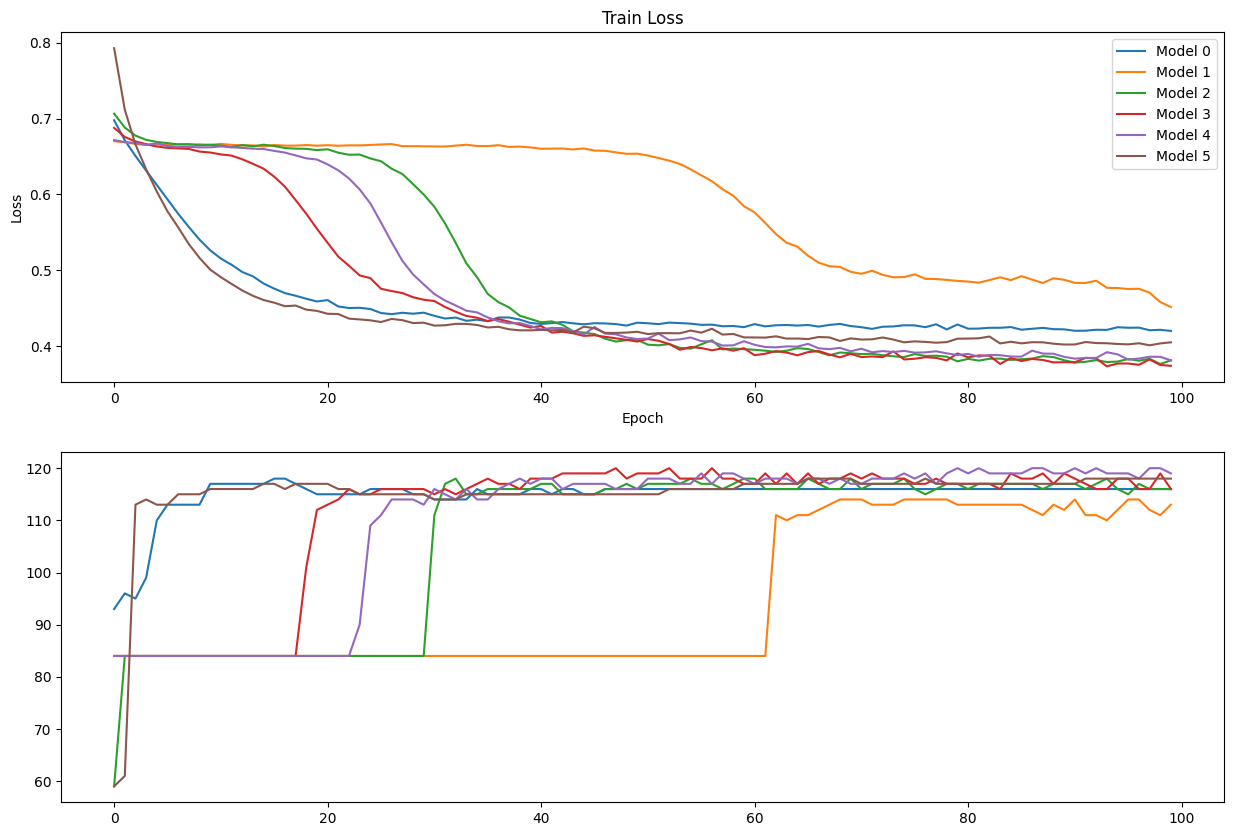

In [11]:
# Plot
num_plots = len(models)

# fig, axs = plt.subplots(num_plots, 2, figsize=(15, 5*num_plots))
# if num_plots == 1:
#     axs = [axs]
# for i in range(num_plots):
#     axs[i][0].plot(overall_train_stats[i]["epoch"], overall_train_stats[i]["loss"])
#     axs[i][0].set_title("Train Loss")
#     axs[i][0].set_xlabel("Epoch")
#     axs[i][0].set_ylabel("Loss")

#     axs[i][1].plot(overall_val_stats[i]["epoch"], overall_val_stats[i]["acc"])
#     axs[i][1].set_title("Validation Accuracy")
#     axs[i][1].set_xlabel("Epoch")
#     axs[i][1].set_ylabel("Accuracy")


# Plot all in one
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
for i in range(len(models)):
    axs[0].plot(overall_train_stats[i]["epoch"], overall_train_stats[i]["loss"], label=f"Model {i}")
    axs[1].plot(overall_val_stats[i]["epoch"], overall_val_stats[i]["acc"], label=f"Model {i}")

axs[0].set_title("Train Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
